# RQ1- Predict across hardware platforms

#### Library

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# decision trees
from sklearn.tree import DecisionTreeRegressor
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# support vector machines
from sklearn.svm import SVR
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# metrics
from sklearn.metrics import mean_absolute_error

# neural network
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

# we use it to interact with the file system
import os
# compute time
from time import time, sleep

# no warning
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Data

In [2]:
system_dir = './data/systems/'
hard_dir = './data/procs/'

envs = pd.read_csv("data/ls_cp_info_modif.csv").set_index("id")
envs.head()

to_keep = ['perf', 'nb_models', 'ls_architecture', 'ls_cpuop-mode', 'ls_cpu', 'ls_threadpercore','ls_corepersocket', 
           'ls_socket', 'ls_numanode', 'ls_vendorid',  'ls_cpufamily', 'ls_model', 'ls_stepping', 
           'ls_cpumhz', 'ls_cpumaxmhz', 'ls_cpuminmhz', 'ls_bogomips', 'ls_virtualization',
           'ls_l1dcache', 'ls_l1icache', 'ls_l2cache', 'ls_l3cache', 'cp_vendor_id','cp_cpufamily', 'cp_model',
           'cp_stepping', 'cp_cpumhz', 'cp_cachesize', 
           'cp_physicalid', 'cp_siblings', 'cp_coreid', 'cp_cpucores', 'cp_apicid', 'cp_initialapicid',
           'cp_fpu', 'cp_fpu_exception', 'cp_cpuidlevel', 'cp_wp',
           'cp_bogomips', 'cp_clflushsize', 'cp_cache_alignment', 'cp_addresssizes']

num = ['nb_models', 'ls_cpu', 'ls_threadpercore', 'ls_corepersocket', 'ls_socket', 'ls_numanode', 
       'ls_cpufamily', 'ls_model', 'ls_stepping',  'ls_cpumhz', 'ls_cpumaxmhz', 
       'ls_cpuminmhz','ls_bogomips',  'ls_l1dcache', 'ls_l1icache', 'ls_l2cache', 'ls_l3cache',
       'cp_cpufamily', 'cp_model', 'cp_stepping', 'cp_cpumhz', 'cp_cachesize', 
       'cp_physicalid', 'cp_siblings', 'cp_coreid', 'cp_cpucores', 'cp_apicid', 'cp_initialapicid',
       'cp_fpu', 'cp_fpu_exception', 'cp_cpuidlevel', 'cp_wp', 'cp_bogomips', 'cp_clflushsize', 
       'cp_cache_alignment']

categ = ['ls_architecture', 'ls_cpuop-mode', 'ls_vendorid', 'ls_virtualization', 
         'cp_vendor_id', 'cp_addresssizes']

# separate average perfs from standard deviations
def separate_perf(perf):
    raw_perf = []
    std_perf = []

    for p in perf:
        tab = str(p).replace(" ", "").split("+/-")
        raw_perf.append(tab[0])
        if len(tab) > 1:
            std_perf.append(tab[1])
        else:
            std_perf.append('')

    return (raw_perf, std_perf)

# Algorithms

In [60]:
def rq1(algo):
    
    # compute RQ1 for the algorithm "algo"
    
    names = []
    maes = []
    maes_amd = []
    maes_intel = []
    bad_sys = []
    nbindiv = []

    for sys_name in os.listdir(system_dir):

        try:

            sys = pd.read_csv(system_dir+sys_name, index_col = 0)

            if sys.shape[0] > 50:

                sys["id"] = [k.replace("/s/", "").replace("+", "") for k in sys["idproc"]]

                sys = sys.set_index("id")

                perf_meta = sys.join(envs)[to_keep].query("ls_cpu!='NaN'").query("ls_vendorid=='AuthenticAMD' or ls_vendorid=='GenuineIntel'").fillna("0")

                avg, std = separate_perf(perf_meta["perf"])

                perf_meta.loc[:, "avg"] = avg

                del perf_meta["perf"]

                X = perf_meta[num].join(pd.get_dummies(perf_meta[categ]))
                y = [float(k) for k in perf_meta["avg"]]
                y = (y-np.mean(y))/np.std(y)

                inter_mae = []
                inter_mae_amd = []
                inter_mae_intel = []

                for i in range(20):

                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

                    alg = algo()

                    alg.fit(X_train,y_train)

                    y_pred = alg.predict(X_test)

                    inter_mae.append(mean_absolute_error(y_test, y_pred))

                    y_test_intel = [y_test[j] for j in range(len(X_test)) if X_test["ls_vendorid_GenuineIntel"][j]]
                    y_pred_intel = [y_pred[j] for j in range(len(X_test)) if X_test["ls_vendorid_GenuineIntel"][j]]

                    if len(y_test_intel) > 0:
                        inter_mae_intel.append(mean_absolute_error(y_test_intel, y_pred_intel))

                    y_test_amd = [y_test[j] for j in range(len(X_test)) if X_test["ls_vendorid_AuthenticAMD"][j]]
                    y_pred_amd = [y_pred[j] for j in range(len(X_test)) if X_test["ls_vendorid_AuthenticAMD"][j]]

                    if len(y_test_amd) > 0:
                        inter_mae_amd.append(mean_absolute_error(y_test_amd, y_pred_amd))
                
                maes.append(np.median(inter_mae))
                maes_amd.append(np.median(inter_mae_amd))
                maes_intel.append(np.median(inter_mae_intel))
                names.append(sys_name)
                nbindiv.append(sys.shape[0])

        except:
            bad_sys.append(sys_name)
    
    return (maes, maes_amd, maes_intel, names)


## Linear Regression

In [61]:
lr_avg, lr_amd, lr_intel, lr_name =  rq1(LinearRegression)

## Decision Tree

In [62]:
dt_avg, dt_amd, dt_intel, dt_name =  rq1(DecisionTreeRegressor)

## Random Forest

In [63]:
rf_avg, rf_amd, rf_intel, rf_name = rq1(RandomForestRegressor)

## Gradient Boosting Tree

In [64]:
gb_avg, gb_amd, gb_intel, gb_name = rq1(GradientBoostingRegressor)

## Support Vector Regressor

In [65]:
sv_avg, sv_amd, sv_intel, sv_name = rq1(SVR)

## Neural Network

In [56]:
names = []
maes = []
maes_amd = []
maes_intel = []
bad_sys = []
nbindiv = []

for sys_name in os.listdir(system_dir):
    
    try:
        sys = pd.read_csv(system_dir+sys_name, index_col = 0)

        if sys.shape[0] > 50:

            sys["id"] = [k.replace("/s/", "").replace("+", "") for k in sys["idproc"]]

            sys = sys.set_index("id")

            perf_meta = sys.join(envs)[to_keep].query("ls_cpu!='NaN'").query("ls_vendorid=='AuthenticAMD' or ls_vendorid=='GenuineIntel'").fillna("0")

            avg, std = separate_perf(perf_meta["perf"])

            perf_meta.loc[:, "avg"] = avg

            del perf_meta["perf"]

            X = perf_meta[num].join(pd.get_dummies(perf_meta[categ]))
            for col in X.columns:
                X_fl = np.array(X[col], float)
                if np.std(X_fl)!=0:
                    X[col] = (X_fl-np.mean(X_fl))/np.std(X_fl)
            y = [float(k) for k in perf_meta["avg"]]
            y = (y-np.mean(y))/np.std(y)

            inter_mae = []
            inter_mae_amd = []
            inter_mae_intel = []

            for i in range(5):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

                model = Sequential()

                model.add(Dense(X_train.shape[1], activation = 'softmax', input_shape=(X_train.shape[1],)))
                model.add(Dense(100))
                model.add(Dropout(0.5))
                model.add(Dense(50))
                model.add(Dropout(0.2))
                model.add(Dense(1))

                model.compile(loss = 'mae', optimizer = 'adam')

                model.fit(np.array(X_train, dtype=float), y_train, epochs = 50, verbose =1)

                y_pred = model.predict(np.array(X_test, dtype=float))

                inter_mae.append(mean_absolute_error(y_test, y_pred))

                y_test_intel = [y_test[j] for j in range(len(X_test)) if X_test["ls_vendorid_GenuineIntel"][j]]
                y_pred_intel = [y_pred[j] for j in range(len(X_test)) if X_test["ls_vendorid_GenuineIntel"][j]]

                if len(y_test_intel) > 0:
                    inter_mae_intel.append(mean_absolute_error(y_test_intel, y_pred_intel))

                y_test_amd = [y_test[j] for j in range(len(X_test)) if X_test["ls_vendorid_AuthenticAMD"][j]]
                y_pred_amd = [y_pred[j] for j in range(len(X_test)) if X_test["ls_vendorid_AuthenticAMD"][j]]

                if len(y_test_amd) > 0:
                    inter_mae_amd.append(mean_absolute_error(y_test_amd, y_pred_amd))

            maes.append(np.median(inter_mae))
            maes_amd.append(np.median(inter_mae_amd))
            maes_intel.append(np.median(inter_mae_intel))
            names.append(sys_name)
            nbindiv.append(sys.shape[0])
    
    except:
        bad_sys.append(sys_name)

Epoch 1/50
63/63 [==============================] - 0s 7ms/step - loss: 0.4193
Epoch 2/50
63/63 [==============================] - 0s 78us/step - loss: 0.3628
Epoch 3/50
63/63 [==============================] - 0s 464us/step - loss: 0.3688
Epoch 4/50
63/63 [==============================] - 0s 91us/step - loss: 0.3668
Epoch 5/50
63/63 [==============================] - 0s 127us/step - loss: 0.3398
Epoch 6/50
63/63 [==============================] - 0s 86us/step - loss: 0.3417
Epoch 7/50
63/63 [==============================] - 0s 116us/step - loss: 0.3155
Epoch 8/50
63/63 [==============================] - 0s 133us/step - loss: 0.3098
Epoch 9/50
63/63 [==============================] - 0s 108us/step - loss: 0.2875
Epoch 10/50
63/63 [==============================] - 0s 94us/step - loss: 0.3002
Epoch 11/50
63/63 [==============================] - 0s 84us/step - loss: 0.2924
Epoch 12/50
63/63 [==============================] - 0s 116us/step - loss: 0.3137
Epoch 13/50
63/63 [=============

63/63 [==============================] - 0s 7ms/step - loss: 0.3946
Epoch 2/50
63/63 [==============================] - 0s 328us/step - loss: 0.3514
Epoch 3/50
63/63 [==============================] - 0s 94us/step - loss: 0.3725
Epoch 4/50
63/63 [==============================] - 0s 182us/step - loss: 0.4268
Epoch 5/50
63/63 [==============================] - 0s 84us/step - loss: 0.3671
Epoch 6/50
63/63 [==============================] - 0s 80us/step - loss: 0.3933
Epoch 7/50
63/63 [==============================] - 0s 97us/step - loss: 0.3604
Epoch 8/50
63/63 [==============================] - 0s 175us/step - loss: 0.3377
Epoch 9/50
63/63 [==============================] - 0s 133us/step - loss: 0.3449
Epoch 10/50
63/63 [==============================] - 0s 145us/step - loss: 0.3336
Epoch 11/50
63/63 [==============================] - 0s 154us/step - loss: 0.3204
Epoch 12/50
63/63 [==============================] - 0s 88us/step - loss: 0.3068
Epoch 13/50
63/63 [========================

63/63 [==============================] - 0s 7ms/step - loss: 0.4435
Epoch 2/50
63/63 [==============================] - 0s 72us/step - loss: 0.4110
Epoch 3/50
63/63 [==============================] - 0s 204us/step - loss: 0.3814
Epoch 4/50
63/63 [==============================] - 0s 137us/step - loss: 0.4218
Epoch 5/50
63/63 [==============================] - 0s 134us/step - loss: 0.4607
Epoch 6/50
63/63 [==============================] - 0s 446us/step - loss: 0.3844
Epoch 7/50
63/63 [==============================] - 0s 367us/step - loss: 0.3894
Epoch 8/50
63/63 [==============================] - 0s 286us/step - loss: 0.4012
Epoch 9/50
63/63 [==============================] - 0s 345us/step - loss: 0.4213
Epoch 10/50
63/63 [==============================] - 0s 460us/step - loss: 0.3767
Epoch 11/50
63/63 [==============================] - 0s 402us/step - loss: 0.3704
Epoch 12/50
63/63 [==============================] - 0s 353us/step - loss: 0.3525
Epoch 13/50
63/63 [====================

74/74 [==============================] - 0s 7ms/step - loss: 0.7830
Epoch 2/50
74/74 [==============================] - 0s 74us/step - loss: 0.6905
Epoch 3/50
74/74 [==============================] - 0s 281us/step - loss: 0.7228
Epoch 4/50
74/74 [==============================] - 0s 166us/step - loss: 0.7654
Epoch 5/50
74/74 [==============================] - 0s 166us/step - loss: 0.7590
Epoch 6/50
74/74 [==============================] - 0s 106us/step - loss: 0.7281
Epoch 7/50
74/74 [==============================] - 0s 119us/step - loss: 0.6617
Epoch 8/50
74/74 [==============================] - 0s 135us/step - loss: 0.7410
Epoch 9/50
74/74 [==============================] - 0s 114us/step - loss: 0.7452
Epoch 10/50
74/74 [==============================] - 0s 135us/step - loss: 0.6897
Epoch 11/50
74/74 [==============================] - 0s 117us/step - loss: 0.6768
Epoch 12/50
74/74 [==============================] - 0s 120us/step - loss: 0.6641
Epoch 13/50
74/74 [====================

74/74 [==============================] - 0s 6ms/step - loss: 0.7760
Epoch 2/50
74/74 [==============================] - 0s 89us/step - loss: 0.7170
Epoch 3/50
74/74 [==============================] - 0s 234us/step - loss: 0.6768
Epoch 4/50
74/74 [==============================] - 0s 145us/step - loss: 0.6760
Epoch 5/50
74/74 [==============================] - 0s 89us/step - loss: 0.6707
Epoch 6/50
74/74 [==============================] - 0s 272us/step - loss: 0.6405
Epoch 7/50
74/74 [==============================] - 0s 125us/step - loss: 0.5954
Epoch 8/50
74/74 [==============================] - 0s 191us/step - loss: 0.5902
Epoch 9/50
74/74 [==============================] - 0s 192us/step - loss: 0.5735
Epoch 10/50
74/74 [==============================] - 0s 200us/step - loss: 0.5715
Epoch 11/50
74/74 [==============================] - 0s 273us/step - loss: 0.5536
Epoch 12/50
74/74 [==============================] - 0s 120us/step - loss: 0.5375
Epoch 13/50
74/74 [=====================

105/105 [==============================] - 0s 4ms/step - loss: 0.1889
Epoch 2/50
105/105 [==============================] - 0s 105us/step - loss: 0.1607
Epoch 3/50
105/105 [==============================] - 0s 89us/step - loss: 0.1523
Epoch 4/50
105/105 [==============================] - 0s 117us/step - loss: 0.1479
Epoch 5/50
105/105 [==============================] - 0s 115us/step - loss: 0.1333
Epoch 6/50
105/105 [==============================] - 0s 118us/step - loss: 0.1388
Epoch 7/50
105/105 [==============================] - 0s 110us/step - loss: 0.1426
Epoch 8/50
105/105 [==============================] - 0s 110us/step - loss: 0.1417
Epoch 9/50
105/105 [==============================] - 0s 118us/step - loss: 0.1334
Epoch 10/50
105/105 [==============================] - 0s 122us/step - loss: 0.1276
Epoch 11/50
105/105 [==============================] - 0s 113us/step - loss: 0.1284
Epoch 12/50
105/105 [==============================] - 0s 130us/step - loss: 0.1231
Epoch 13/50
105

105/105 [==============================] - 0s 113us/step - loss: 0.1911
Epoch 50/50
105/105 [==============================] - 0s 130us/step - loss: 0.1959
Epoch 1/50
105/105 [==============================] - 0s 4ms/step - loss: 0.3611
Epoch 2/50
105/105 [==============================] - 0s 171us/step - loss: 0.3175
Epoch 3/50
105/105 [==============================] - 0s 99us/step - loss: 0.3260
Epoch 4/50
105/105 [==============================] - 0s 112us/step - loss: 0.2866
Epoch 5/50
105/105 [==============================] - 0s 134us/step - loss: 0.2803
Epoch 6/50
105/105 [==============================] - 0s 128us/step - loss: 0.2838
Epoch 7/50
105/105 [==============================] - 0s 126us/step - loss: 0.2419
Epoch 8/50
105/105 [==============================] - 0s 110us/step - loss: 0.2629
Epoch 9/50
105/105 [==============================] - 0s 129us/step - loss: 0.2718
Epoch 10/50
105/105 [==============================] - 0s 107us/step - loss: 0.2523
Epoch 11/50
105/

105/105 [==============================] - 0s 124us/step - loss: 0.1698
Epoch 48/50
105/105 [==============================] - 0s 137us/step - loss: 0.1671
Epoch 49/50
105/105 [==============================] - 0s 116us/step - loss: 0.1638
Epoch 50/50
105/105 [==============================] - 0s 107us/step - loss: 0.1621
Epoch 1/50
105/105 [==============================] - 0s 4ms/step - loss: 0.3620
Epoch 2/50
105/105 [==============================] - 0s 104us/step - loss: 0.3476
Epoch 3/50
105/105 [==============================] - 0s 126us/step - loss: 0.3456
Epoch 4/50
105/105 [==============================] - 0s 111us/step - loss: 0.2894
Epoch 5/50
105/105 [==============================] - 0s 132us/step - loss: 0.2953
Epoch 6/50
105/105 [==============================] - 0s 120us/step - loss: 0.3037
Epoch 7/50
105/105 [==============================] - 0s 130us/step - loss: 0.2675
Epoch 8/50
105/105 [==============================] - 0s 109us/step - loss: 0.2587
Epoch 9/50
105

41/41 [==============================] - 0s 213us/step - loss: 0.4795
Epoch 46/50
41/41 [==============================] - 0s 109us/step - loss: 0.5134
Epoch 47/50
41/41 [==============================] - 0s 196us/step - loss: 0.5139
Epoch 48/50
41/41 [==============================] - 0s 154us/step - loss: 0.5615
Epoch 49/50
41/41 [==============================] - 0s 189us/step - loss: 0.4963
Epoch 50/50
41/41 [==============================] - 0s 153us/step - loss: 0.5020
Epoch 1/50
41/41 [==============================] - 1s 13ms/step - loss: 0.7308
Epoch 2/50
41/41 [==============================] - 0s 253us/step - loss: 0.7038
Epoch 3/50
41/41 [==============================] - 0s 145us/step - loss: 0.6505
Epoch 4/50
41/41 [==============================] - 0s 199us/step - loss: 0.6608
Epoch 5/50
41/41 [==============================] - 0s 173us/step - loss: 0.6511
Epoch 6/50
41/41 [==============================] - 0s 203us/step - loss: 0.6582
Epoch 7/50
41/41 [=================

41/41 [==============================] - 0s 177us/step - loss: 0.4688
Epoch 46/50
41/41 [==============================] - 0s 148us/step - loss: 0.5021
Epoch 47/50
41/41 [==============================] - 0s 199us/step - loss: 0.4659
Epoch 48/50
41/41 [==============================] - 0s 145us/step - loss: 0.5014
Epoch 49/50
41/41 [==============================] - 0s 210us/step - loss: 0.4712
Epoch 50/50
41/41 [==============================] - 0s 162us/step - loss: 0.5186
Epoch 1/50
41/41 [==============================] - 0s 11ms/step - loss: 0.6920
Epoch 2/50
41/41 [==============================] - 0s 136us/step - loss: 0.6902
Epoch 3/50
41/41 [==============================] - 0s 145us/step - loss: 0.6931
Epoch 4/50
41/41 [==============================] - 0s 163us/step - loss: 0.6571
Epoch 5/50
41/41 [==============================] - 0s 332us/step - loss: 0.6548
Epoch 6/50
41/41 [==============================] - 0s 176us/step - loss: 0.6255
Epoch 7/50
41/41 [=================

41/41 [==============================] - 0s 192us/step - loss: 0.4802
Epoch 46/50
41/41 [==============================] - 0s 251us/step - loss: 0.4982
Epoch 47/50
41/41 [==============================] - 0s 183us/step - loss: 0.5121
Epoch 48/50
41/41 [==============================] - 0s 202us/step - loss: 0.4673
Epoch 49/50
41/41 [==============================] - 0s 249us/step - loss: 0.4843
Epoch 50/50
41/41 [==============================] - 0s 148us/step - loss: 0.5200
Epoch 1/50
80/80 [==============================] - 0s 6ms/step - loss: 0.7787
Epoch 2/50
80/80 [==============================] - 0s 105us/step - loss: 0.7547
Epoch 3/50
80/80 [==============================] - 0s 103us/step - loss: 0.7654
Epoch 4/50
80/80 [==============================] - 0s 106us/step - loss: 0.7887
Epoch 5/50
80/80 [==============================] - 0s 110us/step - loss: 0.7816
Epoch 6/50
80/80 [==============================] - 0s 105us/step - loss: 0.7763
Epoch 7/50
80/80 [==================

80/80 [==============================] - 0s 105us/step - loss: 0.2454
Epoch 46/50
80/80 [==============================] - 0s 123us/step - loss: 0.2198
Epoch 47/50
80/80 [==============================] - 0s 102us/step - loss: 0.2503
Epoch 48/50
80/80 [==============================] - 0s 104us/step - loss: 0.2495
Epoch 49/50
80/80 [==============================] - 0s 100us/step - loss: 0.2333
Epoch 50/50
80/80 [==============================] - 0s 98us/step - loss: 0.2170
Epoch 1/50
80/80 [==============================] - 0s 5ms/step - loss: 0.7896
Epoch 2/50
80/80 [==============================] - 0s 144us/step - loss: 0.7351
Epoch 3/50
80/80 [==============================] - 0s 217us/step - loss: 0.7513
Epoch 4/50
80/80 [==============================] - 0s 210us/step - loss: 0.7209
Epoch 5/50
80/80 [==============================] - 0s 116us/step - loss: 0.6620
Epoch 6/50
80/80 [==============================] - 0s 131us/step - loss: 0.6478
Epoch 7/50
80/80 [===================

80/80 [==============================] - 0s 223us/step - loss: 0.2765
Epoch 46/50
80/80 [==============================] - 0s 178us/step - loss: 0.2441
Epoch 47/50
80/80 [==============================] - 0s 147us/step - loss: 0.2606
Epoch 48/50
80/80 [==============================] - 0s 156us/step - loss: 0.2362
Epoch 49/50
80/80 [==============================] - 0s 160us/step - loss: 0.2123
Epoch 50/50
80/80 [==============================] - 0s 136us/step - loss: 0.2041
Epoch 1/50
80/80 [==============================] - 0s 5ms/step - loss: 0.8282
Epoch 2/50
80/80 [==============================] - 0s 116us/step - loss: 0.7269
Epoch 3/50
80/80 [==============================] - 0s 109us/step - loss: 0.7100
Epoch 4/50
80/80 [==============================] - 0s 139us/step - loss: 0.7149
Epoch 5/50
80/80 [==============================] - 0s 126us/step - loss: 0.6021
Epoch 6/50
80/80 [==============================] - 0s 119us/step - loss: 0.6602
Epoch 7/50
80/80 [==================

49/49 [==============================] - 0s 169us/step - loss: 0.5041
Epoch 46/50
49/49 [==============================] - 0s 138us/step - loss: 0.4836
Epoch 47/50
49/49 [==============================] - 0s 128us/step - loss: 0.4518
Epoch 48/50
49/49 [==============================] - 0s 133us/step - loss: 0.4566
Epoch 49/50
49/49 [==============================] - 0s 161us/step - loss: 0.4809
Epoch 50/50
49/49 [==============================] - 0s 367us/step - loss: 0.4845
Epoch 1/50
49/49 [==============================] - 1s 11ms/step - loss: 0.8241
Epoch 2/50
49/49 [==============================] - 0s 376us/step - loss: 0.8523
Epoch 3/50
49/49 [==============================] - 0s 219us/step - loss: 0.8860
Epoch 4/50
49/49 [==============================] - 0s 273us/step - loss: 0.7958
Epoch 5/50
49/49 [==============================] - 0s 354us/step - loss: 0.8016
Epoch 6/50
49/49 [==============================] - 0s 172us/step - loss: 0.8056
Epoch 7/50
49/49 [=================

49/49 [==============================] - 0s 163us/step - loss: 0.4629
Epoch 46/50
49/49 [==============================] - 0s 281us/step - loss: 0.4509
Epoch 47/50
49/49 [==============================] - 0s 344us/step - loss: 0.4423
Epoch 48/50
49/49 [==============================] - 0s 152us/step - loss: 0.4661
Epoch 49/50
49/49 [==============================] - 0s 136us/step - loss: 0.4495
Epoch 50/50
49/49 [==============================] - 0s 144us/step - loss: 0.4223
Epoch 1/50
49/49 [==============================] - 0s 9ms/step - loss: 0.7778
Epoch 2/50
49/49 [==============================] - 0s 147us/step - loss: 0.7261
Epoch 3/50
49/49 [==============================] - 0s 141us/step - loss: 0.7068
Epoch 4/50
49/49 [==============================] - 0s 163us/step - loss: 0.7362
Epoch 5/50
49/49 [==============================] - 0s 141us/step - loss: 0.7088
Epoch 6/50
49/49 [==============================] - 0s 143us/step - loss: 0.6806
Epoch 7/50
49/49 [==================

49/49 [==============================] - 0s 154us/step - loss: 0.5988
Epoch 46/50
49/49 [==============================] - 0s 171us/step - loss: 0.5768
Epoch 47/50
49/49 [==============================] - 0s 121us/step - loss: 0.5248
Epoch 48/50
49/49 [==============================] - 0s 196us/step - loss: 0.5142
Epoch 49/50
49/49 [==============================] - 0s 230us/step - loss: 0.5440
Epoch 50/50
49/49 [==============================] - 0s 320us/step - loss: 0.5013
Epoch 1/50
50/50 [==============================] - 0s 9ms/step - loss: 0.7836
Epoch 2/50
50/50 [==============================] - 0s 178us/step - loss: 0.8198
Epoch 3/50
50/50 [==============================] - 0s 167us/step - loss: 0.8529
Epoch 4/50
50/50 [==============================] - 0s 195us/step - loss: 0.7718
Epoch 5/50
50/50 [==============================] - 0s 171us/step - loss: 0.8308
Epoch 6/50
50/50 [==============================] - 0s 145us/step - loss: 0.8337
Epoch 7/50
50/50 [==================

50/50 [==============================] - 0s 101us/step - loss: 0.4864
Epoch 46/50
50/50 [==============================] - 0s 267us/step - loss: 0.4535
Epoch 47/50
50/50 [==============================] - 0s 94us/step - loss: 0.4947
Epoch 48/50
50/50 [==============================] - 0s 138us/step - loss: 0.4940
Epoch 49/50
50/50 [==============================] - 0s 204us/step - loss: 0.5273
Epoch 50/50
50/50 [==============================] - 0s 367us/step - loss: 0.4494
Epoch 1/50
50/50 [==============================] - 0s 9ms/step - loss: 0.8572
Epoch 2/50
50/50 [==============================] - 0s 933us/step - loss: 0.8276
Epoch 3/50
50/50 [==============================] - 0s 340us/step - loss: 0.8141
Epoch 4/50
50/50 [==============================] - 0s 374us/step - loss: 0.8744
Epoch 5/50
50/50 [==============================] - 0s 392us/step - loss: 0.8836
Epoch 6/50
50/50 [==============================] - 0s 466us/step - loss: 0.8295
Epoch 7/50
50/50 [===================

50/50 [==============================] - 0s 113us/step - loss: 0.4619
Epoch 46/50
50/50 [==============================] - 0s 153us/step - loss: 0.4374
Epoch 47/50
50/50 [==============================] - 0s 146us/step - loss: 0.4741
Epoch 48/50
50/50 [==============================] - 0s 144us/step - loss: 0.4677
Epoch 49/50
50/50 [==============================] - 0s 133us/step - loss: 0.4493
Epoch 50/50
50/50 [==============================] - 0s 148us/step - loss: 0.4777
Epoch 1/50
50/50 [==============================] - 0s 9ms/step - loss: 0.8404
Epoch 2/50
50/50 [==============================] - 0s 151us/step - loss: 0.7477
Epoch 3/50
50/50 [==============================] - 0s 165us/step - loss: 0.6988
Epoch 4/50
50/50 [==============================] - 0s 131us/step - loss: 0.6462
Epoch 5/50
50/50 [==============================] - 0s 770us/step - loss: 0.6676
Epoch 6/50
50/50 [==============================] - 0s 231us/step - loss: 0.7117
Epoch 7/50
50/50 [==================

49/49 [==============================] - 0s 256us/step - loss: 0.6072
Epoch 46/50
49/49 [==============================] - 0s 317us/step - loss: 0.6075
Epoch 47/50
49/49 [==============================] - 0s 238us/step - loss: 0.6014
Epoch 48/50
49/49 [==============================] - 0s 273us/step - loss: 0.5429
Epoch 49/50
49/49 [==============================] - 0s 186us/step - loss: 0.5428
Epoch 50/50
49/49 [==============================] - 0s 225us/step - loss: 0.5797
Epoch 1/50
49/49 [==============================] - 1s 11ms/step - loss: 0.8854
Epoch 2/50
49/49 [==============================] - 0s 178us/step - loss: 0.8600
Epoch 3/50
49/49 [==============================] - 0s 163us/step - loss: 0.8328
Epoch 4/50
49/49 [==============================] - 0s 117us/step - loss: 0.8252
Epoch 5/50
49/49 [==============================] - 0s 126us/step - loss: 0.8514
Epoch 6/50
49/49 [==============================] - 0s 124us/step - loss: 0.7961
Epoch 7/50
49/49 [=================

49/49 [==============================] - 0s 207us/step - loss: 0.4987
Epoch 46/50
49/49 [==============================] - 0s 227us/step - loss: 0.5238
Epoch 47/50
49/49 [==============================] - 0s 241us/step - loss: 0.4489
Epoch 48/50
49/49 [==============================] - 0s 227us/step - loss: 0.5010
Epoch 49/50
49/49 [==============================] - 0s 210us/step - loss: 0.4784
Epoch 50/50
49/49 [==============================] - 0s 180us/step - loss: 0.4707
Epoch 1/50
49/49 [==============================] - 0s 9ms/step - loss: 0.8845
Epoch 2/50
49/49 [==============================] - 0s 169us/step - loss: 0.8448
Epoch 3/50
49/49 [==============================] - 0s 125us/step - loss: 0.8146
Epoch 4/50
49/49 [==============================] - 0s 81us/step - loss: 0.8115
Epoch 5/50
49/49 [==============================] - 0s 101us/step - loss: 0.7719
Epoch 6/50
49/49 [==============================] - 0s 102us/step - loss: 0.8304
Epoch 7/50
49/49 [===================

49/49 [==============================] - 0s 139us/step - loss: 0.3685
Epoch 46/50
49/49 [==============================] - 0s 120us/step - loss: 0.3885
Epoch 47/50
49/49 [==============================] - 0s 144us/step - loss: 0.3605
Epoch 48/50
49/49 [==============================] - 0s 157us/step - loss: 0.3302
Epoch 49/50
49/49 [==============================] - 0s 137us/step - loss: 0.3388
Epoch 50/50
49/49 [==============================] - 0s 194us/step - loss: 0.3522
Epoch 1/50
62/62 [==============================] - 0s 7ms/step - loss: 0.8207
Epoch 2/50
62/62 [==============================] - 0s 149us/step - loss: 0.8647
Epoch 3/50
62/62 [==============================] - 0s 125us/step - loss: 0.8568
Epoch 4/50
62/62 [==============================] - 0s 93us/step - loss: 0.8613
Epoch 5/50
62/62 [==============================] - 0s 106us/step - loss: 0.8611
Epoch 6/50
62/62 [==============================] - 0s 96us/step - loss: 0.8678
Epoch 7/50
62/62 [====================

62/62 [==============================] - 0s 101us/step - loss: 0.4308
Epoch 46/50
62/62 [==============================] - 0s 112us/step - loss: 0.4689
Epoch 47/50
62/62 [==============================] - 0s 92us/step - loss: 0.4561
Epoch 48/50
62/62 [==============================] - 0s 94us/step - loss: 0.4456
Epoch 49/50
62/62 [==============================] - 0s 86us/step - loss: 0.4183
Epoch 50/50
62/62 [==============================] - 0s 91us/step - loss: 0.3994
Epoch 1/50
62/62 [==============================] - 0s 7ms/step - loss: 0.8592
Epoch 2/50
62/62 [==============================] - 0s 114us/step - loss: 0.8375
Epoch 3/50
62/62 [==============================] - 0s 91us/step - loss: 0.8507
Epoch 4/50
62/62 [==============================] - 0s 214us/step - loss: 0.8466
Epoch 5/50
62/62 [==============================] - 0s 120us/step - loss: 0.9024
Epoch 6/50
62/62 [==============================] - 0s 100us/step - loss: 0.8801
Epoch 7/50
62/62 [=======================

62/62 [==============================] - 0s 141us/step - loss: 0.4951
Epoch 46/50
62/62 [==============================] - 0s 109us/step - loss: 0.4591
Epoch 47/50
62/62 [==============================] - 0s 109us/step - loss: 0.4665
Epoch 48/50
62/62 [==============================] - 0s 113us/step - loss: 0.4493
Epoch 49/50
62/62 [==============================] - 0s 143us/step - loss: 0.4407
Epoch 50/50
62/62 [==============================] - 0s 111us/step - loss: 0.4509
Epoch 1/50
62/62 [==============================] - 0s 7ms/step - loss: 0.8797
Epoch 2/50
62/62 [==============================] - 0s 241us/step - loss: 0.8396
Epoch 3/50
62/62 [==============================] - 0s 171us/step - loss: 0.8576
Epoch 4/50
62/62 [==============================] - 0s 117us/step - loss: 0.8779
Epoch 5/50
62/62 [==============================] - 0s 124us/step - loss: 0.8754
Epoch 6/50
62/62 [==============================] - 0s 107us/step - loss: 0.9123
Epoch 7/50
62/62 [==================

58/58 [==============================] - 0s 145us/step - loss: 0.4819
Epoch 46/50
58/58 [==============================] - 0s 146us/step - loss: 0.4632
Epoch 47/50
58/58 [==============================] - 0s 152us/step - loss: 0.5212
Epoch 48/50
58/58 [==============================] - 0s 124us/step - loss: 0.4852
Epoch 49/50
58/58 [==============================] - 0s 302us/step - loss: 0.4779
Epoch 50/50
58/58 [==============================] - 0s 109us/step - loss: 0.4720
Epoch 1/50
58/58 [==============================] - 0s 7ms/step - loss: 0.6354
Epoch 2/50
58/58 [==============================] - 0s 243us/step - loss: 0.5416
Epoch 3/50
58/58 [==============================] - 0s 121us/step - loss: 0.5838
Epoch 4/50
58/58 [==============================] - 0s 111us/step - loss: 0.5253
Epoch 5/50
58/58 [==============================] - 0s 121us/step - loss: 0.5551
Epoch 6/50
58/58 [==============================] - 0s 149us/step - loss: 0.5225
Epoch 7/50
58/58 [==================

58/58 [==============================] - 0s 300us/step - loss: 0.4786
Epoch 46/50
58/58 [==============================] - 0s 134us/step - loss: 0.4454
Epoch 47/50
58/58 [==============================] - 0s 123us/step - loss: 0.4752
Epoch 48/50
58/58 [==============================] - 0s 131us/step - loss: 0.4464
Epoch 49/50
58/58 [==============================] - 0s 130us/step - loss: 0.4586
Epoch 50/50
58/58 [==============================] - 0s 128us/step - loss: 0.4567
Epoch 1/50
58/58 [==============================] - 0s 8ms/step - loss: 0.6163
Epoch 2/50
58/58 [==============================] - 0s 145us/step - loss: 0.5615
Epoch 3/50
58/58 [==============================] - 0s 142us/step - loss: 0.5151
Epoch 4/50
58/58 [==============================] - 0s 117us/step - loss: 0.5436
Epoch 5/50
58/58 [==============================] - 0s 119us/step - loss: 0.5264
Epoch 6/50
58/58 [==============================] - 0s 120us/step - loss: 0.5473
Epoch 7/50
58/58 [==================

58/58 [==============================] - 0s 99us/step - loss: 0.4644
Epoch 46/50
58/58 [==============================] - 0s 82us/step - loss: 0.4111
Epoch 47/50
58/58 [==============================] - 0s 107us/step - loss: 0.4333
Epoch 48/50
58/58 [==============================] - 0s 86us/step - loss: 0.4276
Epoch 49/50
58/58 [==============================] - 0s 93us/step - loss: 0.4231
Epoch 50/50
58/58 [==============================] - 0s 105us/step - loss: 0.4235
Epoch 1/50
52/52 [==============================] - 0s 8ms/step - loss: 0.7038
Epoch 2/50
52/52 [==============================] - 0s 202us/step - loss: 0.6921
Epoch 3/50
52/52 [==============================] - 0s 156us/step - loss: 0.6523
Epoch 4/50
52/52 [==============================] - 0s 158us/step - loss: 0.7210
Epoch 5/50
52/52 [==============================] - 0s 170us/step - loss: 0.6930
Epoch 6/50
52/52 [==============================] - 0s 166us/step - loss: 0.6731
Epoch 7/50
52/52 [======================

52/52 [==============================] - 0s 149us/step - loss: 0.4840
Epoch 46/50
52/52 [==============================] - 0s 146us/step - loss: 0.4744
Epoch 47/50
52/52 [==============================] - 0s 112us/step - loss: 0.4589
Epoch 48/50
52/52 [==============================] - 0s 155us/step - loss: 0.4771
Epoch 49/50
52/52 [==============================] - 0s 132us/step - loss: 0.4881
Epoch 50/50
52/52 [==============================] - 0s 104us/step - loss: 0.4799
Epoch 1/50
52/52 [==============================] - 0s 8ms/step - loss: 0.6407
Epoch 2/50
52/52 [==============================] - 0s 110us/step - loss: 0.6498
Epoch 3/50
52/52 [==============================] - 0s 110us/step - loss: 0.6246
Epoch 4/50
52/52 [==============================] - 0s 104us/step - loss: 0.6444
Epoch 5/50
52/52 [==============================] - 0s 108us/step - loss: 0.6182
Epoch 6/50
52/52 [==============================] - 0s 111us/step - loss: 0.5748
Epoch 7/50
52/52 [==================

52/52 [==============================] - 0s 219us/step - loss: 0.4387
Epoch 46/50
52/52 [==============================] - 0s 203us/step - loss: 0.4482
Epoch 47/50
52/52 [==============================] - 0s 250us/step - loss: 0.4423
Epoch 48/50
52/52 [==============================] - 0s 198us/step - loss: 0.4626
Epoch 49/50
52/52 [==============================] - 0s 261us/step - loss: 0.4472
Epoch 50/50
52/52 [==============================] - 0s 154us/step - loss: 0.4068
Epoch 1/50
52/52 [==============================] - 0s 9ms/step - loss: 0.6167
Epoch 2/50
52/52 [==============================] - 0s 453us/step - loss: 0.5873
Epoch 3/50
52/52 [==============================] - 0s 185us/step - loss: 0.6132
Epoch 4/50
52/52 [==============================] - 0s 155us/step - loss: 0.6235
Epoch 5/50
52/52 [==============================] - 0s 145us/step - loss: 0.6221
Epoch 6/50
52/52 [==============================] - 0s 145us/step - loss: 0.6075
Epoch 7/50
52/52 [==================

79/79 [==============================] - 0s 128us/step - loss: 0.2199
Epoch 46/50
79/79 [==============================] - 0s 234us/step - loss: 0.2092
Epoch 47/50
79/79 [==============================] - 0s 103us/step - loss: 0.2308
Epoch 48/50
79/79 [==============================] - 0s 101us/step - loss: 0.2376
Epoch 49/50
79/79 [==============================] - 0s 147us/step - loss: 0.2274
Epoch 50/50
79/79 [==============================] - 0s 161us/step - loss: 0.2222
Epoch 1/50
79/79 [==============================] - 0s 6ms/step - loss: 0.8099
Epoch 2/50
79/79 [==============================] - 0s 106us/step - loss: 0.7666
Epoch 3/50
79/79 [==============================] - 0s 92us/step - loss: 0.7525
Epoch 4/50
79/79 [==============================] - 0s 96us/step - loss: 0.7787
Epoch 5/50
79/79 [==============================] - 0s 111us/step - loss: 0.7595
Epoch 6/50
79/79 [==============================] - 0s 97us/step - loss: 0.7586
Epoch 7/50
79/79 [=====================

79/79 [==============================] - 0s 134us/step - loss: 0.2247
Epoch 46/50
79/79 [==============================] - 0s 215us/step - loss: 0.1995
Epoch 47/50
79/79 [==============================] - 0s 127us/step - loss: 0.2360
Epoch 48/50
79/79 [==============================] - 0s 184us/step - loss: 0.2235
Epoch 49/50
79/79 [==============================] - 0s 134us/step - loss: 0.2224
Epoch 50/50
79/79 [==============================] - 0s 141us/step - loss: 0.2224
Epoch 1/50
79/79 [==============================] - 0s 6ms/step - loss: 0.8084
Epoch 2/50
79/79 [==============================] - 0s 80us/step - loss: 0.7910
Epoch 3/50
79/79 [==============================] - 0s 76us/step - loss: 0.7761
Epoch 4/50
79/79 [==============================] - 0s 82us/step - loss: 0.7304
Epoch 5/50
79/79 [==============================] - 0s 80us/step - loss: 0.7107
Epoch 6/50
79/79 [==============================] - 0s 177us/step - loss: 0.6470
Epoch 7/50
79/79 [======================

79/79 [==============================] - 0s 151us/step - loss: 0.2735
Epoch 46/50
79/79 [==============================] - 0s 154us/step - loss: 0.2661
Epoch 47/50
79/79 [==============================] - 0s 162us/step - loss: 0.2643
Epoch 48/50
79/79 [==============================] - 0s 152us/step - loss: 0.2925
Epoch 49/50
79/79 [==============================] - 0s 154us/step - loss: 0.2663
Epoch 50/50
79/79 [==============================] - 0s 138us/step - loss: 0.2611
Epoch 1/50
154/154 [==============================] - 0s 3ms/step - loss: 0.5937
Epoch 2/50
154/154 [==============================] - 0s 94us/step - loss: 0.5079
Epoch 3/50
154/154 [==============================] - 0s 95us/step - loss: 0.4990
Epoch 4/50
154/154 [==============================] - 0s 97us/step - loss: 0.4771
Epoch 5/50
154/154 [==============================] - 0s 79us/step - loss: 0.4668
Epoch 6/50
154/154 [==============================] - 0s 92us/step - loss: 0.4654
Epoch 7/50
154/154 [=========

154/154 [==============================] - 0s 112us/step - loss: 0.2664
Epoch 44/50
154/154 [==============================] - 0s 103us/step - loss: 0.2745
Epoch 45/50
154/154 [==============================] - 0s 109us/step - loss: 0.2642
Epoch 46/50
154/154 [==============================] - 0s 114us/step - loss: 0.2371
Epoch 47/50
154/154 [==============================] - 0s 97us/step - loss: 0.2445
Epoch 48/50
154/154 [==============================] - 0s 101us/step - loss: 0.2443
Epoch 49/50
154/154 [==============================] - 0s 96us/step - loss: 0.2356
Epoch 50/50
154/154 [==============================] - 0s 106us/step - loss: 0.2283
Epoch 1/50
154/154 [==============================] - 0s 3ms/step - loss: 0.6766
Epoch 2/50
154/154 [==============================] - 0s 64us/step - loss: 0.6114
Epoch 3/50
154/154 [==============================] - 0s 175us/step - loss: 0.5982
Epoch 4/50
154/154 [==============================] - 0s 92us/step - loss: 0.6064
Epoch 5/50
154

154/154 [==============================] - 0s 137us/step - loss: 0.2768
Epoch 42/50
154/154 [==============================] - 0s 144us/step - loss: 0.2537
Epoch 43/50
154/154 [==============================] - 0s 144us/step - loss: 0.2565
Epoch 44/50
154/154 [==============================] - 0s 194us/step - loss: 0.2702
Epoch 45/50
154/154 [==============================] - 0s 152us/step - loss: 0.2546
Epoch 46/50
154/154 [==============================] - 0s 148us/step - loss: 0.2450
Epoch 47/50
154/154 [==============================] - 0s 192us/step - loss: 0.2417
Epoch 48/50
154/154 [==============================] - 0s 161us/step - loss: 0.2507
Epoch 49/50
154/154 [==============================] - 0s 232us/step - loss: 0.2483
Epoch 50/50
154/154 [==============================] - 0s 175us/step - loss: 0.2349
Epoch 1/50
154/154 [==============================] - 1s 3ms/step - loss: 0.5949
Epoch 2/50
154/154 [==============================] - 0s 109us/step - loss: 0.5786
Epoch 3/

94/94 [==============================] - 0s 180us/step - loss: 0.2402
Epoch 41/50
94/94 [==============================] - 0s 146us/step - loss: 0.2364
Epoch 42/50
94/94 [==============================] - 0s 162us/step - loss: 0.2305
Epoch 43/50
94/94 [==============================] - 0s 184us/step - loss: 0.2176
Epoch 44/50
94/94 [==============================] - 0s 326us/step - loss: 0.2188
Epoch 45/50
94/94 [==============================] - 0s 169us/step - loss: 0.2314
Epoch 46/50
94/94 [==============================] - 0s 155us/step - loss: 0.2230
Epoch 47/50
94/94 [==============================] - 0s 177us/step - loss: 0.2115
Epoch 48/50
94/94 [==============================] - 0s 673us/step - loss: 0.2168
Epoch 49/50
94/94 [==============================] - 0s 353us/step - loss: 0.1972
Epoch 50/50
94/94 [==============================] - 0s 234us/step - loss: 0.2245
Epoch 1/50
94/94 [==============================] - 1s 8ms/step - loss: 0.8398
Epoch 2/50
94/94 [=============

94/94 [==============================] - 0s 202us/step - loss: 0.2607
Epoch 41/50
94/94 [==============================] - 0s 139us/step - loss: 0.2642
Epoch 42/50
94/94 [==============================] - 0s 267us/step - loss: 0.2379
Epoch 43/50
94/94 [==============================] - 0s 200us/step - loss: 0.2597
Epoch 44/50
94/94 [==============================] - 0s 208us/step - loss: 0.2270
Epoch 45/50
94/94 [==============================] - 0s 359us/step - loss: 0.2278
Epoch 46/50
94/94 [==============================] - 0s 333us/step - loss: 0.2321
Epoch 47/50
94/94 [==============================] - 0s 169us/step - loss: 0.2262
Epoch 48/50
94/94 [==============================] - 0s 165us/step - loss: 0.2010
Epoch 49/50
94/94 [==============================] - 0s 216us/step - loss: 0.2243
Epoch 50/50
94/94 [==============================] - 0s 196us/step - loss: 0.2158
Epoch 1/50
94/94 [==============================] - 0s 5ms/step - loss: 0.8921
Epoch 2/50
94/94 [=============

94/94 [==============================] - 0s 477us/step - loss: 0.2504
Epoch 41/50
94/94 [==============================] - 0s 264us/step - loss: 0.2420
Epoch 42/50
94/94 [==============================] - 0s 184us/step - loss: 0.2213
Epoch 43/50
94/94 [==============================] - 0s 184us/step - loss: 0.2282
Epoch 44/50
94/94 [==============================] - 0s 597us/step - loss: 0.2268
Epoch 45/50
94/94 [==============================] - 0s 460us/step - loss: 0.2162
Epoch 46/50
94/94 [==============================] - 0s 389us/step - loss: 0.2301
Epoch 47/50
94/94 [==============================] - 0s 149us/step - loss: 0.2184
Epoch 48/50
94/94 [==============================] - 0s 188us/step - loss: 0.2123
Epoch 49/50
94/94 [==============================] - 0s 254us/step - loss: 0.1968
Epoch 50/50
94/94 [==============================] - 0s 185us/step - loss: 0.2043
Epoch 1/50
94/94 [==============================] - 1s 9ms/step - loss: 0.8431
Epoch 2/50
94/94 [=============

94/94 [==============================] - 0s 123us/step - loss: 0.3308
Epoch 41/50
94/94 [==============================] - 0s 117us/step - loss: 0.3203
Epoch 42/50
94/94 [==============================] - 0s 130us/step - loss: 0.3548
Epoch 43/50
94/94 [==============================] - 0s 107us/step - loss: 0.3315
Epoch 44/50
94/94 [==============================] - 0s 107us/step - loss: 0.3052
Epoch 45/50
94/94 [==============================] - 0s 106us/step - loss: 0.3087
Epoch 46/50
94/94 [==============================] - 0s 107us/step - loss: 0.3289
Epoch 47/50
94/94 [==============================] - 0s 102us/step - loss: 0.3155
Epoch 48/50
94/94 [==============================] - 0s 120us/step - loss: 0.2977
Epoch 49/50
94/94 [==============================] - 0s 112us/step - loss: 0.3015
Epoch 50/50
94/94 [==============================] - 0s 120us/step - loss: 0.2855
Epoch 1/50
94/94 [==============================] - 1s 6ms/step - loss: 0.7988
Epoch 2/50
94/94 [=============

94/94 [==============================] - 0s 206us/step - loss: 0.2521
Epoch 41/50
94/94 [==============================] - 0s 198us/step - loss: 0.2622
Epoch 42/50
94/94 [==============================] - 0s 313us/step - loss: 0.2568
Epoch 43/50
94/94 [==============================] - 0s 273us/step - loss: 0.2397
Epoch 44/50
94/94 [==============================] - 0s 197us/step - loss: 0.2569
Epoch 45/50
94/94 [==============================] - 0s 174us/step - loss: 0.2518
Epoch 46/50
94/94 [==============================] - 0s 146us/step - loss: 0.2299
Epoch 47/50
94/94 [==============================] - 0s 175us/step - loss: 0.2309
Epoch 48/50
94/94 [==============================] - 0s 187us/step - loss: 0.2205
Epoch 49/50
94/94 [==============================] - 0s 190us/step - loss: 0.2523
Epoch 50/50
94/94 [==============================] - 0s 162us/step - loss: 0.2319
Epoch 1/50
94/94 [==============================] - 0s 5ms/step - loss: 0.7045
Epoch 2/50
94/94 [=============

38/38 [==============================] - 0s 261us/step - loss: 0.4705
Epoch 41/50
38/38 [==============================] - 0s 266us/step - loss: 0.4650
Epoch 42/50
38/38 [==============================] - 0s 242us/step - loss: 0.4547
Epoch 43/50
38/38 [==============================] - 0s 197us/step - loss: 0.4903
Epoch 44/50
38/38 [==============================] - 0s 242us/step - loss: 0.4447
Epoch 45/50
38/38 [==============================] - 0s 208us/step - loss: 0.4270
Epoch 46/50
38/38 [==============================] - 0s 228us/step - loss: 0.4411
Epoch 47/50
38/38 [==============================] - 0s 222us/step - loss: 0.4487
Epoch 48/50
38/38 [==============================] - 0s 215us/step - loss: 0.4631
Epoch 49/50
38/38 [==============================] - 0s 220us/step - loss: 0.4347
Epoch 50/50
38/38 [==============================] - 0s 874us/step - loss: 0.4379
Epoch 1/50
38/38 [==============================] - 0s 11ms/step - loss: 0.7657
Epoch 2/50
38/38 [============

38/38 [==============================] - 0s 269us/step - loss: 0.5930
Epoch 41/50
38/38 [==============================] - 0s 273us/step - loss: 0.5609
Epoch 42/50
38/38 [==============================] - 0s 251us/step - loss: 0.5436
Epoch 43/50
38/38 [==============================] - 0s 172us/step - loss: 0.5395
Epoch 44/50
38/38 [==============================] - 0s 167us/step - loss: 0.5374
Epoch 45/50
38/38 [==============================] - 0s 178us/step - loss: 0.5698
Epoch 46/50
38/38 [==============================] - 0s 375us/step - loss: 0.4963
Epoch 47/50
38/38 [==============================] - 0s 275us/step - loss: 0.4940
Epoch 48/50
38/38 [==============================] - 0s 179us/step - loss: 0.4780
Epoch 49/50
38/38 [==============================] - 0s 126us/step - loss: 0.5292
Epoch 50/50
38/38 [==============================] - 0s 116us/step - loss: 0.5287
Epoch 1/50
38/38 [==============================] - 0s 13ms/step - loss: 0.8354
Epoch 2/50
38/38 [============

38/38 [==============================] - 0s 194us/step - loss: 0.4180
Epoch 41/50
38/38 [==============================] - 0s 177us/step - loss: 0.4454
Epoch 42/50
38/38 [==============================] - 0s 193us/step - loss: 0.4391
Epoch 43/50
38/38 [==============================] - 0s 212us/step - loss: 0.4625
Epoch 44/50
38/38 [==============================] - 0s 216us/step - loss: 0.4988
Epoch 45/50
38/38 [==============================] - 0s 195us/step - loss: 0.4582
Epoch 46/50
38/38 [==============================] - 0s 183us/step - loss: 0.4316
Epoch 47/50
38/38 [==============================] - 0s 181us/step - loss: 0.4547
Epoch 48/50
38/38 [==============================] - 0s 198us/step - loss: 0.4626
Epoch 49/50
38/38 [==============================] - 0s 168us/step - loss: 0.4389
Epoch 50/50
38/38 [==============================] - 0s 244us/step - loss: 0.4174
Epoch 1/50
55/55 [==============================] - 1s 9ms/step - loss: 0.8874
Epoch 2/50
55/55 [=============

55/55 [==============================] - 0s 141us/step - loss: 0.6400
Epoch 41/50
55/55 [==============================] - 0s 199us/step - loss: 0.6527
Epoch 42/50
55/55 [==============================] - 0s 193us/step - loss: 0.6477
Epoch 43/50
55/55 [==============================] - 0s 156us/step - loss: 0.6539
Epoch 44/50
55/55 [==============================] - 0s 188us/step - loss: 0.6193
Epoch 45/50
55/55 [==============================] - 0s 215us/step - loss: 0.6759
Epoch 46/50
55/55 [==============================] - 0s 134us/step - loss: 0.6884
Epoch 47/50
55/55 [==============================] - 0s 201us/step - loss: 0.6532
Epoch 48/50
55/55 [==============================] - 0s 81us/step - loss: 0.6588
Epoch 49/50
55/55 [==============================] - 0s 134us/step - loss: 0.6299
Epoch 50/50
55/55 [==============================] - 0s 118us/step - loss: 0.6160
Epoch 1/50
55/55 [==============================] - 1s 10ms/step - loss: 0.7957
Epoch 2/50
55/55 [=============

55/55 [==============================] - 0s 270us/step - loss: 0.6458
Epoch 41/50
55/55 [==============================] - 0s 124us/step - loss: 0.6172
Epoch 42/50
55/55 [==============================] - 0s 161us/step - loss: 0.5805
Epoch 43/50
55/55 [==============================] - 0s 240us/step - loss: 0.6179
Epoch 44/50
55/55 [==============================] - 0s 155us/step - loss: 0.6745
Epoch 45/50
55/55 [==============================] - 0s 210us/step - loss: 0.6472
Epoch 46/50
55/55 [==============================] - 0s 193us/step - loss: 0.6292
Epoch 47/50
55/55 [==============================] - 0s 148us/step - loss: 0.6533
Epoch 48/50
55/55 [==============================] - 0s 154us/step - loss: 0.6132
Epoch 49/50
55/55 [==============================] - 0s 146us/step - loss: 0.7139
Epoch 50/50
55/55 [==============================] - 0s 143us/step - loss: 0.6582
Epoch 1/50
55/55 [==============================] - 0s 8ms/step - loss: 0.8071
Epoch 2/50
55/55 [=============

38/38 [==============================] - 0s 184us/step - loss: 0.6934
Epoch 41/50
38/38 [==============================] - 0s 381us/step - loss: 0.6506
Epoch 42/50
38/38 [==============================] - 0s 436us/step - loss: 0.6983
Epoch 43/50
38/38 [==============================] - 0s 188us/step - loss: 0.6933
Epoch 44/50
38/38 [==============================] - 0s 433us/step - loss: 0.6757
Epoch 45/50
38/38 [==============================] - 0s 217us/step - loss: 0.6765
Epoch 46/50
38/38 [==============================] - 0s 186us/step - loss: 0.6379
Epoch 47/50
38/38 [==============================] - 0s 179us/step - loss: 0.6372
Epoch 48/50
38/38 [==============================] - 0s 528us/step - loss: 0.5653
Epoch 49/50
38/38 [==============================] - 0s 186us/step - loss: 0.6047
Epoch 50/50
38/38 [==============================] - 0s 204us/step - loss: 0.5836
Epoch 1/50
38/38 [==============================] - 1s 16ms/step - loss: 0.7428
Epoch 2/50
38/38 [============

38/38 [==============================] - 0s 153us/step - loss: 0.5647
Epoch 41/50
38/38 [==============================] - 0s 152us/step - loss: 0.5767
Epoch 42/50
38/38 [==============================] - 0s 139us/step - loss: 0.5263
Epoch 43/50
38/38 [==============================] - 0s 226us/step - loss: 0.5458
Epoch 44/50
38/38 [==============================] - 0s 398us/step - loss: 0.4825
Epoch 45/50
38/38 [==============================] - 0s 155us/step - loss: 0.4970
Epoch 46/50
38/38 [==============================] - 0s 221us/step - loss: 0.5191
Epoch 47/50
38/38 [==============================] - 0s 551us/step - loss: 0.4636
Epoch 48/50
38/38 [==============================] - 0s 203us/step - loss: 0.4853
Epoch 49/50
38/38 [==============================] - 0s 755us/step - loss: 0.5468
Epoch 50/50
38/38 [==============================] - 0s 253us/step - loss: 0.5167
Epoch 1/50
38/38 [==============================] - 0s 11ms/step - loss: 0.8196
Epoch 2/50
38/38 [============

38/38 [==============================] - 0s 250us/step - loss: 0.5582
Epoch 41/50
38/38 [==============================] - 0s 160us/step - loss: 0.5861
Epoch 42/50
38/38 [==============================] - 0s 194us/step - loss: 0.5617
Epoch 43/50
38/38 [==============================] - 0s 230us/step - loss: 0.5403
Epoch 44/50
38/38 [==============================] - 0s 158us/step - loss: 0.5756
Epoch 45/50
38/38 [==============================] - 0s 122us/step - loss: 0.5368
Epoch 46/50
38/38 [==============================] - 0s 173us/step - loss: 0.5263
Epoch 47/50
38/38 [==============================] - 0s 351us/step - loss: 0.5392
Epoch 48/50
38/38 [==============================] - 0s 218us/step - loss: 0.6057
Epoch 49/50
38/38 [==============================] - 0s 181us/step - loss: 0.4923
Epoch 50/50
38/38 [==============================] - 0s 292us/step - loss: 0.5345
Epoch 1/50
56/56 [==============================] - 0s 8ms/step - loss: 0.8950
Epoch 2/50
56/56 [=============

56/56 [==============================] - 0s 170us/step - loss: 0.4808
Epoch 41/50
56/56 [==============================] - 0s 273us/step - loss: 0.4388
Epoch 42/50
56/56 [==============================] - 0s 186us/step - loss: 0.4997
Epoch 43/50
56/56 [==============================] - 0s 130us/step - loss: 0.5099
Epoch 44/50
56/56 [==============================] - 0s 366us/step - loss: 0.4819
Epoch 45/50
56/56 [==============================] - 0s 384us/step - loss: 0.4502
Epoch 46/50
56/56 [==============================] - 0s 135us/step - loss: 0.3974
Epoch 47/50
56/56 [==============================] - 0s 358us/step - loss: 0.4222
Epoch 48/50
56/56 [==============================] - 0s 197us/step - loss: 0.4525
Epoch 49/50
56/56 [==============================] - 0s 319us/step - loss: 0.4096
Epoch 50/50
56/56 [==============================] - 0s 125us/step - loss: 0.4276
Epoch 1/50
56/56 [==============================] - 0s 8ms/step - loss: 0.8068
Epoch 2/50
56/56 [=============

56/56 [==============================] - 0s 137us/step - loss: 0.4987
Epoch 41/50
56/56 [==============================] - 0s 134us/step - loss: 0.4220
Epoch 42/50
56/56 [==============================] - 0s 150us/step - loss: 0.4359
Epoch 43/50
56/56 [==============================] - 0s 129us/step - loss: 0.4381
Epoch 44/50
56/56 [==============================] - 0s 153us/step - loss: 0.4533
Epoch 45/50
56/56 [==============================] - 0s 134us/step - loss: 0.4325
Epoch 46/50
56/56 [==============================] - 0s 195us/step - loss: 0.4264
Epoch 47/50
56/56 [==============================] - 0s 152us/step - loss: 0.4181
Epoch 48/50
56/56 [==============================] - 0s 120us/step - loss: 0.4077
Epoch 49/50
56/56 [==============================] - 0s 146us/step - loss: 0.3886
Epoch 50/50
56/56 [==============================] - 0s 195us/step - loss: 0.4321
Epoch 1/50
56/56 [==============================] - 0s 8ms/step - loss: 0.8257
Epoch 2/50
56/56 [=============

83/83 [==============================] - 0s 133us/step - loss: 0.2261
Epoch 41/50
83/83 [==============================] - 0s 205us/step - loss: 0.2318
Epoch 42/50
83/83 [==============================] - 0s 128us/step - loss: 0.2234
Epoch 43/50
83/83 [==============================] - 0s 124us/step - loss: 0.2220
Epoch 44/50
83/83 [==============================] - 0s 128us/step - loss: 0.2430
Epoch 45/50
83/83 [==============================] - 0s 398us/step - loss: 0.2030
Epoch 46/50
83/83 [==============================] - 0s 224us/step - loss: 0.2116
Epoch 47/50
83/83 [==============================] - 0s 177us/step - loss: 0.1931
Epoch 48/50
83/83 [==============================] - 0s 221us/step - loss: 0.1978
Epoch 49/50
83/83 [==============================] - 0s 255us/step - loss: 0.2037
Epoch 50/50
83/83 [==============================] - 0s 178us/step - loss: 0.2259
Epoch 1/50
83/83 [==============================] - 0s 5ms/step - loss: 0.8572
Epoch 2/50
83/83 [=============

83/83 [==============================] - 0s 127us/step - loss: 0.2972
Epoch 41/50
83/83 [==============================] - 0s 129us/step - loss: 0.3155
Epoch 42/50
83/83 [==============================] - 0s 111us/step - loss: 0.3388
Epoch 43/50
83/83 [==============================] - 0s 104us/step - loss: 0.2911
Epoch 44/50
83/83 [==============================] - 0s 111us/step - loss: 0.3107
Epoch 45/50
83/83 [==============================] - 0s 121us/step - loss: 0.3041
Epoch 46/50
83/83 [==============================] - 0s 107us/step - loss: 0.3014
Epoch 47/50
83/83 [==============================] - 0s 108us/step - loss: 0.2887
Epoch 48/50
83/83 [==============================] - 0s 117us/step - loss: 0.3111
Epoch 49/50
83/83 [==============================] - 0s 124us/step - loss: 0.2855
Epoch 50/50
83/83 [==============================] - 0s 125us/step - loss: 0.2856
Epoch 1/50
83/83 [==============================] - 0s 5ms/step - loss: 0.7931
Epoch 2/50
83/83 [=============

83/83 [==============================] - 0s 158us/step - loss: 0.2383
Epoch 41/50
83/83 [==============================] - 0s 110us/step - loss: 0.2224
Epoch 42/50
83/83 [==============================] - 0s 142us/step - loss: 0.2437
Epoch 43/50
83/83 [==============================] - 0s 248us/step - loss: 0.2380
Epoch 44/50
83/83 [==============================] - 0s 85us/step - loss: 0.2382
Epoch 45/50
83/83 [==============================] - 0s 116us/step - loss: 0.2368
Epoch 46/50
83/83 [==============================] - 0s 135us/step - loss: 0.2250
Epoch 47/50
83/83 [==============================] - 0s 106us/step - loss: 0.1946
Epoch 48/50
83/83 [==============================] - 0s 70us/step - loss: 0.2233
Epoch 49/50
83/83 [==============================] - 0s 112us/step - loss: 0.2217
Epoch 50/50
83/83 [==============================] - 0s 353us/step - loss: 0.2336
Epoch 1/50
63/63 [==============================] - 0s 8ms/step - loss: 0.8152
Epoch 2/50
63/63 [===============

63/63 [==============================] - 0s 138us/step - loss: 0.4581
Epoch 41/50
63/63 [==============================] - 0s 167us/step - loss: 0.4295
Epoch 42/50
63/63 [==============================] - 0s 115us/step - loss: 0.3999
Epoch 43/50
63/63 [==============================] - 0s 124us/step - loss: 0.4388
Epoch 44/50
63/63 [==============================] - 0s 132us/step - loss: 0.4167
Epoch 45/50
63/63 [==============================] - 0s 126us/step - loss: 0.4165
Epoch 46/50
63/63 [==============================] - 0s 120us/step - loss: 0.3946
Epoch 47/50
63/63 [==============================] - 0s 108us/step - loss: 0.3827
Epoch 48/50
63/63 [==============================] - 0s 159us/step - loss: 0.4037
Epoch 49/50
63/63 [==============================] - 0s 149us/step - loss: 0.4170
Epoch 50/50
63/63 [==============================] - 0s 139us/step - loss: 0.3991
Epoch 1/50
63/63 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 2/50
63/63 [=============

63/63 [==============================] - 0s 258us/step - loss: 0.5810
Epoch 41/50
63/63 [==============================] - 0s 128us/step - loss: 0.5664
Epoch 42/50
63/63 [==============================] - 0s 195us/step - loss: 0.6170
Epoch 43/50
63/63 [==============================] - 0s 131us/step - loss: 0.5924
Epoch 44/50
63/63 [==============================] - 0s 160us/step - loss: 0.5874
Epoch 45/50
63/63 [==============================] - 0s 141us/step - loss: 0.5472
Epoch 46/50
63/63 [==============================] - 0s 143us/step - loss: 0.5565
Epoch 47/50
63/63 [==============================] - 0s 94us/step - loss: 0.5593
Epoch 48/50
63/63 [==============================] - 0s 165us/step - loss: 0.5147
Epoch 49/50
63/63 [==============================] - 0s 218us/step - loss: 0.5267
Epoch 50/50
63/63 [==============================] - 0s 411us/step - loss: 0.5338
Epoch 1/50
63/63 [==============================] - 0s 7ms/step - loss: 0.8653
Epoch 2/50
63/63 [==============

103/103 [==============================] - 0s 249us/step - loss: 0.3259
Epoch 40/50
103/103 [==============================] - 0s 161us/step - loss: 0.3084
Epoch 41/50
103/103 [==============================] - 0s 213us/step - loss: 0.3042
Epoch 42/50
103/103 [==============================] - 0s 165us/step - loss: 0.3029
Epoch 43/50
103/103 [==============================] - 0s 160us/step - loss: 0.3325
Epoch 44/50
103/103 [==============================] - 0s 167us/step - loss: 0.2940
Epoch 45/50
103/103 [==============================] - 0s 205us/step - loss: 0.3060
Epoch 46/50
103/103 [==============================] - 0s 166us/step - loss: 0.2913
Epoch 47/50
103/103 [==============================] - 0s 134us/step - loss: 0.3075
Epoch 48/50
103/103 [==============================] - 0s 159us/step - loss: 0.3050
Epoch 49/50
103/103 [==============================] - 0s 212us/step - loss: 0.3282
Epoch 50/50
103/103 [==============================] - 0s 124us/step - loss: 0.2660
Epoc

Epoch 37/50
103/103 [==============================] - 0s 258us/step - loss: 0.3155
Epoch 38/50
103/103 [==============================] - 0s 173us/step - loss: 0.3210
Epoch 39/50
103/103 [==============================] - 0s 217us/step - loss: 0.3131
Epoch 40/50
103/103 [==============================] - 0s 168us/step - loss: 0.3387
Epoch 41/50
103/103 [==============================] - 0s 305us/step - loss: 0.3236
Epoch 42/50
103/103 [==============================] - 0s 237us/step - loss: 0.3374
Epoch 43/50
103/103 [==============================] - 0s 158us/step - loss: 0.3278
Epoch 44/50
103/103 [==============================] - 0s 332us/step - loss: 0.3316
Epoch 45/50
103/103 [==============================] - 0s 128us/step - loss: 0.2929
Epoch 46/50
103/103 [==============================] - 0s 161us/step - loss: 0.3106
Epoch 47/50
103/103 [==============================] - 0s 189us/step - loss: 0.2917
Epoch 48/50
103/103 [==============================] - 0s 220us/step - loss:

103/103 [==============================] - 0s 338us/step - loss: 0.4345
Epoch 35/50
103/103 [==============================] - 0s 193us/step - loss: 0.4046
Epoch 36/50
103/103 [==============================] - 0s 170us/step - loss: 0.4265
Epoch 37/50
103/103 [==============================] - 0s 191us/step - loss: 0.4084
Epoch 38/50
103/103 [==============================] - 0s 225us/step - loss: 0.3935
Epoch 39/50
103/103 [==============================] - 0s 183us/step - loss: 0.3749
Epoch 40/50
103/103 [==============================] - 0s 330us/step - loss: 0.3962
Epoch 41/50
103/103 [==============================] - 0s 252us/step - loss: 0.3922
Epoch 42/50
103/103 [==============================] - 0s 125us/step - loss: 0.3814
Epoch 43/50
103/103 [==============================] - 0s 301us/step - loss: 0.3938
Epoch 44/50
103/103 [==============================] - 0s 320us/step - loss: 0.3654
Epoch 45/50
103/103 [==============================] - 0s 262us/step - loss: 0.3782
Epoc

101/101 [==============================] - 0s 160us/step - loss: 0.3086
Epoch 33/50
101/101 [==============================] - 0s 111us/step - loss: 0.3001
Epoch 34/50
101/101 [==============================] - 0s 189us/step - loss: 0.3243
Epoch 35/50
101/101 [==============================] - 0s 165us/step - loss: 0.2987
Epoch 36/50
101/101 [==============================] - 0s 260us/step - loss: 0.2843
Epoch 37/50
101/101 [==============================] - 0s 229us/step - loss: 0.2694
Epoch 38/50
101/101 [==============================] - 0s 200us/step - loss: 0.2894
Epoch 39/50
101/101 [==============================] - 0s 195us/step - loss: 0.3148
Epoch 40/50
101/101 [==============================] - 0s 255us/step - loss: 0.2561
Epoch 41/50
101/101 [==============================] - 0s 117us/step - loss: 0.2962
Epoch 42/50
101/101 [==============================] - 0s 167us/step - loss: 0.2469
Epoch 43/50
101/101 [==============================] - 0s 208us/step - loss: 0.2650
Epoc

101/101 [==============================] - 0s 114us/step - loss: 0.3158
Epoch 31/50
101/101 [==============================] - 0s 126us/step - loss: 0.2976
Epoch 32/50
101/101 [==============================] - 0s 123us/step - loss: 0.2926
Epoch 33/50
101/101 [==============================] - 0s 125us/step - loss: 0.2888
Epoch 34/50
101/101 [==============================] - 0s 118us/step - loss: 0.2720
Epoch 35/50
101/101 [==============================] - 0s 155us/step - loss: 0.3342
Epoch 36/50
101/101 [==============================] - 0s 147us/step - loss: 0.3311
Epoch 37/50
101/101 [==============================] - 0s 152us/step - loss: 0.3062
Epoch 38/50
101/101 [==============================] - 0s 165us/step - loss: 0.2658
Epoch 39/50
101/101 [==============================] - 0s 150us/step - loss: 0.2831
Epoch 40/50
101/101 [==============================] - 0s 155us/step - loss: 0.2692
Epoch 41/50
101/101 [==============================] - 0s 86us/step - loss: 0.2814
Epoch

53/53 [==============================] - 0s 213us/step - loss: 0.6319
Epoch 29/50
53/53 [==============================] - 0s 241us/step - loss: 0.6006
Epoch 30/50
53/53 [==============================] - 0s 141us/step - loss: 0.5810
Epoch 31/50
53/53 [==============================] - 0s 142us/step - loss: 0.5390
Epoch 32/50
53/53 [==============================] - 0s 143us/step - loss: 0.5728
Epoch 33/50
53/53 [==============================] - 0s 125us/step - loss: 0.5697
Epoch 34/50
53/53 [==============================] - 0s 121us/step - loss: 0.5381
Epoch 35/50
53/53 [==============================] - 0s 119us/step - loss: 0.5535
Epoch 36/50
53/53 [==============================] - 0s 138us/step - loss: 0.5038
Epoch 37/50
53/53 [==============================] - 0s 146us/step - loss: 0.5139
Epoch 38/50
53/53 [==============================] - 0s 154us/step - loss: 0.5160
Epoch 39/50
53/53 [==============================] - 0s 127us/step - loss: 0.4730
Epoch 40/50
53/53 [=========

53/53 [==============================] - 0s 153us/step - loss: 0.5262
Epoch 29/50
53/53 [==============================] - 0s 126us/step - loss: 0.5545
Epoch 30/50
53/53 [==============================] - 0s 161us/step - loss: 0.5258
Epoch 31/50
53/53 [==============================] - 0s 144us/step - loss: 0.5665
Epoch 32/50
53/53 [==============================] - 0s 143us/step - loss: 0.5364
Epoch 33/50
53/53 [==============================] - 0s 143us/step - loss: 0.4962
Epoch 34/50
53/53 [==============================] - 0s 153us/step - loss: 0.4785
Epoch 35/50
53/53 [==============================] - 0s 150us/step - loss: 0.4533
Epoch 36/50
53/53 [==============================] - 0s 139us/step - loss: 0.4581
Epoch 37/50
53/53 [==============================] - 0s 163us/step - loss: 0.4826
Epoch 38/50
53/53 [==============================] - 0s 129us/step - loss: 0.4718
Epoch 39/50
53/53 [==============================] - 0s 135us/step - loss: 0.4661
Epoch 40/50
53/53 [=========

53/53 [==============================] - 0s 142us/step - loss: 0.5580
Epoch 29/50
53/53 [==============================] - 0s 144us/step - loss: 0.5108
Epoch 30/50
53/53 [==============================] - 0s 152us/step - loss: 0.4874
Epoch 31/50
53/53 [==============================] - 0s 155us/step - loss: 0.4835
Epoch 32/50
53/53 [==============================] - 0s 147us/step - loss: 0.5015
Epoch 33/50
53/53 [==============================] - 0s 143us/step - loss: 0.4748
Epoch 34/50
53/53 [==============================] - 0s 102us/step - loss: 0.5006
Epoch 35/50
53/53 [==============================] - 0s 123us/step - loss: 0.4654
Epoch 36/50
53/53 [==============================] - 0s 106us/step - loss: 0.4719
Epoch 37/50
53/53 [==============================] - 0s 121us/step - loss: 0.4356
Epoch 38/50
53/53 [==============================] - 0s 140us/step - loss: 0.4081
Epoch 39/50
53/53 [==============================] - 0s 109us/step - loss: 0.4459
Epoch 40/50
53/53 [=========

84/84 [==============================] - 0s 139us/step - loss: 0.3831
Epoch 29/50
84/84 [==============================] - 0s 110us/step - loss: 0.3750
Epoch 30/50
84/84 [==============================] - 0s 120us/step - loss: 0.3435
Epoch 31/50
84/84 [==============================] - 0s 117us/step - loss: 0.3855
Epoch 32/50
84/84 [==============================] - 0s 136us/step - loss: 0.3742
Epoch 33/50
84/84 [==============================] - 0s 101us/step - loss: 0.3636
Epoch 34/50
84/84 [==============================] - 0s 144us/step - loss: 0.3787
Epoch 35/50
84/84 [==============================] - 0s 137us/step - loss: 0.3715
Epoch 36/50
84/84 [==============================] - 0s 271us/step - loss: 0.3653
Epoch 37/50
84/84 [==============================] - 0s 208us/step - loss: 0.3522
Epoch 38/50
84/84 [==============================] - 0s 200us/step - loss: 0.3337
Epoch 39/50
84/84 [==============================] - 0s 199us/step - loss: 0.3328
Epoch 40/50
84/84 [=========

84/84 [==============================] - 0s 106us/step - loss: 0.3512
Epoch 29/50
84/84 [==============================] - 0s 103us/step - loss: 0.3389
Epoch 30/50
84/84 [==============================] - 0s 92us/step - loss: 0.3612
Epoch 31/50
84/84 [==============================] - 0s 111us/step - loss: 0.3417
Epoch 32/50
84/84 [==============================] - 0s 99us/step - loss: 0.3565
Epoch 33/50
84/84 [==============================] - 0s 105us/step - loss: 0.3425
Epoch 34/50
84/84 [==============================] - 0s 124us/step - loss: 0.3205
Epoch 35/50
84/84 [==============================] - 0s 115us/step - loss: 0.3276
Epoch 36/50
84/84 [==============================] - 0s 119us/step - loss: 0.3297
Epoch 37/50
84/84 [==============================] - 0s 100us/step - loss: 0.3510
Epoch 38/50
84/84 [==============================] - 0s 117us/step - loss: 0.3188
Epoch 39/50
84/84 [==============================] - 0s 127us/step - loss: 0.3086
Epoch 40/50
84/84 [===========

48/48 [==============================] - 0s 233us/step - loss: 0.5344
Epoch 29/50
48/48 [==============================] - 0s 180us/step - loss: 0.6046
Epoch 30/50
48/48 [==============================] - 0s 164us/step - loss: 0.5809
Epoch 31/50
48/48 [==============================] - 0s 159us/step - loss: 0.5791
Epoch 32/50
48/48 [==============================] - 0s 155us/step - loss: 0.4890
Epoch 33/50
48/48 [==============================] - 0s 174us/step - loss: 0.5018
Epoch 34/50
48/48 [==============================] - 0s 230us/step - loss: 0.5468
Epoch 35/50
48/48 [==============================] - 0s 163us/step - loss: 0.5365
Epoch 36/50
48/48 [==============================] - 0s 187us/step - loss: 0.4814
Epoch 37/50
48/48 [==============================] - 0s 160us/step - loss: 0.5509
Epoch 38/50
48/48 [==============================] - 0s 155us/step - loss: 0.4851
Epoch 39/50
48/48 [==============================] - 0s 159us/step - loss: 0.5423
Epoch 40/50
48/48 [=========

48/48 [==============================] - 0s 168us/step - loss: 0.5533
Epoch 29/50
48/48 [==============================] - 0s 171us/step - loss: 0.5383
Epoch 30/50
48/48 [==============================] - 0s 151us/step - loss: 0.4145
Epoch 31/50
48/48 [==============================] - 0s 154us/step - loss: 0.5007
Epoch 32/50
48/48 [==============================] - 0s 155us/step - loss: 0.4727
Epoch 33/50
48/48 [==============================] - 0s 148us/step - loss: 0.4044
Epoch 34/50
48/48 [==============================] - 0s 195us/step - loss: 0.4525
Epoch 35/50
48/48 [==============================] - 0s 163us/step - loss: 0.4811
Epoch 36/50
48/48 [==============================] - 0s 321us/step - loss: 0.4425
Epoch 37/50
48/48 [==============================] - 0s 181us/step - loss: 0.4084
Epoch 38/50
48/48 [==============================] - 0s 157us/step - loss: 0.4507
Epoch 39/50
48/48 [==============================] - 0s 178us/step - loss: 0.4371
Epoch 40/50
48/48 [=========

48/48 [==============================] - 0s 140us/step - loss: 0.5638
Epoch 29/50
48/48 [==============================] - 0s 310us/step - loss: 0.5661
Epoch 30/50
48/48 [==============================] - 0s 117us/step - loss: 0.4645
Epoch 31/50
48/48 [==============================] - 0s 137us/step - loss: 0.5785
Epoch 32/50
48/48 [==============================] - 0s 130us/step - loss: 0.5271
Epoch 33/50
48/48 [==============================] - 0s 137us/step - loss: 0.4697
Epoch 34/50
48/48 [==============================] - 0s 105us/step - loss: 0.5273
Epoch 35/50
48/48 [==============================] - 0s 127us/step - loss: 0.5053
Epoch 36/50
48/48 [==============================] - 0s 133us/step - loss: 0.5142
Epoch 37/50
48/48 [==============================] - 0s 105us/step - loss: 0.4718
Epoch 38/50
48/48 [==============================] - 0s 135us/step - loss: 0.4825
Epoch 39/50
48/48 [==============================] - 0s 128us/step - loss: 0.4878
Epoch 40/50
48/48 [=========

71/71 [==============================] - 0s 452us/step - loss: 0.6767
Epoch 29/50
71/71 [==============================] - 0s 433us/step - loss: 0.6554
Epoch 30/50
71/71 [==============================] - 0s 459us/step - loss: 0.7027
Epoch 31/50
71/71 [==============================] - 0s 385us/step - loss: 0.6505
Epoch 32/50
71/71 [==============================] - 0s 243us/step - loss: 0.6143
Epoch 33/50
71/71 [==============================] - 0s 224us/step - loss: 0.6332
Epoch 34/50
71/71 [==============================] - 0s 169us/step - loss: 0.6285
Epoch 35/50
71/71 [==============================] - 0s 444us/step - loss: 0.6167
Epoch 36/50
71/71 [==============================] - 0s 465us/step - loss: 0.6259
Epoch 37/50
71/71 [==============================] - 0s 316us/step - loss: 0.5797
Epoch 38/50
71/71 [==============================] - 0s 170us/step - loss: 0.5510
Epoch 39/50
71/71 [==============================] - 0s 318us/step - loss: 0.5772
Epoch 40/50
71/71 [=========

71/71 [==============================] - 0s 718us/step - loss: 0.6942
Epoch 29/50
71/71 [==============================] - 0s 141us/step - loss: 0.6937
Epoch 30/50
71/71 [==============================] - 0s 234us/step - loss: 0.7118
Epoch 31/50
71/71 [==============================] - 0s 308us/step - loss: 0.6424
Epoch 32/50
71/71 [==============================] - 0s 354us/step - loss: 0.6034
Epoch 33/50
71/71 [==============================] - 0s 204us/step - loss: 0.6262
Epoch 34/50
71/71 [==============================] - 0s 415us/step - loss: 0.5872
Epoch 35/50
71/71 [==============================] - 0s 343us/step - loss: 0.6647
Epoch 36/50
71/71 [==============================] - 0s 340us/step - loss: 0.6368
Epoch 37/50
71/71 [==============================] - 0s 140us/step - loss: 0.5674
Epoch 38/50
71/71 [==============================] - 0s 475us/step - loss: 0.5865
Epoch 39/50
71/71 [==============================] - 0s 371us/step - loss: 0.6141
Epoch 40/50
71/71 [=========

89/89 [==============================] - 0s 109us/step - loss: 0.5166
Epoch 29/50
89/89 [==============================] - 0s 131us/step - loss: 0.4806
Epoch 30/50
89/89 [==============================] - 0s 132us/step - loss: 0.4978
Epoch 31/50
89/89 [==============================] - 0s 125us/step - loss: 0.4885
Epoch 32/50
89/89 [==============================] - 0s 113us/step - loss: 0.4726
Epoch 33/50
89/89 [==============================] - 0s 115us/step - loss: 0.4632
Epoch 34/50
89/89 [==============================] - 0s 120us/step - loss: 0.4675
Epoch 35/50
89/89 [==============================] - 0s 134us/step - loss: 0.4555
Epoch 36/50
89/89 [==============================] - 0s 131us/step - loss: 0.4323
Epoch 37/50
89/89 [==============================] - 0s 126us/step - loss: 0.4572
Epoch 38/50
89/89 [==============================] - 0s 129us/step - loss: 0.4182
Epoch 39/50
89/89 [==============================] - 0s 120us/step - loss: 0.4181
Epoch 40/50
89/89 [=========

89/89 [==============================] - 0s 171us/step - loss: 0.5826
Epoch 29/50
89/89 [==============================] - 0s 94us/step - loss: 0.5706
Epoch 30/50
89/89 [==============================] - 0s 125us/step - loss: 0.5638
Epoch 31/50
89/89 [==============================] - 0s 107us/step - loss: 0.5423
Epoch 32/50
89/89 [==============================] - 0s 106us/step - loss: 0.5435
Epoch 33/50
89/89 [==============================] - 0s 218us/step - loss: 0.5154
Epoch 34/50
89/89 [==============================] - 0s 90us/step - loss: 0.5377
Epoch 35/50
89/89 [==============================] - 0s 84us/step - loss: 0.5068
Epoch 36/50
89/89 [==============================] - 0s 114us/step - loss: 0.5401
Epoch 37/50
89/89 [==============================] - 0s 123us/step - loss: 0.5070
Epoch 38/50
89/89 [==============================] - 0s 109us/step - loss: 0.5123
Epoch 39/50
89/89 [==============================] - 0s 97us/step - loss: 0.4962
Epoch 40/50
89/89 [=============

89/89 [==============================] - 0s 557us/step - loss: 0.5349
Epoch 29/50
89/89 [==============================] - 0s 137us/step - loss: 0.5373
Epoch 30/50
89/89 [==============================] - 0s 129us/step - loss: 0.5292
Epoch 31/50
89/89 [==============================] - 0s 217us/step - loss: 0.4735
Epoch 32/50
89/89 [==============================] - 0s 107us/step - loss: 0.5103
Epoch 33/50
89/89 [==============================] - 0s 70us/step - loss: 0.4694
Epoch 34/50
89/89 [==============================] - 0s 101us/step - loss: 0.4944
Epoch 35/50
89/89 [==============================] - 0s 235us/step - loss: 0.4502
Epoch 36/50
89/89 [==============================] - 0s 138us/step - loss: 0.4746
Epoch 37/50
89/89 [==============================] - 0s 323us/step - loss: 0.4591
Epoch 38/50
89/89 [==============================] - 0s 111us/step - loss: 0.4399
Epoch 39/50
89/89 [==============================] - 0s 155us/step - loss: 0.4798
Epoch 40/50
89/89 [==========

58/58 [==============================] - 0s 269us/step - loss: 0.3383
Epoch 29/50
58/58 [==============================] - 0s 177us/step - loss: 0.3868
Epoch 30/50
58/58 [==============================] - 0s 255us/step - loss: 0.3695
Epoch 31/50
58/58 [==============================] - 0s 117us/step - loss: 0.3278
Epoch 32/50
58/58 [==============================] - 0s 174us/step - loss: 0.3368
Epoch 33/50
58/58 [==============================] - 0s 78us/step - loss: 0.2873
Epoch 34/50
58/58 [==============================] - 0s 118us/step - loss: 0.2785
Epoch 35/50
58/58 [==============================] - 0s 191us/step - loss: 0.3156
Epoch 36/50
58/58 [==============================] - 0s 119us/step - loss: 0.2912
Epoch 37/50
58/58 [==============================] - 0s 137us/step - loss: 0.2968
Epoch 38/50
58/58 [==============================] - 0s 230us/step - loss: 0.2383
Epoch 39/50
58/58 [==============================] - 0s 166us/step - loss: 0.2510
Epoch 40/50
58/58 [==========

58/58 [==============================] - 0s 128us/step - loss: 0.3927
Epoch 29/50
58/58 [==============================] - 0s 266us/step - loss: 0.3814
Epoch 30/50
58/58 [==============================] - 0s 136us/step - loss: 0.3553
Epoch 31/50
58/58 [==============================] - 0s 136us/step - loss: 0.3960
Epoch 32/50
58/58 [==============================] - 0s 314us/step - loss: 0.3406
Epoch 33/50
58/58 [==============================] - 0s 135us/step - loss: 0.3631
Epoch 34/50
58/58 [==============================] - 0s 140us/step - loss: 0.3428
Epoch 35/50
58/58 [==============================] - 0s 202us/step - loss: 0.3364
Epoch 36/50
58/58 [==============================] - 0s 264us/step - loss: 0.3308
Epoch 37/50
58/58 [==============================] - 0s 361us/step - loss: 0.3046
Epoch 38/50
58/58 [==============================] - 0s 201us/step - loss: 0.2903
Epoch 39/50
58/58 [==============================] - 0s 275us/step - loss: 0.3222
Epoch 40/50
58/58 [=========

70/70 [==============================] - 0s 146us/step - loss: 0.3199
Epoch 29/50
70/70 [==============================] - 0s 206us/step - loss: 0.3483
Epoch 30/50
70/70 [==============================] - 0s 143us/step - loss: 0.3572
Epoch 31/50
70/70 [==============================] - 0s 104us/step - loss: 0.3268
Epoch 32/50
70/70 [==============================] - 0s 231us/step - loss: 0.3116
Epoch 33/50
70/70 [==============================] - 0s 111us/step - loss: 0.3656
Epoch 34/50
70/70 [==============================] - 0s 236us/step - loss: 0.3376
Epoch 35/50
70/70 [==============================] - 0s 178us/step - loss: 0.3002
Epoch 36/50
70/70 [==============================] - 0s 116us/step - loss: 0.3473
Epoch 37/50
70/70 [==============================] - 0s 153us/step - loss: 0.3223
Epoch 38/50
70/70 [==============================] - 0s 98us/step - loss: 0.3312
Epoch 39/50
70/70 [==============================] - 0s 171us/step - loss: 0.2759
Epoch 40/50
70/70 [==========

70/70 [==============================] - 0s 192us/step - loss: 0.3682
Epoch 29/50
70/70 [==============================] - 0s 196us/step - loss: 0.3401
Epoch 30/50
70/70 [==============================] - 0s 160us/step - loss: 0.3565
Epoch 31/50
70/70 [==============================] - 0s 153us/step - loss: 0.3865
Epoch 32/50
70/70 [==============================] - 0s 260us/step - loss: 0.3883
Epoch 33/50
70/70 [==============================] - 0s 149us/step - loss: 0.3841
Epoch 34/50
70/70 [==============================] - 0s 144us/step - loss: 0.3130
Epoch 35/50
70/70 [==============================] - ETA: 0s - loss: 0.355 - 0s 149us/step - loss: 0.3644
Epoch 36/50
70/70 [==============================] - 0s 129us/step - loss: 0.3510
Epoch 37/50
70/70 [==============================] - 0s 144us/step - loss: 0.3345
Epoch 38/50
70/70 [==============================] - 0s 221us/step - loss: 0.3308
Epoch 39/50
70/70 [==============================] - 0s 226us/step - loss: 0.3220
Epoc

70/70 [==============================] - 0s 154us/step - loss: 0.3115
Epoch 29/50
70/70 [==============================] - 0s 122us/step - loss: 0.3464
Epoch 30/50
70/70 [==============================] - 0s 125us/step - loss: 0.3495
Epoch 31/50
70/70 [==============================] - 0s 81us/step - loss: 0.3515
Epoch 32/50
70/70 [==============================] - 0s 102us/step - loss: 0.3140
Epoch 33/50
70/70 [==============================] - 0s 120us/step - loss: 0.3311
Epoch 34/50
70/70 [==============================] - 0s 110us/step - loss: 0.3135
Epoch 35/50
70/70 [==============================] - 0s 112us/step - loss: 0.3124
Epoch 36/50
70/70 [==============================] - 0s 123us/step - loss: 0.2932
Epoch 37/50
70/70 [==============================] - 0s 124us/step - loss: 0.3293
Epoch 38/50
70/70 [==============================] - 0s 119us/step - loss: 0.2943
Epoch 39/50
70/70 [==============================] - 0s 116us/step - loss: 0.3076
Epoch 40/50
70/70 [==========

90/90 [==============================] - 0s 93us/step - loss: 0.3887
Epoch 29/50
90/90 [==============================] - 0s 99us/step - loss: 0.3877
Epoch 30/50
90/90 [==============================] - 0s 91us/step - loss: 0.3575
Epoch 31/50
90/90 [==============================] - 0s 90us/step - loss: 0.3756
Epoch 32/50
90/90 [==============================] - 0s 105us/step - loss: 0.3633
Epoch 33/50
90/90 [==============================] - 0s 104us/step - loss: 0.3801
Epoch 34/50
90/90 [==============================] - 0s 119us/step - loss: 0.3591
Epoch 35/50
90/90 [==============================] - 0s 131us/step - loss: 0.3416
Epoch 36/50
90/90 [==============================] - 0s 135us/step - loss: 0.3642
Epoch 37/50
90/90 [==============================] - 0s 147us/step - loss: 0.3568
Epoch 38/50
90/90 [==============================] - 0s 139us/step - loss: 0.3549
Epoch 39/50
90/90 [==============================] - 0s 110us/step - loss: 0.3358
Epoch 40/50
90/90 [=============

90/90 [==============================] - 0s 187us/step - loss: 0.3572
Epoch 29/50
90/90 [==============================] - 0s 111us/step - loss: 0.3458
Epoch 30/50
90/90 [==============================] - 0s 270us/step - loss: 0.3502
Epoch 31/50
90/90 [==============================] - 0s 178us/step - loss: 0.3440
Epoch 32/50
90/90 [==============================] - 0s 114us/step - loss: 0.3454
Epoch 33/50
90/90 [==============================] - 0s 343us/step - loss: 0.3497
Epoch 34/50
90/90 [==============================] - 0s 125us/step - loss: 0.3191
Epoch 35/50
90/90 [==============================] - 0s 159us/step - loss: 0.3426
Epoch 36/50
90/90 [==============================] - 0s 147us/step - loss: 0.3341
Epoch 37/50
90/90 [==============================] - 0s 133us/step - loss: 0.3314
Epoch 38/50
90/90 [==============================] - 0s 160us/step - loss: 0.3282
Epoch 39/50
90/90 [==============================] - 0s 255us/step - loss: 0.3258
Epoch 40/50
90/90 [=========

89/89 [==============================] - 0s 393us/step - loss: 0.4313
Epoch 29/50
89/89 [==============================] - 0s 197us/step - loss: 0.4024
Epoch 30/50
89/89 [==============================] - 0s 122us/step - loss: 0.4381
Epoch 31/50
89/89 [==============================] - 0s 133us/step - loss: 0.4044
Epoch 32/50
89/89 [==============================] - 0s 149us/step - loss: 0.4366
Epoch 33/50
89/89 [==============================] - 0s 152us/step - loss: 0.4131
Epoch 34/50
89/89 [==============================] - 0s 164us/step - loss: 0.4027
Epoch 35/50
89/89 [==============================] - 0s 543us/step - loss: 0.4148
Epoch 36/50
89/89 [==============================] - 0s 199us/step - loss: 0.4148
Epoch 37/50
89/89 [==============================] - 0s 429us/step - loss: 0.3785
Epoch 38/50
89/89 [==============================] - 0s 134us/step - loss: 0.4053
Epoch 39/50
89/89 [==============================] - 0s 111us/step - loss: 0.4012
Epoch 40/50
89/89 [=========

89/89 [==============================] - 0s 255us/step - loss: 0.3977
Epoch 29/50
89/89 [==============================] - 0s 150us/step - loss: 0.4105
Epoch 30/50
89/89 [==============================] - 0s 116us/step - loss: 0.3811
Epoch 31/50
89/89 [==============================] - 0s 113us/step - loss: 0.3691
Epoch 32/50
89/89 [==============================] - 0s 135us/step - loss: 0.3766
Epoch 33/50
89/89 [==============================] - 0s 135us/step - loss: 0.3717
Epoch 34/50
89/89 [==============================] - 0s 123us/step - loss: 0.3729
Epoch 35/50
89/89 [==============================] - 0s 156us/step - loss: 0.3373
Epoch 36/50
89/89 [==============================] - 0s 144us/step - loss: 0.3354
Epoch 37/50
89/89 [==============================] - 0s 143us/step - loss: 0.3748
Epoch 38/50
89/89 [==============================] - 0s 141us/step - loss: 0.3536
Epoch 39/50
89/89 [==============================] - 0s 138us/step - loss: 0.3382
Epoch 40/50
89/89 [=========

89/89 [==============================] - 0s 108us/step - loss: 0.4880
Epoch 29/50
89/89 [==============================] - 0s 112us/step - loss: 0.4540
Epoch 30/50
89/89 [==============================] - 0s 100us/step - loss: 0.4372
Epoch 31/50
89/89 [==============================] - 0s 93us/step - loss: 0.4600
Epoch 32/50
89/89 [==============================] - 0s 106us/step - loss: 0.4288
Epoch 33/50
89/89 [==============================] - 0s 91us/step - loss: 0.4169
Epoch 34/50
89/89 [==============================] - 0s 118us/step - loss: 0.3933
Epoch 35/50
89/89 [==============================] - 0s 81us/step - loss: 0.4242
Epoch 36/50
89/89 [==============================] - 0s 112us/step - loss: 0.3888
Epoch 37/50
89/89 [==============================] - 0s 128us/step - loss: 0.4069
Epoch 38/50
89/89 [==============================] - 0s 94us/step - loss: 0.3840
Epoch 39/50
89/89 [==============================] - 0s 109us/step - loss: 0.3870
Epoch 40/50
89/89 [=============

49/49 [==============================] - 0s 143us/step - loss: 0.4470
Epoch 29/50
49/49 [==============================] - 0s 139us/step - loss: 0.4248
Epoch 30/50
49/49 [==============================] - 0s 178us/step - loss: 0.4682
Epoch 31/50
49/49 [==============================] - 0s 156us/step - loss: 0.4425
Epoch 32/50
49/49 [==============================] - 0s 116us/step - loss: 0.4672
Epoch 33/50
49/49 [==============================] - 0s 147us/step - loss: 0.3766
Epoch 34/50
49/49 [==============================] - 0s 108us/step - loss: 0.4204
Epoch 35/50
49/49 [==============================] - 0s 108us/step - loss: 0.4335
Epoch 36/50
49/49 [==============================] - 0s 113us/step - loss: 0.3937
Epoch 37/50
49/49 [==============================] - 0s 106us/step - loss: 0.4058
Epoch 38/50
49/49 [==============================] - 0s 110us/step - loss: 0.3549
Epoch 39/50
49/49 [==============================] - 0s 134us/step - loss: 0.3862
Epoch 40/50
49/49 [=========

49/49 [==============================] - 0s 207us/step - loss: 0.4441
Epoch 29/50
49/49 [==============================] - 0s 225us/step - loss: 0.4645
Epoch 30/50
49/49 [==============================] - 0s 412us/step - loss: 0.4408
Epoch 31/50
49/49 [==============================] - 0s 254us/step - loss: 0.4490
Epoch 32/50
49/49 [==============================] - 0s 211us/step - loss: 0.4253
Epoch 33/50
49/49 [==============================] - 0s 121us/step - loss: 0.4058
Epoch 34/50
49/49 [==============================] - 0s 122us/step - loss: 0.4189
Epoch 35/50
49/49 [==============================] - 0s 222us/step - loss: 0.4418
Epoch 36/50
49/49 [==============================] - 0s 137us/step - loss: 0.3969
Epoch 37/50
49/49 [==============================] - 0s 259us/step - loss: 0.3811
Epoch 38/50
49/49 [==============================] - 0s 315us/step - loss: 0.4225
Epoch 39/50
49/49 [==============================] - 0s 188us/step - loss: 0.3435
Epoch 40/50
49/49 [=========

Epoch 28/50
145/145 [==============================] - 0s 86us/step - loss: 0.3390
Epoch 29/50
145/145 [==============================] - 0s 100us/step - loss: 0.3020
Epoch 30/50
145/145 [==============================] - 0s 87us/step - loss: 0.3000
Epoch 31/50
145/145 [==============================] - 0s 84us/step - loss: 0.3018
Epoch 32/50
145/145 [==============================] - 0s 71us/step - loss: 0.2836
Epoch 33/50
145/145 [==============================] - 0s 83us/step - loss: 0.2923
Epoch 34/50
145/145 [==============================] - 0s 86us/step - loss: 0.2860
Epoch 35/50
145/145 [==============================] - 0s 87us/step - loss: 0.2906
Epoch 36/50
145/145 [==============================] - 0s 80us/step - loss: 0.2783
Epoch 37/50
145/145 [==============================] - 0s 86us/step - loss: 0.2622
Epoch 38/50
145/145 [==============================] - 0s 86us/step - loss: 0.2888
Epoch 39/50
145/145 [==============================] - 0s 85us/step - loss: 0.2686
Epo

145/145 [==============================] - 0s 71us/step - loss: 0.4273
Epoch 27/50
145/145 [==============================] - 0s 83us/step - loss: 0.3792
Epoch 28/50
145/145 [==============================] - 0s 81us/step - loss: 0.3646
Epoch 29/50
145/145 [==============================] - 0s 89us/step - loss: 0.3628
Epoch 30/50
145/145 [==============================] - 0s 94us/step - loss: 0.3730
Epoch 31/50
145/145 [==============================] - 0s 92us/step - loss: 0.3568
Epoch 32/50
145/145 [==============================] - 0s 79us/step - loss: 0.3469
Epoch 33/50
145/145 [==============================] - 0s 104us/step - loss: 0.3472
Epoch 34/50
145/145 [==============================] - 0s 88us/step - loss: 0.3548
Epoch 35/50
145/145 [==============================] - 0s 91us/step - loss: 0.3372
Epoch 36/50
145/145 [==============================] - 0s 88us/step - loss: 0.3462
Epoch 37/50
145/145 [==============================] - 0s 82us/step - loss: 0.3414
Epoch 38/50
145

145/145 [==============================] - 0s 129us/step - loss: 0.2984
Epoch 25/50
145/145 [==============================] - 0s 156us/step - loss: 0.3150
Epoch 26/50
145/145 [==============================] - 0s 130us/step - loss: 0.2806
Epoch 27/50
145/145 [==============================] - 0s 139us/step - loss: 0.2984
Epoch 28/50
145/145 [==============================] - 0s 127us/step - loss: 0.2858
Epoch 29/50
145/145 [==============================] - 0s 136us/step - loss: 0.2813
Epoch 30/50
145/145 [==============================] - 0s 118us/step - loss: 0.2896
Epoch 31/50
145/145 [==============================] - 0s 119us/step - loss: 0.2881
Epoch 32/50
145/145 [==============================] - 0s 116us/step - loss: 0.2827
Epoch 33/50
145/145 [==============================] - 0s 189us/step - loss: 0.2927
Epoch 34/50
145/145 [==============================] - 0s 138us/step - loss: 0.2690
Epoch 35/50
145/145 [==============================] - 0s 145us/step - loss: 0.2726
Epoc

118/118 [==============================] - 0s 96us/step - loss: 0.4214
Epoch 23/50
118/118 [==============================] - 0s 482us/step - loss: 0.3989
Epoch 24/50
118/118 [==============================] - 0s 105us/step - loss: 0.3853
Epoch 25/50
118/118 [==============================] - 0s 115us/step - loss: 0.4096
Epoch 26/50
118/118 [==============================] - 0s 104us/step - loss: 0.4008
Epoch 27/50
118/118 [==============================] - 0s 106us/step - loss: 0.3711
Epoch 28/50
118/118 [==============================] - 0s 96us/step - loss: 0.3612
Epoch 29/50
118/118 [==============================] - 0s 108us/step - loss: 0.3757
Epoch 30/50
118/118 [==============================] - 0s 102us/step - loss: 0.3652
Epoch 31/50
118/118 [==============================] - 0s 109us/step - loss: 0.3671
Epoch 32/50
118/118 [==============================] - 0s 114us/step - loss: 0.3642
Epoch 33/50
118/118 [==============================] - 0s 123us/step - loss: 0.3444
Epoch 

118/118 [==============================] - 0s 106us/step - loss: 0.6294
Epoch 21/50
118/118 [==============================] - 0s 103us/step - loss: 0.5399
Epoch 22/50
118/118 [==============================] - 0s 105us/step - loss: 0.5292
Epoch 23/50
118/118 [==============================] - 0s 124us/step - loss: 0.5157
Epoch 24/50
118/118 [==============================] - 0s 109us/step - loss: 0.5083
Epoch 25/50
118/118 [==============================] - 0s 106us/step - loss: 0.5134
Epoch 26/50
118/118 [==============================] - 0s 103us/step - loss: 0.4983
Epoch 27/50
118/118 [==============================] - 0s 106us/step - loss: 0.4626
Epoch 28/50
118/118 [==============================] - 0s 171us/step - loss: 0.4565
Epoch 29/50
118/118 [==============================] - 0s 116us/step - loss: 0.4400
Epoch 30/50
118/118 [==============================] - 0s 145us/step - loss: 0.4461
Epoch 31/50
118/118 [==============================] - 0s 145us/step - loss: 0.4199
Epoc

83/83 [==============================] - 0s 85us/step - loss: 0.3866
Epoch 19/50
83/83 [==============================] - 0s 105us/step - loss: 0.3727
Epoch 20/50
83/83 [==============================] - 0s 69us/step - loss: 0.3583
Epoch 21/50
83/83 [==============================] - 0s 224us/step - loss: 0.3728
Epoch 22/50
83/83 [==============================] - 0s 147us/step - loss: 0.3837
Epoch 23/50
83/83 [==============================] - 0s 158us/step - loss: 0.3707
Epoch 24/50
83/83 [==============================] - 0s 131us/step - loss: 0.3862
Epoch 25/50
83/83 [==============================] - 0s 138us/step - loss: 0.3432
Epoch 26/50
83/83 [==============================] - 0s 128us/step - loss: 0.3618
Epoch 27/50
83/83 [==============================] - 0s 141us/step - loss: 0.3543
Epoch 28/50
83/83 [==============================] - 0s 121us/step - loss: 0.3500
Epoch 29/50
83/83 [==============================] - 0s 131us/step - loss: 0.3507
Epoch 30/50
83/83 [===========

83/83 [==============================] - 0s 101us/step - loss: 0.3776
Epoch 19/50
83/83 [==============================] - 0s 185us/step - loss: 0.3755
Epoch 20/50
83/83 [==============================] - 0s 121us/step - loss: 0.3658
Epoch 21/50
83/83 [==============================] - 0s 116us/step - loss: 0.3627
Epoch 22/50
83/83 [==============================] - 0s 157us/step - loss: 0.3207
Epoch 23/50
83/83 [==============================] - 0s 351us/step - loss: 0.3637
Epoch 24/50
83/83 [==============================] - 0s 175us/step - loss: 0.3221
Epoch 25/50
83/83 [==============================] - 0s 174us/step - loss: 0.3201
Epoch 26/50
83/83 [==============================] - 0s 232us/step - loss: 0.3497
Epoch 27/50
83/83 [==============================] - 0s 118us/step - loss: 0.3191
Epoch 28/50
83/83 [==============================] - 0s 151us/step - loss: 0.3310
Epoch 29/50
83/83 [==============================] - 0s 122us/step - loss: 0.3271
Epoch 30/50
83/83 [=========

83/83 [==============================] - 0s 86us/step - loss: 0.4118
Epoch 19/50
83/83 [==============================] - 0s 88us/step - loss: 0.3960
Epoch 20/50
83/83 [==============================] - 0s 87us/step - loss: 0.3973
Epoch 21/50
83/83 [==============================] - 0s 229us/step - loss: 0.3627
Epoch 22/50
83/83 [==============================] - 0s 102us/step - loss: 0.4163
Epoch 23/50
83/83 [==============================] - 0s 100us/step - loss: 0.4148
Epoch 24/50
83/83 [==============================] - 0s 112us/step - loss: 0.3823
Epoch 25/50
83/83 [==============================] - 0s 94us/step - loss: 0.3602
Epoch 26/50
83/83 [==============================] - 0s 101us/step - loss: 0.3783
Epoch 27/50
83/83 [==============================] - 0s 167us/step - loss: 0.3699
Epoch 28/50
83/83 [==============================] - 0s 106us/step - loss: 0.3539
Epoch 29/50
83/83 [==============================] - 0s 106us/step - loss: 0.3350
Epoch 30/50
83/83 [=============

37/37 [==============================] - 0s 255us/step - loss: 0.5725
Epoch 19/50
37/37 [==============================] - 0s 133us/step - loss: 0.5708
Epoch 20/50
37/37 [==============================] - 0s 191us/step - loss: 0.5496
Epoch 21/50
37/37 [==============================] - 0s 200us/step - loss: 0.5453
Epoch 22/50
37/37 [==============================] - 0s 161us/step - loss: 0.5593
Epoch 23/50
37/37 [==============================] - 0s 165us/step - loss: 0.5214
Epoch 24/50
37/37 [==============================] - 0s 171us/step - loss: 0.5363
Epoch 25/50
37/37 [==============================] - 0s 204us/step - loss: 0.5265
Epoch 26/50
37/37 [==============================] - 0s 153us/step - loss: 0.5346
Epoch 27/50
37/37 [==============================] - 0s 258us/step - loss: 0.4911
Epoch 28/50
37/37 [==============================] - 0s 167us/step - loss: 0.5050
Epoch 29/50
37/37 [==============================] - 0s 160us/step - loss: 0.4999
Epoch 30/50
37/37 [=========

37/37 [==============================] - 0s 176us/step - loss: 0.5216
Epoch 19/50
37/37 [==============================] - 0s 183us/step - loss: 0.4826
Epoch 20/50
37/37 [==============================] - 0s 153us/step - loss: 0.5097
Epoch 21/50
37/37 [==============================] - 0s 601us/step - loss: 0.5389
Epoch 22/50
37/37 [==============================] - 0s 189us/step - loss: 0.4998
Epoch 23/50
37/37 [==============================] - 0s 172us/step - loss: 0.5201
Epoch 24/50
37/37 [==============================] - 0s 172us/step - loss: 0.5104
Epoch 25/50
37/37 [==============================] - 0s 175us/step - loss: 0.5148
Epoch 26/50
37/37 [==============================] - 0s 174us/step - loss: 0.4995
Epoch 27/50
37/37 [==============================] - 0s 220us/step - loss: 0.4845
Epoch 28/50
37/37 [==============================] - 0s 170us/step - loss: 0.4849
Epoch 29/50
37/37 [==============================] - 0s 213us/step - loss: 0.5064
Epoch 30/50
37/37 [=========

39/39 [==============================] - 0s 168us/step - loss: 0.6680
Epoch 19/50
39/39 [==============================] - 0s 210us/step - loss: 0.6675
Epoch 20/50
39/39 [==============================] - 0s 224us/step - loss: 0.6716
Epoch 21/50
39/39 [==============================] - 0s 187us/step - loss: 0.6736
Epoch 22/50
39/39 [==============================] - 0s 219us/step - loss: 0.6765
Epoch 23/50
39/39 [==============================] - 0s 227us/step - loss: 0.6456
Epoch 24/50
39/39 [==============================] - 0s 179us/step - loss: 0.6118
Epoch 25/50
39/39 [==============================] - 0s 201us/step - loss: 0.6467
Epoch 26/50
39/39 [==============================] - 0s 164us/step - loss: 0.6276
Epoch 27/50
39/39 [==============================] - 0s 241us/step - loss: 0.5730
Epoch 28/50
39/39 [==============================] - 0s 180us/step - loss: 0.6242
Epoch 29/50
39/39 [==============================] - 0s 234us/step - loss: 0.5695
Epoch 30/50
39/39 [=========

39/39 [==============================] - 0s 169us/step - loss: 0.5556
Epoch 19/50
39/39 [==============================] - 0s 224us/step - loss: 0.5960
Epoch 20/50
39/39 [==============================] - 0s 152us/step - loss: 0.5773
Epoch 21/50
39/39 [==============================] - 0s 184us/step - loss: 0.5322
Epoch 22/50
39/39 [==============================] - 0s 180us/step - loss: 0.5274
Epoch 23/50
39/39 [==============================] - 0s 196us/step - loss: 0.5134
Epoch 24/50
39/39 [==============================] - 0s 177us/step - loss: 0.4976
Epoch 25/50
39/39 [==============================] - 0s 166us/step - loss: 0.5124
Epoch 26/50
39/39 [==============================] - 0s 157us/step - loss: 0.5350
Epoch 27/50
39/39 [==============================] - 0s 206us/step - loss: 0.4739
Epoch 28/50
39/39 [==============================] - 0s 156us/step - loss: 0.4937
Epoch 29/50
39/39 [==============================] - 0s 171us/step - loss: 0.4764
Epoch 30/50
39/39 [=========

39/39 [==============================] - 0s 130us/step - loss: 0.6434
Epoch 19/50
39/39 [==============================] - 0s 218us/step - loss: 0.6101
Epoch 20/50
39/39 [==============================] - 0s 219us/step - loss: 0.6284
Epoch 21/50
39/39 [==============================] - 0s 167us/step - loss: 0.6137
Epoch 22/50
39/39 [==============================] - 0s 184us/step - loss: 0.6223
Epoch 23/50
39/39 [==============================] - 0s 188us/step - loss: 0.5728
Epoch 24/50
39/39 [==============================] - 0s 168us/step - loss: 0.6045
Epoch 25/50
39/39 [==============================] - 0s 191us/step - loss: 0.5904
Epoch 26/50
39/39 [==============================] - 0s 174us/step - loss: 0.5498
Epoch 27/50
39/39 [==============================] - 0s 188us/step - loss: 0.5946
Epoch 28/50
39/39 [==============================] - 0s 249us/step - loss: 0.5982
Epoch 29/50
39/39 [==============================] - 0s 141us/step - loss: 0.5732
Epoch 30/50
39/39 [=========

188/188 [==============================] - 0s 84us/step - loss: 0.3098
Epoch 18/50
188/188 [==============================] - 0s 122us/step - loss: 0.2911
Epoch 19/50
188/188 [==============================] - 0s 83us/step - loss: 0.2846
Epoch 20/50
188/188 [==============================] - 0s 81us/step - loss: 0.2798
Epoch 21/50
188/188 [==============================] - 0s 80us/step - loss: 0.2816
Epoch 22/50
188/188 [==============================] - 0s 82us/step - loss: 0.2749
Epoch 23/50
188/188 [==============================] - 0s 82us/step - loss: 0.2549
Epoch 24/50
188/188 [==============================] - 0s 84us/step - loss: 0.2527
Epoch 25/50
188/188 [==============================] - 0s 90us/step - loss: 0.2527
Epoch 26/50
188/188 [==============================] - 0s 78us/step - loss: 0.2461
Epoch 27/50
188/188 [==============================] - 0s 81us/step - loss: 0.2403
Epoch 28/50
188/188 [==============================] - 0s 80us/step - loss: 0.2443
Epoch 29/50
188

Epoch 16/50
188/188 [==============================] - 0s 114us/step - loss: 0.2960
Epoch 17/50
188/188 [==============================] - 0s 131us/step - loss: 0.2800
Epoch 18/50
188/188 [==============================] - 0s 95us/step - loss: 0.2875
Epoch 19/50
188/188 [==============================] - 0s 138us/step - loss: 0.2782
Epoch 20/50
188/188 [==============================] - 0s 124us/step - loss: 0.2620
Epoch 21/50
188/188 [==============================] - 0s 99us/step - loss: 0.2628
Epoch 22/50
188/188 [==============================] - 0s 100us/step - loss: 0.2624
Epoch 23/50
188/188 [==============================] - 0s 97us/step - loss: 0.2506
Epoch 24/50
188/188 [==============================] - 0s 87us/step - loss: 0.2464
Epoch 25/50
188/188 [==============================] - 0s 83us/step - loss: 0.2378
Epoch 26/50
188/188 [==============================] - 0s 70us/step - loss: 0.2297
Epoch 27/50
188/188 [==============================] - 0s 71us/step - loss: 0.2447

47/47 [==============================] - 0s 152us/step - loss: 0.6760
Epoch 15/50
47/47 [==============================] - 0s 159us/step - loss: 0.6561
Epoch 16/50
47/47 [==============================] - 0s 157us/step - loss: 0.6561
Epoch 17/50
47/47 [==============================] - 0s 155us/step - loss: 0.6104
Epoch 18/50
47/47 [==============================] - 0s 153us/step - loss: 0.6043
Epoch 19/50
47/47 [==============================] - 0s 154us/step - loss: 0.6121
Epoch 20/50
47/47 [==============================] - 0s 146us/step - loss: 0.6271
Epoch 21/50
47/47 [==============================] - 0s 163us/step - loss: 0.5972
Epoch 22/50
47/47 [==============================] - 0s 148us/step - loss: 0.6140
Epoch 23/50
47/47 [==============================] - 0s 132us/step - loss: 0.5964
Epoch 24/50
47/47 [==============================] - 0s 142us/step - loss: 0.5840
Epoch 25/50
47/47 [==============================] - 0s 135us/step - loss: 0.5559
Epoch 26/50
47/47 [=========

47/47 [==============================] - 0s 140us/step - loss: 0.7888
Epoch 15/50
47/47 [==============================] - 0s 111us/step - loss: 0.7598
Epoch 16/50
47/47 [==============================] - 0s 112us/step - loss: 0.7636
Epoch 17/50
47/47 [==============================] - 0s 113us/step - loss: 0.7753
Epoch 18/50
47/47 [==============================] - 0s 112us/step - loss: 0.7757
Epoch 19/50
47/47 [==============================] - 0s 113us/step - loss: 0.7913
Epoch 20/50
47/47 [==============================] - 0s 108us/step - loss: 0.7609
Epoch 21/50
47/47 [==============================] - 0s 110us/step - loss: 0.7508
Epoch 22/50
47/47 [==============================] - 0s 120us/step - loss: 0.7212
Epoch 23/50
47/47 [==============================] - 0s 124us/step - loss: 0.7375
Epoch 24/50
47/47 [==============================] - 0s 111us/step - loss: 0.6946
Epoch 25/50
47/47 [==============================] - 0s 112us/step - loss: 0.7271
Epoch 26/50
47/47 [=========

47/47 [==============================] - 0s 140us/step - loss: 0.6901
Epoch 15/50
47/47 [==============================] - 0s 129us/step - loss: 0.7081
Epoch 16/50
47/47 [==============================] - 0s 130us/step - loss: 0.6872
Epoch 17/50
47/47 [==============================] - 0s 128us/step - loss: 0.6985
Epoch 18/50
47/47 [==============================] - 0s 135us/step - loss: 0.6673
Epoch 19/50
47/47 [==============================] - 0s 127us/step - loss: 0.6643
Epoch 20/50
47/47 [==============================] - 0s 128us/step - loss: 0.6782
Epoch 21/50
47/47 [==============================] - 0s 123us/step - loss: 0.6652
Epoch 22/50
47/47 [==============================] - 0s 125us/step - loss: 0.6443
Epoch 23/50
47/47 [==============================] - 0s 129us/step - loss: 0.6282
Epoch 24/50
47/47 [==============================] - 0s 127us/step - loss: 0.6328
Epoch 25/50
47/47 [==============================] - 0s 129us/step - loss: 0.6499
Epoch 26/50
47/47 [=========

71/71 [==============================] - 0s 124us/step - loss: 0.4156
Epoch 15/50
71/71 [==============================] - 0s 104us/step - loss: 0.4635
Epoch 16/50
71/71 [==============================] - 0s 114us/step - loss: 0.4052
Epoch 17/50
71/71 [==============================] - 0s 259us/step - loss: 0.4428
Epoch 18/50
71/71 [==============================] - 0s 121us/step - loss: 0.3930
Epoch 19/50
71/71 [==============================] - 0s 114us/step - loss: 0.3574
Epoch 20/50
71/71 [==============================] - 0s 145us/step - loss: 0.3793
Epoch 21/50
71/71 [==============================] - 0s 127us/step - loss: 0.3909
Epoch 22/50
71/71 [==============================] - 0s 127us/step - loss: 0.3995
Epoch 23/50
71/71 [==============================] - 0s 134us/step - loss: 0.4076
Epoch 24/50
71/71 [==============================] - 0s 125us/step - loss: 0.3560
Epoch 25/50
71/71 [==============================] - 0s 144us/step - loss: 0.3576
Epoch 26/50
71/71 [=========

71/71 [==============================] - 0s 153us/step - loss: 0.7077
Epoch 15/50
71/71 [==============================] - 0s 522us/step - loss: 0.5974
Epoch 16/50
71/71 [==============================] - 0s 301us/step - loss: 0.5280
Epoch 17/50
71/71 [==============================] - 0s 139us/step - loss: 0.4726
Epoch 18/50
71/71 [==============================] - 0s 166us/step - loss: 0.4730
Epoch 19/50
71/71 [==============================] - 0s 122us/step - loss: 0.4455
Epoch 20/50
71/71 [==============================] - 0s 181us/step - loss: 0.4753
Epoch 21/50
71/71 [==============================] - 0s 197us/step - loss: 0.4787
Epoch 22/50
71/71 [==============================] - 0s 139us/step - loss: 0.4693
Epoch 23/50
71/71 [==============================] - 0s 157us/step - loss: 0.4567
Epoch 24/50
71/71 [==============================] - 0s 130us/step - loss: 0.4282
Epoch 25/50
71/71 [==============================] - 0s 135us/step - loss: 0.4446
Epoch 26/50
71/71 [=========

81/81 [==============================] - 0s 121us/step - loss: 0.6571
Epoch 15/50
81/81 [==============================] - 0s 115us/step - loss: 0.6350
Epoch 16/50
81/81 [==============================] - 0s 108us/step - loss: 0.6244
Epoch 17/50
81/81 [==============================] - 0s 113us/step - loss: 0.6121
Epoch 18/50
81/81 [==============================] - 0s 117us/step - loss: 0.5831
Epoch 19/50
81/81 [==============================] - 0s 198us/step - loss: 0.5941
Epoch 20/50
81/81 [==============================] - 0s 192us/step - loss: 0.5394
Epoch 21/50
81/81 [==============================] - 0s 110us/step - loss: 0.5295
Epoch 22/50
81/81 [==============================] - 0s 128us/step - loss: 0.5367
Epoch 23/50
81/81 [==============================] - 0s 202us/step - loss: 0.5401
Epoch 24/50
81/81 [==============================] - 0s 146us/step - loss: 0.5353
Epoch 25/50
81/81 [==============================] - 0s 225us/step - loss: 0.5220
Epoch 26/50
81/81 [=========

81/81 [==============================] - 0s 90us/step - loss: 0.6651
Epoch 15/50
81/81 [==============================] - 0s 118us/step - loss: 0.6965
Epoch 16/50
81/81 [==============================] - 0s 110us/step - loss: 0.6344
Epoch 17/50
81/81 [==============================] - 0s 114us/step - loss: 0.6111
Epoch 18/50
81/81 [==============================] - 0s 193us/step - loss: 0.6059
Epoch 19/50
81/81 [==============================] - 0s 142us/step - loss: 0.5966
Epoch 20/50
81/81 [==============================] - 0s 111us/step - loss: 0.5924
Epoch 21/50
81/81 [==============================] - 0s 108us/step - loss: 0.5693
Epoch 22/50
81/81 [==============================] - 0s 123us/step - loss: 0.5618
Epoch 23/50
81/81 [==============================] - 0s 247us/step - loss: 0.5207
Epoch 24/50
81/81 [==============================] - 0s 151us/step - loss: 0.5181
Epoch 25/50
81/81 [==============================] - 0s 130us/step - loss: 0.4829
Epoch 26/50
81/81 [==========

81/81 [==============================] - 0s 117us/step - loss: 0.5278
Epoch 15/50
81/81 [==============================] - 0s 133us/step - loss: 0.5596
Epoch 16/50
81/81 [==============================] - 0s 126us/step - loss: 0.5263
Epoch 17/50
81/81 [==============================] - 0s 185us/step - loss: 0.4908
Epoch 18/50
81/81 [==============================] - 0s 86us/step - loss: 0.5078
Epoch 19/50
81/81 [==============================] - 0s 105us/step - loss: 0.4697
Epoch 20/50
81/81 [==============================] - 0s 103us/step - loss: 0.4330
Epoch 21/50
81/81 [==============================] - 0s 98us/step - loss: 0.4791
Epoch 22/50
81/81 [==============================] - 0s 135us/step - loss: 0.4663
Epoch 23/50
81/81 [==============================] - 0s 101us/step - loss: 0.4517
Epoch 24/50
81/81 [==============================] - 0s 105us/step - loss: 0.4162
Epoch 25/50
81/81 [==============================] - 0s 102us/step - loss: 0.4380
Epoch 26/50
81/81 [===========

108/108 [==============================] - 0s 99us/step - loss: 0.1880
Epoch 14/50
108/108 [==============================] - 0s 99us/step - loss: 0.1791
Epoch 15/50
108/108 [==============================] - 0s 95us/step - loss: 0.1756
Epoch 16/50
108/108 [==============================] - 0s 94us/step - loss: 0.1838
Epoch 17/50
108/108 [==============================] - 0s 95us/step - loss: 0.1752
Epoch 18/50
108/108 [==============================] - 0s 94us/step - loss: 0.1726
Epoch 19/50
108/108 [==============================] - 0s 107us/step - loss: 0.1711
Epoch 20/50
108/108 [==============================] - 0s 92us/step - loss: 0.1722
Epoch 21/50
108/108 [==============================] - 0s 94us/step - loss: 0.1692
Epoch 22/50
108/108 [==============================] - 0s 93us/step - loss: 0.1687
Epoch 23/50
108/108 [==============================] - 0s 95us/step - loss: 0.1732
Epoch 24/50
108/108 [==============================] - 0s 96us/step - loss: 0.1709
Epoch 25/50
108

108/108 [==============================] - 0s 100us/step - loss: 0.2113
Epoch 12/50
108/108 [==============================] - 0s 102us/step - loss: 0.2022
Epoch 13/50
108/108 [==============================] - 0s 108us/step - loss: 0.2041
Epoch 14/50
108/108 [==============================] - 0s 113us/step - loss: 0.1916
Epoch 15/50
108/108 [==============================] - 0s 110us/step - loss: 0.1970
Epoch 16/50
108/108 [==============================] - 0s 114us/step - loss: 0.1918
Epoch 17/50
108/108 [==============================] - 0s 117us/step - loss: 0.1888
Epoch 18/50
108/108 [==============================] - 0s 116us/step - loss: 0.1831
Epoch 19/50
108/108 [==============================] - 0s 114us/step - loss: 0.1825
Epoch 20/50
108/108 [==============================] - 0s 119us/step - loss: 0.1848
Epoch 21/50
108/108 [==============================] - 0s 123us/step - loss: 0.1810
Epoch 22/50
108/108 [==============================] - 0s 118us/step - loss: 0.1829
Epoc

167/167 [==============================] - 0s 89us/step - loss: 0.3717
Epoch 10/50
167/167 [==============================] - 0s 84us/step - loss: 0.3616
Epoch 11/50
167/167 [==============================] - 0s 58us/step - loss: 0.3546
Epoch 12/50
167/167 [==============================] - 0s 79us/step - loss: 0.3478
Epoch 13/50
167/167 [==============================] - 0s 89us/step - loss: 0.3368
Epoch 14/50
167/167 [==============================] - 0s 61us/step - loss: 0.3296
Epoch 15/50
167/167 [==============================] - 0s 61us/step - loss: 0.3179
Epoch 16/50
167/167 [==============================] - 0s 80us/step - loss: 0.3131
Epoch 17/50
167/167 [==============================] - 0s 64us/step - loss: 0.3082
Epoch 18/50
167/167 [==============================] - 0s 65us/step - loss: 0.3210
Epoch 19/50
167/167 [==============================] - 0s 98us/step - loss: 0.2906
Epoch 20/50
167/167 [==============================] - 0s 83us/step - loss: 0.2823
Epoch 21/50
167/

167/167 [==============================] - 0s 104us/step - loss: 0.3571
Epoch 8/50
167/167 [==============================] - 0s 100us/step - loss: 0.3507
Epoch 9/50
167/167 [==============================] - 0s 85us/step - loss: 0.3440
Epoch 10/50
167/167 [==============================] - 0s 92us/step - loss: 0.3276
Epoch 11/50
167/167 [==============================] - 0s 88us/step - loss: 0.3341
Epoch 12/50
167/167 [==============================] - 0s 86us/step - loss: 0.3326
Epoch 13/50
167/167 [==============================] - 0s 85us/step - loss: 0.3107
Epoch 14/50
167/167 [==============================] - 0s 90us/step - loss: 0.3134
Epoch 15/50
167/167 [==============================] - 0s 91us/step - loss: 0.3172
Epoch 16/50
167/167 [==============================] - 0s 87us/step - loss: 0.3049
Epoch 17/50
167/167 [==============================] - 0s 93us/step - loss: 0.3015
Epoch 18/50
167/167 [==============================] - 0s 83us/step - loss: 0.2973
Epoch 19/50
167/

167/167 [==============================] - 0s 88us/step - loss: 0.3769
Epoch 6/50
167/167 [==============================] - 0s 89us/step - loss: 0.3777
Epoch 7/50
167/167 [==============================] - 0s 91us/step - loss: 0.3630
Epoch 8/50
167/167 [==============================] - 0s 96us/step - loss: 0.3441
Epoch 9/50
167/167 [==============================] - 0s 102us/step - loss: 0.3274
Epoch 10/50
167/167 [==============================] - 0s 123us/step - loss: 0.3264
Epoch 11/50
167/167 [==============================] - 0s 107us/step - loss: 0.3245
Epoch 12/50
167/167 [==============================] - 0s 106us/step - loss: 0.3219
Epoch 13/50
167/167 [==============================] - 0s 103us/step - loss: 0.3187
Epoch 14/50
167/167 [==============================] - 0s 103us/step - loss: 0.3084
Epoch 15/50
167/167 [==============================] - 0s 113us/step - loss: 0.3122
Epoch 16/50
167/167 [==============================] - 0s 101us/step - loss: 0.2928
Epoch 17/50


109/109 [==============================] - 0s 109us/step - loss: 0.5564
Epoch 4/50
109/109 [==============================] - 0s 112us/step - loss: 0.5366
Epoch 5/50
109/109 [==============================] - 0s 101us/step - loss: 0.4920
Epoch 6/50
109/109 [==============================] - 0s 105us/step - loss: 0.4625
Epoch 7/50
109/109 [==============================] - 0s 111us/step - loss: 0.4737
Epoch 8/50
109/109 [==============================] - 0s 102us/step - loss: 0.4414
Epoch 9/50
109/109 [==============================] - 0s 97us/step - loss: 0.4321
Epoch 10/50
109/109 [==============================] - 0s 98us/step - loss: 0.4026
Epoch 11/50
109/109 [==============================] - 0s 104us/step - loss: 0.4100
Epoch 12/50
109/109 [==============================] - 0s 98us/step - loss: 0.3799
Epoch 13/50
109/109 [==============================] - 0s 102us/step - loss: 0.4090
Epoch 14/50
109/109 [==============================] - 0s 101us/step - loss: 0.3791
Epoch 15/50
1

109/109 [==============================] - 0s 4ms/step - loss: 0.6274
Epoch 2/50
109/109 [==============================] - 0s 100us/step - loss: 0.6207
Epoch 3/50
109/109 [==============================] - 0s 136us/step - loss: 0.6301
Epoch 4/50
109/109 [==============================] - 0s 90us/step - loss: 0.6038
Epoch 5/50
109/109 [==============================] - 0s 96us/step - loss: 0.5653
Epoch 6/50
109/109 [==============================] - 0s 83us/step - loss: 0.5687
Epoch 7/50
109/109 [==============================] - 0s 88us/step - loss: 0.5329
Epoch 8/50
109/109 [==============================] - 0s 218us/step - loss: 0.5200
Epoch 9/50
109/109 [==============================] - 0s 116us/step - loss: 0.4956
Epoch 10/50
109/109 [==============================] - 0s 86us/step - loss: 0.5163
Epoch 11/50
109/109 [==============================] - 0s 146us/step - loss: 0.4707
Epoch 12/50
109/109 [==============================] - 0s 114us/step - loss: 0.4469
Epoch 13/50
109/109

109/109 [==============================] - 0s 126us/step - loss: 0.2047
Epoch 50/50
109/109 [==============================] - 0s 122us/step - loss: 0.1862
Epoch 1/50
206/206 [==============================] - 0s 2ms/step - loss: 0.8387
Epoch 2/50
206/206 [==============================] - 0s 91us/step - loss: 0.8318
Epoch 3/50
206/206 [==============================] - 0s 99us/step - loss: 0.8312
Epoch 4/50
206/206 [==============================] - 0s 99us/step - loss: 0.7933
Epoch 5/50
206/206 [==============================] - 0s 104us/step - loss: 0.7334
Epoch 6/50
206/206 [==============================] - 0s 83us/step - loss: 0.7362
Epoch 7/50
206/206 [==============================] - 0s 86us/step - loss: 0.7445
Epoch 8/50
206/206 [==============================] - 0s 88us/step - loss: 0.6993
Epoch 9/50
206/206 [==============================] - 0s 88us/step - loss: 0.6622
Epoch 10/50
206/206 [==============================] - 0s 92us/step - loss: 0.6477
Epoch 11/50
206/206 [==

206/206 [==============================] - 0s 90us/step - loss: 0.3145
Epoch 48/50
206/206 [==============================] - 0s 83us/step - loss: 0.3276
Epoch 49/50
206/206 [==============================] - 0s 121us/step - loss: 0.3087
Epoch 50/50
206/206 [==============================] - 0s 88us/step - loss: 0.2971
Epoch 1/50
206/206 [==============================] - 0s 2ms/step - loss: 0.8472
Epoch 2/50
206/206 [==============================] - 0s 82us/step - loss: 0.7988
Epoch 3/50
206/206 [==============================] - 0s 90us/step - loss: 0.7720
Epoch 4/50
206/206 [==============================] - 0s 84us/step - loss: 0.7278
Epoch 5/50
206/206 [==============================] - 0s 83us/step - loss: 0.6539
Epoch 6/50
206/206 [==============================] - 0s 95us/step - loss: 0.5809
Epoch 7/50
206/206 [==============================] - 0s 95us/step - loss: 0.5506
Epoch 8/50
206/206 [==============================] - 0s 89us/step - loss: 0.5304
Epoch 9/50
206/206 [====

206/206 [==============================] - 0s 83us/step - loss: 0.3131
Epoch 46/50
206/206 [==============================] - 0s 108us/step - loss: 0.3073
Epoch 47/50
206/206 [==============================] - 0s 108us/step - loss: 0.3127
Epoch 48/50
206/206 [==============================] - 0s 101us/step - loss: 0.3071
Epoch 49/50
206/206 [==============================] - 0s 94us/step - loss: 0.2874
Epoch 50/50
206/206 [==============================] - 0s 92us/step - loss: 0.2836
Epoch 1/50
206/206 [==============================] - 0s 2ms/step - loss: 0.7998
Epoch 2/50
206/206 [==============================] - 0s 98us/step - loss: 0.7247
Epoch 3/50
206/206 [==============================] - 0s 98us/step - loss: 0.6506
Epoch 4/50
206/206 [==============================] - 0s 100us/step - loss: 0.6051
Epoch 5/50
206/206 [==============================] - 0s 98us/step - loss: 0.6078
Epoch 6/50
206/206 [==============================] - 0s 70us/step - loss: 0.5609
Epoch 7/50
206/206 

41/41 [==============================] - 0s 150us/step - loss: 0.5986
Epoch 45/50
41/41 [==============================] - 0s 180us/step - loss: 0.5157
Epoch 46/50
41/41 [==============================] - 0s 201us/step - loss: 0.4605
Epoch 47/50
41/41 [==============================] - 0s 168us/step - loss: 0.5079
Epoch 48/50
41/41 [==============================] - 0s 171us/step - loss: 0.4976
Epoch 49/50
41/41 [==============================] - 0s 260us/step - loss: 0.4610
Epoch 50/50
41/41 [==============================] - 0s 183us/step - loss: 0.4763
Epoch 1/50
41/41 [==============================] - 0s 11ms/step - loss: 0.8091
Epoch 2/50
41/41 [==============================] - 0s 266us/step - loss: 0.8049
Epoch 3/50
41/41 [==============================] - 0s 159us/step - loss: 0.7455
Epoch 4/50
41/41 [==============================] - 0s 225us/step - loss: 0.8059
Epoch 5/50
41/41 [==============================] - 0s 181us/step - loss: 0.7230
Epoch 6/50
41/41 [================

41/41 [==============================] - 0s 203us/step - loss: 0.5149
Epoch 45/50
41/41 [==============================] - 0s 145us/step - loss: 0.5416
Epoch 46/50
41/41 [==============================] - 0s 215us/step - loss: 0.5279
Epoch 47/50
41/41 [==============================] - 0s 228us/step - loss: 0.5167
Epoch 48/50
41/41 [==============================] - 0s 176us/step - loss: 0.5439
Epoch 49/50
41/41 [==============================] - 0s 200us/step - loss: 0.5249
Epoch 50/50
41/41 [==============================] - 0s 228us/step - loss: 0.4908
Epoch 1/50
41/41 [==============================] - 0s 11ms/step - loss: 0.8072
Epoch 2/50
41/41 [==============================] - 0s 767us/step - loss: 0.7893
Epoch 3/50
41/41 [==============================] - 0s 129us/step - loss: 0.7586
Epoch 4/50
41/41 [==============================] - 0s 106us/step - loss: 0.7198
Epoch 5/50
41/41 [==============================] - 0s 100us/step - loss: 0.8019
Epoch 6/50
41/41 [================

41/41 [==============================] - 0s 237us/step - loss: 0.5335
Epoch 44/50
41/41 [==============================] - 0s 192us/step - loss: 0.5157
Epoch 45/50
41/41 [==============================] - 0s 207us/step - loss: 0.5035
Epoch 46/50
41/41 [==============================] - 0s 203us/step - loss: 0.5183
Epoch 47/50
41/41 [==============================] - 0s 176us/step - loss: 0.5052
Epoch 48/50
41/41 [==============================] - 0s 223us/step - loss: 0.5059
Epoch 49/50
41/41 [==============================] - 0s 232us/step - loss: 0.5075
Epoch 50/50
41/41 [==============================] - 0s 173us/step - loss: 0.4888
Epoch 1/50
178/178 [==============================] - 0s 2ms/step - loss: 0.8570
Epoch 2/50
178/178 [==============================] - 0s 79us/step - loss: 0.8362
Epoch 3/50
178/178 [==============================] - 0s 86us/step - loss: 0.8144
Epoch 4/50
178/178 [==============================] - 0s 100us/step - loss: 0.7871
Epoch 5/50
178/178 [========

Epoch 42/50
178/178 [==============================] - 0s 83us/step - loss: 0.3733
Epoch 43/50
178/178 [==============================] - 0s 81us/step - loss: 0.3725
Epoch 44/50
178/178 [==============================] - 0s 80us/step - loss: 0.3617
Epoch 45/50
178/178 [==============================] - 0s 77us/step - loss: 0.3723
Epoch 46/50
178/178 [==============================] - 0s 88us/step - loss: 0.3634
Epoch 47/50
178/178 [==============================] - 0s 100us/step - loss: 0.3735
Epoch 48/50
178/178 [==============================] - 0s 83us/step - loss: 0.3513
Epoch 49/50
178/178 [==============================] - 0s 87us/step - loss: 0.3554
Epoch 50/50
178/178 [==============================] - 0s 89us/step - loss: 0.3473
Epoch 1/50
178/178 [==============================] - 0s 2ms/step - loss: 0.8380
Epoch 2/50
178/178 [==============================] - 0s 90us/step - loss: 0.8404
Epoch 3/50
178/178 [==============================] - 0s 105us/step - loss: 0.8546
Epoch 

178/178 [==============================] - 0s 87us/step - loss: 0.3744
Epoch 41/50
178/178 [==============================] - 0s 78us/step - loss: 0.3782
Epoch 42/50
178/178 [==============================] - 0s 87us/step - loss: 0.3648
Epoch 43/50
178/178 [==============================] - 0s 70us/step - loss: 0.3593
Epoch 44/50
178/178 [==============================] - 0s 68us/step - loss: 0.3648
Epoch 45/50
178/178 [==============================] - 0s 82us/step - loss: 0.3575
Epoch 46/50
178/178 [==============================] - 0s 78us/step - loss: 0.3671
Epoch 47/50
178/178 [==============================] - 0s 74us/step - loss: 0.3642
Epoch 48/50
178/178 [==============================] - 0s 75us/step - loss: 0.3629
Epoch 49/50
178/178 [==============================] - ETA: 0s - loss: 0.466 - 0s 84us/step - loss: 0.3744
Epoch 50/50
178/178 [==============================] - 0s 87us/step - loss: 0.3731
Epoch 1/50
178/178 [==============================] - 0s 3ms/step - loss: 0

84/84 [==============================] - 0s 143us/step - loss: 0.2832
Epoch 40/50
84/84 [==============================] - 0s 164us/step - loss: 0.2588
Epoch 41/50
84/84 [==============================] - 0s 192us/step - loss: 0.2370
Epoch 42/50
84/84 [==============================] - 0s 123us/step - loss: 0.2723
Epoch 43/50
84/84 [==============================] - 0s 112us/step - loss: 0.2249
Epoch 44/50
84/84 [==============================] - 0s 190us/step - loss: 0.2774
Epoch 45/50
84/84 [==============================] - 0s 145us/step - loss: 0.2604
Epoch 46/50
84/84 [==============================] - 0s 153us/step - loss: 0.2771
Epoch 47/50
84/84 [==============================] - 0s 162us/step - loss: 0.2904
Epoch 48/50
84/84 [==============================] - 0s 130us/step - loss: 0.2715
Epoch 49/50
84/84 [==============================] - 0s 107us/step - loss: 0.2675
Epoch 50/50
84/84 [==============================] - 0s 126us/step - loss: 0.2603
Epoch 1/50
84/84 [==========

84/84 [==============================] - 0s 151us/step - loss: 0.2979
Epoch 40/50
84/84 [==============================] - 0s 146us/step - loss: 0.3184
Epoch 41/50
84/84 [==============================] - 0s 96us/step - loss: 0.3006
Epoch 42/50
84/84 [==============================] - 0s 109us/step - loss: 0.3212
Epoch 43/50
84/84 [==============================] - 0s 116us/step - loss: 0.2923
Epoch 44/50
84/84 [==============================] - 0s 209us/step - loss: 0.2950
Epoch 45/50
84/84 [==============================] - 0s 119us/step - loss: 0.2763
Epoch 46/50
84/84 [==============================] - 0s 131us/step - loss: 0.2934
Epoch 47/50
84/84 [==============================] - 0s 122us/step - loss: 0.2660
Epoch 48/50
84/84 [==============================] - 0s 108us/step - loss: 0.2318
Epoch 49/50
84/84 [==============================] - 0s 118us/step - loss: 0.2595
Epoch 50/50
84/84 [==============================] - 0s 134us/step - loss: 0.2532
Epoch 1/50
84/84 [===========

84/84 [==============================] - 0s 141us/step - loss: 0.2966
Epoch 40/50
84/84 [==============================] - 0s 136us/step - loss: 0.2729
Epoch 41/50
84/84 [==============================] - 0s 140us/step - loss: 0.2954
Epoch 42/50
84/84 [==============================] - 0s 117us/step - loss: 0.3054
Epoch 43/50
84/84 [==============================] - 0s 161us/step - loss: 0.2854
Epoch 44/50
84/84 [==============================] - 0s 109us/step - loss: 0.2744
Epoch 45/50
84/84 [==============================] - 0s 87us/step - loss: 0.2619
Epoch 46/50
84/84 [==============================] - 0s 107us/step - loss: 0.2924
Epoch 47/50
84/84 [==============================] - 0s 94us/step - loss: 0.2787
Epoch 48/50
84/84 [==============================] - 0s 91us/step - loss: 0.2622
Epoch 49/50
84/84 [==============================] - 0s 107us/step - loss: 0.2796
Epoch 50/50
84/84 [==============================] - 0s 99us/step - loss: 0.2650
Epoch 1/50
56/56 [==============

56/56 [==============================] - 0s 139us/step - loss: 0.4899
Epoch 40/50
56/56 [==============================] - 0s 129us/step - loss: 0.4698
Epoch 41/50
56/56 [==============================] - 0s 130us/step - loss: 0.5275
Epoch 42/50
56/56 [==============================] - 0s 174us/step - loss: 0.4773
Epoch 43/50
56/56 [==============================] - 0s 106us/step - loss: 0.4504
Epoch 44/50
56/56 [==============================] - 0s 145us/step - loss: 0.4711
Epoch 45/50
56/56 [==============================] - 0s 129us/step - loss: 0.4402
Epoch 46/50
56/56 [==============================] - 0s 147us/step - loss: 0.4369
Epoch 47/50
56/56 [==============================] - 0s 164us/step - loss: 0.4724
Epoch 48/50
56/56 [==============================] - 0s 109us/step - loss: 0.4389
Epoch 49/50
56/56 [==============================] - 0s 106us/step - loss: 0.4611
Epoch 50/50
56/56 [==============================] - 0s 101us/step - loss: 0.4646
Epoch 1/50
56/56 [==========

56/56 [==============================] - 0s 112us/step - loss: 0.4864
Epoch 40/50
56/56 [==============================] - 0s 124us/step - loss: 0.4679
Epoch 41/50
56/56 [==============================] - 0s 118us/step - loss: 0.5112
Epoch 42/50
56/56 [==============================] - 0s 110us/step - loss: 0.5043
Epoch 43/50
56/56 [==============================] - 0s 104us/step - loss: 0.4872
Epoch 44/50
56/56 [==============================] - 0s 112us/step - loss: 0.4929
Epoch 45/50
56/56 [==============================] - 0s 130us/step - loss: 0.4506
Epoch 46/50
56/56 [==============================] - 0s 119us/step - loss: 0.4880
Epoch 47/50
56/56 [==============================] - 0s 144us/step - loss: 0.4487
Epoch 48/50
56/56 [==============================] - 0s 129us/step - loss: 0.4349
Epoch 49/50
56/56 [==============================] - 0s 122us/step - loss: 0.4652
Epoch 50/50
56/56 [==============================] - 0s 124us/step - loss: 0.4624
Epoch 1/50
56/56 [==========

53/53 [==============================] - 0s 171us/step - loss: 0.4717
Epoch 40/50
53/53 [==============================] - 0s 174us/step - loss: 0.4974
Epoch 41/50
53/53 [==============================] - 0s 170us/step - loss: 0.4977
Epoch 42/50
53/53 [==============================] - 0s 137us/step - loss: 0.4967
Epoch 43/50
53/53 [==============================] - 0s 137us/step - loss: 0.4763
Epoch 44/50
53/53 [==============================] - 0s 138us/step - loss: 0.4509
Epoch 45/50
53/53 [==============================] - 0s 125us/step - loss: 0.4045
Epoch 46/50
53/53 [==============================] - 0s 111us/step - loss: 0.4461
Epoch 47/50
53/53 [==============================] - 0s 158us/step - loss: 0.4010
Epoch 48/50
53/53 [==============================] - 0s 113us/step - loss: 0.3927
Epoch 49/50
53/53 [==============================] - 0s 104us/step - loss: 0.4069
Epoch 50/50
53/53 [==============================] - 0s 125us/step - loss: 0.4291
Epoch 1/50
53/53 [==========

53/53 [==============================] - 0s 180us/step - loss: 0.6011
Epoch 40/50
53/53 [==============================] - 0s 195us/step - loss: 0.5889
Epoch 41/50
53/53 [==============================] - 0s 157us/step - loss: 0.5836
Epoch 42/50
53/53 [==============================] - 0s 185us/step - loss: 0.5746
Epoch 43/50
53/53 [==============================] - 0s 185us/step - loss: 0.5903
Epoch 44/50
53/53 [==============================] - 0s 152us/step - loss: 0.5525
Epoch 45/50
53/53 [==============================] - 0s 185us/step - loss: 0.5857
Epoch 46/50
53/53 [==============================] - 0s 151us/step - loss: 0.5301
Epoch 47/50
53/53 [==============================] - 0s 185us/step - loss: 0.5259
Epoch 48/50
53/53 [==============================] - 0s 169us/step - loss: 0.5570
Epoch 49/50
53/53 [==============================] - 0s 122us/step - loss: 0.4950
Epoch 50/50
53/53 [==============================] - 0s 240us/step - loss: 0.5226
Epoch 1/50
53/53 [==========

53/53 [==============================] - 0s 221us/step - loss: 0.5613
Epoch 40/50
53/53 [==============================] - 0s 185us/step - loss: 0.5330
Epoch 41/50
53/53 [==============================] - 0s 175us/step - loss: 0.5286
Epoch 42/50
53/53 [==============================] - 0s 209us/step - loss: 0.4986
Epoch 43/50
53/53 [==============================] - 0s 177us/step - loss: 0.5265
Epoch 44/50
53/53 [==============================] - 0s 227us/step - loss: 0.4877
Epoch 45/50
53/53 [==============================] - 0s 225us/step - loss: 0.4852
Epoch 46/50
53/53 [==============================] - 0s 159us/step - loss: 0.4580
Epoch 47/50
53/53 [==============================] - 0s 150us/step - loss: 0.4859
Epoch 48/50
53/53 [==============================] - 0s 236us/step - loss: 0.4526
Epoch 49/50
53/53 [==============================] - 0s 187us/step - loss: 0.4769
Epoch 50/50
53/53 [==============================] - 0s 576us/step - loss: 0.4482
Epoch 1/50
89/89 [==========

89/89 [==============================] - 0s 115us/step - loss: 0.4129
Epoch 40/50
89/89 [==============================] - 0s 138us/step - loss: 0.4216
Epoch 41/50
89/89 [==============================] - 0s 115us/step - loss: 0.4230
Epoch 42/50
89/89 [==============================] - 0s 141us/step - loss: 0.3922
Epoch 43/50
89/89 [==============================] - 0s 132us/step - loss: 0.4156
Epoch 44/50
89/89 [==============================] - 0s 137us/step - loss: 0.4477
Epoch 45/50
89/89 [==============================] - 0s 146us/step - loss: 0.4187
Epoch 46/50
89/89 [==============================] - 0s 155us/step - loss: 0.3895
Epoch 47/50
89/89 [==============================] - 0s 133us/step - loss: 0.3683
Epoch 48/50
89/89 [==============================] - 0s 142us/step - loss: 0.3748
Epoch 49/50
89/89 [==============================] - 0s 143us/step - loss: 0.3973
Epoch 50/50
89/89 [==============================] - 0s 82us/step - loss: 0.4000
Epoch 1/50
89/89 [===========

89/89 [==============================] - 0s 90us/step - loss: 0.3894
Epoch 40/50
89/89 [==============================] - 0s 123us/step - loss: 0.4055
Epoch 41/50
89/89 [==============================] - 0s 86us/step - loss: 0.3849
Epoch 42/50
89/89 [==============================] - 0s 106us/step - loss: 0.3781
Epoch 43/50
89/89 [==============================] - 0s 133us/step - loss: 0.3879
Epoch 44/50
89/89 [==============================] - 0s 117us/step - loss: 0.3720
Epoch 45/50
89/89 [==============================] - 0s 119us/step - loss: 0.3650
Epoch 46/50
89/89 [==============================] - 0s 167us/step - loss: 0.3951
Epoch 47/50
89/89 [==============================] - 0s 127us/step - loss: 0.3688
Epoch 48/50
89/89 [==============================] - 0s 113us/step - loss: 0.3694
Epoch 49/50
89/89 [==============================] - 0s 186us/step - loss: 0.3860
Epoch 50/50
89/89 [==============================] - 0s 77us/step - loss: 0.3671
Epoch 1/50
89/89 [=============

200/200 [==============================] - 0s 88us/step - loss: 0.1640
Epoch 39/50
200/200 [==============================] - 0s 88us/step - loss: 0.1672
Epoch 40/50
200/200 [==============================] - 0s 91us/step - loss: 0.1603
Epoch 41/50
200/200 [==============================] - 0s 75us/step - loss: 0.1622
Epoch 42/50
200/200 [==============================] - 0s 79us/step - loss: 0.1624
Epoch 43/50
200/200 [==============================] - 0s 80us/step - loss: 0.1605
Epoch 44/50
200/200 [==============================] - 0s 82us/step - loss: 0.1535
Epoch 45/50
200/200 [==============================] - 0s 82us/step - loss: 0.1621
Epoch 46/50
200/200 [==============================] - 0s 75us/step - loss: 0.1535
Epoch 47/50
200/200 [==============================] - 0s 85us/step - loss: 0.1558
Epoch 48/50
200/200 [==============================] - 0s 77us/step - loss: 0.1546
Epoch 49/50
200/200 [==============================] - 0s 74us/step - loss: 0.1465
Epoch 50/50
200/

200/200 [==============================] - 0s 79us/step - loss: 0.1862
Epoch 37/50
200/200 [==============================] - 0s 89us/step - loss: 0.1929
Epoch 38/50
200/200 [==============================] - 0s 76us/step - loss: 0.1884
Epoch 39/50
200/200 [==============================] - 0s 78us/step - loss: 0.1896
Epoch 40/50
200/200 [==============================] - 0s 87us/step - loss: 0.1992
Epoch 41/50
200/200 [==============================] - 0s 88us/step - loss: 0.1946
Epoch 42/50
200/200 [==============================] - 0s 77us/step - loss: 0.1871
Epoch 43/50
200/200 [==============================] - 0s 91us/step - loss: 0.1874
Epoch 44/50
200/200 [==============================] - 0s 88us/step - loss: 0.1818
Epoch 45/50
200/200 [==============================] - 0s 87us/step - loss: 0.1733
Epoch 46/50
200/200 [==============================] - 0s 87us/step - loss: 0.1862
Epoch 47/50
200/200 [==============================] - 0s 92us/step - loss: 0.1762
Epoch 48/50
200/

200/200 [==============================] - 0s 78us/step - loss: 0.1506
Epoch 35/50
200/200 [==============================] - 0s 85us/step - loss: 0.1545
Epoch 36/50
200/200 [==============================] - 0s 88us/step - loss: 0.1404
Epoch 37/50
200/200 [==============================] - 0s 85us/step - loss: 0.1417
Epoch 38/50
200/200 [==============================] - 0s 93us/step - loss: 0.1399
Epoch 39/50
200/200 [==============================] - 0s 111us/step - loss: 0.1361
Epoch 40/50
200/200 [==============================] - 0s 75us/step - loss: 0.1392
Epoch 41/50
200/200 [==============================] - 0s 78us/step - loss: 0.1335
Epoch 42/50
200/200 [==============================] - 0s 78us/step - loss: 0.1442
Epoch 43/50
200/200 [==============================] - 0s 74us/step - loss: 0.1384
Epoch 44/50
200/200 [==============================] - 0s 73us/step - loss: 0.1336
Epoch 45/50
200/200 [==============================] - 0s 96us/step - loss: 0.1306
Epoch 46/50
200

86/86 [==============================] - 0s 96us/step - loss: 0.3505
Epoch 35/50
86/86 [==============================] - 0s 109us/step - loss: 0.3334
Epoch 36/50
86/86 [==============================] - 0s 105us/step - loss: 0.3286
Epoch 37/50
86/86 [==============================] - 0s 101us/step - loss: 0.3482
Epoch 38/50
86/86 [==============================] - 0s 104us/step - loss: 0.3506
Epoch 39/50
86/86 [==============================] - 0s 114us/step - loss: 0.3397
Epoch 40/50
86/86 [==============================] - 0s 91us/step - loss: 0.3327
Epoch 41/50
86/86 [==============================] - 0s 96us/step - loss: 0.3258
Epoch 42/50
86/86 [==============================] - 0s 130us/step - loss: 0.3301
Epoch 43/50
86/86 [==============================] - 0s 140us/step - loss: 0.3322
Epoch 44/50
86/86 [==============================] - 0s 135us/step - loss: 0.3421
Epoch 45/50
86/86 [==============================] - 0s 122us/step - loss: 0.3423
Epoch 46/50
86/86 [============

86/86 [==============================] - 0s 83us/step - loss: 0.2498
Epoch 35/50
86/86 [==============================] - 0s 78us/step - loss: 0.2589
Epoch 36/50
86/86 [==============================] - 0s 69us/step - loss: 0.2413
Epoch 37/50
86/86 [==============================] - 0s 71us/step - loss: 0.2490
Epoch 38/50
86/86 [==============================] - 0s 94us/step - loss: 0.2484
Epoch 39/50
86/86 [==============================] - 0s 199us/step - loss: 0.2532
Epoch 40/50
86/86 [==============================] - 0s 106us/step - loss: 0.2567
Epoch 41/50
86/86 [==============================] - 0s 116us/step - loss: 0.2480
Epoch 42/50
86/86 [==============================] - 0s 114us/step - loss: 0.2367
Epoch 43/50
86/86 [==============================] - 0s 121us/step - loss: 0.2473
Epoch 44/50
86/86 [==============================] - 0s 107us/step - loss: 0.2466
Epoch 45/50
86/86 [==============================] - 0s 111us/step - loss: 0.2387
Epoch 46/50
86/86 [==============

90/90 [==============================] - 0s 199us/step - loss: 0.5155
Epoch 35/50
90/90 [==============================] - 0s 108us/step - loss: 0.4839
Epoch 36/50
90/90 [==============================] - 0s 94us/step - loss: 0.5013
Epoch 37/50
90/90 [==============================] - 0s 94us/step - loss: 0.4677
Epoch 38/50
90/90 [==============================] - 0s 135us/step - loss: 0.4790
Epoch 39/50
90/90 [==============================] - 0s 117us/step - loss: 0.4775
Epoch 40/50
90/90 [==============================] - 0s 84us/step - loss: 0.4754
Epoch 41/50
90/90 [==============================] - 0s 129us/step - loss: 0.4762
Epoch 42/50
90/90 [==============================] - 0s 106us/step - loss: 0.4692
Epoch 43/50
90/90 [==============================] - 0s 101us/step - loss: 0.4681
Epoch 44/50
90/90 [==============================] - 0s 105us/step - loss: 0.4781
Epoch 45/50
90/90 [==============================] - 0s 102us/step - loss: 0.4660
Epoch 46/50
90/90 [============

90/90 [==============================] - 0s 95us/step - loss: 0.4852
Epoch 35/50
90/90 [==============================] - 0s 91us/step - loss: 0.5040
Epoch 36/50
90/90 [==============================] - 0s 106us/step - loss: 0.4925
Epoch 37/50
90/90 [==============================] - 0s 113us/step - loss: 0.4580
Epoch 38/50
90/90 [==============================] - 0s 95us/step - loss: 0.4713
Epoch 39/50
90/90 [==============================] - 0s 91us/step - loss: 0.5064
Epoch 40/50
90/90 [==============================] - 0s 99us/step - loss: 0.5049
Epoch 41/50
90/90 [==============================] - 0s 94us/step - loss: 0.4831
Epoch 42/50
90/90 [==============================] - 0s 93us/step - loss: 0.4677
Epoch 43/50
90/90 [==============================] - 0s 95us/step - loss: 0.4899
Epoch 44/50
90/90 [==============================] - 0s 86us/step - loss: 0.4853
Epoch 45/50
90/90 [==============================] - 0s 111us/step - loss: 0.4775
Epoch 46/50
90/90 [==================

Epoch 35/50
90/90 [==============================] - 0s 110us/step - loss: 0.4598
Epoch 36/50
90/90 [==============================] - 0s 104us/step - loss: 0.4392
Epoch 37/50
90/90 [==============================] - 0s 500us/step - loss: 0.4139
Epoch 38/50
90/90 [==============================] - 0s 127us/step - loss: 0.4404
Epoch 39/50
90/90 [==============================] - 0s 107us/step - loss: 0.4234
Epoch 40/50
90/90 [==============================] - 0s 97us/step - loss: 0.4093
Epoch 41/50
90/90 [==============================] - 0s 98us/step - loss: 0.4033
Epoch 42/50
90/90 [==============================] - 0s 98us/step - loss: 0.4240
Epoch 43/50
90/90 [==============================] - 0s 98us/step - loss: 0.3809
Epoch 44/50
90/90 [==============================] - 0s 104us/step - loss: 0.4025
Epoch 45/50
90/90 [==============================] - 0s 119us/step - loss: 0.3673
Epoch 46/50
90/90 [==============================] - 0s 118us/step - loss: 0.3853
Epoch 47/50
90/90 [=

45/45 [==============================] - 0s 145us/step - loss: 0.4828
Epoch 36/50
45/45 [==============================] - 0s 162us/step - loss: 0.4205
Epoch 37/50
45/45 [==============================] - 0s 152us/step - loss: 0.4520
Epoch 38/50
45/45 [==============================] - 0s 167us/step - loss: 0.4409
Epoch 39/50
45/45 [==============================] - 0s 138us/step - loss: 0.4559
Epoch 40/50
45/45 [==============================] - 0s 168us/step - loss: 0.4704
Epoch 41/50
45/45 [==============================] - 0s 129us/step - loss: 0.3975
Epoch 42/50
45/45 [==============================] - 0s 177us/step - loss: 0.3969
Epoch 43/50
45/45 [==============================] - 0s 125us/step - loss: 0.4007
Epoch 44/50
45/45 [==============================] - 0s 378us/step - loss: 0.4358
Epoch 45/50
45/45 [==============================] - 0s 196us/step - loss: 0.4071
Epoch 46/50
45/45 [==============================] - 0s 191us/step - loss: 0.4067
Epoch 47/50
45/45 [=========

45/45 [==============================] - 0s 250us/step - loss: 0.4324
Epoch 36/50
45/45 [==============================] - 0s 168us/step - loss: 0.4312
Epoch 37/50
45/45 [==============================] - 0s 164us/step - loss: 0.4011
Epoch 38/50
45/45 [==============================] - 0s 203us/step - loss: 0.3914
Epoch 39/50
45/45 [==============================] - 0s 180us/step - loss: 0.3628
Epoch 40/50
45/45 [==============================] - 0s 198us/step - loss: 0.3582
Epoch 41/50
45/45 [==============================] - 0s 151us/step - loss: 0.3728
Epoch 42/50
45/45 [==============================] - 0s 166us/step - loss: 0.3908
Epoch 43/50
45/45 [==============================] - 0s 155us/step - loss: 0.3697
Epoch 44/50
45/45 [==============================] - 0s 182us/step - loss: 0.3526
Epoch 45/50
45/45 [==============================] - 0s 129us/step - loss: 0.3454
Epoch 46/50
45/45 [==============================] - 0s 190us/step - loss: 0.3194
Epoch 47/50
45/45 [=========

58/58 [==============================] - 0s 920us/step - loss: 0.5845
Epoch 36/50
58/58 [==============================] - 0s 348us/step - loss: 0.5460
Epoch 37/50
58/58 [==============================] - 0s 127us/step - loss: 0.5492
Epoch 38/50
58/58 [==============================] - 0s 196us/step - loss: 0.5551
Epoch 39/50
58/58 [==============================] - 0s 166us/step - loss: 0.5006
Epoch 40/50
58/58 [==============================] - 0s 153us/step - loss: 0.5135
Epoch 41/50
58/58 [==============================] - 0s 192us/step - loss: 0.5289
Epoch 42/50
58/58 [==============================] - 0s 193us/step - loss: 0.4849
Epoch 43/50
58/58 [==============================] - 0s 169us/step - loss: 0.4985
Epoch 44/50
58/58 [==============================] - 0s 161us/step - loss: 0.5001
Epoch 45/50
58/58 [==============================] - 0s 181us/step - loss: 0.4867
Epoch 46/50
58/58 [==============================] - 0s 147us/step - loss: 0.4599
Epoch 47/50
58/58 [=========

58/58 [==============================] - 0s 161us/step - loss: 0.4492
Epoch 35/50
58/58 [==============================] - 0s 285us/step - loss: 0.4317
Epoch 36/50
58/58 [==============================] - 0s 194us/step - loss: 0.4179
Epoch 37/50
58/58 [==============================] - 0s 173us/step - loss: 0.4507
Epoch 38/50
58/58 [==============================] - 0s 142us/step - loss: 0.4279
Epoch 39/50
58/58 [==============================] - 0s 116us/step - loss: 0.3886
Epoch 40/50
58/58 [==============================] - 0s 119us/step - loss: 0.3800
Epoch 41/50
58/58 [==============================] - 0s 126us/step - loss: 0.4521
Epoch 42/50
58/58 [==============================] - 0s 136us/step - loss: 0.3999
Epoch 43/50
58/58 [==============================] - 0s 197us/step - loss: 0.4216
Epoch 44/50
58/58 [==============================] - 0s 271us/step - loss: 0.3989
Epoch 45/50
58/58 [==============================] - 0s 84us/step - loss: 0.3865
Epoch 46/50
58/58 [==========

58/58 [==============================] - 0s 372us/step - loss: 0.4338
Epoch 35/50
58/58 [==============================] - 0s 95us/step - loss: 0.4202
Epoch 36/50
58/58 [==============================] - 0s 99us/step - loss: 0.4546
Epoch 37/50
58/58 [==============================] - 0s 91us/step - loss: 0.4574
Epoch 38/50
58/58 [==============================] - 0s 136us/step - loss: 0.4329
Epoch 39/50
58/58 [==============================] - 0s 92us/step - loss: 0.4190
Epoch 40/50
58/58 [==============================] - 0s 94us/step - loss: 0.3971
Epoch 41/50
58/58 [==============================] - 0s 94us/step - loss: 0.4259
Epoch 42/50
58/58 [==============================] - 0s 102us/step - loss: 0.4246
Epoch 43/50
58/58 [==============================] - 0s 108us/step - loss: 0.4409
Epoch 44/50
58/58 [==============================] - 0s 98us/step - loss: 0.4523
Epoch 45/50
58/58 [==============================] - 0s 112us/step - loss: 0.4396
Epoch 46/50
58/58 [================

Epoch 35/50
27/27 [==============================] - 0s 83us/step - loss: 0.6289
Epoch 36/50
27/27 [==============================] - 0s 89us/step - loss: 0.6309
Epoch 37/50
27/27 [==============================] - 0s 87us/step - loss: 0.5592
Epoch 38/50
27/27 [==============================] - 0s 83us/step - loss: 0.5719
Epoch 39/50
27/27 [==============================] - 0s 87us/step - loss: 0.6035
Epoch 40/50
27/27 [==============================] - 0s 83us/step - loss: 0.5675
Epoch 41/50
27/27 [==============================] - 0s 87us/step - loss: 0.6288
Epoch 42/50
27/27 [==============================] - 0s 87us/step - loss: 0.5912
Epoch 43/50
27/27 [==============================] - 0s 645us/step - loss: 0.5577
Epoch 44/50
27/27 [==============================] - 0s 76us/step - loss: 0.6009
Epoch 45/50
27/27 [==============================] - 0s 69us/step - loss: 0.5500
Epoch 46/50
27/27 [==============================] - 0s 352us/step - loss: 0.5289
Epoch 47/50
27/27 [=======

Epoch 36/50
27/27 [==============================] - 0s 130us/step - loss: 0.5979
Epoch 37/50
27/27 [==============================] - 0s 74us/step - loss: 0.6442
Epoch 38/50
27/27 [==============================] - 0s 79us/step - loss: 0.5920
Epoch 39/50
27/27 [==============================] - 0s 73us/step - loss: 0.6158
Epoch 40/50
27/27 [==============================] - 0s 87us/step - loss: 0.5766
Epoch 41/50
27/27 [==============================] - 0s 81us/step - loss: 0.5592
Epoch 42/50
27/27 [==============================] - 0s 69us/step - loss: 0.5576
Epoch 43/50
27/27 [==============================] - 0s 71us/step - loss: 0.5841
Epoch 44/50
27/27 [==============================] - 0s 72us/step - loss: 0.6031
Epoch 45/50
27/27 [==============================] - 0s 80us/step - loss: 0.6091
Epoch 46/50
27/27 [==============================] - 0s 71us/step - loss: 0.5625
Epoch 47/50
27/27 [==============================] - 0s 75us/step - loss: 0.5980
Epoch 48/50
27/27 [========

59/59 [==============================] - 0s 189us/step - loss: 0.3659
Epoch 37/50
59/59 [==============================] - 0s 151us/step - loss: 0.3687
Epoch 38/50
59/59 [==============================] - 0s 155us/step - loss: 0.3620
Epoch 39/50
59/59 [==============================] - 0s 181us/step - loss: 0.3695
Epoch 40/50
59/59 [==============================] - 0s 177us/step - loss: 0.3800
Epoch 41/50
59/59 [==============================] - 0s 107us/step - loss: 0.3786
Epoch 42/50
59/59 [==============================] - 0s 95us/step - loss: 0.3517
Epoch 43/50
59/59 [==============================] - 0s 103us/step - loss: 0.4052
Epoch 44/50
59/59 [==============================] - 0s 96us/step - loss: 0.3886
Epoch 45/50
59/59 [==============================] - 0s 103us/step - loss: 0.3781
Epoch 46/50
59/59 [==============================] - 0s 174us/step - loss: 0.3468
Epoch 47/50
59/59 [==============================] - 0s 160us/step - loss: 0.3635
Epoch 48/50
59/59 [===========

59/59 [==============================] - 0s 199us/step - loss: 0.3729
Epoch 37/50
59/59 [==============================] - 0s 210us/step - loss: 0.3604
Epoch 38/50
59/59 [==============================] - 0s 128us/step - loss: 0.3651
Epoch 39/50
59/59 [==============================] - 0s 133us/step - loss: 0.3497
Epoch 40/50
59/59 [==============================] - 0s 127us/step - loss: 0.3672
Epoch 41/50
59/59 [==============================] - 0s 101us/step - loss: 0.3733
Epoch 42/50
59/59 [==============================] - 0s 185us/step - loss: 0.3421
Epoch 43/50
59/59 [==============================] - 0s 90us/step - loss: 0.3178
Epoch 44/50
59/59 [==============================] - 0s 128us/step - loss: 0.3710
Epoch 45/50
59/59 [==============================] - 0s 93us/step - loss: 0.3415
Epoch 46/50
59/59 [==============================] - 0s 120us/step - loss: 0.3344
Epoch 47/50
59/59 [==============================] - 0s 174us/step - loss: 0.2732
Epoch 48/50
59/59 [===========

59/59 [==============================] - 0s 169us/step - loss: 0.4836
Epoch 37/50
59/59 [==============================] - 0s 163us/step - loss: 0.4472
Epoch 38/50
59/59 [==============================] - 0s 133us/step - loss: 0.4368
Epoch 39/50
59/59 [==============================] - 0s 138us/step - loss: 0.4183
Epoch 40/50
59/59 [==============================] - 0s 136us/step - loss: 0.4187
Epoch 41/50
59/59 [==============================] - 0s 129us/step - loss: 0.4526
Epoch 42/50
59/59 [==============================] - 0s 128us/step - loss: 0.3992
Epoch 43/50
59/59 [==============================] - 0s 138us/step - loss: 0.4118
Epoch 44/50
59/59 [==============================] - 0s 158us/step - loss: 0.3951
Epoch 45/50
59/59 [==============================] - 0s 110us/step - loss: 0.3959
Epoch 46/50
59/59 [==============================] - 0s 107us/step - loss: 0.3774
Epoch 47/50
59/59 [==============================] - 0s 159us/step - loss: 0.3928
Epoch 48/50
59/59 [=========

73/73 [==============================] - 0s 300us/step - loss: 0.3843
Epoch 37/50
73/73 [==============================] - 0s 142us/step - loss: 0.4183
Epoch 38/50
73/73 [==============================] - 0s 126us/step - loss: 0.3956
Epoch 39/50
73/73 [==============================] - 0s 201us/step - loss: 0.4037
Epoch 40/50
73/73 [==============================] - 0s 128us/step - loss: 0.3767
Epoch 41/50
73/73 [==============================] - 0s 249us/step - loss: 0.3633
Epoch 42/50
73/73 [==============================] - 0s 437us/step - loss: 0.3931
Epoch 43/50
73/73 [==============================] - 0s 189us/step - loss: 0.3853
Epoch 44/50
73/73 [==============================] - 0s 119us/step - loss: 0.3797
Epoch 45/50
73/73 [==============================] - 0s 136us/step - loss: 0.4004
Epoch 46/50
73/73 [==============================] - 0s 143us/step - loss: 0.3847
Epoch 47/50
73/73 [==============================] - 0s 162us/step - loss: 0.3784
Epoch 48/50
73/73 [=========

73/73 [==============================] - 0s 312us/step - loss: 0.4083
Epoch 37/50
73/73 [==============================] - 0s 279us/step - loss: 0.4230
Epoch 38/50
73/73 [==============================] - 0s 176us/step - loss: 0.3967
Epoch 39/50
73/73 [==============================] - 0s 214us/step - loss: 0.4419
Epoch 40/50
73/73 [==============================] - 0s 303us/step - loss: 0.4325
Epoch 41/50
73/73 [==============================] - 0s 264us/step - loss: 0.3997
Epoch 42/50
73/73 [==============================] - 0s 114us/step - loss: 0.4101
Epoch 43/50
73/73 [==============================] - 0s 236us/step - loss: 0.3915
Epoch 44/50
73/73 [==============================] - 0s 96us/step - loss: 0.4210
Epoch 45/50
73/73 [==============================] - 0s 93us/step - loss: 0.4148
Epoch 46/50
73/73 [==============================] - 0s 82us/step - loss: 0.3823
Epoch 47/50
73/73 [==============================] - 0s 103us/step - loss: 0.3829
Epoch 48/50
73/73 [============

117/117 [==============================] - 0s 75us/step - loss: 0.3416
Epoch 36/50
117/117 [==============================] - 0s 111us/step - loss: 0.3320
Epoch 37/50
117/117 [==============================] - 0s 123us/step - loss: 0.3146
Epoch 38/50
117/117 [==============================] - 0s 94us/step - loss: 0.3284
Epoch 39/50
117/117 [==============================] - 0s 128us/step - loss: 0.3050
Epoch 40/50
117/117 [==============================] - 0s 104us/step - loss: 0.3174
Epoch 41/50
117/117 [==============================] - 0s 202us/step - loss: 0.3220
Epoch 42/50
117/117 [==============================] - 0s 318us/step - loss: 0.3055
Epoch 43/50
117/117 [==============================] - 0s 207us/step - loss: 0.3111
Epoch 44/50
117/117 [==============================] - 0s 121us/step - loss: 0.3132
Epoch 45/50
117/117 [==============================] - 0s 113us/step - loss: 0.3108
Epoch 46/50
117/117 [==============================] - 0s 131us/step - loss: 0.3110
Epoch 

117/117 [==============================] - 0s 93us/step - loss: 0.3112
Epoch 33/50
117/117 [==============================] - 0s 90us/step - loss: 0.2950
Epoch 34/50
117/117 [==============================] - 0s 153us/step - loss: 0.3154
Epoch 35/50
117/117 [==============================] - 0s 100us/step - loss: 0.2850
Epoch 36/50
117/117 [==============================] - 0s 92us/step - loss: 0.2873
Epoch 37/50
117/117 [==============================] - 0s 93us/step - loss: 0.2768
Epoch 38/50
117/117 [==============================] - 0s 111us/step - loss: 0.2841
Epoch 39/50
117/117 [==============================] - 0s 89us/step - loss: 0.2767
Epoch 40/50
117/117 [==============================] - 0s 152us/step - loss: 0.2517
Epoch 41/50
117/117 [==============================] - 0s 105us/step - loss: 0.2805
Epoch 42/50
117/117 [==============================] - 0s 122us/step - loss: 0.2603
Epoch 43/50
117/117 [==============================] - 0s 124us/step - loss: 0.2601
Epoch 44/

117/117 [==============================] - 0s 121us/step - loss: 0.2941
Epoch 31/50
117/117 [==============================] - 0s 119us/step - loss: 0.3040
Epoch 32/50
117/117 [==============================] - 0s 134us/step - loss: 0.3210
Epoch 33/50
117/117 [==============================] - 0s 112us/step - loss: 0.3020
Epoch 34/50
117/117 [==============================] - 0s 121us/step - loss: 0.2915
Epoch 35/50
117/117 [==============================] - 0s 119us/step - loss: 0.2944
Epoch 36/50
117/117 [==============================] - 0s 149us/step - loss: 0.2675
Epoch 37/50
117/117 [==============================] - 0s 68us/step - loss: 0.3245
Epoch 38/50
117/117 [==============================] - 0s 126us/step - loss: 0.3206
Epoch 39/50
117/117 [==============================] - 0s 124us/step - loss: 0.2799
Epoch 40/50
117/117 [==============================] - 0s 111us/step - loss: 0.2927
Epoch 41/50
117/117 [==============================] - 0s 112us/step - loss: 0.3127
Epoch

78/78 [==============================] - 0s 99us/step - loss: 0.2998
Epoch 31/50
78/78 [==============================] - ETA: 0s - loss: 0.291 - 0s 133us/step - loss: 0.3030
Epoch 32/50
78/78 [==============================] - 0s 129us/step - loss: 0.2455
Epoch 33/50
78/78 [==============================] - 0s 139us/step - loss: 0.2829
Epoch 34/50
78/78 [==============================] - 0s 118us/step - loss: 0.2808
Epoch 35/50
78/78 [==============================] - 0s 133us/step - loss: 0.2322
Epoch 36/50
78/78 [==============================] - 0s 116us/step - loss: 0.2914
Epoch 37/50
78/78 [==============================] - 0s 156us/step - loss: 0.3112
Epoch 38/50
78/78 [==============================] - 0s 158us/step - loss: 0.2869
Epoch 39/50
78/78 [==============================] - 0s 156us/step - loss: 0.2617
Epoch 40/50
78/78 [==============================] - 0s 182us/step - loss: 0.2804
Epoch 41/50
78/78 [==============================] - 0s 119us/step - loss: 0.2766
Epoch

78/78 [==============================] - 0s 176us/step - loss: 0.2188
Epoch 31/50
78/78 [==============================] - 0s 114us/step - loss: 0.2670
Epoch 32/50
78/78 [==============================] - 0s 166us/step - loss: 0.2278
Epoch 33/50
78/78 [==============================] - 0s 194us/step - loss: 0.2270
Epoch 34/50
78/78 [==============================] - 0s 162us/step - loss: 0.2031
Epoch 35/50
78/78 [==============================] - 0s 118us/step - loss: 0.2053
Epoch 36/50
78/78 [==============================] - 0s 127us/step - loss: 0.2201
Epoch 37/50
78/78 [==============================] - 0s 121us/step - loss: 0.1934
Epoch 38/50
78/78 [==============================] - 0s 104us/step - loss: 0.1988
Epoch 39/50
78/78 [==============================] - 0s 102us/step - loss: 0.1874
Epoch 40/50
78/78 [==============================] - 0s 103us/step - loss: 0.1601
Epoch 41/50
78/78 [==============================] - 0s 115us/step - loss: 0.1741
Epoch 42/50
78/78 [=========

101/101 [==============================] - 0s 118us/step - loss: 0.4039
Epoch 30/50
101/101 [==============================] - 0s 116us/step - loss: 0.4126
Epoch 31/50
101/101 [==============================] - 0s 107us/step - loss: 0.3989
Epoch 32/50
101/101 [==============================] - 0s 120us/step - loss: 0.3700
Epoch 33/50
101/101 [==============================] - 0s 138us/step - loss: 0.3945
Epoch 34/50
101/101 [==============================] - 0s 120us/step - loss: 0.3743
Epoch 35/50
101/101 [==============================] - 0s 108us/step - loss: 0.4010
Epoch 36/50
101/101 [==============================] - 0s 143us/step - loss: 0.3749
Epoch 37/50
101/101 [==============================] - 0s 111us/step - loss: 0.3766
Epoch 38/50
101/101 [==============================] - 0s 103us/step - loss: 0.3534
Epoch 39/50
101/101 [==============================] - 0s 87us/step - loss: 0.3853
Epoch 40/50
101/101 [==============================] - 0s 91us/step - loss: 0.3411
Epoch 

Epoch 27/50
101/101 [==============================] - 0s 88us/step - loss: 0.4707
Epoch 28/50
101/101 [==============================] - 0s 177us/step - loss: 0.4582
Epoch 29/50
101/101 [==============================] - 0s 85us/step - loss: 0.4902
Epoch 30/50
101/101 [==============================] - 0s 113us/step - loss: 0.4478
Epoch 31/50
101/101 [==============================] - 0s 78us/step - loss: 0.4899
Epoch 32/50
101/101 [==============================] - 0s 102us/step - loss: 0.4728
Epoch 33/50
101/101 [==============================] - 0s 118us/step - loss: 0.4479
Epoch 34/50
101/101 [==============================] - 0s 125us/step - loss: 0.4542
Epoch 35/50
101/101 [==============================] - 0s 134us/step - loss: 0.4429
Epoch 36/50
101/101 [==============================] - 0s 139us/step - loss: 0.4693
Epoch 37/50
101/101 [==============================] - 0s 91us/step - loss: 0.4832
Epoch 38/50
101/101 [==============================] - 0s 151us/step - loss: 0.4

101/101 [==============================] - 0s 123us/step - loss: 0.4831
Epoch 26/50
101/101 [==============================] - 0s 119us/step - loss: 0.4593
Epoch 27/50
101/101 [==============================] - 0s 108us/step - loss: 0.4585
Epoch 28/50
101/101 [==============================] - 0s 104us/step - loss: 0.4867
Epoch 29/50
101/101 [==============================] - 0s 127us/step - loss: 0.4900
Epoch 30/50
101/101 [==============================] - 0s 112us/step - loss: 0.4559
Epoch 31/50
101/101 [==============================] - 0s 108us/step - loss: 0.4635
Epoch 32/50
101/101 [==============================] - 0s 113us/step - loss: 0.4290
Epoch 33/50
101/101 [==============================] - 0s 107us/step - loss: 0.4316
Epoch 34/50
101/101 [==============================] - 0s 116us/step - loss: 0.4307
Epoch 35/50
101/101 [==============================] - 0s 125us/step - loss: 0.4112
Epoch 36/50
101/101 [==============================] - 0s 124us/step - loss: 0.4353
Epoc

182/182 [==============================] - 0s 103us/step - loss: 0.2102
Epoch 24/50
182/182 [==============================] - 0s 94us/step - loss: 0.2087
Epoch 25/50
182/182 [==============================] - 0s 99us/step - loss: 0.2115
Epoch 26/50
182/182 [==============================] - 0s 94us/step - loss: 0.2171
Epoch 27/50
182/182 [==============================] - 0s 91us/step - loss: 0.2182
Epoch 28/50
182/182 [==============================] - 0s 91us/step - loss: 0.2065
Epoch 29/50
182/182 [==============================] - 0s 89us/step - loss: 0.2035
Epoch 30/50
182/182 [==============================] - 0s 339us/step - loss: 0.1874
Epoch 31/50
182/182 [==============================] - 0s 105us/step - loss: 0.1988
Epoch 32/50
182/182 [==============================] - 0s 130us/step - loss: 0.1947
Epoch 33/50
182/182 [==============================] - 0s 128us/step - loss: 0.1998
Epoch 34/50
182/182 [==============================] - 0s 93us/step - loss: 0.1903
Epoch 35/50

182/182 [==============================] - 0s 82us/step - loss: 0.2301
Epoch 22/50
182/182 [==============================] - 0s 86us/step - loss: 0.2315
Epoch 23/50
182/182 [==============================] - 0s 82us/step - loss: 0.2202
Epoch 24/50
182/182 [==============================] - 0s 69us/step - loss: 0.2178
Epoch 25/50
182/182 [==============================] - 0s 69us/step - loss: 0.2283
Epoch 26/50
182/182 [==============================] - 0s 66us/step - loss: 0.2134
Epoch 27/50
182/182 [==============================] - 0s 77us/step - loss: 0.2160
Epoch 28/50
182/182 [==============================] - 0s 80us/step - loss: 0.2262
Epoch 29/50
182/182 [==============================] - 0s 79us/step - loss: 0.2149
Epoch 30/50
182/182 [==============================] - 0s 77us/step - loss: 0.1862
Epoch 31/50
182/182 [==============================] - 0s 76us/step - loss: 0.2204
Epoch 32/50
182/182 [==============================] - 0s 78us/step - loss: 0.2100
Epoch 33/50
182/

63/63 [==============================] - 0s 78us/step - loss: 0.5191
Epoch 21/50
63/63 [==============================] - 0s 76us/step - loss: 0.5136
Epoch 22/50
63/63 [==============================] - 0s 77us/step - loss: 0.5343
Epoch 23/50
63/63 [==============================] - 0s 92us/step - loss: 0.5017
Epoch 24/50
63/63 [==============================] - 0s 90us/step - loss: 0.4903
Epoch 25/50
63/63 [==============================] - 0s 95us/step - loss: 0.4894
Epoch 26/50
63/63 [==============================] - 0s 92us/step - loss: 0.5019
Epoch 27/50
63/63 [==============================] - 0s 90us/step - loss: 0.5091
Epoch 28/50
63/63 [==============================] - 0s 92us/step - loss: 0.4343
Epoch 29/50
63/63 [==============================] - 0s 101us/step - loss: 0.4470
Epoch 30/50
63/63 [==============================] - 0s 98us/step - loss: 0.4143
Epoch 31/50
63/63 [==============================] - 0s 106us/step - loss: 0.4412
Epoch 32/50
63/63 [===================

63/63 [==============================] - 0s 126us/step - loss: 0.4519
Epoch 21/50
63/63 [==============================] - 0s 117us/step - loss: 0.4274
Epoch 22/50
63/63 [==============================] - 0s 106us/step - loss: 0.4210
Epoch 23/50
63/63 [==============================] - 0s 109us/step - loss: 0.4147
Epoch 24/50
63/63 [==============================] - 0s 115us/step - loss: 0.3969
Epoch 25/50
63/63 [==============================] - 0s 107us/step - loss: 0.3937
Epoch 26/50
63/63 [==============================] - 0s 137us/step - loss: 0.4091
Epoch 27/50
63/63 [==============================] - 0s 107us/step - loss: 0.3981
Epoch 28/50
63/63 [==============================] - 0s 143us/step - loss: 0.4246
Epoch 29/50
63/63 [==============================] - 0s 136us/step - loss: 0.3741
Epoch 30/50
63/63 [==============================] - 0s 141us/step - loss: 0.3831
Epoch 31/50
63/63 [==============================] - 0s 115us/step - loss: 0.3884
Epoch 32/50
63/63 [=========

63/63 [==============================] - 0s 104us/step - loss: 0.5179
Epoch 21/50
63/63 [==============================] - 0s 130us/step - loss: 0.5102
Epoch 22/50
63/63 [==============================] - 0s 97us/step - loss: 0.4858
Epoch 23/50
63/63 [==============================] - 0s 94us/step - loss: 0.4986
Epoch 24/50
63/63 [==============================] - 0s 117us/step - loss: 0.4571
Epoch 25/50
63/63 [==============================] - 0s 96us/step - loss: 0.4697
Epoch 26/50
63/63 [==============================] - 0s 102us/step - loss: 0.4508
Epoch 27/50
63/63 [==============================] - 0s 119us/step - loss: 0.4678
Epoch 28/50
63/63 [==============================] - 0s 100us/step - loss: 0.4346
Epoch 29/50
63/63 [==============================] - 0s 204us/step - loss: 0.4470
Epoch 30/50
63/63 [==============================] - 0s 187us/step - loss: 0.4593
Epoch 31/50
63/63 [==============================] - 0s 139us/step - loss: 0.4371
Epoch 32/50
63/63 [============

67/67 [==============================] - 0s 152us/step - loss: 0.6899
Epoch 21/50
67/67 [==============================] - 0s 156us/step - loss: 0.6791
Epoch 22/50
67/67 [==============================] - 0s 216us/step - loss: 0.6860
Epoch 23/50
67/67 [==============================] - 0s 160us/step - loss: 0.6539
Epoch 24/50
67/67 [==============================] - 0s 149us/step - loss: 0.6376
Epoch 25/50
67/67 [==============================] - 0s 141us/step - loss: 0.6331
Epoch 26/50
67/67 [==============================] - 0s 153us/step - loss: 0.6764
Epoch 27/50
67/67 [==============================] - 0s 141us/step - loss: 0.6716
Epoch 28/50
67/67 [==============================] - 0s 175us/step - loss: 0.6161
Epoch 29/50
67/67 [==============================] - 0s 172us/step - loss: 0.6274
Epoch 30/50
67/67 [==============================] - 0s 148us/step - loss: 0.5825
Epoch 31/50
67/67 [==============================] - 0s 120us/step - loss: 0.5955
Epoch 32/50
67/67 [=========

67/67 [==============================] - 0s 122us/step - loss: 0.6001
Epoch 21/50
67/67 [==============================] - 0s 140us/step - loss: 0.6071
Epoch 22/50
67/67 [==============================] - 0s 238us/step - loss: 0.6164
Epoch 23/50
67/67 [==============================] - 0s 122us/step - loss: 0.6302
Epoch 24/50
67/67 [==============================] - 0s 181us/step - loss: 0.5702
Epoch 25/50
67/67 [==============================] - 0s 161us/step - loss: 0.5732
Epoch 26/50
67/67 [==============================] - 0s 201us/step - loss: 0.5825
Epoch 27/50
67/67 [==============================] - 0s 189us/step - loss: 0.5401
Epoch 28/50
67/67 [==============================] - 0s 164us/step - loss: 0.5392
Epoch 29/50
67/67 [==============================] - 0s 170us/step - loss: 0.5432
Epoch 30/50
67/67 [==============================] - 0s 146us/step - loss: 0.5377
Epoch 31/50
67/67 [==============================] - 0s 140us/step - loss: 0.5178
Epoch 32/50
67/67 [=========

91/91 [==============================] - 0s 160us/step - loss: 0.6408
Epoch 21/50
91/91 [==============================] - 0s 182us/step - loss: 0.6587
Epoch 22/50
91/91 [==============================] - 0s 293us/step - loss: 0.6432
Epoch 23/50
91/91 [==============================] - 0s 78us/step - loss: 0.6386
Epoch 24/50
91/91 [==============================] - 0s 288us/step - loss: 0.6355
Epoch 25/50
91/91 [==============================] - 0s 106us/step - loss: 0.6161
Epoch 26/50
91/91 [==============================] - 0s 118us/step - loss: 0.6264
Epoch 27/50
91/91 [==============================] - 0s 116us/step - loss: 0.6093
Epoch 28/50
91/91 [==============================] - 0s 127us/step - loss: 0.6087
Epoch 29/50
91/91 [==============================] - 0s 121us/step - loss: 0.6287
Epoch 30/50
91/91 [==============================] - 0s 115us/step - loss: 0.6397
Epoch 31/50
91/91 [==============================] - 0s 117us/step - loss: 0.5954
Epoch 32/50
91/91 [==========

91/91 [==============================] - 0s 98us/step - loss: 0.5770
Epoch 21/50
91/91 [==============================] - 0s 99us/step - loss: 0.5569
Epoch 22/50
91/91 [==============================] - 0s 97us/step - loss: 0.5521
Epoch 23/50
91/91 [==============================] - 0s 90us/step - loss: 0.5962
Epoch 24/50
91/91 [==============================] - 0s 87us/step - loss: 0.5430
Epoch 25/50
91/91 [==============================] - 0s 86us/step - loss: 0.5233
Epoch 26/50
91/91 [==============================] - 0s 86us/step - loss: 0.5599
Epoch 27/50
91/91 [==============================] - 0s 87us/step - loss: 0.5287
Epoch 28/50
91/91 [==============================] - 0s 87us/step - loss: 0.4900
Epoch 29/50
91/91 [==============================] - 0s 99us/step - loss: 0.4971
Epoch 30/50
91/91 [==============================] - 0s 92us/step - loss: 0.5221
Epoch 31/50
91/91 [==============================] - 0s 100us/step - loss: 0.4997
Epoch 32/50
91/91 [====================

91/91 [==============================] - 0s 136us/step - loss: 0.6583
Epoch 21/50
91/91 [==============================] - 0s 145us/step - loss: 0.6451
Epoch 22/50
91/91 [==============================] - 0s 119us/step - loss: 0.6191
Epoch 23/50
91/91 [==============================] - 0s 125us/step - loss: 0.6106
Epoch 24/50
91/91 [==============================] - 0s 115us/step - loss: 0.5964
Epoch 25/50
91/91 [==============================] - 0s 125us/step - loss: 0.5716
Epoch 26/50
91/91 [==============================] - 0s 189us/step - loss: 0.5602
Epoch 27/50
91/91 [==============================] - 0s 97us/step - loss: 0.5200
Epoch 28/50
91/91 [==============================] - 0s 100us/step - loss: 0.5234
Epoch 29/50
91/91 [==============================] - 0s 122us/step - loss: 0.4951
Epoch 30/50
91/91 [==============================] - 0s 112us/step - loss: 0.4986
Epoch 31/50
91/91 [==============================] - 0s 134us/step - loss: 0.4765
Epoch 32/50
91/91 [==========

41/41 [==============================] - 0s 152us/step - loss: 0.2345
Epoch 21/50
41/41 [==============================] - 0s 140us/step - loss: 0.2610
Epoch 22/50
41/41 [==============================] - 0s 137us/step - loss: 0.2544
Epoch 23/50
41/41 [==============================] - 0s 140us/step - loss: 0.2387
Epoch 24/50
41/41 [==============================] - 0s 135us/step - loss: 0.2216
Epoch 25/50
41/41 [==============================] - 0s 138us/step - loss: 0.2278
Epoch 26/50
41/41 [==============================] - 0s 139us/step - loss: 0.2557
Epoch 27/50
41/41 [==============================] - 0s 139us/step - loss: 0.2263
Epoch 28/50
41/41 [==============================] - 0s 139us/step - loss: 0.2651
Epoch 29/50
41/41 [==============================] - 0s 139us/step - loss: 0.2577
Epoch 30/50
41/41 [==============================] - 0s 146us/step - loss: 0.2504
Epoch 31/50
41/41 [==============================] - 0s 184us/step - loss: 0.2335
Epoch 32/50
41/41 [=========

41/41 [==============================] - 0s 156us/step - loss: 0.3373
Epoch 21/50
41/41 [==============================] - 0s 153us/step - loss: 0.3539
Epoch 22/50
41/41 [==============================] - 0s 150us/step - loss: 0.3343
Epoch 23/50
41/41 [==============================] - 0s 151us/step - loss: 0.3281
Epoch 24/50
41/41 [==============================] - 0s 168us/step - loss: 0.3198
Epoch 25/50
41/41 [==============================] - 0s 232us/step - loss: 0.3282
Epoch 26/50
41/41 [==============================] - 0s 210us/step - loss: 0.3463
Epoch 27/50
41/41 [==============================] - 0s 168us/step - loss: 0.3422
Epoch 28/50
41/41 [==============================] - 0s 170us/step - loss: 0.3287
Epoch 29/50
41/41 [==============================] - 0s 165us/step - loss: 0.3345
Epoch 30/50
41/41 [==============================] - 0s 210us/step - loss: 0.3419
Epoch 31/50
41/41 [==============================] - 0s 156us/step - loss: 0.3408
Epoch 32/50
41/41 [=========

51/51 [==============================] - 0s 129us/step - loss: 0.3679
Epoch 21/50
51/51 [==============================] - 0s 131us/step - loss: 0.3284
Epoch 22/50
51/51 [==============================] - 0s 242us/step - loss: 0.3103
Epoch 23/50
51/51 [==============================] - 0s 113us/step - loss: 0.3488
Epoch 24/50
51/51 [==============================] - 0s 148us/step - loss: 0.3514
Epoch 25/50
51/51 [==============================] - 0s 135us/step - loss: 0.3197
Epoch 26/50
51/51 [==============================] - 0s 144us/step - loss: 0.3609
Epoch 27/50
51/51 [==============================] - 0s 146us/step - loss: 0.2886
Epoch 28/50
51/51 [==============================] - 0s 147us/step - loss: 0.3332
Epoch 29/50
51/51 [==============================] - 0s 132us/step - loss: 0.2934
Epoch 30/50
51/51 [==============================] - 0s 138us/step - loss: 0.2556
Epoch 31/50
51/51 [==============================] - 0s 147us/step - loss: 0.2664
Epoch 32/50
51/51 [=========

51/51 [==============================] - 0s 162us/step - loss: 0.5957
Epoch 21/50
51/51 [==============================] - 0s 161us/step - loss: 0.5559
Epoch 22/50
51/51 [==============================] - 0s 134us/step - loss: 0.5588
Epoch 23/50
51/51 [==============================] - 0s 123us/step - loss: 0.5178
Epoch 24/50
51/51 [==============================] - 0s 142us/step - loss: 0.5819
Epoch 25/50
51/51 [==============================] - 0s 171us/step - loss: 0.5536
Epoch 26/50
51/51 [==============================] - 0s 145us/step - loss: 0.5289
Epoch 27/50
51/51 [==============================] - 0s 144us/step - loss: 0.5419
Epoch 28/50
51/51 [==============================] - 0s 145us/step - loss: 0.5442
Epoch 29/50
51/51 [==============================] - 0s 152us/step - loss: 0.5075
Epoch 30/50
51/51 [==============================] - 0s 141us/step - loss: 0.4996
Epoch 31/50
51/51 [==============================] - 0s 152us/step - loss: 0.4823
Epoch 32/50
51/51 [=========

51/51 [==============================] - 0s 117us/step - loss: 0.5966
Epoch 21/50
51/51 [==============================] - 0s 116us/step - loss: 0.5945
Epoch 22/50
51/51 [==============================] - 0s 96us/step - loss: 0.5671
Epoch 23/50
51/51 [==============================] - 0s 99us/step - loss: 0.6009
Epoch 24/50
51/51 [==============================] - 0s 118us/step - loss: 0.5337
Epoch 25/50
51/51 [==============================] - 0s 101us/step - loss: 0.5262
Epoch 26/50
51/51 [==============================] - 0s 293us/step - loss: 0.5213
Epoch 27/50
51/51 [==============================] - 0s 146us/step - loss: 0.4504
Epoch 28/50
51/51 [==============================] - 0s 109us/step - loss: 0.4939
Epoch 29/50
51/51 [==============================] - 0s 100us/step - loss: 0.4738
Epoch 30/50
51/51 [==============================] - 0s 132us/step - loss: 0.4173
Epoch 31/50
51/51 [==============================] - 0s 127us/step - loss: 0.4471
Epoch 32/50
51/51 [===========

68/68 [==============================] - 0s 120us/step - loss: 0.4594
Epoch 21/50
68/68 [==============================] - 0s 130us/step - loss: 0.4661
Epoch 22/50
68/68 [==============================] - 0s 137us/step - loss: 0.4692
Epoch 23/50
68/68 [==============================] - 0s 105us/step - loss: 0.4236
Epoch 24/50
68/68 [==============================] - 0s 149us/step - loss: 0.4544
Epoch 25/50
68/68 [==============================] - 0s 139us/step - loss: 0.4340
Epoch 26/50
68/68 [==============================] - 0s 109us/step - loss: 0.4002
Epoch 27/50
68/68 [==============================] - 0s 140us/step - loss: 0.4370
Epoch 28/50
68/68 [==============================] - 0s 137us/step - loss: 0.4066
Epoch 29/50
68/68 [==============================] - 0s 126us/step - loss: 0.3791
Epoch 30/50
68/68 [==============================] - 0s 133us/step - loss: 0.3964
Epoch 31/50
68/68 [==============================] - 0s 155us/step - loss: 0.4037
Epoch 32/50
68/68 [=========

68/68 [==============================] - 0s 162us/step - loss: 0.3976
Epoch 21/50
68/68 [==============================] - 0s 158us/step - loss: 0.4235
Epoch 22/50
68/68 [==============================] - 0s 170us/step - loss: 0.4365
Epoch 23/50
68/68 [==============================] - 0s 136us/step - loss: 0.3928
Epoch 24/50
68/68 [==============================] - 0s 132us/step - loss: 0.4132
Epoch 25/50
68/68 [==============================] - 0s 130us/step - loss: 0.3954
Epoch 26/50
68/68 [==============================] - 0s 139us/step - loss: 0.4094
Epoch 27/50
68/68 [==============================] - 0s 165us/step - loss: 0.3656
Epoch 28/50
68/68 [==============================] - 0s 305us/step - loss: 0.4007
Epoch 29/50
68/68 [==============================] - 0s 125us/step - loss: 0.3719
Epoch 30/50
68/68 [==============================] - 0s 290us/step - loss: 0.3571
Epoch 31/50
68/68 [==============================] - 0s 132us/step - loss: 0.3820
Epoch 32/50
68/68 [=========

117/117 [==============================] - 0s 76us/step - loss: 0.2400
Epoch 21/50
117/117 [==============================] - 0s 76us/step - loss: 0.2422
Epoch 22/50
117/117 [==============================] - 0s 75us/step - loss: 0.2401
Epoch 23/50
117/117 [==============================] - 0s 70us/step - loss: 0.2498
Epoch 24/50
117/117 [==============================] - 0s 99us/step - loss: 0.2343
Epoch 25/50
117/117 [==============================] - 0s 87us/step - loss: 0.2297
Epoch 26/50
117/117 [==============================] - 0s 110us/step - loss: 0.2310
Epoch 27/50
117/117 [==============================] - 0s 89us/step - loss: 0.2300
Epoch 28/50
117/117 [==============================] - 0s 87us/step - loss: 0.2364
Epoch 29/50
117/117 [==============================] - 0s 117us/step - loss: 0.2239
Epoch 30/50
117/117 [==============================] - 0s 100us/step - loss: 0.2215
Epoch 31/50
117/117 [==============================] - 0s 106us/step - loss: 0.2315
Epoch 32/50


117/117 [==============================] - 0s 109us/step - loss: 0.2484
Epoch 19/50
117/117 [==============================] - 0s 113us/step - loss: 0.2299
Epoch 20/50
117/117 [==============================] - 0s 97us/step - loss: 0.2344
Epoch 21/50
117/117 [==============================] - 0s 104us/step - loss: 0.2344
Epoch 22/50
117/117 [==============================] - 0s 96us/step - loss: 0.2216
Epoch 23/50
117/117 [==============================] - 0s 98us/step - loss: 0.2205
Epoch 24/50
117/117 [==============================] - 0s 99us/step - loss: 0.2133
Epoch 25/50
117/117 [==============================] - 0s 78us/step - loss: 0.2231
Epoch 26/50
117/117 [==============================] - 0s 82us/step - loss: 0.2122
Epoch 27/50
117/117 [==============================] - 0s 310us/step - loss: 0.2113
Epoch 28/50
117/117 [==============================] - 0s 85us/step - loss: 0.2048
Epoch 29/50
117/117 [==============================] - 0s 96us/step - loss: 0.2094
Epoch 30/50


117/117 [==============================] - 0s 106us/step - loss: 0.2648
Epoch 17/50
117/117 [==============================] - 0s 112us/step - loss: 0.2612
Epoch 18/50
117/117 [==============================] - 0s 90us/step - loss: 0.2686
Epoch 19/50
117/117 [==============================] - 0s 198us/step - loss: 0.2562
Epoch 20/50
117/117 [==============================] - 0s 117us/step - loss: 0.2540
Epoch 21/50
117/117 [==============================] - 0s 105us/step - loss: 0.2383
Epoch 22/50
117/117 [==============================] - 0s 91us/step - loss: 0.2406
Epoch 23/50
117/117 [==============================] - 0s 100us/step - loss: 0.2288
Epoch 24/50
117/117 [==============================] - 0s 102us/step - loss: 0.2419
Epoch 25/50
117/117 [==============================] - 0s 121us/step - loss: 0.2314
Epoch 26/50
117/117 [==============================] - 0s 104us/step - loss: 0.2202
Epoch 27/50
117/117 [==============================] - 0s 103us/step - loss: 0.2156
Epoch 

68/68 [==============================] - 0s 179us/step - loss: 0.6724
Epoch 16/50
68/68 [==============================] - 0s 159us/step - loss: 0.6653
Epoch 17/50
68/68 [==============================] - 0s 141us/step - loss: 0.6426
Epoch 18/50
68/68 [==============================] - 0s 159us/step - loss: 0.6662
Epoch 19/50
68/68 [==============================] - 0s 168us/step - loss: 0.6520
Epoch 20/50
68/68 [==============================] - 0s 184us/step - loss: 0.6434
Epoch 21/50
68/68 [==============================] - 0s 131us/step - loss: 0.6518
Epoch 22/50
68/68 [==============================] - 0s 175us/step - loss: 0.6464
Epoch 23/50
68/68 [==============================] - 0s 157us/step - loss: 0.6486
Epoch 24/50
68/68 [==============================] - 0s 184us/step - loss: 0.6430
Epoch 25/50
68/68 [==============================] - 0s 147us/step - loss: 0.6153
Epoch 26/50
68/68 [==============================] - 0s 182us/step - loss: 0.6405
Epoch 27/50
68/68 [=========

68/68 [==============================] - 0s 132us/step - loss: 0.6044
Epoch 16/50
68/68 [==============================] - 0s 191us/step - loss: 0.6291
Epoch 17/50
68/68 [==============================] - 0s 216us/step - loss: 0.6196
Epoch 18/50
68/68 [==============================] - 0s 166us/step - loss: 0.6044
Epoch 19/50
68/68 [==============================] - 0s 228us/step - loss: 0.5823
Epoch 20/50
68/68 [==============================] - 0s 209us/step - loss: 0.5482
Epoch 21/50
68/68 [==============================] - 0s 175us/step - loss: 0.5845
Epoch 22/50
68/68 [==============================] - 0s 206us/step - loss: 0.5826
Epoch 23/50
68/68 [==============================] - 0s 153us/step - loss: 0.5224
Epoch 24/50
68/68 [==============================] - 0s 147us/step - loss: 0.5231
Epoch 25/50
68/68 [==============================] - 0s 149us/step - loss: 0.5909
Epoch 26/50
68/68 [==============================] - 0s 220us/step - loss: 0.5926
Epoch 27/50
68/68 [=========

60/60 [==============================] - 0s 137us/step - loss: 0.6526
Epoch 16/50
60/60 [==============================] - 0s 162us/step - loss: 0.6177
Epoch 17/50
60/60 [==============================] - 0s 134us/step - loss: 0.6190
Epoch 18/50
60/60 [==============================] - 0s 133us/step - loss: 0.6338
Epoch 19/50
60/60 [==============================] - 0s 136us/step - loss: 0.6368
Epoch 20/50
60/60 [==============================] - 0s 138us/step - loss: 0.6100
Epoch 21/50
60/60 [==============================] - 0s 140us/step - loss: 0.6157
Epoch 22/50
60/60 [==============================] - 0s 134us/step - loss: 0.5824
Epoch 23/50
60/60 [==============================] - 0s 86us/step - loss: 0.5467
Epoch 24/50
60/60 [==============================] - 0s 96us/step - loss: 0.5202
Epoch 25/50
60/60 [==============================] - 0s 90us/step - loss: 0.4996
Epoch 26/50
60/60 [==============================] - 0s 90us/step - loss: 0.4381
Epoch 27/50
60/60 [=============

60/60 [==============================] - 0s 104us/step - loss: 0.5267
Epoch 16/50
60/60 [==============================] - 0s 95us/step - loss: 0.4877
Epoch 17/50
60/60 [==============================] - 0s 99us/step - loss: 0.5016
Epoch 18/50
60/60 [==============================] - 0s 108us/step - loss: 0.5061
Epoch 19/50
60/60 [==============================] - 0s 126us/step - loss: 0.4368
Epoch 20/50
60/60 [==============================] - 0s 166us/step - loss: 0.4685
Epoch 21/50
60/60 [==============================] - 0s 107us/step - loss: 0.4212
Epoch 22/50
60/60 [==============================] - 0s 120us/step - loss: 0.4519
Epoch 23/50
60/60 [==============================] - 0s 129us/step - loss: 0.4569
Epoch 24/50
60/60 [==============================] - 0s 169us/step - loss: 0.4362
Epoch 25/50
60/60 [==============================] - 0s 119us/step - loss: 0.4239
Epoch 26/50
60/60 [==============================] - 0s 144us/step - loss: 0.4213
Epoch 27/50
60/60 [===========

60/60 [==============================] - 0s 143us/step - loss: 0.4369
Epoch 16/50
60/60 [==============================] - 0s 137us/step - loss: 0.4206
Epoch 17/50
60/60 [==============================] - 0s 134us/step - loss: 0.3981
Epoch 18/50
60/60 [==============================] - 0s 150us/step - loss: 0.3852
Epoch 19/50
60/60 [==============================] - 0s 179us/step - loss: 0.4362
Epoch 20/50
60/60 [==============================] - 0s 151us/step - loss: 0.4068
Epoch 21/50
60/60 [==============================] - 0s 136us/step - loss: 0.3944
Epoch 22/50
60/60 [==============================] - 0s 152us/step - loss: 0.3907
Epoch 23/50
60/60 [==============================] - 0s 146us/step - loss: 0.3934
Epoch 24/50
60/60 [==============================] - 0s 108us/step - loss: 0.3567
Epoch 25/50
60/60 [==============================] - 0s 100us/step - loss: 0.3801
Epoch 26/50
60/60 [==============================] - 0s 103us/step - loss: 0.4000
Epoch 27/50
60/60 [=========

43/43 [==============================] - 0s 160us/step - loss: 0.7263
Epoch 16/50
43/43 [==============================] - 0s 156us/step - loss: 0.7148
Epoch 17/50
43/43 [==============================] - 0s 153us/step - loss: 0.7277
Epoch 18/50
43/43 [==============================] - 0s 163us/step - loss: 0.7084
Epoch 19/50
43/43 [==============================] - 0s 164us/step - loss: 0.6468
Epoch 20/50
43/43 [==============================] - 0s 158us/step - loss: 0.6269
Epoch 21/50
43/43 [==============================] - 0s 165us/step - loss: 0.6648
Epoch 22/50
43/43 [==============================] - 0s 176us/step - loss: 0.5860
Epoch 23/50
43/43 [==============================] - 0s 172us/step - loss: 0.6036
Epoch 24/50
43/43 [==============================] - 0s 175us/step - loss: 0.5622
Epoch 25/50
43/43 [==============================] - 0s 178us/step - loss: 0.5717
Epoch 26/50
43/43 [==============================] - 0s 173us/step - loss: 0.5266
Epoch 27/50
43/43 [=========

43/43 [==============================] - 0s 291us/step - loss: 0.8512
Epoch 16/50
43/43 [==============================] - 0s 287us/step - loss: 0.7968
Epoch 17/50
43/43 [==============================] - 0s 283us/step - loss: 0.8362
Epoch 18/50
43/43 [==============================] - 0s 623us/step - loss: 0.7999
Epoch 19/50
43/43 [==============================] - 0s 185us/step - loss: 0.8114
Epoch 20/50
43/43 [==============================] - 0s 180us/step - loss: 0.8046
Epoch 21/50
43/43 [==============================] - 0s 175us/step - loss: 0.7823
Epoch 22/50
43/43 [==============================] - 0s 173us/step - loss: 0.7999
Epoch 23/50
43/43 [==============================] - 0s 170us/step - loss: 0.7677
Epoch 24/50
43/43 [==============================] - 0s 147us/step - loss: 0.7395
Epoch 25/50
43/43 [==============================] - 0s 154us/step - loss: 0.7676
Epoch 26/50
43/43 [==============================] - 0s 142us/step - loss: 0.7442
Epoch 27/50
43/43 [=========

58/58 [==============================] - 0s 139us/step - loss: 0.8421
Epoch 16/50
58/58 [==============================] - 0s 88us/step - loss: 0.7772
Epoch 17/50
58/58 [==============================] - 0s 92us/step - loss: 0.7659
Epoch 18/50
58/58 [==============================] - 0s 102us/step - loss: 0.7342
Epoch 19/50
58/58 [==============================] - 0s 104us/step - loss: 0.7578
Epoch 20/50
58/58 [==============================] - 0s 101us/step - loss: 0.7440
Epoch 21/50
58/58 [==============================] - 0s 98us/step - loss: 0.6690
Epoch 22/50
58/58 [==============================] - 0s 124us/step - loss: 0.6675
Epoch 23/50
58/58 [==============================] - 0s 87us/step - loss: 0.6748
Epoch 24/50
58/58 [==============================] - 0s 90us/step - loss: 0.6184
Epoch 25/50
58/58 [==============================] - 0s 115us/step - loss: 0.5882
Epoch 26/50
58/58 [==============================] - 0s 112us/step - loss: 0.5363
Epoch 27/50
58/58 [==============

58/58 [==============================] - 0s 163us/step - loss: 0.5441
Epoch 16/50
58/58 [==============================] - 0s 161us/step - loss: 0.5682
Epoch 17/50
58/58 [==============================] - 0s 82us/step - loss: 0.5017
Epoch 18/50
58/58 [==============================] - 0s 152us/step - loss: 0.5144
Epoch 19/50
58/58 [==============================] - 0s 140us/step - loss: 0.4916
Epoch 20/50
58/58 [==============================] - 0s 98us/step - loss: 0.5318
Epoch 21/50
58/58 [==============================] - 0s 112us/step - loss: 0.5054
Epoch 22/50
58/58 [==============================] - 0s 122us/step - loss: 0.5010
Epoch 23/50
58/58 [==============================] - 0s 128us/step - loss: 0.4555
Epoch 24/50
58/58 [==============================] - 0s 169us/step - loss: 0.4930
Epoch 25/50
58/58 [==============================] - 0s 121us/step - loss: 0.3993
Epoch 26/50
58/58 [==============================] - 0s 121us/step - loss: 0.4668
Epoch 27/50
58/58 [===========

58/58 [==============================] - 0s 150us/step - loss: 0.5341
Epoch 16/50
58/58 [==============================] - 0s 119us/step - loss: 0.5767
Epoch 17/50
58/58 [==============================] - 0s 118us/step - loss: 0.5444
Epoch 18/50
58/58 [==============================] - 0s 126us/step - loss: 0.4847
Epoch 19/50
58/58 [==============================] - 0s 116us/step - loss: 0.5360
Epoch 20/50
58/58 [==============================] - 0s 124us/step - loss: 0.5322
Epoch 21/50
58/58 [==============================] - 0s 117us/step - loss: 0.5057
Epoch 22/50
58/58 [==============================] - 0s 142us/step - loss: 0.4554
Epoch 23/50
58/58 [==============================] - 0s 92us/step - loss: 0.4870
Epoch 24/50
58/58 [==============================] - 0s 99us/step - loss: 0.4714
Epoch 25/50
58/58 [==============================] - 0s 128us/step - loss: 0.5150
Epoch 26/50
58/58 [==============================] - 0s 116us/step - loss: 0.4928
Epoch 27/50
58/58 [===========

Epoch 14/50
107/107 [==============================] - 0s 131us/step - loss: 0.5615
Epoch 15/50
107/107 [==============================] - 0s 133us/step - loss: 0.5096
Epoch 16/50
107/107 [==============================] - 0s 129us/step - loss: 0.4867
Epoch 17/50
107/107 [==============================] - 0s 108us/step - loss: 0.4865
Epoch 18/50
107/107 [==============================] - 0s 106us/step - loss: 0.4629
Epoch 19/50
107/107 [==============================] - 0s 119us/step - loss: 0.4272
Epoch 20/50
107/107 [==============================] - 0s 119us/step - loss: 0.4176
Epoch 21/50
107/107 [==============================] - 0s 116us/step - loss: 0.4382
Epoch 22/50
107/107 [==============================] - 0s 118us/step - loss: 0.4311
Epoch 23/50
107/107 [==============================] - 0s 122us/step - loss: 0.4103
Epoch 24/50
107/107 [==============================] - 0s 118us/step - loss: 0.3728
Epoch 25/50
107/107 [==============================] - 0s 111us/step - loss:

107/107 [==============================] - 0s 104us/step - loss: 0.8198
Epoch 13/50
107/107 [==============================] - 0s 103us/step - loss: 0.7242
Epoch 14/50
107/107 [==============================] - 0s 108us/step - loss: 0.6765
Epoch 15/50
107/107 [==============================] - 0s 100us/step - loss: 0.5626
Epoch 16/50
107/107 [==============================] - 0s 108us/step - loss: 0.5414
Epoch 17/50
107/107 [==============================] - 0s 109us/step - loss: 0.5234
Epoch 18/50
107/107 [==============================] - 0s 160us/step - loss: 0.5091
Epoch 19/50
107/107 [==============================] - 0s 106us/step - loss: 0.4813
Epoch 20/50
107/107 [==============================] - 0s 102us/step - loss: 0.4616
Epoch 21/50
107/107 [==============================] - 0s 104us/step - loss: 0.4060
Epoch 22/50
107/107 [==============================] - 0s 112us/step - loss: 0.4103
Epoch 23/50
107/107 [==============================] - 0s 130us/step - loss: 0.3992
Epoc

99/99 [==============================] - 0s 126us/step - loss: 0.5594
Epoch 11/50
99/99 [==============================] - 0s 118us/step - loss: 0.5182
Epoch 12/50
99/99 [==============================] - 0s 116us/step - loss: 0.5570
Epoch 13/50
99/99 [==============================] - 0s 112us/step - loss: 0.5356
Epoch 14/50
99/99 [==============================] - 0s 115us/step - loss: 0.5201
Epoch 15/50
99/99 [==============================] - 0s 121us/step - loss: 0.5445
Epoch 16/50
99/99 [==============================] - 0s 118us/step - loss: 0.5197
Epoch 17/50
99/99 [==============================] - 0s 116us/step - loss: 0.4845
Epoch 18/50
99/99 [==============================] - 0s 119us/step - loss: 0.5096
Epoch 19/50
99/99 [==============================] - 0s 118us/step - loss: 0.5346
Epoch 20/50
99/99 [==============================] - 0s 121us/step - loss: 0.5048
Epoch 21/50
99/99 [==============================] - 0s 119us/step - loss: 0.5064
Epoch 22/50
99/99 [=========

99/99 [==============================] - 0s 119us/step - loss: 0.7345
Epoch 11/50
99/99 [==============================] - 0s 106us/step - loss: 0.7159
Epoch 12/50
99/99 [==============================] - 0s 113us/step - loss: 0.7681
Epoch 13/50
99/99 [==============================] - 0s 116us/step - loss: 0.7584
Epoch 14/50
99/99 [==============================] - 0s 130us/step - loss: 0.7424
Epoch 15/50
99/99 [==============================] - 0s 129us/step - loss: 0.7316
Epoch 16/50
99/99 [==============================] - 0s 109us/step - loss: 0.7179
Epoch 17/50
99/99 [==============================] - 0s 115us/step - loss: 0.7511
Epoch 18/50
99/99 [==============================] - 0s 127us/step - loss: 0.7385
Epoch 19/50
99/99 [==============================] - 0s 126us/step - loss: 0.7114
Epoch 20/50
99/99 [==============================] - 0s 129us/step - loss: 0.7338
Epoch 21/50
99/99 [==============================] - 0s 109us/step - loss: 0.7356
Epoch 22/50
99/99 [=========

99/99 [==============================] - 0s 77us/step - loss: 0.5162
Epoch 11/50
99/99 [==============================] - 0s 67us/step - loss: 0.4914
Epoch 12/50
99/99 [==============================] - 0s 82us/step - loss: 0.5266
Epoch 13/50
99/99 [==============================] - 0s 81us/step - loss: 0.5197
Epoch 14/50
99/99 [==============================] - 0s 84us/step - loss: 0.5156
Epoch 15/50
99/99 [==============================] - 0s 125us/step - loss: 0.4415
Epoch 16/50
99/99 [==============================] - 0s 105us/step - loss: 0.4782
Epoch 17/50
99/99 [==============================] - 0s 99us/step - loss: 0.4845
Epoch 18/50
99/99 [==============================] - 0s 109us/step - loss: 0.4318
Epoch 19/50
99/99 [==============================] - 0s 91us/step - loss: 0.4187
Epoch 20/50
99/99 [==============================] - 0s 92us/step - loss: 0.4151
Epoch 21/50
99/99 [==============================] - 0s 136us/step - loss: 0.4655
Epoch 22/50
99/99 [=================

129/129 [==============================] - 0s 117us/step - loss: 0.4907
Epoch 10/50
129/129 [==============================] - 0s 116us/step - loss: 0.4693
Epoch 11/50
129/129 [==============================] - 0s 118us/step - loss: 0.5008
Epoch 12/50
129/129 [==============================] - 0s 116us/step - loss: 0.4463
Epoch 13/50
129/129 [==============================] - 0s 108us/step - loss: 0.4534
Epoch 14/50
129/129 [==============================] - 0s 100us/step - loss: 0.4548
Epoch 15/50
129/129 [==============================] - 0s 108us/step - loss: 0.4555
Epoch 16/50
129/129 [==============================] - 0s 76us/step - loss: 0.4237
Epoch 17/50
129/129 [==============================] - 0s 91us/step - loss: 0.4150
Epoch 18/50
129/129 [==============================] - 0s 91us/step - loss: 0.3578
Epoch 19/50
129/129 [==============================] - 0s 99us/step - loss: 0.3657
Epoch 20/50
129/129 [==============================] - 0s 99us/step - loss: 0.3412
Epoch 21/

129/129 [==============================] - 0s 76us/step - loss: 0.6107
Epoch 8/50
129/129 [==============================] - 0s 85us/step - loss: 0.6093
Epoch 9/50
129/129 [==============================] - 0s 73us/step - loss: 0.6016
Epoch 10/50
129/129 [==============================] - 0s 74us/step - loss: 0.5881
Epoch 11/50
129/129 [==============================] - 0s 75us/step - loss: 0.5532
Epoch 12/50
129/129 [==============================] - 0s 77us/step - loss: 0.5811
Epoch 13/50
129/129 [==============================] - 0s 101us/step - loss: 0.5448
Epoch 14/50
129/129 [==============================] - 0s 75us/step - loss: 0.5172
Epoch 15/50
129/129 [==============================] - 0s 83us/step - loss: 0.4737
Epoch 16/50
129/129 [==============================] - 0s 72us/step - loss: 0.4487
Epoch 17/50
129/129 [==============================] - 0s 77us/step - loss: 0.4584
Epoch 18/50
129/129 [==============================] - 0s 97us/step - loss: 0.3626
Epoch 19/50
129/1

48/48 [==============================] - 0s 211us/step - loss: 0.6268
Epoch 6/50
48/48 [==============================] - 0s 203us/step - loss: 0.5952
Epoch 7/50
48/48 [==============================] - 0s 183us/step - loss: 0.5862
Epoch 8/50
48/48 [==============================] - 0s 188us/step - loss: 0.5584
Epoch 9/50
48/48 [==============================] - 0s 218us/step - loss: 0.5649
Epoch 10/50
48/48 [==============================] - 0s 217us/step - loss: 0.5658
Epoch 11/50
48/48 [==============================] - 0s 233us/step - loss: 0.5839
Epoch 12/50
48/48 [==============================] - 0s 334us/step - loss: 0.5870
Epoch 13/50
48/48 [==============================] - 0s 336us/step - loss: 0.5690
Epoch 14/50
48/48 [==============================] - 0s 290us/step - loss: 0.5070
Epoch 15/50
48/48 [==============================] - 0s 265us/step - loss: 0.5270
Epoch 16/50
48/48 [==============================] - 0s 217us/step - loss: 0.5366
Epoch 17/50
48/48 [=============

48/48 [==============================] - 0s 143us/step - loss: 0.7059
Epoch 6/50
48/48 [==============================] - 0s 147us/step - loss: 0.7365
Epoch 7/50
48/48 [==============================] - 0s 124us/step - loss: 0.6970
Epoch 8/50
48/48 [==============================] - 0s 461us/step - loss: 0.6577
Epoch 9/50
48/48 [==============================] - 0s 116us/step - loss: 0.6674
Epoch 10/50
48/48 [==============================] - 0s 173us/step - loss: 0.6423
Epoch 11/50
48/48 [==============================] - 0s 136us/step - loss: 0.6257
Epoch 12/50
48/48 [==============================] - 0s 144us/step - loss: 0.6018
Epoch 13/50
48/48 [==============================] - 0s 147us/step - loss: 0.5829
Epoch 14/50
48/48 [==============================] - 0s 141us/step - loss: 0.6067
Epoch 15/50
48/48 [==============================] - 0s 137us/step - loss: 0.5841
Epoch 16/50
48/48 [==============================] - 0s 137us/step - loss: 0.5186
Epoch 17/50
48/48 [=============

48/48 [==============================] - 0s 100us/step - loss: 0.6230
Epoch 6/50
48/48 [==============================] - 0s 120us/step - loss: 0.6706
Epoch 7/50
48/48 [==============================] - 0s 109us/step - loss: 0.6556
Epoch 8/50
48/48 [==============================] - 0s 109us/step - loss: 0.6154
Epoch 9/50
48/48 [==============================] - 0s 107us/step - loss: 0.5774
Epoch 10/50
48/48 [==============================] - 0s 107us/step - loss: 0.5698
Epoch 11/50
48/48 [==============================] - 0s 128us/step - loss: 0.5156
Epoch 12/50
48/48 [==============================] - 0s 108us/step - loss: 0.5132
Epoch 13/50
48/48 [==============================] - 0s 106us/step - loss: 0.5208
Epoch 14/50
48/48 [==============================] - 0s 329us/step - loss: 0.4819
Epoch 15/50
48/48 [==============================] - 0s 118us/step - loss: 0.5016
Epoch 16/50
48/48 [==============================] - 0s 116us/step - loss: 0.4843
Epoch 17/50
48/48 [=============

89/89 [==============================] - 0s 116us/step - loss: 0.5459
Epoch 6/50
89/89 [==============================] - 0s 118us/step - loss: 0.5666
Epoch 7/50
89/89 [==============================] - 0s 118us/step - loss: 0.5546
Epoch 8/50
89/89 [==============================] - 0s 115us/step - loss: 0.5306
Epoch 9/50
89/89 [==============================] - 0s 205us/step - loss: 0.5221
Epoch 10/50
89/89 [==============================] - 0s 175us/step - loss: 0.5424
Epoch 11/50
89/89 [==============================] - 0s 88us/step - loss: 0.5082
Epoch 12/50
89/89 [==============================] - 0s 90us/step - loss: 0.5154
Epoch 13/50
89/89 [==============================] - 0s 98us/step - loss: 0.4943
Epoch 14/50
89/89 [==============================] - 0s 88us/step - loss: 0.4916
Epoch 15/50
89/89 [==============================] - 0s 92us/step - loss: 0.4944
Epoch 16/50
89/89 [==============================] - 0s 91us/step - loss: 0.5020
Epoch 17/50
89/89 [===================

89/89 [==============================] - 0s 177us/step - loss: 0.5553
Epoch 6/50
89/89 [==============================] - 0s 131us/step - loss: 0.5458
Epoch 7/50
89/89 [==============================] - 0s 99us/step - loss: 0.5457
Epoch 8/50
89/89 [==============================] - 0s 82us/step - loss: 0.5409
Epoch 9/50
89/89 [==============================] - 0s 128us/step - loss: 0.5460
Epoch 10/50
89/89 [==============================] - 0s 95us/step - loss: 0.5207
Epoch 11/50
89/89 [==============================] - 0s 112us/step - loss: 0.5433
Epoch 12/50
89/89 [==============================] - 0s 78us/step - loss: 0.5042
Epoch 13/50
89/89 [==============================] - 0s 78us/step - loss: 0.5031
Epoch 14/50
89/89 [==============================] - 0s 69us/step - loss: 0.5156
Epoch 15/50
89/89 [==============================] - 0s 80us/step - loss: 0.5006
Epoch 16/50
89/89 [==============================] - 0s 78us/step - loss: 0.4787
Epoch 17/50
89/89 [=====================

60/60 [==============================] - 0s 130us/step - loss: 0.8419
Epoch 6/50
60/60 [==============================] - 0s 120us/step - loss: 0.8232
Epoch 7/50
60/60 [==============================] - 0s 141us/step - loss: 0.8235
Epoch 8/50
60/60 [==============================] - 0s 135us/step - loss: 0.8099
Epoch 9/50
60/60 [==============================] - 0s 158us/step - loss: 0.7923
Epoch 10/50
60/60 [==============================] - 0s 104us/step - loss: 0.7684
Epoch 11/50
60/60 [==============================] - 0s 175us/step - loss: 0.8184
Epoch 12/50
60/60 [==============================] - 0s 181us/step - loss: 0.8043
Epoch 13/50
60/60 [==============================] - 0s 102us/step - loss: 0.8013
Epoch 14/50
60/60 [==============================] - 0s 246us/step - loss: 0.8342
Epoch 15/50
60/60 [==============================] - 0s 303us/step - loss: 0.8269
Epoch 16/50
60/60 [==============================] - 0s 194us/step - loss: 0.7855
Epoch 17/50
60/60 [=============

60/60 [==============================] - 0s 104us/step - loss: 0.7752
Epoch 6/50
60/60 [==============================] - 0s 112us/step - loss: 0.7873
Epoch 7/50
60/60 [==============================] - 0s 113us/step - loss: 0.7942
Epoch 8/50
60/60 [==============================] - 0s 110us/step - loss: 0.7591
Epoch 9/50
60/60 [==============================] - 0s 111us/step - loss: 0.7879
Epoch 10/50
60/60 [==============================] - 0s 113us/step - loss: 0.7661
Epoch 11/50
60/60 [==============================] - 0s 111us/step - loss: 0.7714
Epoch 12/50
60/60 [==============================] - 0s 115us/step - loss: 0.7742
Epoch 13/50
60/60 [==============================] - 0s 110us/step - loss: 0.7118
Epoch 14/50
60/60 [==============================] - 0s 106us/step - loss: 0.7583
Epoch 15/50
60/60 [==============================] - 0s 93us/step - loss: 0.7502
Epoch 16/50
60/60 [==============================] - 0s 103us/step - loss: 0.7203
Epoch 17/50
60/60 [==============

60/60 [==============================] - 0s 109us/step - loss: 0.7815
Epoch 6/50
60/60 [==============================] - 0s 133us/step - loss: 0.7907
Epoch 7/50
60/60 [==============================] - 0s 95us/step - loss: 0.7921
Epoch 8/50
60/60 [==============================] - 0s 158us/step - loss: 0.7998
Epoch 9/50
60/60 [==============================] - 0s 114us/step - loss: 0.8198
Epoch 10/50
60/60 [==============================] - 0s 92us/step - loss: 0.7506
Epoch 11/50
60/60 [==============================] - 0s 136us/step - loss: 0.8013
Epoch 12/50
60/60 [==============================] - 0s 115us/step - loss: 0.8124
Epoch 13/50
60/60 [==============================] - 0s 124us/step - loss: 0.7493
Epoch 14/50
60/60 [==============================] - 0s 113us/step - loss: 0.7571
Epoch 15/50
60/60 [==============================] - 0s 130us/step - loss: 0.7798
Epoch 16/50
60/60 [==============================] - 0s 122us/step - loss: 0.7887
Epoch 17/50
60/60 [===============

62/62 [==============================] - 0s 124us/step - loss: 0.7486
Epoch 6/50
62/62 [==============================] - 0s 119us/step - loss: 0.7410
Epoch 7/50
62/62 [==============================] - 0s 478us/step - loss: 0.7549
Epoch 8/50
62/62 [==============================] - 0s 139us/step - loss: 0.7446
Epoch 9/50
62/62 [==============================] - 0s 158us/step - loss: 0.7548
Epoch 10/50
62/62 [==============================] - 0s 192us/step - loss: 0.7593
Epoch 11/50
62/62 [==============================] - 0s 267us/step - loss: 0.7649
Epoch 12/50
62/62 [==============================] - 0s 327us/step - loss: 0.7602
Epoch 13/50
62/62 [==============================] - 0s 315us/step - loss: 0.7473
Epoch 14/50
62/62 [==============================] - 0s 290us/step - loss: 0.7259
Epoch 15/50
62/62 [==============================] - 0s 169us/step - loss: 0.7382
Epoch 16/50
62/62 [==============================] - 0s 199us/step - loss: 0.7195
Epoch 17/50
62/62 [=============

62/62 [==============================] - 0s 183us/step - loss: 0.7514
Epoch 6/50
62/62 [==============================] - 0s 197us/step - loss: 0.7174
Epoch 7/50
62/62 [==============================] - 0s 122us/step - loss: 0.7404
Epoch 8/50
62/62 [==============================] - 0s 148us/step - loss: 0.6753
Epoch 9/50
62/62 [==============================] - 0s 126us/step - loss: 0.7050
Epoch 10/50
62/62 [==============================] - 0s 146us/step - loss: 0.6379
Epoch 11/50
62/62 [==============================] - 0s 134us/step - loss: 0.6274
Epoch 12/50
62/62 [==============================] - 0s 119us/step - loss: 0.5783
Epoch 13/50
62/62 [==============================] - 0s 113us/step - loss: 0.5817
Epoch 14/50
62/62 [==============================] - 0s 114us/step - loss: 0.5613
Epoch 15/50
62/62 [==============================] - 0s 113us/step - loss: 0.5217
Epoch 16/50
62/62 [==============================] - 0s 119us/step - loss: 0.5174
Epoch 17/50
62/62 [=============

112/112 [==============================] - 0s 125us/step - loss: 0.5932
Epoch 6/50
112/112 [==============================] - 0s 112us/step - loss: 0.5944
Epoch 7/50
112/112 [==============================] - 0s 110us/step - loss: 0.5542
Epoch 8/50
112/112 [==============================] - 0s 104us/step - loss: 0.5708
Epoch 9/50
112/112 [==============================] - 0s 110us/step - loss: 0.5577
Epoch 10/50
112/112 [==============================] - 0s 171us/step - loss: 0.5486
Epoch 11/50
112/112 [==============================] - 0s 106us/step - loss: 0.5554
Epoch 12/50
112/112 [==============================] - 0s 104us/step - loss: 0.5425
Epoch 13/50
112/112 [==============================] - 0s 100us/step - loss: 0.5186
Epoch 14/50
112/112 [==============================] - 0s 168us/step - loss: 0.5235
Epoch 15/50
112/112 [==============================] - 0s 103us/step - loss: 0.5144
Epoch 16/50
112/112 [==============================] - 0s 111us/step - loss: 0.5029
Epoch 17

112/112 [==============================] - 0s 77us/step - loss: 0.5803
Epoch 4/50
112/112 [==============================] - 0s 108us/step - loss: 0.5683
Epoch 5/50
112/112 [==============================] - 0s 100us/step - loss: 0.5807
Epoch 6/50
112/112 [==============================] - 0s 111us/step - loss: 0.5841
Epoch 7/50
112/112 [==============================] - 0s 121us/step - loss: 0.5835
Epoch 8/50
112/112 [==============================] - 0s 132us/step - loss: 0.5772
Epoch 9/50
112/112 [==============================] - 0s 120us/step - loss: 0.5875
Epoch 10/50
112/112 [==============================] - 0s 114us/step - loss: 0.5685
Epoch 11/50
112/112 [==============================] - 0s 121us/step - loss: 0.5524
Epoch 12/50
112/112 [==============================] - 0s 90us/step - loss: 0.5266
Epoch 13/50
112/112 [==============================] - 0s 99us/step - loss: 0.5429
Epoch 14/50
112/112 [==============================] - 0s 107us/step - loss: 0.5468
Epoch 15/50
1

112/112 [==============================] - 0s 4ms/step - loss: 0.6065
Epoch 2/50
112/112 [==============================] - 0s 103us/step - loss: 0.6068
Epoch 3/50
112/112 [==============================] - 0s 120us/step - loss: 0.5816
Epoch 4/50
112/112 [==============================] - 0s 121us/step - loss: 0.6019
Epoch 5/50
112/112 [==============================] - 0s 140us/step - loss: 0.6060
Epoch 6/50
112/112 [==============================] - 0s 146us/step - loss: 0.5980
Epoch 7/50
112/112 [==============================] - 0s 185us/step - loss: 0.5907
Epoch 8/50
112/112 [==============================] - 0s 123us/step - loss: 0.5900
Epoch 9/50
112/112 [==============================] - 0s 111us/step - loss: 0.5706
Epoch 10/50
112/112 [==============================] - 0s 92us/step - loss: 0.5664
Epoch 11/50
112/112 [==============================] - 0s 108us/step - loss: 0.5465
Epoch 12/50
112/112 [==============================] - 0s 127us/step - loss: 0.5292
Epoch 13/50
112

65/65 [==============================] - 0s 156us/step - loss: 0.5780
Epoch 1/50
65/65 [==============================] - 0s 7ms/step - loss: 0.8287
Epoch 2/50
65/65 [==============================] - 0s 234us/step - loss: 0.7840
Epoch 3/50
65/65 [==============================] - 0s 140us/step - loss: 0.7709
Epoch 4/50
65/65 [==============================] - 0s 160us/step - loss: 0.7510
Epoch 5/50
65/65 [==============================] - 0s 128us/step - loss: 0.7618
Epoch 6/50
65/65 [==============================] - 0s 126us/step - loss: 0.7306
Epoch 7/50
65/65 [==============================] - 0s 140us/step - loss: 0.7336
Epoch 8/50
65/65 [==============================] - 0s 128us/step - loss: 0.7273
Epoch 9/50
65/65 [==============================] - 0s 131us/step - loss: 0.7114
Epoch 10/50
65/65 [==============================] - 0s 144us/step - loss: 0.7557
Epoch 11/50
65/65 [==============================] - 0s 137us/step - loss: 0.7581
Epoch 12/50
65/65 [====================

65/65 [==============================] - 0s 91us/step - loss: 0.5655
Epoch 1/50
65/65 [==============================] - 0s 7ms/step - loss: 0.8443
Epoch 2/50
65/65 [==============================] - 0s 110us/step - loss: 0.8765
Epoch 3/50
65/65 [==============================] - 0s 120us/step - loss: 0.8526
Epoch 4/50
65/65 [==============================] - 0s 124us/step - loss: 0.8733
Epoch 5/50
65/65 [==============================] - 0s 119us/step - loss: 0.7988
Epoch 6/50
65/65 [==============================] - 0s 125us/step - loss: 0.8849
Epoch 7/50
65/65 [==============================] - 0s 127us/step - loss: 0.8490
Epoch 8/50
65/65 [==============================] - 0s 121us/step - loss: 0.8424
Epoch 9/50
65/65 [==============================] - 0s 121us/step - loss: 0.8342
Epoch 10/50
65/65 [==============================] - 0s 116us/step - loss: 0.8547
Epoch 11/50
65/65 [==============================] - 0s 137us/step - loss: 0.8951
Epoch 12/50
65/65 [=====================

65/65 [==============================] - 0s 139us/step - loss: 0.6250
Epoch 1/50
52/52 [==============================] - 0s 8ms/step - loss: 0.7861
Epoch 2/50
52/52 [==============================] - 0s 104us/step - loss: 0.8235
Epoch 3/50
52/52 [==============================] - 0s 108us/step - loss: 0.7796
Epoch 4/50
52/52 [==============================] - 0s 129us/step - loss: 0.7660
Epoch 5/50
52/52 [==============================] - 0s 138us/step - loss: 0.7868
Epoch 6/50
52/52 [==============================] - 0s 120us/step - loss: 0.7301
Epoch 7/50
52/52 [==============================] - 0s 95us/step - loss: 0.7645
Epoch 8/50
52/52 [==============================] - 0s 100us/step - loss: 0.7024
Epoch 9/50
52/52 [==============================] - 0s 97us/step - loss: 0.7539
Epoch 10/50
52/52 [==============================] - 0s 89us/step - loss: 0.6849
Epoch 11/50
52/52 [==============================] - 0s 141us/step - loss: 0.6785
Epoch 12/50
52/52 [=======================

52/52 [==============================] - 0s 844us/step - loss: 0.7296
Epoch 1/50
52/52 [==============================] - 1s 10ms/step - loss: 0.8139
Epoch 2/50
52/52 [==============================] - 0s 136us/step - loss: 0.8412
Epoch 3/50
52/52 [==============================] - 0s 131us/step - loss: 0.8072
Epoch 4/50
52/52 [==============================] - 0s 130us/step - loss: 0.7897
Epoch 5/50
52/52 [==============================] - 0s 126us/step - loss: 0.7473
Epoch 6/50
52/52 [==============================] - 0s 101us/step - loss: 0.7818
Epoch 7/50
52/52 [==============================] - 0s 113us/step - loss: 0.8553
Epoch 8/50
52/52 [==============================] - 0s 227us/step - loss: 0.7708
Epoch 9/50
52/52 [==============================] - 0s 151us/step - loss: 0.8199
Epoch 10/50
52/52 [==============================] - 0s 213us/step - loss: 0.8908
Epoch 11/50
52/52 [==============================] - 0s 122us/step - loss: 0.7907
Epoch 12/50
52/52 [===================

52/52 [==============================] - 0s 145us/step - loss: 0.3917
Epoch 1/50
52/52 [==============================] - 0s 8ms/step - loss: 0.7781
Epoch 2/50
52/52 [==============================] - 0s 72us/step - loss: 0.7815
Epoch 3/50
52/52 [==============================] - 0s 340us/step - loss: 0.7464
Epoch 4/50
52/52 [==============================] - 0s 152us/step - loss: 0.7628
Epoch 5/50
52/52 [==============================] - 0s 110us/step - loss: 0.7724
Epoch 6/50
52/52 [==============================] - 0s 118us/step - loss: 0.7516
Epoch 7/50
52/52 [==============================] - 0s 231us/step - loss: 0.7460
Epoch 8/50
52/52 [==============================] - 0s 275us/step - loss: 0.7660
Epoch 9/50
52/52 [==============================] - 0s 112us/step - loss: 0.7614
Epoch 10/50
52/52 [==============================] - 0s 205us/step - loss: 0.7741
Epoch 11/50
52/52 [==============================] - 0s 197us/step - loss: 0.7851
Epoch 12/50
52/52 [=====================

106/106 [==============================] - 0s 95us/step - loss: 0.2005
Epoch 50/50
106/106 [==============================] - 0s 91us/step - loss: 0.1961
Epoch 1/50
106/106 [==============================] - 0s 4ms/step - loss: 0.5719
Epoch 2/50
106/106 [==============================] - 0s 326us/step - loss: 0.5436
Epoch 3/50
106/106 [==============================] - 0s 127us/step - loss: 0.5471
Epoch 4/50
106/106 [==============================] - 0s 231us/step - loss: 0.5392
Epoch 5/50
106/106 [==============================] - 0s 108us/step - loss: 0.5214
Epoch 6/50
106/106 [==============================] - 0s 119us/step - loss: 0.5176
Epoch 7/50
106/106 [==============================] - 0s 102us/step - loss: 0.5046
Epoch 8/50
106/106 [==============================] - 0s 109us/step - loss: 0.4839
Epoch 9/50
106/106 [==============================] - 0s 106us/step - loss: 0.4804
Epoch 10/50
106/106 [==============================] - 0s 109us/step - loss: 0.4951
Epoch 11/50
106/1

106/106 [==============================] - 0s 131us/step - loss: 0.2474
Epoch 48/50
106/106 [==============================] - 0s 116us/step - loss: 0.2437
Epoch 49/50
106/106 [==============================] - 0s 104us/step - loss: 0.2359
Epoch 50/50
106/106 [==============================] - 0s 118us/step - loss: 0.2496
Epoch 1/50
106/106 [==============================] - 1s 5ms/step - loss: 0.6172
Epoch 2/50
106/106 [==============================] - 0s 95us/step - loss: 0.5435
Epoch 3/50
106/106 [==============================] - 0s 103us/step - loss: 0.5319
Epoch 4/50
106/106 [==============================] - 0s 97us/step - loss: 0.4924
Epoch 5/50
106/106 [==============================] - 0s 131us/step - loss: 0.5032
Epoch 6/50
106/106 [==============================] - 0s 85us/step - loss: 0.4756
Epoch 7/50
106/106 [==============================] - 0s 96us/step - loss: 0.4754
Epoch 8/50
106/106 [==============================] - 0s 108us/step - loss: 0.4004
Epoch 9/50
106/106

106/106 [==============================] - 0s 81us/step - loss: 0.2371
Epoch 46/50
106/106 [==============================] - 0s 100us/step - loss: 0.2361
Epoch 47/50
106/106 [==============================] - 0s 87us/step - loss: 0.2166
Epoch 48/50
106/106 [==============================] - 0s 266us/step - loss: 0.2144
Epoch 49/50
106/106 [==============================] - 0s 111us/step - loss: 0.2316
Epoch 50/50
106/106 [==============================] - 0s 108us/step - loss: 0.2082
Epoch 1/50
45/45 [==============================] - 0s 9ms/step - loss: 0.8697
Epoch 2/50
45/45 [==============================] - 0s 76us/step - loss: 0.8495
Epoch 3/50
45/45 [==============================] - 0s 79us/step - loss: 0.8159
Epoch 4/50
45/45 [==============================] - 0s 65us/step - loss: 0.7425
Epoch 5/50
45/45 [==============================] - 0s 76us/step - loss: 0.7113
Epoch 6/50
45/45 [==============================] - 0s 124us/step - loss: 0.7788
Epoch 7/50
45/45 [============

45/45 [==============================] - 0s 123us/step - loss: 0.3998
Epoch 46/50
45/45 [==============================] - 0s 123us/step - loss: 0.3902
Epoch 47/50
45/45 [==============================] - 0s 140us/step - loss: 0.3876
Epoch 48/50
45/45 [==============================] - 0s 271us/step - loss: 0.4100
Epoch 49/50
45/45 [==============================] - 0s 295us/step - loss: 0.4055
Epoch 50/50
45/45 [==============================] - 0s 112us/step - loss: 0.3858
Epoch 1/50
45/45 [==============================] - 0s 9ms/step - loss: 0.8347
Epoch 2/50
45/45 [==============================] - 0s 117us/step - loss: 0.8154
Epoch 3/50
45/45 [==============================] - 0s 133us/step - loss: 0.7881
Epoch 4/50
45/45 [==============================] - 0s 123us/step - loss: 0.7317
Epoch 5/50
45/45 [==============================] - 0s 117us/step - loss: 0.7504
Epoch 6/50
45/45 [==============================] - 0s 129us/step - loss: 0.7551
Epoch 7/50
45/45 [==================

45/45 [==============================] - 0s 474us/step - loss: 0.2949
Epoch 46/50
45/45 [==============================] - 0s 153us/step - loss: 0.3123
Epoch 47/50
45/45 [==============================] - 0s 725us/step - loss: 0.2801
Epoch 48/50
45/45 [==============================] - 0s 639us/step - loss: 0.2907
Epoch 49/50
45/45 [==============================] - 0s 376us/step - loss: 0.2586
Epoch 50/50
45/45 [==============================] - 0s 1ms/step - loss: 0.2946
Epoch 1/50
45/45 [==============================] - 0s 10ms/step - loss: 0.7256
Epoch 2/50
45/45 [==============================] - 0s 312us/step - loss: 0.7693
Epoch 3/50
45/45 [==============================] - 0s 163us/step - loss: 0.7758
Epoch 4/50
45/45 [==============================] - 0s 162us/step - loss: 0.7192
Epoch 5/50
45/45 [==============================] - 0s 179us/step - loss: 0.7386
Epoch 6/50
45/45 [==============================] - 0s 232us/step - loss: 0.7695
Epoch 7/50
45/45 [===================

69/69 [==============================] - 0s 117us/step - loss: 0.3904
Epoch 46/50
69/69 [==============================] - 0s 113us/step - loss: 0.3914
Epoch 47/50
69/69 [==============================] - 0s 123us/step - loss: 0.3941
Epoch 48/50
69/69 [==============================] - 0s 128us/step - loss: 0.4139
Epoch 49/50
69/69 [==============================] - 0s 113us/step - loss: 0.4117
Epoch 50/50
69/69 [==============================] - 0s 117us/step - loss: 0.3916
Epoch 1/50
69/69 [==============================] - 0s 6ms/step - loss: 0.7445
Epoch 2/50
69/69 [==============================] - 0s 266us/step - loss: 0.7389
Epoch 3/50
69/69 [==============================] - 0s 169us/step - loss: 0.7303
Epoch 4/50
69/69 [==============================] - 0s 147us/step - loss: 0.7161
Epoch 5/50
69/69 [==============================] - 0s 141us/step - loss: 0.7514
Epoch 6/50
69/69 [==============================] - 0s 140us/step - loss: 0.7753
Epoch 7/50
69/69 [==================

69/69 [==============================] - 0s 200us/step - loss: 0.5146
Epoch 46/50
69/69 [==============================] - 0s 226us/step - loss: 0.5272
Epoch 47/50
69/69 [==============================] - 0s 222us/step - loss: 0.4872
Epoch 48/50
69/69 [==============================] - 0s 201us/step - loss: 0.4828
Epoch 49/50
69/69 [==============================] - 0s 181us/step - loss: 0.5106
Epoch 50/50
69/69 [==============================] - 0s 173us/step - loss: 0.4432
Epoch 1/50
69/69 [==============================] - 0s 6ms/step - loss: 0.8757
Epoch 2/50
69/69 [==============================] - 0s 278us/step - loss: 0.6998
Epoch 3/50
69/69 [==============================] - 0s 105us/step - loss: 0.7156
Epoch 4/50
69/69 [==============================] - 0s 122us/step - loss: 0.6976
Epoch 5/50
69/69 [==============================] - 0s 113us/step - loss: 0.7044
Epoch 6/50
69/69 [==============================] - 0s 152us/step - loss: 0.6995
Epoch 7/50
69/69 [==================

69/69 [==============================] - 0s 168us/step - loss: 0.4695
Epoch 46/50
69/69 [==============================] - 0s 147us/step - loss: 0.4245
Epoch 47/50
69/69 [==============================] - 0s 129us/step - loss: 0.3987
Epoch 48/50
69/69 [==============================] - 0s 128us/step - loss: 0.4450
Epoch 49/50
69/69 [==============================] - 0s 151us/step - loss: 0.4434
Epoch 50/50
69/69 [==============================] - 0s 150us/step - loss: 0.4278
Epoch 1/50
34/34 [==============================] - 0s 13ms/step - loss: 0.9497
Epoch 2/50
34/34 [==============================] - 0s 199us/step - loss: 0.8899
Epoch 3/50
34/34 [==============================] - 0s 156us/step - loss: 0.8323
Epoch 4/50
34/34 [==============================] - 0s 183us/step - loss: 0.8011
Epoch 5/50
34/34 [==============================] - 0s 515us/step - loss: 0.7607
Epoch 6/50
34/34 [==============================] - 0s 195us/step - loss: 0.7871
Epoch 7/50
34/34 [=================

34/34 [==============================] - 0s 275us/step - loss: 0.5541
Epoch 46/50
34/34 [==============================] - 0s 213us/step - loss: 0.6106
Epoch 47/50
34/34 [==============================] - 0s 200us/step - loss: 0.5381
Epoch 48/50
34/34 [==============================] - 0s 205us/step - loss: 0.5277
Epoch 49/50
34/34 [==============================] - 0s 205us/step - loss: 0.5255
Epoch 50/50
34/34 [==============================] - 0s 201us/step - loss: 0.5275
Epoch 1/50
34/34 [==============================] - 0s 12ms/step - loss: 0.8790
Epoch 2/50
34/34 [==============================] - 0s 332us/step - loss: 0.8335
Epoch 3/50
34/34 [==============================] - 0s 183us/step - loss: 0.7970
Epoch 4/50
34/34 [==============================] - 0s 185us/step - loss: 0.7687
Epoch 5/50
34/34 [==============================] - 0s 178us/step - loss: 0.7846
Epoch 6/50
34/34 [==============================] - 0s 185us/step - loss: 0.8050
Epoch 7/50
34/34 [=================

34/34 [==============================] - 0s 332us/step - loss: 0.5371
Epoch 46/50
34/34 [==============================] - 0s 235us/step - loss: 0.5441
Epoch 47/50
34/34 [==============================] - 0s 225us/step - loss: 0.5380
Epoch 48/50
34/34 [==============================] - 0s 312us/step - loss: 0.5107
Epoch 49/50
34/34 [==============================] - 0s 305us/step - loss: 0.5577
Epoch 50/50
34/34 [==============================] - 0s 322us/step - loss: 0.5581
Epoch 1/50
34/34 [==============================] - 0s 12ms/step - loss: 0.6993
Epoch 2/50
34/34 [==============================] - 0s 511us/step - loss: 0.7826
Epoch 3/50
34/34 [==============================] - 0s 185us/step - loss: 0.7362
Epoch 4/50
34/34 [==============================] - 0s 281us/step - loss: 0.7979
Epoch 5/50
34/34 [==============================] - 0s 177us/step - loss: 0.7437
Epoch 6/50
34/34 [==============================] - 0s 182us/step - loss: 0.7430
Epoch 7/50
34/34 [=================

120/120 [==============================] - 0s 140us/step - loss: 0.2961
Epoch 45/50
120/120 [==============================] - 0s 107us/step - loss: 0.3105
Epoch 46/50
120/120 [==============================] - 0s 129us/step - loss: 0.3066
Epoch 47/50
120/120 [==============================] - 0s 119us/step - loss: 0.2917
Epoch 48/50
120/120 [==============================] - 0s 113us/step - loss: 0.2994
Epoch 49/50
120/120 [==============================] - 0s 120us/step - loss: 0.2969
Epoch 50/50
120/120 [==============================] - 0s 104us/step - loss: 0.2908
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 0.5284
Epoch 2/50
120/120 [==============================] - 0s 67us/step - loss: 0.5227
Epoch 3/50
120/120 [==============================] - 0s 88us/step - loss: 0.4935
Epoch 4/50
120/120 [==============================] - 0s 80us/step - loss: 0.4677
Epoch 5/50
120/120 [==============================] - 0s 95us/step - loss: 0.4827
Epoch 6/50
120/

120/120 [==============================] - 0s 97us/step - loss: 0.3522
Epoch 43/50
120/120 [==============================] - 0s 98us/step - loss: 0.3300
Epoch 44/50
120/120 [==============================] - 0s 92us/step - loss: 0.3273
Epoch 45/50
120/120 [==============================] - 0s 93us/step - loss: 0.3493
Epoch 46/50
120/120 [==============================] - 0s 97us/step - loss: 0.3389
Epoch 47/50
120/120 [==============================] - 0s 83us/step - loss: 0.3310
Epoch 48/50
120/120 [==============================] - 0s 85us/step - loss: 0.3396
Epoch 49/50
120/120 [==============================] - 0s 90us/step - loss: 0.3430
Epoch 50/50
120/120 [==============================] - 0s 82us/step - loss: 0.3454
Epoch 1/50
120/120 [==============================] - 0s 4ms/step - loss: 0.4993
Epoch 2/50
120/120 [==============================] - 0s 196us/step - loss: 0.4691
Epoch 3/50
120/120 [==============================] - 0s 109us/step - loss: 0.4619
Epoch 4/50
120/120

120/120 [==============================] - 0s 90us/step - loss: 0.3494
Epoch 41/50
120/120 [==============================] - 0s 96us/step - loss: 0.3579
Epoch 42/50
120/120 [==============================] - 0s 92us/step - loss: 0.3413
Epoch 43/50
120/120 [==============================] - 0s 90us/step - loss: 0.3470
Epoch 44/50
120/120 [==============================] - 0s 92us/step - loss: 0.3523
Epoch 45/50
120/120 [==============================] - 0s 90us/step - loss: 0.3310
Epoch 46/50
120/120 [==============================] - 0s 98us/step - loss: 0.3519
Epoch 47/50
120/120 [==============================] - 0s 91us/step - loss: 0.3553
Epoch 48/50
120/120 [==============================] - 0s 97us/step - loss: 0.3398
Epoch 49/50
120/120 [==============================] - 0s 93us/step - loss: 0.3467
Epoch 50/50
120/120 [==============================] - 0s 92us/step - loss: 0.3413
Epoch 1/50
79/79 [==============================] - 0s 6ms/step - loss: 0.8081
Epoch 2/50
79/79 [==

79/79 [==============================] - 0s 198us/step - loss: 0.3154
Epoch 41/50
79/79 [==============================] - 0s 118us/step - loss: 0.3061
Epoch 42/50
79/79 [==============================] - 0s 140us/step - loss: 0.3065
Epoch 43/50
79/79 [==============================] - 0s 136us/step - loss: 0.2827
Epoch 44/50
79/79 [==============================] - 0s 143us/step - loss: 0.2810
Epoch 45/50
79/79 [==============================] - 0s 132us/step - loss: 0.2824
Epoch 46/50
79/79 [==============================] - 0s 156us/step - loss: 0.2675
Epoch 47/50
79/79 [==============================] - 0s 127us/step - loss: 0.2767
Epoch 48/50
79/79 [==============================] - 0s 121us/step - loss: 0.3130
Epoch 49/50
79/79 [==============================] - 0s 193us/step - loss: 0.2910
Epoch 50/50
79/79 [==============================] - 0s 114us/step - loss: 0.2562
Epoch 1/50
79/79 [==============================] - 0s 6ms/step - loss: 0.8051
Epoch 2/50
79/79 [=============

79/79 [==============================] - 0s 175us/step - loss: 0.2561
Epoch 41/50
79/79 [==============================] - 0s 144us/step - loss: 0.2462
Epoch 42/50
79/79 [==============================] - 0s 189us/step - loss: 0.2487
Epoch 43/50
79/79 [==============================] - 0s 184us/step - loss: 0.2489
Epoch 44/50
79/79 [==============================] - 0s 186us/step - loss: 0.2334
Epoch 45/50
79/79 [==============================] - 0s 189us/step - loss: 0.2352
Epoch 46/50
79/79 [==============================] - 0s 211us/step - loss: 0.2697
Epoch 47/50
79/79 [==============================] - 0s 214us/step - loss: 0.2592
Epoch 48/50
79/79 [==============================] - 0s 212us/step - loss: 0.2479
Epoch 49/50
79/79 [==============================] - 0s 176us/step - loss: 0.2537
Epoch 50/50
79/79 [==============================] - 0s 235us/step - loss: 0.2511
Epoch 1/50
79/79 [==============================] - 0s 6ms/step - loss: 0.7356
Epoch 2/50
79/79 [=============

47/47 [==============================] - 0s 163us/step - loss: 0.4499
Epoch 41/50
47/47 [==============================] - 0s 174us/step - loss: 0.4378
Epoch 42/50
47/47 [==============================] - 0s 149us/step - loss: 0.4006
Epoch 43/50
47/47 [==============================] - 0s 165us/step - loss: 0.4209
Epoch 44/50
47/47 [==============================] - 0s 158us/step - loss: 0.4418
Epoch 45/50
47/47 [==============================] - 0s 142us/step - loss: 0.3987
Epoch 46/50
47/47 [==============================] - 0s 172us/step - loss: 0.4543
Epoch 47/50
47/47 [==============================] - 0s 155us/step - loss: 0.4417
Epoch 48/50
47/47 [==============================] - 0s 148us/step - loss: 0.4276
Epoch 49/50
47/47 [==============================] - 0s 131us/step - loss: 0.3923
Epoch 50/50
47/47 [==============================] - 0s 122us/step - loss: 0.3742
Epoch 1/50
47/47 [==============================] - 0s 9ms/step - loss: 0.7786
Epoch 2/50
47/47 [=============

47/47 [==============================] - 0s 111us/step - loss: 0.3925
Epoch 41/50
47/47 [==============================] - 0s 127us/step - loss: 0.3707
Epoch 42/50
47/47 [==============================] - 0s 130us/step - loss: 0.3724
Epoch 43/50
47/47 [==============================] - 0s 134us/step - loss: 0.3445
Epoch 44/50
47/47 [==============================] - 0s 129us/step - loss: 0.3904
Epoch 45/50
47/47 [==============================] - 0s 113us/step - loss: 0.3746
Epoch 46/50
47/47 [==============================] - 0s 109us/step - loss: 0.3687
Epoch 47/50
47/47 [==============================] - 0s 161us/step - loss: 0.3742
Epoch 48/50
47/47 [==============================] - 0s 121us/step - loss: 0.3327
Epoch 49/50
47/47 [==============================] - 0s 118us/step - loss: 0.3697
Epoch 50/50
47/47 [==============================] - 0s 120us/step - loss: 0.3480
Epoch 1/50
47/47 [==============================] - 0s 9ms/step - loss: 0.6730
Epoch 2/50
47/47 [=============

47/47 [==============================] - 0s 111us/step - loss: 0.3112
Epoch 41/50
47/47 [==============================] - 0s 113us/step - loss: 0.2917
Epoch 42/50
47/47 [==============================] - 0s 115us/step - loss: 0.3060
Epoch 43/50
47/47 [==============================] - 0s 113us/step - loss: 0.3125
Epoch 44/50
47/47 [==============================] - 0s 110us/step - loss: 0.2985
Epoch 45/50
47/47 [==============================] - 0s 109us/step - loss: 0.3101
Epoch 46/50
47/47 [==============================] - 0s 152us/step - loss: 0.2792
Epoch 47/50
47/47 [==============================] - 0s 112us/step - loss: 0.3049
Epoch 48/50
47/47 [==============================] - 0s 110us/step - loss: 0.2978
Epoch 49/50
47/47 [==============================] - 0s 158us/step - loss: 0.2948
Epoch 50/50
47/47 [==============================] - 0s 154us/step - loss: 0.2711
Epoch 1/50
89/89 [==============================] - 0s 5ms/step - loss: 0.7846
Epoch 2/50
89/89 [=============

89/89 [==============================] - 0s 127us/step - loss: 0.4381
Epoch 41/50
89/89 [==============================] - 0s 124us/step - loss: 0.4343
Epoch 42/50
89/89 [==============================] - 0s 111us/step - loss: 0.4490
Epoch 43/50
89/89 [==============================] - 0s 110us/step - loss: 0.4562
Epoch 44/50
89/89 [==============================] - 0s 132us/step - loss: 0.4491
Epoch 45/50
89/89 [==============================] - 0s 149us/step - loss: 0.4495
Epoch 46/50
89/89 [==============================] - 0s 122us/step - loss: 0.4149
Epoch 47/50
89/89 [==============================] - 0s 149us/step - loss: 0.4261
Epoch 48/50
89/89 [==============================] - 0s 133us/step - loss: 0.4009
Epoch 49/50
89/89 [==============================] - 0s 216us/step - loss: 0.4245
Epoch 50/50
89/89 [==============================] - 0s 128us/step - loss: 0.4426
Epoch 1/50
89/89 [==============================] - 0s 5ms/step - loss: 0.7714
Epoch 2/50
89/89 [=============

89/89 [==============================] - 0s 177us/step - loss: 0.4161
Epoch 41/50
89/89 [==============================] - 0s 95us/step - loss: 0.4198
Epoch 42/50
89/89 [==============================] - 0s 102us/step - loss: 0.4228
Epoch 43/50
89/89 [==============================] - 0s 115us/step - loss: 0.4058
Epoch 44/50
89/89 [==============================] - 0s 122us/step - loss: 0.4490
Epoch 45/50
89/89 [==============================] - 0s 190us/step - loss: 0.3950
Epoch 46/50
89/89 [==============================] - 0s 115us/step - loss: 0.3917
Epoch 47/50
89/89 [==============================] - 0s 110us/step - loss: 0.4083
Epoch 48/50
89/89 [==============================] - 0s 104us/step - loss: 0.3680
Epoch 49/50
89/89 [==============================] - 0s 182us/step - loss: 0.3957
Epoch 50/50
89/89 [==============================] - 0s 116us/step - loss: 0.4114
Epoch 1/50
89/89 [==============================] - 0s 5ms/step - loss: 0.8082
Epoch 2/50
89/89 [==============

53/53 [==============================] - 0s 139us/step - loss: 0.5530
Epoch 41/50
53/53 [==============================] - 0s 152us/step - loss: 0.5363
Epoch 42/50
53/53 [==============================] - 0s 211us/step - loss: 0.5403
Epoch 43/50
53/53 [==============================] - 0s 163us/step - loss: 0.5585
Epoch 44/50
53/53 [==============================] - 0s 109us/step - loss: 0.5517
Epoch 45/50
53/53 [==============================] - 0s 139us/step - loss: 0.5345
Epoch 46/50
53/53 [==============================] - 0s 193us/step - loss: 0.5040
Epoch 47/50
53/53 [==============================] - 0s 189us/step - loss: 0.5048
Epoch 48/50
53/53 [==============================] - 0s 155us/step - loss: 0.5112
Epoch 49/50
53/53 [==============================] - 0s 168us/step - loss: 0.5824
Epoch 50/50
53/53 [==============================] - 0s 195us/step - loss: 0.4995
Epoch 1/50
53/53 [==============================] - 0s 8ms/step - loss: 0.6966
Epoch 2/50
53/53 [=============

53/53 [==============================] - 0s 102us/step - loss: 0.4259
Epoch 41/50
53/53 [==============================] - 0s 104us/step - loss: 0.3960
Epoch 42/50
53/53 [==============================] - 0s 463us/step - loss: 0.4074
Epoch 43/50
53/53 [==============================] - 0s 140us/step - loss: 0.3820
Epoch 44/50
53/53 [==============================] - 0s 174us/step - loss: 0.3812
Epoch 45/50
53/53 [==============================] - 0s 162us/step - loss: 0.4493
Epoch 46/50
53/53 [==============================] - 0s 130us/step - loss: 0.4028
Epoch 47/50
53/53 [==============================] - 0s 135us/step - loss: 0.4015
Epoch 48/50
53/53 [==============================] - 0s 139us/step - loss: 0.4025
Epoch 49/50
53/53 [==============================] - 0s 156us/step - loss: 0.4034
Epoch 50/50
53/53 [==============================] - 0s 137us/step - loss: 0.3505
Epoch 1/50
53/53 [==============================] - 0s 8ms/step - loss: 0.6865
Epoch 2/50
53/53 [=============

53/53 [==============================] - 0s 183us/step - loss: 0.5844
Epoch 41/50
53/53 [==============================] - 0s 144us/step - loss: 0.5628
Epoch 42/50
53/53 [==============================] - 0s 139us/step - loss: 0.5758
Epoch 43/50
53/53 [==============================] - 0s 141us/step - loss: 0.5349
Epoch 44/50
53/53 [==============================] - 0s 131us/step - loss: 0.5382
Epoch 45/50
53/53 [==============================] - 0s 135us/step - loss: 0.5549
Epoch 46/50
53/53 [==============================] - 0s 135us/step - loss: 0.5372
Epoch 47/50
53/53 [==============================] - 0s 130us/step - loss: 0.5303
Epoch 48/50
53/53 [==============================] - 0s 147us/step - loss: 0.5372
Epoch 49/50
53/53 [==============================] - 0s 138us/step - loss: 0.5287
Epoch 50/50
53/53 [==============================] - 0s 137us/step - loss: 0.5181
Epoch 1/50
50/50 [==============================] - 0s 9ms/step - loss: 0.7291
Epoch 2/50
50/50 [=============

50/50 [==============================] - 0s 170us/step - loss: 0.4330
Epoch 41/50
50/50 [==============================] - 0s 232us/step - loss: 0.4562
Epoch 42/50
50/50 [==============================] - 0s 226us/step - loss: 0.4835
Epoch 43/50
50/50 [==============================] - 0s 143us/step - loss: 0.4402
Epoch 44/50
50/50 [==============================] - 0s 148us/step - loss: 0.4356
Epoch 45/50
50/50 [==============================] - 0s 127us/step - loss: 0.4658
Epoch 46/50
50/50 [==============================] - 0s 252us/step - loss: 0.4460
Epoch 47/50
50/50 [==============================] - 0s 233us/step - loss: 0.4124
Epoch 48/50
50/50 [==============================] - 0s 155us/step - loss: 0.4127
Epoch 49/50
50/50 [==============================] - 0s 179us/step - loss: 0.4316
Epoch 50/50
50/50 [==============================] - 0s 145us/step - loss: 0.4085
Epoch 1/50
50/50 [==============================] - 0s 9ms/step - loss: 0.7590
Epoch 2/50
50/50 [=============

50/50 [==============================] - 0s 417us/step - loss: 0.5330
Epoch 41/50
50/50 [==============================] - 0s 162us/step - loss: 0.5134
Epoch 42/50
50/50 [==============================] - 0s 97us/step - loss: 0.4980
Epoch 43/50
50/50 [==============================] - 0s 130us/step - loss: 0.4716
Epoch 44/50
50/50 [==============================] - 0s 104us/step - loss: 0.4803
Epoch 45/50
50/50 [==============================] - 0s 112us/step - loss: 0.5068
Epoch 46/50
50/50 [==============================] - 0s 106us/step - loss: 0.4961
Epoch 47/50
50/50 [==============================] - 0s 108us/step - loss: 0.4736
Epoch 48/50
50/50 [==============================] - 0s 176us/step - loss: 0.5088
Epoch 49/50
50/50 [==============================] - 0s 106us/step - loss: 0.5052
Epoch 50/50
50/50 [==============================] - 0s 111us/step - loss: 0.4517
Epoch 1/50
50/50 [==============================] - 0s 9ms/step - loss: 0.8436
Epoch 2/50
50/50 [==============

99/99 [==============================] - 0s 100us/step - loss: 0.2675
Epoch 41/50
99/99 [==============================] - 0s 124us/step - loss: 0.3041
Epoch 42/50
99/99 [==============================] - 0s 105us/step - loss: 0.3085
Epoch 43/50
99/99 [==============================] - 0s 114us/step - loss: 0.2851
Epoch 44/50
99/99 [==============================] - 0s 119us/step - loss: 0.2805
Epoch 45/50
99/99 [==============================] - 0s 150us/step - loss: 0.3009
Epoch 46/50
99/99 [==============================] - 0s 100us/step - loss: 0.2559
Epoch 47/50
99/99 [==============================] - 0s 193us/step - loss: 0.2781
Epoch 48/50
99/99 [==============================] - 0s 156us/step - loss: 0.2933
Epoch 49/50
99/99 [==============================] - 0s 117us/step - loss: 0.2451
Epoch 50/50
99/99 [==============================] - 0s 118us/step - loss: 0.2654
Epoch 1/50
99/99 [==============================] - 0s 4ms/step - loss: 0.7803
Epoch 2/50
99/99 [=============

99/99 [==============================] - 0s 141us/step - loss: 0.4429
Epoch 41/50
99/99 [==============================] - 0s 104us/step - loss: 0.4314
Epoch 42/50
99/99 [==============================] - 0s 102us/step - loss: 0.4194
Epoch 43/50
99/99 [==============================] - 0s 173us/step - loss: 0.4086
Epoch 44/50
99/99 [==============================] - 0s 188us/step - loss: 0.4089
Epoch 45/50
99/99 [==============================] - 0s 127us/step - loss: 0.4319
Epoch 46/50
99/99 [==============================] - 0s 159us/step - loss: 0.4208
Epoch 47/50
99/99 [==============================] - 0s 131us/step - loss: 0.4539
Epoch 48/50
99/99 [==============================] - 0s 115us/step - loss: 0.4048
Epoch 49/50
99/99 [==============================] - 0s 130us/step - loss: 0.3540
Epoch 50/50
99/99 [==============================] - 0s 164us/step - loss: 0.3479
Epoch 1/50
99/99 [==============================] - 0s 4ms/step - loss: 0.8032
Epoch 2/50
99/99 [=============

99/99 [==============================] - 0s 88us/step - loss: 0.2722
Epoch 41/50
99/99 [==============================] - 0s 96us/step - loss: 0.2911
Epoch 42/50
99/99 [==============================] - 0s 102us/step - loss: 0.2873
Epoch 43/50
99/99 [==============================] - 0s 101us/step - loss: 0.2808
Epoch 44/50
99/99 [==============================] - 0s 98us/step - loss: 0.2787
Epoch 45/50
99/99 [==============================] - 0s 105us/step - loss: 0.2864
Epoch 46/50
99/99 [==============================] - 0s 139us/step - loss: 0.2659
Epoch 47/50
99/99 [==============================] - 0s 98us/step - loss: 0.2392
Epoch 48/50
99/99 [==============================] - 0s 113us/step - loss: 0.2546
Epoch 49/50
99/99 [==============================] - 0s 133us/step - loss: 0.2812
Epoch 50/50
99/99 [==============================] - 0s 104us/step - loss: 0.2471
Epoch 1/50
98/98 [==============================] - 0s 4ms/step - loss: 0.8642
Epoch 2/50
98/98 [=================

98/98 [==============================] - 0s 172us/step - loss: 0.2115
Epoch 41/50
98/98 [==============================] - 0s 135us/step - loss: 0.2068
Epoch 42/50
98/98 [==============================] - 0s 145us/step - loss: 0.2137
Epoch 43/50
98/98 [==============================] - 0s 139us/step - loss: 0.1945
Epoch 44/50
98/98 [==============================] - 0s 244us/step - loss: 0.2492
Epoch 45/50
98/98 [==============================] - 0s 116us/step - loss: 0.2190
Epoch 46/50
98/98 [==============================] - 0s 138us/step - loss: 0.2016
Epoch 47/50
98/98 [==============================] - 0s 147us/step - loss: 0.2118
Epoch 48/50
98/98 [==============================] - 0s 143us/step - loss: 0.1913
Epoch 49/50
98/98 [==============================] - 0s 160us/step - loss: 0.2097
Epoch 50/50
98/98 [==============================] - 0s 131us/step - loss: 0.2413
Epoch 1/50
98/98 [==============================] - 0s 5ms/step - loss: 0.8018
Epoch 2/50
98/98 [=============

98/98 [==============================] - 0s 135us/step - loss: 0.2890
Epoch 41/50
98/98 [==============================] - 0s 135us/step - loss: 0.3353
Epoch 42/50
98/98 [==============================] - 0s 126us/step - loss: 0.3450
Epoch 43/50
98/98 [==============================] - 0s 141us/step - loss: 0.2878
Epoch 44/50
98/98 [==============================] - 0s 129us/step - loss: 0.2808
Epoch 45/50
98/98 [==============================] - 0s 116us/step - loss: 0.3443
Epoch 46/50
98/98 [==============================] - 0s 126us/step - loss: 0.2764
Epoch 47/50
98/98 [==============================] - 0s 124us/step - loss: 0.2761
Epoch 48/50
98/98 [==============================] - 0s 116us/step - loss: 0.3598
Epoch 49/50
98/98 [==============================] - 0s 124us/step - loss: 0.2462
Epoch 50/50
98/98 [==============================] - 0s 111us/step - loss: 0.2536
Epoch 1/50
98/98 [==============================] - 0s 4ms/step - loss: 0.7968
Epoch 2/50
98/98 [=============

100/100 [==============================] - 0s 103us/step - loss: 0.2100
Epoch 40/50
100/100 [==============================] - 0s 98us/step - loss: 0.2286
Epoch 41/50
100/100 [==============================] - 0s 101us/step - loss: 0.2129
Epoch 42/50
100/100 [==============================] - 0s 105us/step - loss: 0.2126
Epoch 43/50
100/100 [==============================] - 0s 105us/step - loss: 0.1958
Epoch 44/50
100/100 [==============================] - 0s 108us/step - loss: 0.1935
Epoch 45/50
100/100 [==============================] - 0s 93us/step - loss: 0.2039
Epoch 46/50
100/100 [==============================] - 0s 108us/step - loss: 0.2023
Epoch 47/50
100/100 [==============================] - 0s 108us/step - loss: 0.2065
Epoch 48/50
100/100 [==============================] - 0s 104us/step - loss: 0.1959
Epoch 49/50
100/100 [==============================] - 0s 99us/step - loss: 0.2026
Epoch 50/50
100/100 [==============================] - 0s 93us/step - loss: 0.2004
Epoch 1/

100/100 [==============================] - 0s 103us/step - loss: 0.2084
Epoch 38/50
100/100 [==============================] - 0s 129us/step - loss: 0.1904
Epoch 39/50
100/100 [==============================] - 0s 109us/step - loss: 0.1909
Epoch 40/50
100/100 [==============================] - 0s 111us/step - loss: 0.2048
Epoch 41/50
100/100 [==============================] - 0s 108us/step - loss: 0.1993
Epoch 42/50
100/100 [==============================] - 0s 84us/step - loss: 0.1939
Epoch 43/50
100/100 [==============================] - 0s 82us/step - loss: 0.2031
Epoch 44/50
100/100 [==============================] - 0s 72us/step - loss: 0.1874
Epoch 45/50
100/100 [==============================] - 0s 78us/step - loss: 0.1971
Epoch 46/50
100/100 [==============================] - 0s 81us/step - loss: 0.1958
Epoch 47/50
100/100 [==============================] - 0s 79us/step - loss: 0.1834
Epoch 48/50
100/100 [==============================] - 0s 77us/step - loss: 0.1951
Epoch 49/50

100/100 [==============================] - 0s 111us/step - loss: 0.2199
Epoch 36/50
100/100 [==============================] - 0s 131us/step - loss: 0.2275
Epoch 37/50
100/100 [==============================] - 0s 96us/step - loss: 0.2283
Epoch 38/50
100/100 [==============================] - 0s 92us/step - loss: 0.2213
Epoch 39/50
100/100 [==============================] - 0s 98us/step - loss: 0.2081
Epoch 40/50
100/100 [==============================] - 0s 112us/step - loss: 0.2168
Epoch 41/50
100/100 [==============================] - 0s 107us/step - loss: 0.2171
Epoch 42/50
100/100 [==============================] - 0s 124us/step - loss: 0.1985
Epoch 43/50
100/100 [==============================] - 0s 100us/step - loss: 0.2137
Epoch 44/50
100/100 [==============================] - 0s 106us/step - loss: 0.2144
Epoch 45/50
100/100 [==============================] - 0s 96us/step - loss: 0.2057
Epoch 46/50
100/100 [==============================] - 0s 125us/step - loss: 0.2174
Epoch 47

59/59 [==============================] - 0s 151us/step - loss: 0.5260
Epoch 36/50
59/59 [==============================] - 0s 83us/step - loss: 0.5503
Epoch 37/50
59/59 [==============================] - 0s 133us/step - loss: 0.5571
Epoch 38/50
59/59 [==============================] - 0s 122us/step - loss: 0.5413
Epoch 39/50
59/59 [==============================] - 0s 397us/step - loss: 0.5553
Epoch 40/50
59/59 [==============================] - 0s 105us/step - loss: 0.5477
Epoch 41/50
59/59 [==============================] - 0s 101us/step - loss: 0.4620
Epoch 42/50
59/59 [==============================] - 0s 103us/step - loss: 0.4969
Epoch 43/50
59/59 [==============================] - 0s 104us/step - loss: 0.4826
Epoch 44/50
59/59 [==============================] - 0s 87us/step - loss: 0.5047
Epoch 45/50
59/59 [==============================] - 0s 76us/step - loss: 0.4794
Epoch 46/50
59/59 [==============================] - 0s 88us/step - loss: 0.5040
Epoch 47/50
59/59 [=============

59/59 [==============================] - 0s 149us/step - loss: 0.4947
Epoch 36/50
59/59 [==============================] - 0s 65us/step - loss: 0.5085
Epoch 37/50
59/59 [==============================] - 0s 70us/step - loss: 0.4657
Epoch 38/50
59/59 [==============================] - 0s 109us/step - loss: 0.5291
Epoch 39/50
59/59 [==============================] - 0s 101us/step - loss: 0.4521
Epoch 40/50
59/59 [==============================] - 0s 64us/step - loss: 0.4516
Epoch 41/50
59/59 [==============================] - 0s 65us/step - loss: 0.4605
Epoch 42/50
59/59 [==============================] - 0s 66us/step - loss: 0.4873
Epoch 43/50
59/59 [==============================] - 0s 97us/step - loss: 0.4626
Epoch 44/50
59/59 [==============================] - 0s 117us/step - loss: 0.4899
Epoch 45/50
59/59 [==============================] - 0s 72us/step - loss: 0.4532
Epoch 46/50
59/59 [==============================] - 0s 100us/step - loss: 0.4655
Epoch 47/50
59/59 [================

103/103 [==============================] - 0s 188us/step - loss: 0.3334
Epoch 35/50
103/103 [==============================] - 0s 188us/step - loss: 0.3397
Epoch 36/50
103/103 [==============================] - 0s 141us/step - loss: 0.3241
Epoch 37/50
103/103 [==============================] - 0s 162us/step - loss: 0.3255
Epoch 38/50
103/103 [==============================] - 0s 114us/step - loss: 0.3217
Epoch 39/50
103/103 [==============================] - 0s 114us/step - loss: 0.3223
Epoch 40/50
103/103 [==============================] - 0s 109us/step - loss: 0.2882
Epoch 41/50
103/103 [==============================] - 0s 113us/step - loss: 0.3119
Epoch 42/50
103/103 [==============================] - 0s 115us/step - loss: 0.3002
Epoch 43/50
103/103 [==============================] - 0s 113us/step - loss: 0.2975
Epoch 44/50
103/103 [==============================] - 0s 143us/step - loss: 0.2997
Epoch 45/50
103/103 [==============================] - 0s 87us/step - loss: 0.2899
Epoch

103/103 [==============================] - 0s 120us/step - loss: 0.3548
Epoch 33/50
103/103 [==============================] - 0s 99us/step - loss: 0.3168
Epoch 34/50
103/103 [==============================] - 0s 101us/step - loss: 0.3132
Epoch 35/50
103/103 [==============================] - 0s 100us/step - loss: 0.3076
Epoch 36/50
103/103 [==============================] - 0s 98us/step - loss: 0.3180
Epoch 37/50
103/103 [==============================] - 0s 97us/step - loss: 0.3224
Epoch 38/50
103/103 [==============================] - 0s 101us/step - loss: 0.3010
Epoch 39/50
103/103 [==============================] - 0s 98us/step - loss: 0.2796
Epoch 40/50
103/103 [==============================] - 0s 121us/step - loss: 0.3409
Epoch 41/50
103/103 [==============================] - 0s 112us/step - loss: 0.3178
Epoch 42/50
103/103 [==============================] - 0s 99us/step - loss: 0.3321
Epoch 43/50
103/103 [==============================] - 0s 114us/step - loss: 0.3061
Epoch 44/

Epoch 30/50
103/103 [==============================] - 0s 195us/step - loss: 0.2763
Epoch 31/50
103/103 [==============================] - 0s 126us/step - loss: 0.2899
Epoch 32/50
103/103 [==============================] - 0s 94us/step - loss: 0.2941
Epoch 33/50
103/103 [==============================] - 0s 111us/step - loss: 0.3000
Epoch 34/50
103/103 [==============================] - 0s 108us/step - loss: 0.2868
Epoch 35/50
103/103 [==============================] - 0s 114us/step - loss: 0.2960
Epoch 36/50
103/103 [==============================] - 0s 121us/step - loss: 0.2895
Epoch 37/50
103/103 [==============================] - 0s 104us/step - loss: 0.2767
Epoch 38/50
103/103 [==============================] - 0s 98us/step - loss: 0.2894
Epoch 39/50
103/103 [==============================] - 0s 113us/step - loss: 0.2735
Epoch 40/50
103/103 [==============================] - 0s 103us/step - loss: 0.2875
Epoch 41/50
103/103 [==============================] - 0s 103us/step - loss: 0

71/71 [==============================] - 0s 145us/step - loss: 0.4290
Epoch 30/50
71/71 [==============================] - 0s 140us/step - loss: 0.3996
Epoch 31/50
71/71 [==============================] - 0s 149us/step - loss: 0.3500
Epoch 32/50
71/71 [==============================] - 0s 182us/step - loss: 0.3738
Epoch 33/50
71/71 [==============================] - 0s 145us/step - loss: 0.3788
Epoch 34/50
71/71 [==============================] - 0s 131us/step - loss: 0.3524
Epoch 35/50
71/71 [==============================] - 0s 130us/step - loss: 0.3829
Epoch 36/50
71/71 [==============================] - 0s 151us/step - loss: 0.3389
Epoch 37/50
71/71 [==============================] - 0s 177us/step - loss: 0.3231
Epoch 38/50
71/71 [==============================] - 0s 185us/step - loss: 0.3816
Epoch 39/50
71/71 [==============================] - 0s 184us/step - loss: 0.3119
Epoch 40/50
71/71 [==============================] - 0s 145us/step - loss: 0.3012
Epoch 41/50
71/71 [=========

71/71 [==============================] - 0s 87us/step - loss: 0.2907
Epoch 30/50
71/71 [==============================] - 0s 135us/step - loss: 0.2572
Epoch 31/50
71/71 [==============================] - 0s 119us/step - loss: 0.3062
Epoch 32/50
71/71 [==============================] - 0s 130us/step - loss: 0.2717
Epoch 33/50
71/71 [==============================] - 0s 159us/step - loss: 0.2423
Epoch 34/50
71/71 [==============================] - 0s 140us/step - loss: 0.2557
Epoch 35/50
71/71 [==============================] - 0s 111us/step - loss: 0.2495
Epoch 36/50
71/71 [==============================] - 0s 148us/step - loss: 0.2689
Epoch 37/50
71/71 [==============================] - 0s 111us/step - loss: 0.2984
Epoch 38/50
71/71 [==============================] - ETA: 0s - loss: 0.287 - 0s 302us/step - loss: 0.2662
Epoch 39/50
71/71 [==============================] - 0s 139us/step - loss: 0.2910
Epoch 40/50
71/71 [==============================] - 0s 121us/step - loss: 0.3145
Epoch

115/115 [==============================] - 0s 107us/step - loss: 0.3026
Epoch 29/50
115/115 [==============================] - 0s 98us/step - loss: 0.2827
Epoch 30/50
115/115 [==============================] - 0s 101us/step - loss: 0.2509
Epoch 31/50
115/115 [==============================] - 0s 90us/step - loss: 0.2627
Epoch 32/50
115/115 [==============================] - 0s 89us/step - loss: 0.2759
Epoch 33/50
115/115 [==============================] - 0s 86us/step - loss: 0.2570
Epoch 34/50
115/115 [==============================] - 0s 100us/step - loss: 0.2598
Epoch 35/50
115/115 [==============================] - 0s 102us/step - loss: 0.2760
Epoch 36/50
115/115 [==============================] - 0s 91us/step - loss: 0.2736
Epoch 37/50
115/115 [==============================] - 0s 97us/step - loss: 0.2388
Epoch 38/50
115/115 [==============================] - 0s 98us/step - loss: 0.2628
Epoch 39/50
115/115 [==============================] - 0s 96us/step - loss: 0.2610
Epoch 40/50


115/115 [==============================] - 0s 112us/step - loss: 0.3601
Epoch 27/50
115/115 [==============================] - 0s 111us/step - loss: 0.3409
Epoch 28/50
115/115 [==============================] - 0s 114us/step - loss: 0.3947
Epoch 29/50
115/115 [==============================] - 0s 110us/step - loss: 0.3487
Epoch 30/50
115/115 [==============================] - 0s 112us/step - loss: 0.3161
Epoch 31/50
115/115 [==============================] - 0s 113us/step - loss: 0.3032
Epoch 32/50
115/115 [==============================] - 0s 116us/step - loss: 0.3400
Epoch 33/50
115/115 [==============================] - 0s 109us/step - loss: 0.3099
Epoch 34/50
115/115 [==============================] - 0s 110us/step - loss: 0.2877
Epoch 35/50
115/115 [==============================] - 0s 118us/step - loss: 0.2886
Epoch 36/50
115/115 [==============================] - 0s 93us/step - loss: 0.3083
Epoch 37/50
115/115 [==============================] - 0s 103us/step - loss: 0.2781
Epoch

115/115 [==============================] - 0s 104us/step - loss: 0.3528
Epoch 25/50
115/115 [==============================] - 0s 109us/step - loss: 0.3251
Epoch 26/50
115/115 [==============================] - 0s 103us/step - loss: 0.3221
Epoch 27/50
115/115 [==============================] - 0s 97us/step - loss: 0.3163
Epoch 28/50
115/115 [==============================] - 0s 102us/step - loss: 0.3301
Epoch 29/50
115/115 [==============================] - 0s 97us/step - loss: 0.3077
Epoch 30/50
115/115 [==============================] - 0s 101us/step - loss: 0.3036
Epoch 31/50
115/115 [==============================] - 0s 82us/step - loss: 0.3033
Epoch 32/50
115/115 [==============================] - 0s 84us/step - loss: 0.2926
Epoch 33/50
115/115 [==============================] - 0s 84us/step - loss: 0.2881
Epoch 34/50
115/115 [==============================] - 0s 87us/step - loss: 0.3009
Epoch 35/50
115/115 [==============================] - 0s 87us/step - loss: 0.3009
Epoch 36/50

63/63 [==============================] - 0s 92us/step - loss: 0.3691
Epoch 25/50
63/63 [==============================] - 0s 88us/step - loss: 0.3665
Epoch 26/50
63/63 [==============================] - 0s 80us/step - loss: 0.3347
Epoch 27/50
63/63 [==============================] - 0s 80us/step - loss: 0.3204
Epoch 28/50
63/63 [==============================] - 0s 107us/step - loss: 0.3225
Epoch 29/50
63/63 [==============================] - 0s 158us/step - loss: 0.2822
Epoch 30/50
63/63 [==============================] - 0s 104us/step - loss: 0.3083
Epoch 31/50
63/63 [==============================] - 0s 138us/step - loss: 0.3170
Epoch 32/50
63/63 [==============================] - 0s 99us/step - loss: 0.2760
Epoch 33/50
63/63 [==============================] - 0s 82us/step - loss: 0.2562
Epoch 34/50
63/63 [==============================] - 0s 206us/step - loss: 0.2505
Epoch 35/50
63/63 [==============================] - 0s 90us/step - loss: 0.2733
Epoch 36/50
63/63 [================

63/63 [==============================] - 0s 200us/step - loss: 0.5299
Epoch 25/50
63/63 [==============================] - 0s 110us/step - loss: 0.5044
Epoch 26/50
63/63 [==============================] - 0s 107us/step - loss: 0.4943
Epoch 27/50
63/63 [==============================] - 0s 104us/step - loss: 0.4982
Epoch 28/50
63/63 [==============================] - 0s 97us/step - loss: 0.5104
Epoch 29/50
63/63 [==============================] - 0s 123us/step - loss: 0.4912
Epoch 30/50
63/63 [==============================] - 0s 101us/step - loss: 0.4538
Epoch 31/50
63/63 [==============================] - 0s 80us/step - loss: 0.4388
Epoch 32/50
63/63 [==============================] - 0s 69us/step - loss: 0.4439
Epoch 33/50
63/63 [==============================] - 0s 70us/step - loss: 0.4089
Epoch 34/50
63/63 [==============================] - 0s 122us/step - loss: 0.4085
Epoch 35/50
63/63 [==============================] - 0s 94us/step - loss: 0.3865
Epoch 36/50
63/63 [==============

45/45 [==============================] - 0s 170us/step - loss: 0.5532
Epoch 25/50
45/45 [==============================] - 0s 194us/step - loss: 0.5118
Epoch 26/50
45/45 [==============================] - 0s 206us/step - loss: 0.4899
Epoch 27/50
45/45 [==============================] - 0s 162us/step - loss: 0.4904
Epoch 28/50
45/45 [==============================] - 0s 681us/step - loss: 0.5066
Epoch 29/50
45/45 [==============================] - 0s 167us/step - loss: 0.5298
Epoch 30/50
45/45 [==============================] - 0s 172us/step - loss: 0.5706
Epoch 31/50
45/45 [==============================] - 0s 143us/step - loss: 0.5318
Epoch 32/50
45/45 [==============================] - 0s 153us/step - loss: 0.5339
Epoch 33/50
45/45 [==============================] - 0s 141us/step - loss: 0.4747
Epoch 34/50
45/45 [==============================] - 0s 154us/step - loss: 0.4645
Epoch 35/50
45/45 [==============================] - 0s 148us/step - loss: 0.5376
Epoch 36/50
45/45 [=========

45/45 [==============================] - 0s 131us/step - loss: 0.5383
Epoch 25/50
45/45 [==============================] - 0s 149us/step - loss: 0.5742
Epoch 26/50
45/45 [==============================] - 0s 123us/step - loss: 0.5529
Epoch 27/50
45/45 [==============================] - 0s 120us/step - loss: 0.5731
Epoch 28/50
45/45 [==============================] - 0s 118us/step - loss: 0.5271
Epoch 29/50
45/45 [==============================] - 0s 112us/step - loss: 0.5569
Epoch 30/50
45/45 [==============================] - 0s 149us/step - loss: 0.5153
Epoch 31/50
45/45 [==============================] - 0s 133us/step - loss: 0.4969
Epoch 32/50
45/45 [==============================] - ETA: 0s - loss: 0.566 - 0s 159us/step - loss: 0.5203
Epoch 33/50
45/45 [==============================] - 0s 164us/step - loss: 0.5567
Epoch 34/50
45/45 [==============================] - 0s 131us/step - loss: 0.5528
Epoch 35/50
45/45 [==============================] - 0s 140us/step - loss: 0.5056
Epoc

45/45 [==============================] - 0s 169us/step - loss: 0.4665
Epoch 25/50
45/45 [==============================] - 0s 107us/step - loss: 0.5235
Epoch 26/50
45/45 [==============================] - 0s 107us/step - loss: 0.5155
Epoch 27/50
45/45 [==============================] - 0s 120us/step - loss: 0.5546
Epoch 28/50
45/45 [==============================] - 0s 122us/step - loss: 0.5355
Epoch 29/50
45/45 [==============================] - 0s 115us/step - loss: 0.4977
Epoch 30/50
45/45 [==============================] - 0s 109us/step - loss: 0.5076
Epoch 31/50
45/45 [==============================] - 0s 113us/step - loss: 0.4941
Epoch 32/50
45/45 [==============================] - 0s 107us/step - loss: 0.5117
Epoch 33/50
45/45 [==============================] - 0s 121us/step - loss: 0.5184
Epoch 34/50
45/45 [==============================] - 0s 112us/step - loss: 0.4738
Epoch 35/50
45/45 [==============================] - 0s 112us/step - loss: 0.5270
Epoch 36/50
45/45 [=========

67/67 [==============================] - 0s 149us/step - loss: 0.6413
Epoch 25/50
67/67 [==============================] - 0s 115us/step - loss: 0.6310
Epoch 26/50
67/67 [==============================] - 0s 191us/step - loss: 0.6714
Epoch 27/50
67/67 [==============================] - 0s 159us/step - loss: 0.6794
Epoch 28/50
67/67 [==============================] - 0s 111us/step - loss: 0.6087
Epoch 29/50
67/67 [==============================] - 0s 181us/step - loss: 0.6158
Epoch 30/50
67/67 [==============================] - 0s 191us/step - loss: 0.5822
Epoch 31/50
67/67 [==============================] - 0s 117us/step - loss: 0.5759
Epoch 32/50
67/67 [==============================] - 0s 134us/step - loss: 0.5950
Epoch 33/50
67/67 [==============================] - 0s 202us/step - loss: 0.5623
Epoch 34/50
67/67 [==============================] - 0s 348us/step - loss: 0.5905
Epoch 35/50
67/67 [==============================] - 0s 542us/step - loss: 0.5537
Epoch 36/50
67/67 [=========

67/67 [==============================] - 0s 130us/step - loss: 0.5197
Epoch 25/50
67/67 [==============================] - 0s 132us/step - loss: 0.5483
Epoch 26/50
67/67 [==============================] - 0s 120us/step - loss: 0.5314
Epoch 27/50
67/67 [==============================] - 0s 130us/step - loss: 0.5179
Epoch 28/50
67/67 [==============================] - 0s 98us/step - loss: 0.6159
Epoch 29/50
67/67 [==============================] - 0s 115us/step - loss: 0.5537
Epoch 30/50
67/67 [==============================] - 0s 152us/step - loss: 0.5663
Epoch 31/50
67/67 [==============================] - 0s 90us/step - loss: 0.4808
Epoch 32/50
67/67 [==============================] - 0s 101us/step - loss: 0.4691
Epoch 33/50
67/67 [==============================] - 0s 101us/step - loss: 0.5212
Epoch 34/50
67/67 [==============================] - 0s 95us/step - loss: 0.5932
Epoch 35/50
67/67 [==============================] - 0s 103us/step - loss: 0.5692
Epoch 36/50
67/67 [============

81/81 [==============================] - 0s 165us/step - loss: 0.4051
Epoch 25/50
81/81 [==============================] - 0s 184us/step - loss: 0.3887
Epoch 26/50
81/81 [==============================] - 0s 142us/step - loss: 0.4027
Epoch 27/50
81/81 [==============================] - 0s 127us/step - loss: 0.4096
Epoch 28/50
81/81 [==============================] - 0s 162us/step - loss: 0.3723
Epoch 29/50
81/81 [==============================] - 0s 138us/step - loss: 0.3779
Epoch 30/50
81/81 [==============================] - 0s 137us/step - loss: 0.3737
Epoch 31/50
81/81 [==============================] - 0s 135us/step - loss: 0.3698
Epoch 32/50
81/81 [==============================] - 0s 138us/step - loss: 0.3708
Epoch 33/50
81/81 [==============================] - 0s 142us/step - loss: 0.3638
Epoch 34/50
81/81 [==============================] - 0s 137us/step - loss: 0.4051
Epoch 35/50
81/81 [==============================] - 0s 142us/step - loss: 0.3712
Epoch 36/50
81/81 [=========

81/81 [==============================] - 0s 97us/step - loss: 0.4710
Epoch 25/50
81/81 [==============================] - 0s 108us/step - loss: 0.4695
Epoch 26/50
81/81 [==============================] - 0s 81us/step - loss: 0.4574
Epoch 27/50
81/81 [==============================] - 0s 89us/step - loss: 0.4309
Epoch 28/50
81/81 [==============================] - 0s 95us/step - loss: 0.4450
Epoch 29/50
81/81 [==============================] - 0s 91us/step - loss: 0.4565
Epoch 30/50
81/81 [==============================] - 0s 106us/step - loss: 0.4495
Epoch 31/50
81/81 [==============================] - 0s 132us/step - loss: 0.4079
Epoch 32/50
81/81 [==============================] - 0s 134us/step - loss: 0.4258
Epoch 33/50
81/81 [==============================] - 0s 117us/step - loss: 0.4219
Epoch 34/50
81/81 [==============================] - 0s 115us/step - loss: 0.4207
Epoch 35/50
81/81 [==============================] - 0s 114us/step - loss: 0.4276
Epoch 36/50
81/81 [==============

81/81 [==============================] - 0s 100us/step - loss: 0.3648
Epoch 25/50
81/81 [==============================] - 0s 128us/step - loss: 0.3523
Epoch 26/50
81/81 [==============================] - 0s 129us/step - loss: 0.3710
Epoch 27/50
81/81 [==============================] - 0s 124us/step - loss: 0.3527
Epoch 28/50
81/81 [==============================] - 0s 144us/step - loss: 0.3468
Epoch 29/50
81/81 [==============================] - 0s 121us/step - loss: 0.3617
Epoch 30/50
81/81 [==============================] - 0s 118us/step - loss: 0.3530
Epoch 31/50
81/81 [==============================] - 0s 136us/step - loss: 0.3472
Epoch 32/50
81/81 [==============================] - 0s 136us/step - loss: 0.3666
Epoch 33/50
81/81 [==============================] - 0s 155us/step - loss: 0.3304
Epoch 34/50
81/81 [==============================] - 0s 244us/step - loss: 0.3559
Epoch 35/50
81/81 [==============================] - 0s 118us/step - loss: 0.3456
Epoch 36/50
81/81 [=========

47/47 [==============================] - 0s 253us/step - loss: 0.6277
Epoch 25/50
47/47 [==============================] - 0s 271us/step - loss: 0.6007
Epoch 26/50
47/47 [==============================] - 0s 338us/step - loss: 0.6339
Epoch 27/50
47/47 [==============================] - 0s 339us/step - loss: 0.5924
Epoch 28/50
47/47 [==============================] - 0s 337us/step - loss: 0.5949
Epoch 29/50
47/47 [==============================] - 0s 335us/step - loss: 0.5781
Epoch 30/50
47/47 [==============================] - 0s 359us/step - loss: 0.5769
Epoch 31/50
47/47 [==============================] - 0s 359us/step - loss: 0.5510
Epoch 32/50
47/47 [==============================] - 0s 211us/step - loss: 0.6289
Epoch 33/50
47/47 [==============================] - 0s 184us/step - loss: 0.5670
Epoch 34/50
47/47 [==============================] - 0s 497us/step - loss: 0.5464
Epoch 35/50
47/47 [==============================] - 0s 554us/step - loss: 0.5622
Epoch 36/50
47/47 [=========

47/47 [==============================] - 0s 193us/step - loss: 0.5725
Epoch 25/50
47/47 [==============================] - 0s 195us/step - loss: 0.5905
Epoch 26/50
47/47 [==============================] - 0s 177us/step - loss: 0.5333
Epoch 27/50
47/47 [==============================] - 0s 130us/step - loss: 0.5928
Epoch 28/50
47/47 [==============================] - 0s 124us/step - loss: 0.6098
Epoch 29/50
47/47 [==============================] - 0s 121us/step - loss: 0.5847
Epoch 30/50
47/47 [==============================] - 0s 133us/step - loss: 0.5880
Epoch 31/50
47/47 [==============================] - 0s 129us/step - loss: 0.5274
Epoch 32/50
47/47 [==============================] - 0s 119us/step - loss: 0.5314
Epoch 33/50
47/47 [==============================] - 0s 129us/step - loss: 0.5266
Epoch 34/50
47/47 [==============================] - 0s 178us/step - loss: 0.5190
Epoch 35/50
47/47 [==============================] - 0s 180us/step - loss: 0.5154
Epoch 36/50
47/47 [=========

40/40 [==============================] - 0s 183us/step - loss: 0.5044
Epoch 25/50
40/40 [==============================] - 0s 187us/step - loss: 0.4784
Epoch 26/50
40/40 [==============================] - 0s 201us/step - loss: 0.5072
Epoch 27/50
40/40 [==============================] - 0s 474us/step - loss: 0.5146
Epoch 28/50
40/40 [==============================] - 0s 746us/step - loss: 0.5378
Epoch 29/50
40/40 [==============================] - 0s 433us/step - loss: 0.4461
Epoch 30/50
40/40 [==============================] - 0s 225us/step - loss: 0.4698
Epoch 31/50
40/40 [==============================] - 0s 145us/step - loss: 0.4679
Epoch 32/50
40/40 [==============================] - 0s 250us/step - loss: 0.4472
Epoch 33/50
40/40 [==============================] - 0s 379us/step - loss: 0.4413
Epoch 34/50
40/40 [==============================] - 0s 138us/step - loss: 0.4336
Epoch 35/50
40/40 [==============================] - 0s 169us/step - loss: 0.4011
Epoch 36/50
40/40 [=========

40/40 [==============================] - 0s 128us/step - loss: 0.4154
Epoch 25/50
40/40 [==============================] - 0s 339us/step - loss: 0.4324
Epoch 26/50
40/40 [==============================] - 0s 117us/step - loss: 0.4165
Epoch 27/50
40/40 [==============================] - 0s 106us/step - loss: 0.3875
Epoch 28/50
40/40 [==============================] - 0s 596us/step - loss: 0.3945
Epoch 29/50
40/40 [==============================] - 0s 258us/step - loss: 0.3862
Epoch 30/50
40/40 [==============================] - 0s 387us/step - loss: 0.4063
Epoch 31/50
40/40 [==============================] - 0s 300us/step - loss: 0.4018
Epoch 32/50
40/40 [==============================] - 0s 247us/step - loss: 0.4203
Epoch 33/50
40/40 [==============================] - 0s 327us/step - loss: 0.3330
Epoch 34/50
40/40 [==============================] - 0s 355us/step - loss: 0.3934
Epoch 35/50
40/40 [==============================] - 0s 480us/step - loss: 0.3769
Epoch 36/50
40/40 [=========

40/40 [==============================] - 0s 279us/step - loss: 0.4396
Epoch 25/50
40/40 [==============================] - 0s 271us/step - loss: 0.4258
Epoch 26/50
40/40 [==============================] - 0s 266us/step - loss: 0.4383
Epoch 27/50
40/40 [==============================] - 0s 203us/step - loss: 0.4562
Epoch 28/50
40/40 [==============================] - 0s 205us/step - loss: 0.4112
Epoch 29/50
40/40 [==============================] - 0s 169us/step - loss: 0.4136
Epoch 30/50
40/40 [==============================] - 0s 199us/step - loss: 0.3846
Epoch 31/50
40/40 [==============================] - 0s 186us/step - loss: 0.3957
Epoch 32/50
40/40 [==============================] - 0s 162us/step - loss: 0.4208
Epoch 33/50
40/40 [==============================] - 0s 298us/step - loss: 0.3677
Epoch 34/50
40/40 [==============================] - 0s 126us/step - loss: 0.3760
Epoch 35/50
40/40 [==============================] - 0s 132us/step - loss: 0.3414
Epoch 36/50
40/40 [=========

52/52 [==============================] - 0s 274us/step - loss: 0.5708
Epoch 25/50
52/52 [==============================] - 0s 182us/step - loss: 0.5699
Epoch 26/50
52/52 [==============================] - 0s 164us/step - loss: 0.5725
Epoch 27/50
52/52 [==============================] - 0s 166us/step - loss: 0.5913
Epoch 28/50
52/52 [==============================] - 0s 162us/step - loss: 0.5678
Epoch 29/50
52/52 [==============================] - 0s 170us/step - loss: 0.5913
Epoch 30/50
52/52 [==============================] - 0s 159us/step - loss: 0.5872
Epoch 31/50
52/52 [==============================] - 0s 146us/step - loss: 0.5969
Epoch 32/50
52/52 [==============================] - 0s 159us/step - loss: 0.5967
Epoch 33/50
52/52 [==============================] - 0s 207us/step - loss: 0.5832
Epoch 34/50
52/52 [==============================] - 0s 165us/step - loss: 0.5822
Epoch 35/50
52/52 [==============================] - 0s 165us/step - loss: 0.6119
Epoch 36/50
52/52 [=========

52/52 [==============================] - 0s 138us/step - loss: 0.5670
Epoch 25/50
52/52 [==============================] - 0s 124us/step - loss: 0.5383
Epoch 26/50
52/52 [==============================] - 0s 116us/step - loss: 0.4990
Epoch 27/50
52/52 [==============================] - 0s 154us/step - loss: 0.4819
Epoch 28/50
52/52 [==============================] - 0s 128us/step - loss: 0.5182
Epoch 29/50
52/52 [==============================] - 0s 125us/step - loss: 0.4565
Epoch 30/50
52/52 [==============================] - 0s 124us/step - loss: 0.4366
Epoch 31/50
52/52 [==============================] - 0s 125us/step - loss: 0.4712
Epoch 32/50
52/52 [==============================] - 0s 126us/step - loss: 0.4584
Epoch 33/50
52/52 [==============================] - 0s 130us/step - loss: 0.3811
Epoch 34/50
52/52 [==============================] - 0s 154us/step - loss: 0.4523
Epoch 35/50
52/52 [==============================] - 0s 108us/step - loss: 0.4380
Epoch 36/50
52/52 [=========

100/100 [==============================] - 0s 122us/step - loss: 0.3859
Epoch 24/50
100/100 [==============================] - 0s 120us/step - loss: 0.3880
Epoch 25/50
100/100 [==============================] - 0s 104us/step - loss: 0.3864
Epoch 26/50
100/100 [==============================] - 0s 105us/step - loss: 0.4155
Epoch 27/50
100/100 [==============================] - 0s 117us/step - loss: 0.3932
Epoch 28/50
100/100 [==============================] - 0s 97us/step - loss: 0.3629
Epoch 29/50
100/100 [==============================] - 0s 110us/step - loss: 0.3807
Epoch 30/50
100/100 [==============================] - 0s 119us/step - loss: 0.3981
Epoch 31/50
100/100 [==============================] - 0s 100us/step - loss: 0.3838
Epoch 32/50
100/100 [==============================] - 0s 124us/step - loss: 0.3792
Epoch 33/50
100/100 [==============================] - 0s 111us/step - loss: 0.3606
Epoch 34/50
100/100 [==============================] - 0s 114us/step - loss: 0.3324
Epoch

100/100 [==============================] - 0s 99us/step - loss: 0.4160
Epoch 21/50
100/100 [==============================] - 0s 103us/step - loss: 0.4034
Epoch 22/50
100/100 [==============================] - 0s 102us/step - loss: 0.4022
Epoch 23/50
100/100 [==============================] - 0s 93us/step - loss: 0.4149
Epoch 24/50
100/100 [==============================] - 0s 94us/step - loss: 0.3830
Epoch 25/50
100/100 [==============================] - 0s 88us/step - loss: 0.3778
Epoch 26/50
100/100 [==============================] - 0s 174us/step - loss: 0.4146
Epoch 27/50
100/100 [==============================] - 0s 86us/step - loss: 0.3948
Epoch 28/50
100/100 [==============================] - 0s 93us/step - loss: 0.3816
Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 0.515 - 0s 97us/step - loss: 0.3900
Epoch 30/50
100/100 [==============================] - 0s 105us/step - loss: 0.3607
Epoch 31/50
100/100 [==============================] - 0s 96us/step - l

100/100 [==============================] - 0s 114us/step - loss: 0.3674
Epoch 18/50
100/100 [==============================] - 0s 107us/step - loss: 0.3653
Epoch 19/50
100/100 [==============================] - 0s 110us/step - loss: 0.3467
Epoch 20/50
100/100 [==============================] - 0s 114us/step - loss: 0.3489
Epoch 21/50
100/100 [==============================] - 0s 112us/step - loss: 0.3402
Epoch 22/50
100/100 [==============================] - 0s 137us/step - loss: 0.3859
Epoch 23/50
100/100 [==============================] - 0s 109us/step - loss: 0.3505
Epoch 24/50
100/100 [==============================] - 0s 116us/step - loss: 0.3259
Epoch 25/50
100/100 [==============================] - 0s 201us/step - loss: 0.3376
Epoch 26/50
100/100 [==============================] - 0s 130us/step - loss: 0.3422
Epoch 27/50
100/100 [==============================] - 0s 118us/step - loss: 0.3463
Epoch 28/50
100/100 [==============================] - 0s 107us/step - loss: 0.3162
Epoc

34/34 [==============================] - 0s 301us/step - loss: 0.9156
Epoch 17/50
34/34 [==============================] - 0s 196us/step - loss: 0.8775
Epoch 18/50
34/34 [==============================] - 0s 240us/step - loss: 0.9023
Epoch 19/50
34/34 [==============================] - 0s 228us/step - loss: 0.9150
Epoch 20/50
34/34 [==============================] - 0s 244us/step - loss: 0.8829
Epoch 21/50
34/34 [==============================] - 0s 306us/step - loss: 0.8782
Epoch 22/50
34/34 [==============================] - 0s 233us/step - loss: 0.9266
Epoch 23/50
34/34 [==============================] - 0s 213us/step - loss: 0.8526
Epoch 24/50
34/34 [==============================] - 0s 199us/step - loss: 0.8572
Epoch 25/50
34/34 [==============================] - 0s 196us/step - loss: 0.8590
Epoch 26/50
34/34 [==============================] - 0s 223us/step - loss: 0.8405
Epoch 27/50
34/34 [==============================] - 0s 180us/step - loss: 0.8884
Epoch 28/50
34/34 [=========

34/34 [==============================] - 0s 197us/step - loss: 0.7875
Epoch 17/50
34/34 [==============================] - 0s 305us/step - loss: 0.7491
Epoch 18/50
34/34 [==============================] - 0s 160us/step - loss: 0.7692
Epoch 19/50
34/34 [==============================] - 0s 157us/step - loss: 0.7174
Epoch 20/50
34/34 [==============================] - 0s 178us/step - loss: 0.7917
Epoch 21/50
34/34 [==============================] - 0s 149us/step - loss: 0.6969
Epoch 22/50
34/34 [==============================] - 0s 245us/step - loss: 0.6724
Epoch 23/50
34/34 [==============================] - 0s 156us/step - loss: 0.7720
Epoch 24/50
34/34 [==============================] - 0s 148us/step - loss: 0.7161
Epoch 25/50
34/34 [==============================] - 0s 124us/step - loss: 0.6710
Epoch 26/50
34/34 [==============================] - 0s 163us/step - loss: 0.6976
Epoch 27/50
34/34 [==============================] - 0s 126us/step - loss: 0.7069
Epoch 28/50
34/34 [=========

69/69 [==============================] - 0s 143us/step - loss: 0.6114
Epoch 17/50
69/69 [==============================] - 0s 364us/step - loss: 0.5335
Epoch 18/50
69/69 [==============================] - 0s 265us/step - loss: 0.5200
Epoch 19/50
69/69 [==============================] - 0s 192us/step - loss: 0.4639
Epoch 20/50
69/69 [==============================] - 0s 180us/step - loss: 0.4115
Epoch 21/50
69/69 [==============================] - 0s 193us/step - loss: 0.4496
Epoch 22/50
69/69 [==============================] - 0s 147us/step - loss: 0.3934
Epoch 23/50
69/69 [==============================] - 0s 147us/step - loss: 0.4362
Epoch 24/50
69/69 [==============================] - 0s 134us/step - loss: 0.4068
Epoch 25/50
69/69 [==============================] - 0s 143us/step - loss: 0.3995
Epoch 26/50
69/69 [==============================] - 0s 176us/step - loss: 0.3632
Epoch 27/50
69/69 [==============================] - 0s 264us/step - loss: 0.3764
Epoch 28/50
69/69 [=========

69/69 [==============================] - 0s 107us/step - loss: 0.8025
Epoch 17/50
69/69 [==============================] - 0s 110us/step - loss: 0.8270
Epoch 18/50
69/69 [==============================] - 0s 106us/step - loss: 0.7954
Epoch 19/50
69/69 [==============================] - 0s 105us/step - loss: 0.7777
Epoch 20/50
69/69 [==============================] - 0s 119us/step - loss: 0.7839
Epoch 21/50
69/69 [==============================] - 0s 111us/step - loss: 0.7635
Epoch 22/50
69/69 [==============================] - 0s 131us/step - loss: 0.6840
Epoch 23/50
69/69 [==============================] - 0s 109us/step - loss: 0.7189
Epoch 24/50
69/69 [==============================] - 0s 113us/step - loss: 0.6637
Epoch 25/50
69/69 [==============================] - 0s 110us/step - loss: 0.6031
Epoch 26/50
69/69 [==============================] - 0s 123us/step - loss: 0.5614
Epoch 27/50
69/69 [==============================] - 0s 120us/step - loss: 0.4974
Epoch 28/50
69/69 [=========

69/69 [==============================] - 0s 145us/step - loss: 0.5267
Epoch 17/50
69/69 [==============================] - 0s 119us/step - loss: 0.4381
Epoch 18/50
69/69 [==============================] - 0s 176us/step - loss: 0.4974
Epoch 19/50
69/69 [==============================] - 0s 144us/step - loss: 0.5246
Epoch 20/50
69/69 [==============================] - 0s 126us/step - loss: 0.4601
Epoch 21/50
69/69 [==============================] - 0s 135us/step - loss: 0.4179
Epoch 22/50
69/69 [==============================] - 0s 144us/step - loss: 0.4230
Epoch 23/50
69/69 [==============================] - 0s 120us/step - loss: 0.4515
Epoch 24/50
69/69 [==============================] - 0s 124us/step - loss: 0.4187
Epoch 25/50
69/69 [==============================] - 0s 127us/step - loss: 0.3601
Epoch 26/50
69/69 [==============================] - 0s 141us/step - loss: 0.3654
Epoch 27/50
69/69 [==============================] - 0s 141us/step - loss: 0.3685
Epoch 28/50
69/69 [=========

33/33 [==============================] - 0s 220us/step - loss: 0.9405
Epoch 17/50
33/33 [==============================] - 0s 259us/step - loss: 0.8701
Epoch 18/50
33/33 [==============================] - 0s 155us/step - loss: 0.8851
Epoch 19/50
33/33 [==============================] - 0s 136us/step - loss: 0.8625
Epoch 20/50
33/33 [==============================] - 0s 154us/step - loss: 0.8647
Epoch 21/50
33/33 [==============================] - 0s 162us/step - loss: 0.9062
Epoch 22/50
33/33 [==============================] - 0s 169us/step - loss: 0.9107
Epoch 23/50
33/33 [==============================] - 0s 186us/step - loss: 0.8462
Epoch 24/50
33/33 [==============================] - 0s 191us/step - loss: 0.9650
Epoch 25/50
33/33 [==============================] - 0s 193us/step - loss: 0.9027
Epoch 26/50
33/33 [==============================] - 0s 319us/step - loss: 0.9155
Epoch 27/50
33/33 [==============================] - 0s 225us/step - loss: 0.8931
Epoch 28/50
33/33 [=========

33/33 [==============================] - 0s 164us/step - loss: 0.8175
Epoch 16/50
33/33 [==============================] - 0s 228us/step - loss: 0.8455
Epoch 17/50
33/33 [==============================] - 0s 185us/step - loss: 0.8271
Epoch 18/50
33/33 [==============================] - 0s 178us/step - loss: 0.8106
Epoch 19/50
33/33 [==============================] - 0s 189us/step - loss: 0.8112
Epoch 20/50
33/33 [==============================] - 0s 217us/step - loss: 0.8449
Epoch 21/50
33/33 [==============================] - 0s 204us/step - loss: 0.7980
Epoch 22/50
33/33 [==============================] - 0s 198us/step - loss: 0.7993
Epoch 23/50
33/33 [==============================] - 0s 202us/step - loss: 0.8080
Epoch 24/50
33/33 [==============================] - 0s 179us/step - loss: 0.7834
Epoch 25/50
33/33 [==============================] - 0s 145us/step - loss: 0.7527
Epoch 26/50
33/33 [==============================] - 0s 197us/step - loss: 0.7961
Epoch 27/50
33/33 [=========

49/49 [==============================] - 0s 184us/step - loss: 0.4522
Epoch 16/50
49/49 [==============================] - 0s 160us/step - loss: 0.4105
Epoch 17/50
49/49 [==============================] - 0s 184us/step - loss: 0.3898
Epoch 18/50
49/49 [==============================] - 0s 136us/step - loss: 0.4724
Epoch 19/50
49/49 [==============================] - 0s 162us/step - loss: 0.3629
Epoch 20/50
49/49 [==============================] - 0s 114us/step - loss: 0.3975
Epoch 21/50
49/49 [==============================] - 0s 177us/step - loss: 0.4291
Epoch 22/50
49/49 [==============================] - 0s 122us/step - loss: 0.3867
Epoch 23/50
49/49 [==============================] - 0s 167us/step - loss: 0.3926
Epoch 24/50
49/49 [==============================] - 0s 136us/step - loss: 0.3521
Epoch 25/50
49/49 [==============================] - 0s 180us/step - loss: 0.4070
Epoch 26/50
49/49 [==============================] - 0s 150us/step - loss: 0.4103
Epoch 27/50
49/49 [=========

49/49 [==============================] - 0s 157us/step - loss: 0.4931
Epoch 16/50
49/49 [==============================] - 0s 222us/step - loss: 0.5138
Epoch 17/50
49/49 [==============================] - 0s 152us/step - loss: 0.4548
Epoch 18/50
49/49 [==============================] - 0s 192us/step - loss: 0.4734
Epoch 19/50
49/49 [==============================] - 0s 143us/step - loss: 0.4377
Epoch 20/50
49/49 [==============================] - 0s 185us/step - loss: 0.4032
Epoch 21/50
49/49 [==============================] - 0s 141us/step - loss: 0.4293
Epoch 22/50
49/49 [==============================] - 0s 182us/step - loss: 0.4059
Epoch 23/50
49/49 [==============================] - 0s 174us/step - loss: 0.4273
Epoch 24/50
49/49 [==============================] - 0s 136us/step - loss: 0.4412
Epoch 25/50
49/49 [==============================] - 0s 150us/step - loss: 0.3814
Epoch 26/50
49/49 [==============================] - 0s 184us/step - loss: 0.4219
Epoch 27/50
49/49 [=========

49/49 [==============================] - 0s 438us/step - loss: 0.7984
Epoch 16/50
49/49 [==============================] - 0s 203us/step - loss: 0.8298
Epoch 17/50
49/49 [==============================] - 0s 119us/step - loss: 0.7826
Epoch 18/50
49/49 [==============================] - 0s 199us/step - loss: 0.7788
Epoch 19/50
49/49 [==============================] - 0s 168us/step - loss: 0.7266
Epoch 20/50
49/49 [==============================] - 0s 113us/step - loss: 0.7414
Epoch 21/50
49/49 [==============================] - 0s 327us/step - loss: 0.7578
Epoch 22/50
49/49 [==============================] - 0s 119us/step - loss: 0.7399
Epoch 23/50
49/49 [==============================] - 0s 160us/step - loss: 0.7652
Epoch 24/50
49/49 [==============================] - 0s 142us/step - loss: 0.6753
Epoch 25/50
49/49 [==============================] - 0s 138us/step - loss: 0.6569
Epoch 26/50
49/49 [==============================] - 0s 174us/step - loss: 0.6777
Epoch 27/50
49/49 [=========

104/104 [==============================] - 0s 115us/step - loss: 0.5021
Epoch 14/50
104/104 [==============================] - 0s 165us/step - loss: 0.4966
Epoch 15/50
104/104 [==============================] - 0s 120us/step - loss: 0.4998
Epoch 16/50
104/104 [==============================] - 0s 99us/step - loss: 0.4925
Epoch 17/50
104/104 [==============================] - 0s 133us/step - loss: 0.5113
Epoch 18/50
104/104 [==============================] - 0s 105us/step - loss: 0.4811
Epoch 19/50
104/104 [==============================] - 0s 110us/step - loss: 0.4686
Epoch 20/50
104/104 [==============================] - 0s 99us/step - loss: 0.4518
Epoch 21/50
104/104 [==============================] - 0s 106us/step - loss: 0.4550
Epoch 22/50
104/104 [==============================] - 0s 97us/step - loss: 0.4772
Epoch 23/50
104/104 [==============================] - 0s 147us/step - loss: 0.4380
Epoch 24/50
104/104 [==============================] - 0s 135us/step - loss: 0.4307
Epoch 2

104/104 [==============================] - 0s 104us/step - loss: 0.4785
Epoch 12/50
104/104 [==============================] - 0s 124us/step - loss: 0.4811
Epoch 13/50
104/104 [==============================] - 0s 115us/step - loss: 0.4892
Epoch 14/50
104/104 [==============================] - 0s 139us/step - loss: 0.4776
Epoch 15/50
104/104 [==============================] - 0s 120us/step - loss: 0.4805
Epoch 16/50
104/104 [==============================] - 0s 131us/step - loss: 0.4507
Epoch 17/50
104/104 [==============================] - 0s 121us/step - loss: 0.4794
Epoch 18/50
104/104 [==============================] - 0s 96us/step - loss: 0.4412
Epoch 19/50
104/104 [==============================] - 0s 108us/step - loss: 0.4794
Epoch 20/50
104/104 [==============================] - 0s 117us/step - loss: 0.4663
Epoch 21/50
104/104 [==============================] - 0s 146us/step - loss: 0.4339
Epoch 22/50
104/104 [==============================] - 0s 149us/step - loss: 0.4731
Epoch

40/40 [==============================] - 0s 176us/step - loss: 0.7209
Epoch 10/50
40/40 [==============================] - 0s 170us/step - loss: 0.7091
Epoch 11/50
40/40 [==============================] - 0s 171us/step - loss: 0.7132
Epoch 12/50
40/40 [==============================] - 0s 154us/step - loss: 0.7312
Epoch 13/50
40/40 [==============================] - 0s 187us/step - loss: 0.7130
Epoch 14/50
40/40 [==============================] - 0s 170us/step - loss: 0.7243
Epoch 15/50
40/40 [==============================] - 0s 174us/step - loss: 0.6687
Epoch 16/50
40/40 [==============================] - 0s 156us/step - loss: 0.6508
Epoch 17/50
40/40 [==============================] - 0s 124us/step - loss: 0.6884
Epoch 18/50
40/40 [==============================] - 0s 127us/step - loss: 0.7025
Epoch 19/50
40/40 [==============================] - 0s 136us/step - loss: 0.6935
Epoch 20/50
40/40 [==============================] - 0s 133us/step - loss: 0.6242
Epoch 21/50
40/40 [=========

Epoch 9/50
40/40 [==============================] - 0s 188us/step - loss: 0.5860
Epoch 10/50
40/40 [==============================] - 0s 192us/step - loss: 0.5743
Epoch 11/50
40/40 [==============================] - 0s 175us/step - loss: 0.5869
Epoch 12/50
40/40 [==============================] - 0s 182us/step - loss: 0.5666
Epoch 13/50
40/40 [==============================] - 0s 178us/step - loss: 0.5231
Epoch 14/50
40/40 [==============================] - 0s 179us/step - loss: 0.5166
Epoch 15/50
40/40 [==============================] - 0s 192us/step - loss: 0.5028
Epoch 16/50
40/40 [==============================] - 0s 127us/step - loss: 0.5324
Epoch 17/50
40/40 [==============================] - 0s 158us/step - loss: 0.4666
Epoch 18/50
40/40 [==============================] - 0s 121us/step - loss: 0.5258
Epoch 19/50
40/40 [==============================] - 0s 137us/step - loss: 0.4299
Epoch 20/50
40/40 [==============================] - 0s 116us/step - loss: 0.5208
Epoch 21/50
40/40

40/40 [==============================] - 0s 198us/step - loss: 0.6810
Epoch 10/50
40/40 [==============================] - 0s 180us/step - loss: 0.7216
Epoch 11/50
40/40 [==============================] - 0s 182us/step - loss: 0.6903
Epoch 12/50
40/40 [==============================] - 0s 160us/step - loss: 0.6809
Epoch 13/50
40/40 [==============================] - 0s 187us/step - loss: 0.6322
Epoch 14/50
40/40 [==============================] - 0s 175us/step - loss: 0.6277
Epoch 15/50
40/40 [==============================] - 0s 182us/step - loss: 0.6380
Epoch 16/50
40/40 [==============================] - 0s 179us/step - loss: 0.6098
Epoch 17/50
40/40 [==============================] - 0s 193us/step - loss: 0.6530
Epoch 18/50
40/40 [==============================] - 0s 184us/step - loss: 0.5402
Epoch 19/50
40/40 [==============================] - 0s 249us/step - loss: 0.6434
Epoch 20/50
40/40 [==============================] - 0s 209us/step - loss: 0.5929
Epoch 21/50
40/40 [=========

67/67 [==============================] - 0s 138us/step - loss: 0.7468
Epoch 10/50
67/67 [==============================] - 0s 137us/step - loss: 0.7108
Epoch 11/50
67/67 [==============================] - 0s 137us/step - loss: 0.7376
Epoch 12/50
67/67 [==============================] - 0s 136us/step - loss: 0.7369
Epoch 13/50
67/67 [==============================] - 0s 134us/step - loss: 0.6944
Epoch 14/50
67/67 [==============================] - 0s 137us/step - loss: 0.6930
Epoch 15/50
67/67 [==============================] - 0s 140us/step - loss: 0.6542
Epoch 16/50
67/67 [==============================] - 0s 148us/step - loss: 0.6525
Epoch 17/50
67/67 [==============================] - 0s 145us/step - loss: 0.6496
Epoch 18/50
67/67 [==============================] - 0s 136us/step - loss: 0.6306
Epoch 19/50
67/67 [==============================] - 0s 122us/step - loss: 0.6215
Epoch 20/50
67/67 [==============================] - 0s 127us/step - loss: 0.6647
Epoch 21/50
67/67 [=========

67/67 [==============================] - 0s 94us/step - loss: 0.8105
Epoch 10/50
67/67 [==============================] - 0s 105us/step - loss: 0.8131
Epoch 11/50
67/67 [==============================] - 0s 123us/step - loss: 0.7441
Epoch 12/50
67/67 [==============================] - 0s 105us/step - loss: 0.7515
Epoch 13/50
67/67 [==============================] - 0s 118us/step - loss: 0.7760
Epoch 14/50
67/67 [==============================] - 0s 157us/step - loss: 0.7573
Epoch 15/50
67/67 [==============================] - 0s 169us/step - loss: 0.7779
Epoch 16/50
67/67 [==============================] - 0s 170us/step - loss: 0.7642
Epoch 17/50
67/67 [==============================] - 0s 168us/step - loss: 0.7812
Epoch 18/50
67/67 [==============================] - 0s 198us/step - loss: 0.7355
Epoch 19/50
67/67 [==============================] - 0s 174us/step - loss: 0.7358
Epoch 20/50
67/67 [==============================] - 0s 124us/step - loss: 0.7404
Epoch 21/50
67/67 [==========

67/67 [==============================] - 0s 123us/step - loss: 0.6869
Epoch 10/50
67/67 [==============================] - 0s 157us/step - loss: 0.6569
Epoch 11/50
67/67 [==============================] - 0s 151us/step - loss: 0.6664
Epoch 12/50
67/67 [==============================] - 0s 147us/step - loss: 0.6384
Epoch 13/50
67/67 [==============================] - 0s 151us/step - loss: 0.6025
Epoch 14/50
67/67 [==============================] - 0s 122us/step - loss: 0.6187
Epoch 15/50
67/67 [==============================] - 0s 148us/step - loss: 0.6187
Epoch 16/50
67/67 [==============================] - 0s 129us/step - loss: 0.6105
Epoch 17/50
67/67 [==============================] - 0s 152us/step - loss: 0.5894
Epoch 18/50
67/67 [==============================] - 0s 140us/step - loss: 0.5919
Epoch 19/50
67/67 [==============================] - 0s 114us/step - loss: 0.6039
Epoch 20/50
67/67 [==============================] - 0s 137us/step - loss: 0.5734
Epoch 21/50
67/67 [=========

67/67 [==============================] - 0s 119us/step - loss: 0.6986
Epoch 10/50
67/67 [==============================] - 0s 122us/step - loss: 0.7265
Epoch 11/50
67/67 [==============================] - 0s 113us/step - loss: 0.7061
Epoch 12/50
67/67 [==============================] - 0s 113us/step - loss: 0.7492
Epoch 13/50
67/67 [==============================] - 0s 110us/step - loss: 0.6988
Epoch 14/50
67/67 [==============================] - 0s 113us/step - loss: 0.7126
Epoch 15/50
67/67 [==============================] - 0s 115us/step - loss: 0.7353
Epoch 16/50
67/67 [==============================] - 0s 114us/step - loss: 0.6585
Epoch 17/50
67/67 [==============================] - 0s 112us/step - loss: 0.6945
Epoch 18/50
67/67 [==============================] - 0s 114us/step - loss: 0.6923
Epoch 19/50
67/67 [==============================] - 0s 110us/step - loss: 0.7035
Epoch 20/50
67/67 [==============================] - 0s 115us/step - loss: 0.7079
Epoch 21/50
67/67 [=========

67/67 [==============================] - 0s 151us/step - loss: 0.6404
Epoch 10/50
67/67 [==============================] - 0s 127us/step - loss: 0.6754
Epoch 11/50
67/67 [==============================] - 0s 116us/step - loss: 0.6717
Epoch 12/50
67/67 [==============================] - 0s 114us/step - loss: 0.6651
Epoch 13/50
67/67 [==============================] - 0s 117us/step - loss: 0.6416
Epoch 14/50
67/67 [==============================] - 0s 117us/step - loss: 0.6473
Epoch 15/50
67/67 [==============================] - 0s 112us/step - loss: 0.6457
Epoch 16/50
67/67 [==============================] - 0s 136us/step - loss: 0.6679
Epoch 17/50
67/67 [==============================] - 0s 115us/step - loss: 0.6761
Epoch 18/50
67/67 [==============================] - 0s 167us/step - loss: 0.6499
Epoch 19/50
67/67 [==============================] - 0s 133us/step - loss: 0.6086
Epoch 20/50
67/67 [==============================] - 0s 132us/step - loss: 0.6046
Epoch 21/50
67/67 [=========

149/149 [==============================] - 0s 92us/step - loss: 0.5674
Epoch 9/50
149/149 [==============================] - 0s 91us/step - loss: 0.5323
Epoch 10/50
149/149 [==============================] - 0s 82us/step - loss: 0.5564
Epoch 11/50
149/149 [==============================] - 0s 64us/step - loss: 0.4859
Epoch 12/50
149/149 [==============================] - 0s 67us/step - loss: 0.4770
Epoch 13/50
149/149 [==============================] - 0s 385us/step - loss: 0.4799
Epoch 14/50
149/149 [==============================] - 0s 77us/step - loss: 0.4646
Epoch 15/50
149/149 [==============================] - 0s 68us/step - loss: 0.4579
Epoch 16/50
149/149 [==============================] - 0s 76us/step - loss: 0.4712
Epoch 17/50
149/149 [==============================] - 0s 99us/step - loss: 0.4421
Epoch 18/50
149/149 [==============================] - 0s 93us/step - loss: 0.4197
Epoch 19/50
149/149 [==============================] - 0s 89us/step - loss: 0.4224
Epoch 20/50
149/

149/149 [==============================] - 0s 80us/step - loss: 0.5257
Epoch 7/50
149/149 [==============================] - 0s 81us/step - loss: 0.4700
Epoch 8/50
149/149 [==============================] - 0s 77us/step - loss: 0.4745
Epoch 9/50
149/149 [==============================] - 0s 74us/step - loss: 0.5086
Epoch 10/50
149/149 [==============================] - 0s 61us/step - loss: 0.4540
Epoch 11/50
149/149 [==============================] - 0s 61us/step - loss: 0.4395
Epoch 12/50
149/149 [==============================] - 0s 62us/step - loss: 0.4249
Epoch 13/50
149/149 [==============================] - 0s 63us/step - loss: 0.4165
Epoch 14/50
149/149 [==============================] - 0s 85us/step - loss: 0.4399
Epoch 15/50
149/149 [==============================] - 0s 67us/step - loss: 0.4109
Epoch 16/50
149/149 [==============================] - 0s 69us/step - loss: 0.4093
Epoch 17/50
149/149 [==============================] - 0s 111us/step - loss: 0.3987
Epoch 18/50
149/14

84/84 [==============================] - 0s 103us/step - loss: 0.6423
Epoch 6/50
84/84 [==============================] - 0s 96us/step - loss: 0.6185
Epoch 7/50
84/84 [==============================] - 0s 102us/step - loss: 0.5739
Epoch 8/50
84/84 [==============================] - 0s 103us/step - loss: 0.5617
Epoch 9/50
84/84 [==============================] - 0s 110us/step - loss: 0.5538
Epoch 10/50
84/84 [==============================] - 0s 101us/step - loss: 0.5316
Epoch 11/50
84/84 [==============================] - 0s 107us/step - loss: 0.5394
Epoch 12/50
84/84 [==============================] - 0s 117us/step - loss: 0.5522
Epoch 13/50
84/84 [==============================] - 0s 110us/step - loss: 0.5188
Epoch 14/50
84/84 [==============================] - 0s 117us/step - loss: 0.4730
Epoch 15/50
84/84 [==============================] - 0s 119us/step - loss: 0.5229
Epoch 16/50
84/84 [==============================] - 0s 113us/step - loss: 0.4912
Epoch 17/50
84/84 [==============

84/84 [==============================] - 0s 109us/step - loss: 0.7640
Epoch 6/50
84/84 [==============================] - 0s 115us/step - loss: 0.7663
Epoch 7/50
84/84 [==============================] - 0s 110us/step - loss: 0.7262
Epoch 8/50
84/84 [==============================] - 0s 111us/step - loss: 0.7717
Epoch 9/50
84/84 [==============================] - 0s 150us/step - loss: 0.7299
Epoch 10/50
84/84 [==============================] - 0s 140us/step - loss: 0.7394
Epoch 11/50
84/84 [==============================] - 0s 241us/step - loss: 0.6759
Epoch 12/50
84/84 [==============================] - 0s 140us/step - loss: 0.6919
Epoch 13/50
84/84 [==============================] - 0s 75us/step - loss: 0.6363
Epoch 14/50
84/84 [==============================] - 0s 108us/step - loss: 0.5779
Epoch 15/50
84/84 [==============================] - 0s 109us/step - loss: 0.5743
Epoch 16/50
84/84 [==============================] - 0s 107us/step - loss: 0.5458
Epoch 17/50
84/84 [==============

84/84 [==============================] - 0s 134us/step - loss: 0.6170
Epoch 6/50
84/84 [==============================] - 0s 132us/step - loss: 0.6333
Epoch 7/50
84/84 [==============================] - 0s 106us/step - loss: 0.5857
Epoch 8/50
84/84 [==============================] - 0s 366us/step - loss: 0.5997
Epoch 9/50
84/84 [==============================] - 0s 256us/step - loss: 0.5493
Epoch 10/50
84/84 [==============================] - 0s 205us/step - loss: 0.5508
Epoch 11/50
84/84 [==============================] - 0s 118us/step - loss: 0.5203
Epoch 12/50
84/84 [==============================] - 0s 196us/step - loss: 0.5132
Epoch 13/50
84/84 [==============================] - 0s 129us/step - loss: 0.4830
Epoch 14/50
84/84 [==============================] - 0s 127us/step - loss: 0.4780
Epoch 15/50
84/84 [==============================] - 0s 120us/step - loss: 0.4382
Epoch 16/50
84/84 [==============================] - 0s 136us/step - loss: 0.4201
Epoch 17/50
84/84 [=============

194/194 [==============================] - 0s 116us/step - loss: 0.6337
Epoch 5/50
194/194 [==============================] - 0s 120us/step - loss: 0.6304
Epoch 6/50
194/194 [==============================] - 0s 270us/step - loss: 0.6252
Epoch 7/50
194/194 [==============================] - 0s 102us/step - loss: 0.6387
Epoch 8/50
194/194 [==============================] - 0s 128us/step - loss: 0.6036
Epoch 9/50
194/194 [==============================] - 0s 70us/step - loss: 0.5564
Epoch 10/50
194/194 [==============================] - 0s 110us/step - loss: 0.5213
Epoch 11/50
194/194 [==============================] - 0s 119us/step - loss: 0.4341
Epoch 12/50
194/194 [==============================] - 0s 70us/step - loss: 0.4094
Epoch 13/50
194/194 [==============================] - 0s 110us/step - loss: 0.3670
Epoch 14/50
194/194 [==============================] - 0s 112us/step - loss: 0.3362
Epoch 15/50
194/194 [==============================] - 0s 253us/step - loss: 0.2935
Epoch 16/50

194/194 [==============================] - 0s 221us/step - loss: 0.6267
Epoch 3/50
194/194 [==============================] - 0s 107us/step - loss: 0.5830
Epoch 4/50
194/194 [==============================] - 0s 131us/step - loss: 0.5690
Epoch 5/50
194/194 [==============================] - 0s 83us/step - loss: 0.5521
Epoch 6/50
194/194 [==============================] - 0s 79us/step - loss: 0.5177
Epoch 7/50
194/194 [==============================] - 0s 74us/step - loss: 0.5057
Epoch 8/50
194/194 [==============================] - 0s 84us/step - loss: 0.4754
Epoch 9/50
194/194 [==============================] - 0s 99us/step - loss: 0.4307
Epoch 10/50
194/194 [==============================] - 0s 103us/step - loss: 0.3905
Epoch 11/50
194/194 [==============================] - 0s 86us/step - loss: 0.3739
Epoch 12/50
194/194 [==============================] - 0s 142us/step - loss: 0.3342
Epoch 13/50
194/194 [==============================] - 0s 109us/step - loss: 0.3275
Epoch 14/50
194/1

194/194 [==============================] - 0s 99us/step - loss: 0.1948
Epoch 1/50
207/207 [==============================] - 0s 2ms/step - loss: 0.6882
Epoch 2/50
207/207 [==============================] - 0s 68us/step - loss: 0.6722
Epoch 3/50
207/207 [==============================] - 0s 66us/step - loss: 0.6575
Epoch 4/50
207/207 [==============================] - 0s 92us/step - loss: 0.6666
Epoch 5/50
207/207 [==============================] - 0s 99us/step - loss: 0.6508
Epoch 6/50
207/207 [==============================] - 0s 92us/step - loss: 0.5933
Epoch 7/50
207/207 [==============================] - 0s 99us/step - loss: 0.5722
Epoch 8/50
207/207 [==============================] - 0s 89us/step - loss: 0.5115
Epoch 9/50
207/207 [==============================] - 0s 101us/step - loss: 0.5008
Epoch 10/50
207/207 [==============================] - 0s 93us/step - loss: 0.4562
Epoch 11/50
207/207 [==============================] - 0s 103us/step - loss: 0.4571
Epoch 12/50
207/207 [===

207/207 [==============================] - 0s 106us/step - loss: 0.1964
Epoch 49/50
207/207 [==============================] - 0s 97us/step - loss: 0.2042
Epoch 50/50
207/207 [==============================] - 0s 97us/step - loss: 0.2140
Epoch 1/50
207/207 [==============================] - 1s 2ms/step - loss: 0.7096
Epoch 2/50
207/207 [==============================] - 0s 67us/step - loss: 0.6805
Epoch 3/50
207/207 [==============================] - 0s 75us/step - loss: 0.6864
Epoch 4/50
207/207 [==============================] - 0s 88us/step - loss: 0.6787
Epoch 5/50
207/207 [==============================] - 0s 89us/step - loss: 0.6740
Epoch 6/50
207/207 [==============================] - 0s 92us/step - loss: 0.6796
Epoch 7/50
207/207 [==============================] - 0s 244us/step - loss: 0.6512
Epoch 8/50
207/207 [==============================] - 0s 155us/step - loss: 0.6157
Epoch 9/50
207/207 [==============================] - 0s 162us/step - loss: 0.5728
Epoch 10/50
207/207 [=

Epoch 46/50
207/207 [==============================] - 0s 191us/step - loss: 0.2354
Epoch 47/50
207/207 [==============================] - 0s 247us/step - loss: 0.2177
Epoch 48/50
207/207 [==============================] - 0s 138us/step - loss: 0.2230
Epoch 49/50
207/207 [==============================] - 0s 245us/step - loss: 0.2300
Epoch 50/50
207/207 [==============================] - 0s 173us/step - loss: 0.2242
Epoch 1/50
207/207 [==============================] - 0s 2ms/step - loss: 0.7178
Epoch 2/50
207/207 [==============================] - 0s 163us/step - loss: 0.6525
Epoch 3/50
207/207 [==============================] - 0s 185us/step - loss: 0.6088
Epoch 4/50
207/207 [==============================] - 0s 190us/step - loss: 0.6332
Epoch 5/50
207/207 [==============================] - 0s 175us/step - loss: 0.5730
Epoch 6/50
207/207 [==============================] - 0s 238us/step - loss: 0.5509
Epoch 7/50
207/207 [==============================] - 0s 63us/step - loss: 0.5343
Ep

91/91 [==============================] - 0s 165us/step - loss: 0.2706
Epoch 46/50
91/91 [==============================] - 0s 137us/step - loss: 0.2337
Epoch 47/50
91/91 [==============================] - 0s 142us/step - loss: 0.2469
Epoch 48/50
91/91 [==============================] - 0s 115us/step - loss: 0.2489
Epoch 49/50
91/91 [==============================] - 0s 144us/step - loss: 0.2385
Epoch 50/50
91/91 [==============================] - 0s 151us/step - loss: 0.2057
Epoch 1/50
91/91 [==============================] - 0s 5ms/step - loss: 0.7784
Epoch 2/50
91/91 [==============================] - 0s 116us/step - loss: 0.7715
Epoch 3/50
91/91 [==============================] - 0s 126us/step - loss: 0.7539
Epoch 4/50
91/91 [==============================] - 0s 135us/step - loss: 0.7103
Epoch 5/50
91/91 [==============================] - 0s 123us/step - loss: 0.6578
Epoch 6/50
91/91 [==============================] - 0s 133us/step - loss: 0.5895
Epoch 7/50
91/91 [==================

91/91 [==============================] - 0s 525us/step - loss: 0.2331
Epoch 46/50
91/91 [==============================] - 0s 123us/step - loss: 0.2525
Epoch 47/50
91/91 [==============================] - 0s 87us/step - loss: 0.2386
Epoch 48/50
91/91 [==============================] - 0s 133us/step - loss: 0.2416
Epoch 49/50
91/91 [==============================] - 0s 142us/step - loss: 0.2616
Epoch 50/50
91/91 [==============================] - 0s 144us/step - loss: 0.1980
Epoch 1/50
91/91 [==============================] - 0s 5ms/step - loss: 0.8923
Epoch 2/50
91/91 [==============================] - 0s 96us/step - loss: 0.8541
Epoch 3/50
91/91 [==============================] - 0s 113us/step - loss: 0.8190
Epoch 4/50
91/91 [==============================] - 0s 100us/step - loss: 0.8094
Epoch 5/50
91/91 [==============================] - 0s 92us/step - loss: 0.8341
Epoch 6/50
91/91 [==============================] - 0s 89us/step - loss: 0.8037
Epoch 7/50
91/91 [======================

91/91 [==============================] - 0s 156us/step - loss: 0.2628
Epoch 46/50
91/91 [==============================] - 0s 108us/step - loss: 0.2669
Epoch 47/50
91/91 [==============================] - 0s 89us/step - loss: 0.2523
Epoch 48/50
91/91 [==============================] - 0s 114us/step - loss: 0.2556
Epoch 49/50
91/91 [==============================] - 0s 87us/step - loss: 0.2290
Epoch 50/50
91/91 [==============================] - 0s 119us/step - loss: 0.2549
Epoch 1/50
117/117 [==============================] - 0s 4ms/step - loss: 0.7393
Epoch 2/50
117/117 [==============================] - 0s 124us/step - loss: 0.7059
Epoch 3/50
117/117 [==============================] - 0s 139us/step - loss: 0.6962
Epoch 4/50
117/117 [==============================] - 0s 106us/step - loss: 0.6954
Epoch 5/50
117/117 [==============================] - 0s 95us/step - loss: 0.6549
Epoch 6/50
117/117 [==============================] - 0s 102us/step - loss: 0.6517
Epoch 7/50
117/117 [=======

117/117 [==============================] - 0s 145us/step - loss: 0.1926
Epoch 44/50
117/117 [==============================] - 0s 162us/step - loss: 0.2406
Epoch 45/50
117/117 [==============================] - 0s 122us/step - loss: 0.2101
Epoch 46/50
117/117 [==============================] - 0s 151us/step - loss: 0.2098
Epoch 47/50
117/117 [==============================] - 0s 109us/step - loss: 0.1825
Epoch 48/50
117/117 [==============================] - 0s 123us/step - loss: 0.2253
Epoch 49/50
117/117 [==============================] - 0s 112us/step - loss: 0.1695
Epoch 50/50
117/117 [==============================] - 0s 135us/step - loss: 0.1819
Epoch 1/50
117/117 [==============================] - 0s 4ms/step - loss: 0.7841
Epoch 2/50
117/117 [==============================] - 0s 90us/step - loss: 0.7719
Epoch 3/50
117/117 [==============================] - 0s 112us/step - loss: 0.7080
Epoch 4/50
117/117 [==============================] - 0s 99us/step - loss: 0.7008
Epoch 5/50
1

117/117 [==============================] - 0s 104us/step - loss: 0.1653
Epoch 42/50
117/117 [==============================] - 0s 107us/step - loss: 0.2008
Epoch 43/50
117/117 [==============================] - 0s 107us/step - loss: 0.1905
Epoch 44/50
117/117 [==============================] - 0s 92us/step - loss: 0.1970
Epoch 45/50
117/117 [==============================] - 0s 88us/step - loss: 0.2183
Epoch 46/50
117/117 [==============================] - 0s 154us/step - loss: 0.1826
Epoch 47/50
117/117 [==============================] - 0s 133us/step - loss: 0.1933
Epoch 48/50
117/117 [==============================] - 0s 122us/step - loss: 0.1868
Epoch 49/50
117/117 [==============================] - 0s 140us/step - loss: 0.2259
Epoch 50/50
117/117 [==============================] - 0s 191us/step - loss: 0.1879
Epoch 1/50
117/117 [==============================] - 0s 4ms/step - loss: 0.7977
Epoch 2/50
117/117 [==============================] - 0s 87us/step - loss: 0.7545
Epoch 3/50


36/36 [==============================] - 0s 278us/step - loss: 0.4305
Epoch 41/50
36/36 [==============================] - 0s 148us/step - loss: 0.3946
Epoch 42/50
36/36 [==============================] - 0s 263us/step - loss: 0.3814
Epoch 43/50
36/36 [==============================] - 0s 237us/step - loss: 0.4057
Epoch 44/50
36/36 [==============================] - 0s 184us/step - loss: 0.4826
Epoch 45/50
36/36 [==============================] - 0s 191us/step - loss: 0.3943
Epoch 46/50
36/36 [==============================] - 0s 147us/step - loss: 0.3263
Epoch 47/50
36/36 [==============================] - 0s 198us/step - loss: 0.3821
Epoch 48/50
36/36 [==============================] - 0s 153us/step - loss: 0.4197
Epoch 49/50
36/36 [==============================] - 0s 154us/step - loss: 0.3675
Epoch 50/50
36/36 [==============================] - 0s 240us/step - loss: 0.3787
Epoch 1/50
36/36 [==============================] - 0s 12ms/step - loss: 0.8300
Epoch 2/50
36/36 [============

36/36 [==============================] - 0s 417us/step - loss: 0.3895
Epoch 41/50
36/36 [==============================] - 0s 405us/step - loss: 0.3645
Epoch 42/50
36/36 [==============================] - 0s 395us/step - loss: 0.3573
Epoch 43/50
36/36 [==============================] - 0s 246us/step - loss: 0.3010
Epoch 44/50
36/36 [==============================] - 0s 218us/step - loss: 0.3416
Epoch 45/50
36/36 [==============================] - 0s 148us/step - loss: 0.3936
Epoch 46/50
36/36 [==============================] - 0s 148us/step - loss: 0.3702
Epoch 47/50
36/36 [==============================] - 0s 156us/step - loss: 0.3457
Epoch 48/50
36/36 [==============================] - 0s 187us/step - loss: 0.3453
Epoch 49/50
36/36 [==============================] - 0s 145us/step - loss: 0.3680
Epoch 50/50
36/36 [==============================] - 0s 223us/step - loss: 0.3730
Epoch 1/50
36/36 [==============================] - 0s 12ms/step - loss: 0.6307
Epoch 2/50
36/36 [============

36/36 [==============================] - 0s 238us/step - loss: 0.4077
Epoch 41/50
36/36 [==============================] - 0s 205us/step - loss: 0.3757
Epoch 42/50
36/36 [==============================] - 0s 212us/step - loss: 0.3601
Epoch 43/50
36/36 [==============================] - 0s 166us/step - loss: 0.3896
Epoch 44/50
36/36 [==============================] - 0s 189us/step - loss: 0.3883
Epoch 45/50
36/36 [==============================] - 0s 199us/step - loss: 0.3698
Epoch 46/50
36/36 [==============================] - 0s 158us/step - loss: 0.3488
Epoch 47/50
36/36 [==============================] - 0s 168us/step - loss: 0.3391
Epoch 48/50
36/36 [==============================] - 0s 168us/step - loss: 0.3887
Epoch 49/50
36/36 [==============================] - 0s 202us/step - loss: 0.3254
Epoch 50/50
36/36 [==============================] - 0s 224us/step - loss: 0.3820
Epoch 1/50
87/87 [==============================] - 1s 6ms/step - loss: 0.8365
Epoch 2/50
87/87 [=============

87/87 [==============================] - 0s 107us/step - loss: 0.3030
Epoch 41/50
87/87 [==============================] - 0s 124us/step - loss: 0.2492
Epoch 42/50
87/87 [==============================] - 0s 102us/step - loss: 0.2346
Epoch 43/50
87/87 [==============================] - 0s 101us/step - loss: 0.2441
Epoch 44/50
87/87 [==============================] - 0s 122us/step - loss: 0.2420
Epoch 45/50
87/87 [==============================] - 0s 134us/step - loss: 0.2568
Epoch 46/50
87/87 [==============================] - 0s 121us/step - loss: 0.2226
Epoch 47/50
87/87 [==============================] - 0s 113us/step - loss: 0.2396
Epoch 48/50
87/87 [==============================] - 0s 145us/step - loss: 0.2289
Epoch 49/50
87/87 [==============================] - 0s 114us/step - loss: 0.2106
Epoch 50/50
87/87 [==============================] - 0s 156us/step - loss: 0.1949
Epoch 1/50
87/87 [==============================] - 0s 5ms/step - loss: 0.8517
Epoch 2/50
87/87 [=============

87/87 [==============================] - 0s 92us/step - loss: 0.2152
Epoch 41/50
87/87 [==============================] - 0s 89us/step - loss: 0.2386
Epoch 42/50
87/87 [==============================] - 0s 102us/step - loss: 0.1915
Epoch 43/50
87/87 [==============================] - 0s 95us/step - loss: 0.2359
Epoch 44/50
87/87 [==============================] - 0s 88us/step - loss: 0.2072
Epoch 45/50
87/87 [==============================] - 0s 93us/step - loss: 0.1881
Epoch 46/50
87/87 [==============================] - 0s 91us/step - loss: 0.2011
Epoch 47/50
87/87 [==============================] - 0s 102us/step - loss: 0.2055
Epoch 48/50
87/87 [==============================] - 0s 92us/step - loss: 0.1763
Epoch 49/50
87/87 [==============================] - 0s 96us/step - loss: 0.1902
Epoch 50/50
87/87 [==============================] - 0s 112us/step - loss: 0.1804
Epoch 1/50
87/87 [==============================] - 0s 5ms/step - loss: 0.7920
Epoch 2/50
87/87 [=====================

Epoch 40/50
125/125 [==============================] - 0s 80us/step - loss: 0.3387
Epoch 41/50
125/125 [==============================] - 0s 83us/step - loss: 0.3235
Epoch 42/50
125/125 [==============================] - 0s 71us/step - loss: 0.3355
Epoch 43/50
125/125 [==============================] - 0s 76us/step - loss: 0.3096
Epoch 44/50
125/125 [==============================] - 0s 72us/step - loss: 0.3326
Epoch 45/50
125/125 [==============================] - 0s 86us/step - loss: 0.3143
Epoch 46/50
125/125 [==============================] - 0s 82us/step - loss: 0.3245
Epoch 47/50
125/125 [==============================] - 0s 88us/step - loss: 0.3251
Epoch 48/50
125/125 [==============================] - 0s 72us/step - loss: 0.3189
Epoch 49/50
125/125 [==============================] - 0s 75us/step - loss: 0.3198
Epoch 50/50
125/125 [==============================] - 0s 73us/step - loss: 0.3084
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7404
Epoch 

125/125 [==============================] - 0s 90us/step - loss: 0.2982
Epoch 39/50
125/125 [==============================] - 0s 76us/step - loss: 0.3095
Epoch 40/50
125/125 [==============================] - 0s 68us/step - loss: 0.2980
Epoch 41/50
125/125 [==============================] - 0s 66us/step - loss: 0.3040
Epoch 42/50
125/125 [==============================] - 0s 71us/step - loss: 0.2974
Epoch 43/50
125/125 [==============================] - 0s 70us/step - loss: 0.2983
Epoch 44/50
125/125 [==============================] - 0s 76us/step - loss: 0.2979
Epoch 45/50
125/125 [==============================] - 0s 75us/step - loss: 0.2675
Epoch 46/50
125/125 [==============================] - 0s 81us/step - loss: 0.2721
Epoch 47/50
125/125 [==============================] - 0s 96us/step - loss: 0.2730
Epoch 48/50
125/125 [==============================] - 0s 95us/step - loss: 0.2803
Epoch 49/50
125/125 [==============================] - 0s 89us/step - loss: 0.2771
Epoch 50/50
125/

125/125 [==============================] - 0s 86us/step - loss: 0.3165
Epoch 37/50
125/125 [==============================] - 0s 97us/step - loss: 0.3157
Epoch 38/50
125/125 [==============================] - 0s 118us/step - loss: 0.3176
Epoch 39/50
125/125 [==============================] - 0s 79us/step - loss: 0.3246
Epoch 40/50
125/125 [==============================] - 0s 95us/step - loss: 0.3265
Epoch 41/50
125/125 [==============================] - 0s 79us/step - loss: 0.3228
Epoch 42/50
125/125 [==============================] - 0s 73us/step - loss: 0.3109
Epoch 43/50
125/125 [==============================] - 0s 88us/step - loss: 0.3384
Epoch 44/50
125/125 [==============================] - 0s 85us/step - loss: 0.2975
Epoch 45/50
125/125 [==============================] - 0s 73us/step - loss: 0.3420
Epoch 46/50
125/125 [==============================] - 0s 75us/step - loss: 0.3047
Epoch 47/50
125/125 [==============================] - 0s 78us/step - loss: 0.3209
Epoch 48/50
125

55/55 [==============================] - 0s 165us/step - loss: 0.4124
Epoch 37/50
55/55 [==============================] - 0s 102us/step - loss: 0.4554
Epoch 38/50
55/55 [==============================] - 0s 101us/step - loss: 0.4537
Epoch 39/50
55/55 [==============================] - 0s 120us/step - loss: 0.4183
Epoch 40/50
55/55 [==============================] - 0s 121us/step - loss: 0.4575
Epoch 41/50
55/55 [==============================] - 0s 121us/step - loss: 0.4230
Epoch 42/50
55/55 [==============================] - 0s 98us/step - loss: 0.4267
Epoch 43/50
55/55 [==============================] - 0s 92us/step - loss: 0.4568
Epoch 44/50
55/55 [==============================] - 0s 123us/step - loss: 0.4362
Epoch 45/50
55/55 [==============================] - 0s 724us/step - loss: 0.4145
Epoch 46/50
55/55 [==============================] - 0s 96us/step - loss: 0.4385
Epoch 47/50
55/55 [==============================] - 0s 97us/step - loss: 0.4467
Epoch 48/50
55/55 [=============

55/55 [==============================] - 0s 193us/step - loss: 0.4317
Epoch 37/50
55/55 [==============================] - 0s 112us/step - loss: 0.4423
Epoch 38/50
55/55 [==============================] - 0s 171us/step - loss: 0.4306
Epoch 39/50
55/55 [==============================] - 0s 248us/step - loss: 0.3928
Epoch 40/50
55/55 [==============================] - 0s 122us/step - loss: 0.3926
Epoch 41/50
55/55 [==============================] - 0s 136us/step - loss: 0.4192
Epoch 42/50
55/55 [==============================] - 0s 76us/step - loss: 0.4065
Epoch 43/50
55/55 [==============================] - 0s 89us/step - loss: 0.3925
Epoch 44/50
55/55 [==============================] - 0s 97us/step - loss: 0.3466
Epoch 45/50
55/55 [==============================] - 0s 88us/step - loss: 0.3687
Epoch 46/50
55/55 [==============================] - 0s 97us/step - loss: 0.3653
Epoch 47/50
55/55 [==============================] - 0s 97us/step - loss: 0.3869
Epoch 48/50
55/55 [===============

60/60 [==============================] - 0s 111us/step - loss: 0.3721
Epoch 37/50
60/60 [==============================] - 0s 125us/step - loss: 0.3789
Epoch 38/50
60/60 [==============================] - 0s 124us/step - loss: 0.3770
Epoch 39/50
60/60 [==============================] - 0s 153us/step - loss: 0.3893
Epoch 40/50
60/60 [==============================] - 0s 125us/step - loss: 0.3812
Epoch 41/50
60/60 [==============================] - 0s 125us/step - loss: 0.3534
Epoch 42/50
60/60 [==============================] - 0s 126us/step - loss: 0.3450
Epoch 43/50
60/60 [==============================] - 0s 116us/step - loss: 0.3543
Epoch 44/50
60/60 [==============================] - 0s 125us/step - loss: 0.3693
Epoch 45/50
60/60 [==============================] - 0s 147us/step - loss: 0.3435
Epoch 46/50
60/60 [==============================] - 0s 169us/step - loss: 0.3734
Epoch 47/50
60/60 [==============================] - 0s 114us/step - loss: 0.3655
Epoch 48/50
60/60 [=========

60/60 [==============================] - 0s 105us/step - loss: 0.3727
Epoch 37/50
60/60 [==============================] - 0s 101us/step - loss: 0.3790
Epoch 38/50
60/60 [==============================] - 0s 94us/step - loss: 0.3652
Epoch 39/50
60/60 [==============================] - 0s 121us/step - loss: 0.3837
Epoch 40/50
60/60 [==============================] - 0s 117us/step - loss: 0.4075
Epoch 41/50
60/60 [==============================] - 0s 126us/step - loss: 0.3608
Epoch 42/50
60/60 [==============================] - 0s 126us/step - loss: 0.3378
Epoch 43/50
60/60 [==============================] - 0s 97us/step - loss: 0.3614
Epoch 44/50
60/60 [==============================] - 0s 141us/step - loss: 0.3635
Epoch 45/50
60/60 [==============================] - 0s 114us/step - loss: 0.3542
Epoch 46/50
60/60 [==============================] - 0s 272us/step - loss: 0.3511
Epoch 47/50
60/60 [==============================] - 0s 142us/step - loss: 0.3490
Epoch 48/50
60/60 [===========

60/60 [==============================] - 0s 82us/step - loss: 0.3958
Epoch 37/50
60/60 [==============================] - 0s 104us/step - loss: 0.4045
Epoch 38/50
60/60 [==============================] - 0s 100us/step - loss: 0.3924
Epoch 39/50
60/60 [==============================] - 0s 110us/step - loss: 0.4073
Epoch 40/50
60/60 [==============================] - 0s 80us/step - loss: 0.4019
Epoch 41/50
60/60 [==============================] - 0s 101us/step - loss: 0.3903
Epoch 42/50
60/60 [==============================] - 0s 103us/step - loss: 0.3851
Epoch 43/50
60/60 [==============================] - 0s 81us/step - loss: 0.3702
Epoch 44/50
60/60 [==============================] - 0s 96us/step - loss: 0.3708
Epoch 45/50
60/60 [==============================] - 0s 102us/step - loss: 0.3932
Epoch 46/50
60/60 [==============================] - 0s 98us/step - loss: 0.3626
Epoch 47/50
60/60 [==============================] - 0s 104us/step - loss: 0.3746
Epoch 48/50
60/60 [==============

84/84 [==============================] - 0s 124us/step - loss: 0.5754
Epoch 37/50
84/84 [==============================] - 0s 272us/step - loss: 0.5479
Epoch 38/50
84/84 [==============================] - 0s 134us/step - loss: 0.5331
Epoch 39/50
84/84 [==============================] - 0s 169us/step - loss: 0.5304
Epoch 40/50
84/84 [==============================] - 0s 127us/step - loss: 0.5391
Epoch 41/50
84/84 [==============================] - 0s 136us/step - loss: 0.5163
Epoch 42/50
84/84 [==============================] - 0s 180us/step - loss: 0.5705
Epoch 43/50
84/84 [==============================] - 0s 115us/step - loss: 0.4784
Epoch 44/50
84/84 [==============================] - 0s 121us/step - loss: 0.4915
Epoch 45/50
84/84 [==============================] - 0s 164us/step - loss: 0.5317
Epoch 46/50
84/84 [==============================] - 0s 186us/step - loss: 0.4795
Epoch 47/50
84/84 [==============================] - 0s 202us/step - loss: 0.5018
Epoch 48/50
84/84 [=========

84/84 [==============================] - 0s 214us/step - loss: 0.6086
Epoch 37/50
84/84 [==============================] - 0s 123us/step - loss: 0.5592
Epoch 38/50
84/84 [==============================] - 0s 103us/step - loss: 0.5908
Epoch 39/50
84/84 [==============================] - 0s 119us/step - loss: 0.5467
Epoch 40/50
84/84 [==============================] - 0s 111us/step - loss: 0.5468
Epoch 41/50
84/84 [==============================] - 0s 108us/step - loss: 0.5671
Epoch 42/50
84/84 [==============================] - 0s 113us/step - loss: 0.5973
Epoch 43/50
84/84 [==============================] - 0s 128us/step - loss: 0.5991
Epoch 44/50
84/84 [==============================] - 0s 135us/step - loss: 0.5254
Epoch 45/50
84/84 [==============================] - 0s 139us/step - loss: 0.5138
Epoch 46/50
84/84 [==============================] - 0s 148us/step - loss: 0.5328
Epoch 47/50
84/84 [==============================] - 0s 128us/step - loss: 0.5220
Epoch 48/50
84/84 [=========

44/44 [==============================] - 0s 232us/step - loss: 0.4294
Epoch 37/50
44/44 [==============================] - 0s 238us/step - loss: 0.4321
Epoch 38/50
44/44 [==============================] - 0s 291us/step - loss: 0.4293
Epoch 39/50
44/44 [==============================] - 0s 123us/step - loss: 0.4063
Epoch 40/50
44/44 [==============================] - 0s 190us/step - loss: 0.3914
Epoch 41/50
44/44 [==============================] - 0s 115us/step - loss: 0.3966
Epoch 42/50
44/44 [==============================] - 0s 269us/step - loss: 0.3826
Epoch 43/50
44/44 [==============================] - 0s 123us/step - loss: 0.3937
Epoch 44/50
44/44 [==============================] - 0s 104us/step - loss: 0.3992
Epoch 45/50
44/44 [==============================] - 0s 165us/step - loss: 0.3959
Epoch 46/50
44/44 [==============================] - 0s 124us/step - loss: 0.4024
Epoch 47/50
44/44 [==============================] - 0s 125us/step - loss: 0.3764
Epoch 48/50
44/44 [=========

44/44 [==============================] - 0s 446us/step - loss: 0.3872
Epoch 37/50
44/44 [==============================] - 0s 231us/step - loss: 0.3944
Epoch 38/50
44/44 [==============================] - 0s 583us/step - loss: 0.3729
Epoch 39/50
44/44 [==============================] - 0s 166us/step - loss: 0.3882
Epoch 40/50
44/44 [==============================] - 0s 125us/step - loss: 0.3853
Epoch 41/50
44/44 [==============================] - 0s 162us/step - loss: 0.3971
Epoch 42/50
44/44 [==============================] - 0s 155us/step - loss: 0.3882
Epoch 43/50
44/44 [==============================] - 0s 146us/step - loss: 0.3792
Epoch 44/50
44/44 [==============================] - 0s 147us/step - loss: 0.4061
Epoch 45/50
44/44 [==============================] - 0s 152us/step - loss: 0.3624
Epoch 46/50
44/44 [==============================] - 0s 154us/step - loss: 0.3678
Epoch 47/50
44/44 [==============================] - 0s 144us/step - loss: 0.3677
Epoch 48/50
44/44 [=========

44/44 [==============================] - 0s 174us/step - loss: 0.4047
Epoch 37/50
44/44 [==============================] - 0s 252us/step - loss: 0.4000
Epoch 38/50
44/44 [==============================] - 0s 167us/step - loss: 0.3973
Epoch 39/50
44/44 [==============================] - 0s 167us/step - loss: 0.3895
Epoch 40/50
44/44 [==============================] - 0s 226us/step - loss: 0.3682
Epoch 41/50
44/44 [==============================] - 0s 230us/step - loss: 0.3795
Epoch 42/50
44/44 [==============================] - 0s 226us/step - loss: 0.3658
Epoch 43/50
44/44 [==============================] - 0s 166us/step - loss: 0.3719
Epoch 44/50
44/44 [==============================] - 0s 194us/step - loss: 0.3693
Epoch 45/50
44/44 [==============================] - 0s 199us/step - loss: 0.3609
Epoch 46/50
44/44 [==============================] - 0s 164us/step - loss: 0.3781
Epoch 47/50
44/44 [==============================] - 0s 182us/step - loss: 0.3704
Epoch 48/50
44/44 [=========

108/108 [==============================] - 0s 88us/step - loss: 0.3159
Epoch 35/50
108/108 [==============================] - 0s 92us/step - loss: 0.3159
Epoch 36/50
108/108 [==============================] - 0s 90us/step - loss: 0.3218
Epoch 37/50
108/108 [==============================] - 0s 96us/step - loss: 0.3050
Epoch 38/50
108/108 [==============================] - 0s 85us/step - loss: 0.3006
Epoch 39/50
108/108 [==============================] - 0s 84us/step - loss: 0.3042
Epoch 40/50
108/108 [==============================] - 0s 129us/step - loss: 0.3185
Epoch 41/50
108/108 [==============================] - 0s 85us/step - loss: 0.3110
Epoch 42/50
108/108 [==============================] - 0s 77us/step - loss: 0.3030
Epoch 43/50
108/108 [==============================] - 0s 87us/step - loss: 0.2988
Epoch 44/50
108/108 [==============================] - 0s 98us/step - loss: 0.3169
Epoch 45/50
108/108 [==============================] - 0s 91us/step - loss: 0.3026
Epoch 46/50
108

108/108 [==============================] - 0s 116us/step - loss: 0.2871
Epoch 33/50
108/108 [==============================] - 0s 107us/step - loss: 0.2918
Epoch 34/50
108/108 [==============================] - 0s 209us/step - loss: 0.2732
Epoch 35/50
108/108 [==============================] - 0s 77us/step - loss: 0.3039
Epoch 36/50
108/108 [==============================] - 0s 91us/step - loss: 0.2870
Epoch 37/50
108/108 [==============================] - 0s 144us/step - loss: 0.2944
Epoch 38/50
108/108 [==============================] - 0s 112us/step - loss: 0.2917
Epoch 39/50
108/108 [==============================] - 0s 89us/step - loss: 0.2929
Epoch 40/50
108/108 [==============================] - 0s 247us/step - loss: 0.2844
Epoch 41/50
108/108 [==============================] - 0s 110us/step - loss: 0.2718
Epoch 42/50
108/108 [==============================] - 0s 82us/step - loss: 0.2695
Epoch 43/50
108/108 [==============================] - 0s 82us/step - loss: 0.2834
Epoch 44/

74/74 [==============================] - 0s 176us/step - loss: 0.6034
Epoch 31/50
74/74 [==============================] - 0s 161us/step - loss: 0.6069
Epoch 32/50
74/74 [==============================] - 0s 198us/step - loss: 0.5465
Epoch 33/50
74/74 [==============================] - 0s 182us/step - loss: 0.5360
Epoch 34/50
74/74 [==============================] - 0s 143us/step - loss: 0.5352
Epoch 35/50
74/74 [==============================] - 0s 152us/step - loss: 0.5376
Epoch 36/50
74/74 [==============================] - 0s 182us/step - loss: 0.4729
Epoch 37/50
74/74 [==============================] - 0s 178us/step - loss: 0.4815
Epoch 38/50
74/74 [==============================] - 0s 181us/step - loss: 0.4814
Epoch 39/50
74/74 [==============================] - 0s 143us/step - loss: 0.4635
Epoch 40/50
74/74 [==============================] - 0s 318us/step - loss: 0.5002
Epoch 41/50
74/74 [==============================] - 0s 173us/step - loss: 0.4973
Epoch 42/50
74/74 [=========

74/74 [==============================] - 0s 98us/step - loss: 0.4412
Epoch 31/50
74/74 [==============================] - 0s 152us/step - loss: 0.4505
Epoch 32/50
74/74 [==============================] - 0s 97us/step - loss: 0.4754
Epoch 33/50
74/74 [==============================] - 0s 109us/step - loss: 0.4840
Epoch 34/50
74/74 [==============================] - 0s 133us/step - loss: 0.4178
Epoch 35/50
74/74 [==============================] - 0s 137us/step - loss: 0.4480
Epoch 36/50
74/74 [==============================] - 0s 134us/step - loss: 0.4504
Epoch 37/50
74/74 [==============================] - 0s 119us/step - loss: 0.4398
Epoch 38/50
74/74 [==============================] - 0s 136us/step - loss: 0.4818
Epoch 39/50
74/74 [==============================] - 0s 130us/step - loss: 0.4348
Epoch 40/50
74/74 [==============================] - 0s 143us/step - loss: 0.4079
Epoch 41/50
74/74 [==============================] - 0s 124us/step - loss: 0.4456
Epoch 42/50
74/74 [===========

74/74 [==============================] - 0s 116us/step - loss: 0.5827
Epoch 31/50
74/74 [==============================] - 0s 103us/step - loss: 0.5244
Epoch 32/50
74/74 [==============================] - 0s 99us/step - loss: 0.5000
Epoch 33/50
74/74 [==============================] - 0s 126us/step - loss: 0.5263
Epoch 34/50
74/74 [==============================] - 0s 133us/step - loss: 0.5074
Epoch 35/50
74/74 [==============================] - 0s 136us/step - loss: 0.4821
Epoch 36/50
74/74 [==============================] - 0s 130us/step - loss: 0.4704
Epoch 37/50
74/74 [==============================] - 0s 113us/step - loss: 0.4490
Epoch 38/50
74/74 [==============================] - 0s 110us/step - loss: 0.4909
Epoch 39/50
74/74 [==============================] - 0s 127us/step - loss: 0.4574
Epoch 40/50
74/74 [==============================] - 0s 131us/step - loss: 0.4236
Epoch 41/50
74/74 [==============================] - 0s 138us/step - loss: 0.4495
Epoch 42/50
74/74 [==========

129/129 [==============================] - 0s 116us/step - loss: 0.4446
Epoch 29/50
129/129 [==============================] - 0s 118us/step - loss: 0.4298
Epoch 30/50
129/129 [==============================] - 0s 131us/step - loss: 0.4311
Epoch 31/50
129/129 [==============================] - 0s 115us/step - loss: 0.4481
Epoch 32/50
129/129 [==============================] - 0s 104us/step - loss: 0.4690
Epoch 33/50
129/129 [==============================] - 0s 116us/step - loss: 0.4338
Epoch 34/50
129/129 [==============================] - 0s 117us/step - loss: 0.4191
Epoch 35/50
129/129 [==============================] - 0s 103us/step - loss: 0.3999
Epoch 36/50
129/129 [==============================] - 0s 114us/step - loss: 0.4102
Epoch 37/50
129/129 [==============================] - 0s 138us/step - loss: 0.4170
Epoch 38/50
129/129 [==============================] - 0s 129us/step - loss: 0.4372
Epoch 39/50
129/129 [==============================] - 0s 135us/step - loss: 0.4164
Epoc

129/129 [==============================] - 0s 96us/step - loss: 0.4412
Epoch 27/50
129/129 [==============================] - 0s 94us/step - loss: 0.4136
Epoch 28/50
129/129 [==============================] - 0s 87us/step - loss: 0.4117
Epoch 29/50
129/129 [==============================] - 0s 97us/step - loss: 0.4175
Epoch 30/50
129/129 [==============================] - 0s 94us/step - loss: 0.3947
Epoch 31/50
129/129 [==============================] - 0s 103us/step - loss: 0.4017
Epoch 32/50
129/129 [==============================] - 0s 96us/step - loss: 0.3973
Epoch 33/50
129/129 [==============================] - 0s 99us/step - loss: 0.3762
Epoch 34/50
129/129 [==============================] - 0s 97us/step - loss: 0.4011
Epoch 35/50
129/129 [==============================] - 0s 130us/step - loss: 0.3848
Epoch 36/50
129/129 [==============================] - 0s 115us/step - loss: 0.3932
Epoch 37/50
129/129 [==============================] - 0s 100us/step - loss: 0.4136
Epoch 38/50


62/62 [==============================] - 0s 91us/step - loss: 0.3482
Epoch 25/50
62/62 [==============================] - 0s 93us/step - loss: 0.3815
Epoch 26/50
62/62 [==============================] - 0s 91us/step - loss: 0.3868
Epoch 27/50
62/62 [==============================] - 0s 93us/step - loss: 0.3391
Epoch 28/50
62/62 [==============================] - 0s 102us/step - loss: 0.3077
Epoch 29/50
62/62 [==============================] - 0s 92us/step - loss: 0.3927
Epoch 30/50
62/62 [==============================] - 0s 99us/step - loss: 0.3338
Epoch 31/50
62/62 [==============================] - 0s 233us/step - loss: 0.3335
Epoch 32/50
62/62 [==============================] - 0s 383us/step - loss: 0.3002
Epoch 33/50
62/62 [==============================] - 0s 137us/step - loss: 0.3047
Epoch 34/50
62/62 [==============================] - 0s 161us/step - loss: 0.3098
Epoch 35/50
62/62 [==============================] - 0s 141us/step - loss: 0.3074
Epoch 36/50
62/62 [===============

62/62 [==============================] - 0s 115us/step - loss: 0.5987
Epoch 25/50
62/62 [==============================] - 0s 220us/step - loss: 0.5806
Epoch 26/50
62/62 [==============================] - 0s 94us/step - loss: 0.5746
Epoch 27/50
62/62 [==============================] - 0s 137us/step - loss: 0.5567
Epoch 28/50
62/62 [==============================] - 0s 160us/step - loss: 0.5334
Epoch 29/50
62/62 [==============================] - 0s 121us/step - loss: 0.5008
Epoch 30/50
62/62 [==============================] - 0s 126us/step - loss: 0.4820
Epoch 31/50
62/62 [==============================] - 0s 125us/step - loss: 0.5291
Epoch 32/50
62/62 [==============================] - 0s 124us/step - loss: 0.4783
Epoch 33/50
62/62 [==============================] - 0s 121us/step - loss: 0.4354
Epoch 34/50
62/62 [==============================] - 0s 125us/step - loss: 0.4605
Epoch 35/50
62/62 [==============================] - 0s 136us/step - loss: 0.4379
Epoch 36/50
62/62 [==========

62/62 [==============================] - 0s 264us/step - loss: 0.4596
Epoch 25/50
62/62 [==============================] - 0s 248us/step - loss: 0.4532
Epoch 26/50
62/62 [==============================] - 0s 294us/step - loss: 0.4232
Epoch 27/50
62/62 [==============================] - 0s 236us/step - loss: 0.4218
Epoch 28/50
62/62 [==============================] - 0s 333us/step - loss: 0.4042
Epoch 29/50
62/62 [==============================] - 0s 240us/step - loss: 0.3871
Epoch 30/50
62/62 [==============================] - 0s 232us/step - loss: 0.4001
Epoch 31/50
62/62 [==============================] - 0s 239us/step - loss: 0.3317
Epoch 32/50
62/62 [==============================] - 0s 251us/step - loss: 0.3311
Epoch 33/50
62/62 [==============================] - 0s 483us/step - loss: 0.3390
Epoch 34/50
62/62 [==============================] - 0s 245us/step - loss: 0.3109
Epoch 35/50
62/62 [==============================] - 0s 129us/step - loss: 0.2996
Epoch 36/50
62/62 [=========

41/41 [==============================] - 0s 138us/step - loss: 0.3159
Epoch 25/50
41/41 [==============================] - 0s 126us/step - loss: 0.2885
Epoch 26/50
41/41 [==============================] - 0s 345us/step - loss: 0.2482
Epoch 27/50
41/41 [==============================] - 0s 160us/step - loss: 0.2558
Epoch 28/50
41/41 [==============================] - 0s 218us/step - loss: 0.2287
Epoch 29/50
41/41 [==============================] - 0s 417us/step - loss: 0.2668
Epoch 30/50
41/41 [==============================] - 0s 329us/step - loss: 0.2705
Epoch 31/50
41/41 [==============================] - 0s 885us/step - loss: 0.2442
Epoch 32/50
41/41 [==============================] - 0s 377us/step - loss: 0.2343
Epoch 33/50
41/41 [==============================] - 0s 325us/step - loss: 0.2608
Epoch 34/50
41/41 [==============================] - 0s 382us/step - loss: 0.2211
Epoch 35/50
41/41 [==============================] - 0s 1ms/step - loss: 0.2378
Epoch 36/50
41/41 [===========

41/41 [==============================] - 0s 206us/step - loss: 0.5602
Epoch 25/50
41/41 [==============================] - 0s 184us/step - loss: 0.5193
Epoch 26/50
41/41 [==============================] - 0s 157us/step - loss: 0.5366
Epoch 27/50
41/41 [==============================] - 0s 158us/step - loss: 0.5530
Epoch 28/50
41/41 [==============================] - 0s 160us/step - loss: 0.4788
Epoch 29/50
41/41 [==============================] - 0s 162us/step - loss: 0.4917
Epoch 30/50
41/41 [==============================] - 0s 176us/step - loss: 0.4835
Epoch 31/50
41/41 [==============================] - 0s 162us/step - loss: 0.4880
Epoch 32/50
41/41 [==============================] - 0s 161us/step - loss: 0.4703
Epoch 33/50
41/41 [==============================] - 0s 166us/step - loss: 0.4599
Epoch 34/50
41/41 [==============================] - 0s 219us/step - loss: 0.4521
Epoch 35/50
41/41 [==============================] - 0s 133us/step - loss: 0.4426
Epoch 36/50
41/41 [=========

54/54 [==============================] - 0s 120us/step - loss: 0.5355
Epoch 25/50
54/54 [==============================] - 0s 106us/step - loss: 0.5088
Epoch 26/50
54/54 [==============================] - 0s 110us/step - loss: 0.5199
Epoch 27/50
54/54 [==============================] - 0s 85us/step - loss: 0.5155
Epoch 28/50
54/54 [==============================] - 0s 95us/step - loss: 0.4967
Epoch 29/50
54/54 [==============================] - 0s 131us/step - loss: 0.5166
Epoch 30/50
54/54 [==============================] - 0s 84us/step - loss: 0.5113
Epoch 31/50
54/54 [==============================] - 0s 72us/step - loss: 0.4972
Epoch 32/50
54/54 [==============================] - 0s 71us/step - loss: 0.4897
Epoch 33/50
54/54 [==============================] - 0s 70us/step - loss: 0.4914
Epoch 34/50
54/54 [==============================] - 0s 89us/step - loss: 0.4841
Epoch 35/50
54/54 [==============================] - 0s 77us/step - loss: 0.4756
Epoch 36/50
54/54 [=================

54/54 [==============================] - 0s 205us/step - loss: 0.3088
Epoch 25/50
54/54 [==============================] - 0s 399us/step - loss: 0.3017
Epoch 26/50
54/54 [==============================] - 0s 253us/step - loss: 0.3018
Epoch 27/50
54/54 [==============================] - 0s 137us/step - loss: 0.3042
Epoch 28/50
54/54 [==============================] - 0s 160us/step - loss: 0.2916
Epoch 29/50
54/54 [==============================] - 0s 286us/step - loss: 0.2986
Epoch 30/50
54/54 [==============================] - 0s 273us/step - loss: 0.2988
Epoch 31/50
54/54 [==============================] - 0s 402us/step - loss: 0.2788
Epoch 32/50
54/54 [==============================] - 0s 273us/step - loss: 0.2862
Epoch 33/50
54/54 [==============================] - 0s 436us/step - loss: 0.2965
Epoch 34/50
54/54 [==============================] - 0s 358us/step - loss: 0.3199
Epoch 35/50
54/54 [==============================] - 0s 166us/step - loss: 0.2781
Epoch 36/50
54/54 [=========

54/54 [==============================] - 0s 100us/step - loss: 0.4533
Epoch 25/50
54/54 [==============================] - 0s 85us/step - loss: 0.4323
Epoch 26/50
54/54 [==============================] - 0s 139us/step - loss: 0.4314
Epoch 27/50
54/54 [==============================] - 0s 155us/step - loss: 0.4405
Epoch 28/50
54/54 [==============================] - 0s 134us/step - loss: 0.4144
Epoch 29/50
54/54 [==============================] - 0s 133us/step - loss: 0.4176
Epoch 30/50
54/54 [==============================] - 0s 142us/step - loss: 0.4300
Epoch 31/50
54/54 [==============================] - 0s 124us/step - loss: 0.4083
Epoch 32/50
54/54 [==============================] - 0s 124us/step - loss: 0.4041
Epoch 33/50
54/54 [==============================] - 0s 123us/step - loss: 0.3906
Epoch 34/50
54/54 [==============================] - 0s 107us/step - loss: 0.4041
Epoch 35/50
54/54 [==============================] - 0s 110us/step - loss: 0.3932
Epoch 36/50
54/54 [==========

65/65 [==============================] - 0s 123us/step - loss: 0.7487
Epoch 25/50
65/65 [==============================] - 0s 126us/step - loss: 0.7447
Epoch 26/50
65/65 [==============================] - 0s 138us/step - loss: 0.7132
Epoch 27/50
65/65 [==============================] - 0s 115us/step - loss: 0.7811
Epoch 28/50
65/65 [==============================] - 0s 120us/step - loss: 0.7658
Epoch 29/50
65/65 [==============================] - 0s 170us/step - loss: 0.7332
Epoch 30/50
65/65 [==============================] - 0s 133us/step - loss: 0.7606
Epoch 31/50
65/65 [==============================] - 0s 128us/step - loss: 0.7395
Epoch 32/50
65/65 [==============================] - 0s 138us/step - loss: 0.7273
Epoch 33/50
65/65 [==============================] - 0s 164us/step - loss: 0.7122
Epoch 34/50
65/65 [==============================] - 0s 202us/step - loss: 0.7077
Epoch 35/50
65/65 [==============================] - 0s 201us/step - loss: 0.7121
Epoch 36/50
65/65 [=========

65/65 [==============================] - 0s 128us/step - loss: 0.7696
Epoch 25/50
65/65 [==============================] - 0s 363us/step - loss: 0.7273
Epoch 26/50
65/65 [==============================] - 0s 150us/step - loss: 0.7877
Epoch 27/50
65/65 [==============================] - 0s 314us/step - loss: 0.7097
Epoch 28/50
65/65 [==============================] - 0s 132us/step - loss: 0.7655
Epoch 29/50
65/65 [==============================] - 0s 249us/step - loss: 0.7293
Epoch 30/50
65/65 [==============================] - 0s 152us/step - loss: 0.8089
Epoch 31/50
65/65 [==============================] - 0s 270us/step - loss: 0.7685
Epoch 32/50
65/65 [==============================] - 0s 109us/step - loss: 0.7624
Epoch 33/50
65/65 [==============================] - 0s 115us/step - loss: 0.7458
Epoch 34/50
65/65 [==============================] - 0s 240us/step - loss: 0.7562
Epoch 35/50
65/65 [==============================] - 0s 90us/step - loss: 0.7617
Epoch 36/50
65/65 [==========

77/77 [==============================] - 0s 146us/step - loss: 0.4462
Epoch 25/50
77/77 [==============================] - 0s 141us/step - loss: 0.4442
Epoch 26/50
77/77 [==============================] - 0s 155us/step - loss: 0.3774
Epoch 27/50
77/77 [==============================] - 0s 138us/step - loss: 0.3868
Epoch 28/50
77/77 [==============================] - 0s 162us/step - loss: 0.3700
Epoch 29/50
77/77 [==============================] - 0s 142us/step - loss: 0.3346
Epoch 30/50
77/77 [==============================] - 0s 114us/step - loss: 0.3611
Epoch 31/50
77/77 [==============================] - 0s 144us/step - loss: 0.3805
Epoch 32/50
77/77 [==============================] - 0s 158us/step - loss: 0.3335
Epoch 33/50
77/77 [==============================] - 0s 157us/step - loss: 0.3828
Epoch 34/50
77/77 [==============================] - 0s 129us/step - loss: 0.3442
Epoch 35/50
77/77 [==============================] - 0s 183us/step - loss: 0.3638
Epoch 36/50
77/77 [=========

77/77 [==============================] - 0s 233us/step - loss: 0.2986
Epoch 25/50
77/77 [==============================] - 0s 277us/step - loss: 0.2675
Epoch 26/50
77/77 [==============================] - 0s 167us/step - loss: 0.2852
Epoch 27/50
77/77 [==============================] - 0s 248us/step - loss: 0.2447
Epoch 28/50
77/77 [==============================] - 0s 305us/step - loss: 0.2272
Epoch 29/50
77/77 [==============================] - 0s 138us/step - loss: 0.2399
Epoch 30/50
77/77 [==============================] - 0s 116us/step - loss: 0.2806
Epoch 31/50
77/77 [==============================] - 0s 255us/step - loss: 0.2429
Epoch 32/50
77/77 [==============================] - 0s 192us/step - loss: 0.2602
Epoch 33/50
77/77 [==============================] - 0s 251us/step - loss: 0.2563
Epoch 34/50
77/77 [==============================] - 0s 218us/step - loss: 0.2578
Epoch 35/50
77/77 [==============================] - 0s 168us/step - loss: 0.2611
Epoch 36/50
77/77 [=========

77/77 [==============================] - 0s 144us/step - loss: 0.3667
Epoch 25/50
77/77 [==============================] - 0s 143us/step - loss: 0.3656
Epoch 26/50
77/77 [==============================] - 0s 152us/step - loss: 0.3483
Epoch 27/50
77/77 [==============================] - 0s 187us/step - loss: 0.3976
Epoch 28/50
77/77 [==============================] - 0s 203us/step - loss: 0.3247
Epoch 29/50
77/77 [==============================] - 0s 207us/step - loss: 0.3873
Epoch 30/50
77/77 [==============================] - 0s 194us/step - loss: 0.3832
Epoch 31/50
77/77 [==============================] - 0s 179us/step - loss: 0.3874
Epoch 32/50
77/77 [==============================] - 0s 203us/step - loss: 0.3374
Epoch 33/50
77/77 [==============================] - 0s 198us/step - loss: 0.3196
Epoch 34/50
77/77 [==============================] - 0s 225us/step - loss: 0.3300
Epoch 35/50
77/77 [==============================] - 0s 385us/step - loss: 0.3495
Epoch 36/50
77/77 [=========

60/60 [==============================] - 0s 118us/step - loss: 0.6884
Epoch 25/50
60/60 [==============================] - 0s 340us/step - loss: 0.6497
Epoch 26/50
60/60 [==============================] - 0s 167us/step - loss: 0.6329
Epoch 27/50
60/60 [==============================] - 0s 102us/step - loss: 0.6423
Epoch 28/50
60/60 [==============================] - 0s 167us/step - loss: 0.6043
Epoch 29/50
60/60 [==============================] - 0s 121us/step - loss: 0.5921
Epoch 30/50
60/60 [==============================] - 0s 109us/step - loss: 0.6064
Epoch 31/50
60/60 [==============================] - 0s 106us/step - loss: 0.5395
Epoch 32/50
60/60 [==============================] - 0s 113us/step - loss: 0.5778
Epoch 33/50
60/60 [==============================] - 0s 124us/step - loss: 0.5595
Epoch 34/50
60/60 [==============================] - 0s 157us/step - loss: 0.5645
Epoch 35/50
60/60 [==============================] - 0s 179us/step - loss: 0.5402
Epoch 36/50
60/60 [=========

60/60 [==============================] - 0s 113us/step - loss: 0.6760
Epoch 25/50
60/60 [==============================] - 0s 102us/step - loss: 0.6406
Epoch 26/50
60/60 [==============================] - 0s 93us/step - loss: 0.6518
Epoch 27/50
60/60 [==============================] - 0s 101us/step - loss: 0.6232
Epoch 28/50
60/60 [==============================] - 0s 120us/step - loss: 0.6197
Epoch 29/50
60/60 [==============================] - 0s 85us/step - loss: 0.6454
Epoch 30/50
60/60 [==============================] - 0s 88us/step - loss: 0.6252
Epoch 31/50
60/60 [==============================] - 0s 152us/step - loss: 0.5912
Epoch 32/50
60/60 [==============================] - 0s 114us/step - loss: 0.5856
Epoch 33/50
60/60 [==============================] - 0s 102us/step - loss: 0.5690
Epoch 34/50
60/60 [==============================] - 0s 107us/step - loss: 0.6202
Epoch 35/50
60/60 [==============================] - 0s 105us/step - loss: 0.5916
Epoch 36/50
60/60 [============

56/56 [==============================] - 0s 173us/step - loss: 0.4565
Epoch 25/50
56/56 [==============================] - 0s 161us/step - loss: 0.4462
Epoch 26/50
56/56 [==============================] - 0s 113us/step - loss: 0.4835
Epoch 27/50
56/56 [==============================] - 0s 158us/step - loss: 0.4561
Epoch 28/50
56/56 [==============================] - 0s 133us/step - loss: 0.4202
Epoch 29/50
56/56 [==============================] - 0s 208us/step - loss: 0.3815
Epoch 30/50
56/56 [==============================] - 0s 164us/step - loss: 0.3937
Epoch 31/50
56/56 [==============================] - 0s 150us/step - loss: 0.4156
Epoch 32/50
56/56 [==============================] - 0s 139us/step - loss: 0.3863
Epoch 33/50
56/56 [==============================] - 0s 144us/step - loss: 0.3606
Epoch 34/50
56/56 [==============================] - 0s 138us/step - loss: 0.3775
Epoch 35/50
56/56 [==============================] - 0s 167us/step - loss: 0.3576
Epoch 36/50
56/56 [=========

56/56 [==============================] - 0s 89us/step - loss: 0.4515
Epoch 25/50
56/56 [==============================] - 0s 114us/step - loss: 0.4729
Epoch 26/50
56/56 [==============================] - 0s 108us/step - loss: 0.4377
Epoch 27/50
56/56 [==============================] - 0s 147us/step - loss: 0.4453
Epoch 28/50
56/56 [==============================] - 0s 117us/step - loss: 0.4736
Epoch 29/50
56/56 [==============================] - 0s 122us/step - loss: 0.4404
Epoch 30/50
56/56 [==============================] - 0s 155us/step - loss: 0.4581
Epoch 31/50
56/56 [==============================] - 0s 103us/step - loss: 0.4763
Epoch 32/50
56/56 [==============================] - 0s 124us/step - loss: 0.4410
Epoch 33/50
56/56 [==============================] - 0s 117us/step - loss: 0.4282
Epoch 34/50
56/56 [==============================] - 0s 113us/step - loss: 0.4498
Epoch 35/50
56/56 [==============================] - 0s 102us/step - loss: 0.4167
Epoch 36/50
56/56 [==========

56/56 [==============================] - 0s 148us/step - loss: 0.4166
Epoch 25/50
56/56 [==============================] - 0s 149us/step - loss: 0.3832
Epoch 26/50
56/56 [==============================] - 0s 135us/step - loss: 0.3875
Epoch 27/50
56/56 [==============================] - 0s 122us/step - loss: 0.3866
Epoch 28/50
56/56 [==============================] - 0s 119us/step - loss: 0.4389
Epoch 29/50
56/56 [==============================] - 0s 98us/step - loss: 0.3746
Epoch 30/50
56/56 [==============================] - 0s 133us/step - loss: 0.4115
Epoch 31/50
56/56 [==============================] - 0s 191us/step - loss: 0.3732
Epoch 32/50
56/56 [==============================] - 0s 78us/step - loss: 0.4075
Epoch 33/50
56/56 [==============================] - 0s 78us/step - loss: 0.4085
Epoch 34/50
56/56 [==============================] - 0s 126us/step - loss: 0.4200
Epoch 35/50
56/56 [==============================] - 0s 70us/step - loss: 0.4134
Epoch 36/50
56/56 [=============

37/37 [==============================] - 0s 207us/step - loss: 0.6302
Epoch 25/50
37/37 [==============================] - 0s 246us/step - loss: 0.6072
Epoch 26/50
37/37 [==============================] - 0s 234us/step - loss: 0.5651
Epoch 27/50
37/37 [==============================] - 0s 197us/step - loss: 0.5839
Epoch 28/50
37/37 [==============================] - 0s 216us/step - loss: 0.5135
Epoch 29/50
37/37 [==============================] - 0s 174us/step - loss: 0.5261
Epoch 30/50
37/37 [==============================] - 0s 143us/step - loss: 0.5764
Epoch 31/50
37/37 [==============================] - 0s 161us/step - loss: 0.5578
Epoch 32/50
37/37 [==============================] - 0s 197us/step - loss: 0.5524
Epoch 33/50
37/37 [==============================] - 0s 202us/step - loss: 0.5135
Epoch 34/50
37/37 [==============================] - 0s 170us/step - loss: 0.5184
Epoch 35/50
37/37 [==============================] - 0s 178us/step - loss: 0.4877
Epoch 36/50
37/37 [=========

37/37 [==============================] - 0s 190us/step - loss: 0.4107
Epoch 25/50
37/37 [==============================] - 0s 184us/step - loss: 0.4182
Epoch 26/50
37/37 [==============================] - 0s 213us/step - loss: 0.4050
Epoch 27/50
37/37 [==============================] - 0s 197us/step - loss: 0.3426
Epoch 28/50
37/37 [==============================] - 0s 201us/step - loss: 0.3621
Epoch 29/50
37/37 [==============================] - 0s 204us/step - loss: 0.3722
Epoch 30/50
37/37 [==============================] - 0s 177us/step - loss: 0.3514
Epoch 31/50
37/37 [==============================] - 0s 181us/step - loss: 0.3541
Epoch 32/50
37/37 [==============================] - 0s 175us/step - loss: 0.3467
Epoch 33/50
37/37 [==============================] - 0s 172us/step - loss: 0.3643
Epoch 34/50
37/37 [==============================] - 0s 204us/step - loss: 0.3718
Epoch 35/50
37/37 [==============================] - 0s 188us/step - loss: 0.3696
Epoch 36/50
37/37 [=========

42/42 [==============================] - 0s 176us/step - loss: 0.6772
Epoch 25/50
42/42 [==============================] - 0s 190us/step - loss: 0.6012
Epoch 26/50
42/42 [==============================] - 0s 152us/step - loss: 0.6091
Epoch 27/50
42/42 [==============================] - 0s 275us/step - loss: 0.5934
Epoch 28/50
42/42 [==============================] - 0s 347us/step - loss: 0.5887
Epoch 29/50
42/42 [==============================] - 0s 347us/step - loss: 0.5786
Epoch 30/50
42/42 [==============================] - 0s 303us/step - loss: 0.5208
Epoch 31/50
42/42 [==============================] - 0s 311us/step - loss: 0.5060
Epoch 32/50
42/42 [==============================] - 0s 325us/step - loss: 0.4861
Epoch 33/50
42/42 [==============================] - 0s 313us/step - loss: 0.4923
Epoch 34/50
42/42 [==============================] - 0s 322us/step - loss: 0.5029
Epoch 35/50
42/42 [==============================] - 0s 387us/step - loss: 0.4939
Epoch 36/50
42/42 [=========

42/42 [==============================] - 0s 153us/step - loss: 0.6518
Epoch 25/50
42/42 [==============================] - 0s 187us/step - loss: 0.6057
Epoch 26/50
42/42 [==============================] - 0s 134us/step - loss: 0.6012
Epoch 27/50
42/42 [==============================] - 0s 202us/step - loss: 0.5586
Epoch 28/50
42/42 [==============================] - 0s 335us/step - loss: 0.5576
Epoch 29/50
42/42 [==============================] - 0s 124us/step - loss: 0.5757
Epoch 30/50
42/42 [==============================] - 0s 122us/step - loss: 0.6165
Epoch 31/50
42/42 [==============================] - 0s 255us/step - loss: 0.5488
Epoch 32/50
42/42 [==============================] - 0s 171us/step - loss: 0.5647
Epoch 33/50
42/42 [==============================] - 0s 151us/step - loss: 0.5397
Epoch 34/50
42/42 [==============================] - 0s 132us/step - loss: 0.5766
Epoch 35/50
42/42 [==============================] - 0s 157us/step - loss: 0.5323
Epoch 36/50
42/42 [=========

42/42 [==============================] - 0s 206us/step - loss: 0.5870
Epoch 25/50
42/42 [==============================] - 0s 110us/step - loss: 0.6124
Epoch 26/50
42/42 [==============================] - 0s 195us/step - loss: 0.5682
Epoch 27/50
42/42 [==============================] - 0s 143us/step - loss: 0.5612
Epoch 28/50
42/42 [==============================] - 0s 188us/step - loss: 0.5533
Epoch 29/50
42/42 [==============================] - 0s 143us/step - loss: 0.5503
Epoch 30/50
42/42 [==============================] - 0s 148us/step - loss: 0.5269
Epoch 31/50
42/42 [==============================] - 0s 198us/step - loss: 0.5406
Epoch 32/50
42/42 [==============================] - 0s 130us/step - loss: 0.5112
Epoch 33/50
42/42 [==============================] - 0s 194us/step - loss: 0.5241
Epoch 34/50
42/42 [==============================] - 0s 179us/step - loss: 0.5164
Epoch 35/50
42/42 [==============================] - 0s 178us/step - loss: 0.5151
Epoch 36/50
42/42 [=========

50/50 [==============================] - 0s 109us/step - loss: 0.6046
Epoch 25/50
50/50 [==============================] - 0s 113us/step - loss: 0.6073
Epoch 26/50
50/50 [==============================] - 0s 107us/step - loss: 0.5953
Epoch 27/50
50/50 [==============================] - 0s 112us/step - loss: 0.5271
Epoch 28/50
50/50 [==============================] - 0s 115us/step - loss: 0.5572
Epoch 29/50
50/50 [==============================] - 0s 108us/step - loss: 0.5568
Epoch 30/50
50/50 [==============================] - 0s 112us/step - loss: 0.5570
Epoch 31/50
50/50 [==============================] - 0s 138us/step - loss: 0.4739
Epoch 32/50
50/50 [==============================] - 0s 122us/step - loss: 0.5229
Epoch 33/50
50/50 [==============================] - 0s 159us/step - loss: 0.4887
Epoch 34/50
50/50 [==============================] - 0s 126us/step - loss: 0.5011
Epoch 35/50
50/50 [==============================] - 0s 181us/step - loss: 0.4807
Epoch 36/50
50/50 [=========

50/50 [==============================] - 0s 268us/step - loss: 0.6420
Epoch 25/50
50/50 [==============================] - 0s 202us/step - loss: 0.6242
Epoch 26/50
50/50 [==============================] - 0s 204us/step - loss: 0.5987
Epoch 27/50
50/50 [==============================] - 0s 169us/step - loss: 0.5876
Epoch 28/50
50/50 [==============================] - 0s 261us/step - loss: 0.6372
Epoch 29/50
50/50 [==============================] - 0s 219us/step - loss: 0.6366
Epoch 30/50
50/50 [==============================] - 0s 514us/step - loss: 0.6230
Epoch 31/50
50/50 [==============================] - 0s 213us/step - loss: 0.5613
Epoch 32/50
50/50 [==============================] - 0s 181us/step - loss: 0.6078
Epoch 33/50
50/50 [==============================] - 0s 256us/step - loss: 0.5978
Epoch 34/50
50/50 [==============================] - 0s 252us/step - loss: 0.5160
Epoch 35/50
50/50 [==============================] - 0s 306us/step - loss: 0.5632
Epoch 36/50
50/50 [=========

Epoch 24/50
193/193 [==============================] - 0s 92us/step - loss: 0.4367
Epoch 25/50
193/193 [==============================] - 0s 181us/step - loss: 0.4482
Epoch 26/50
193/193 [==============================] - 0s 89us/step - loss: 0.4125
Epoch 27/50
193/193 [==============================] - 0s 92us/step - loss: 0.4277
Epoch 28/50
193/193 [==============================] - 0s 81us/step - loss: 0.4217
Epoch 29/50
193/193 [==============================] - 0s 104us/step - loss: 0.4188
Epoch 30/50
193/193 [==============================] - 0s 85us/step - loss: 0.4013
Epoch 31/50
193/193 [==============================] - 0s 95us/step - loss: 0.4482
Epoch 32/50
193/193 [==============================] - 0s 92us/step - loss: 0.4162
Epoch 33/50
193/193 [==============================] - 0s 91us/step - loss: 0.4147
Epoch 34/50
193/193 [==============================] - 0s 89us/step - loss: 0.3779
Epoch 35/50
193/193 [==============================] - 0s 85us/step - loss: 0.3914
Ep

193/193 [==============================] - 0s 116us/step - loss: 0.4426
Epoch 23/50
193/193 [==============================] - 0s 113us/step - loss: 0.4588
Epoch 24/50
193/193 [==============================] - 0s 101us/step - loss: 0.4591
Epoch 25/50
193/193 [==============================] - 0s 100us/step - loss: 0.4536
Epoch 26/50
193/193 [==============================] - 0s 121us/step - loss: 0.4303
Epoch 27/50
193/193 [==============================] - 0s 78us/step - loss: 0.4191
Epoch 28/50
193/193 [==============================] - 0s 86us/step - loss: 0.4065
Epoch 29/50
193/193 [==============================] - 0s 87us/step - loss: 0.4000
Epoch 30/50
193/193 [==============================] - 0s 83us/step - loss: 0.4126
Epoch 31/50
193/193 [==============================] - 0s 78us/step - loss: 0.4468
Epoch 32/50
193/193 [==============================] - 0s 85us/step - loss: 0.4219
Epoch 33/50
193/193 [==============================] - 0s 88us/step - loss: 0.4272
Epoch 34/50

193/193 [==============================] - 0s 94us/step - loss: 0.4354
Epoch 21/50
193/193 [==============================] - 0s 104us/step - loss: 0.4306
Epoch 22/50
193/193 [==============================] - 0s 91us/step - loss: 0.3877
Epoch 23/50
193/193 [==============================] - 0s 90us/step - loss: 0.4029
Epoch 24/50
193/193 [==============================] - 0s 110us/step - loss: 0.4188
Epoch 25/50
193/193 [==============================] - 0s 77us/step - loss: 0.3945
Epoch 26/50
193/193 [==============================] - 0s 414us/step - loss: 0.4358
Epoch 27/50
193/193 [==============================] - 0s 94us/step - loss: 0.3731
Epoch 28/50
193/193 [==============================] - 0s 92us/step - loss: 0.4029
Epoch 29/50
193/193 [==============================] - 0s 105us/step - loss: 0.3581
Epoch 30/50
193/193 [==============================] - 0s 94us/step - loss: 0.3854
Epoch 31/50
193/193 [==============================] - 0s 107us/step - loss: 0.3980
Epoch 32/50

166/166 [==============================] - 0s 157us/step - loss: 0.3570
Epoch 19/50
166/166 [==============================] - 0s 85us/step - loss: 0.3603
Epoch 20/50
166/166 [==============================] - ETA: 0s - loss: 0.393 - 0s 79us/step - loss: 0.3659
Epoch 21/50
166/166 [==============================] - 0s 132us/step - loss: 0.3524
Epoch 22/50
166/166 [==============================] - 0s 109us/step - loss: 0.3240
Epoch 23/50
166/166 [==============================] - 0s 98us/step - loss: 0.3308
Epoch 24/50
166/166 [==============================] - 0s 103us/step - loss: 0.3248
Epoch 25/50
166/166 [==============================] - 0s 96us/step - loss: 0.3202
Epoch 26/50
166/166 [==============================] - 0s 118us/step - loss: 0.3124
Epoch 27/50
166/166 [==============================] - 0s 80us/step - loss: 0.3212
Epoch 28/50
166/166 [==============================] - 0s 85us/step - loss: 0.2841
Epoch 29/50
166/166 [==============================] - 0s 120us/step -

166/166 [==============================] - 0s 105us/step - loss: 0.3623
Epoch 17/50
166/166 [==============================] - 0s 178us/step - loss: 0.3443
Epoch 18/50
166/166 [==============================] - 0s 88us/step - loss: 0.3358
Epoch 19/50
166/166 [==============================] - 0s 107us/step - loss: 0.3340
Epoch 20/50
166/166 [==============================] - 0s 115us/step - loss: 0.3351
Epoch 21/50
166/166 [==============================] - 0s 102us/step - loss: 0.3191
Epoch 22/50
166/166 [==============================] - 0s 100us/step - loss: 0.3125
Epoch 23/50
166/166 [==============================] - 0s 110us/step - loss: 0.3113
Epoch 24/50
166/166 [==============================] - 0s 98us/step - loss: 0.3168
Epoch 25/50
166/166 [==============================] - 0s 90us/step - loss: 0.3261
Epoch 26/50
166/166 [==============================] - 0s 88us/step - loss: 0.2832
Epoch 27/50
166/166 [==============================] - 0s 98us/step - loss: 0.3024
Epoch 28/

125/125 [==============================] - 0s 92us/step - loss: 0.5610
Epoch 15/50
125/125 [==============================] - 0s 100us/step - loss: 0.4859
Epoch 16/50
125/125 [==============================] - 0s 97us/step - loss: 0.5184
Epoch 17/50
125/125 [==============================] - 0s 75us/step - loss: 0.4996
Epoch 18/50
125/125 [==============================] - 0s 136us/step - loss: 0.4843
Epoch 19/50
125/125 [==============================] - 0s 190us/step - loss: 0.4732
Epoch 20/50
125/125 [==============================] - 0s 93us/step - loss: 0.4297
Epoch 21/50
125/125 [==============================] - 0s 67us/step - loss: 0.4785
Epoch 22/50
125/125 [==============================] - 0s 66us/step - loss: 0.4861
Epoch 23/50
125/125 [==============================] - 0s 87us/step - loss: 0.4135
Epoch 24/50
125/125 [==============================] - 0s 94us/step - loss: 0.4478
Epoch 25/50
125/125 [==============================] - 0s 98us/step - loss: 0.4406
Epoch 26/50
1

125/125 [==============================] - 0s 101us/step - loss: 0.4223
Epoch 13/50
125/125 [==============================] - 0s 101us/step - loss: 0.4259
Epoch 14/50
125/125 [==============================] - 0s 91us/step - loss: 0.4337
Epoch 15/50
125/125 [==============================] - 0s 94us/step - loss: 0.4306
Epoch 16/50
125/125 [==============================] - 0s 94us/step - loss: 0.4386
Epoch 17/50
125/125 [==============================] - 0s 93us/step - loss: 0.4079
Epoch 18/50
125/125 [==============================] - 0s 104us/step - loss: 0.4298
Epoch 19/50
125/125 [==============================] - 0s 89us/step - loss: 0.4073
Epoch 20/50
125/125 [==============================] - 0s 89us/step - loss: 0.4227
Epoch 21/50
125/125 [==============================] - 0s 105us/step - loss: 0.4013
Epoch 22/50
125/125 [==============================] - 0s 106us/step - loss: 0.4163
Epoch 23/50
125/125 [==============================] - 0s 133us/step - loss: 0.3993
Epoch 24/5

125/125 [==============================] - 0s 96us/step - loss: 0.7752
Epoch 11/50
125/125 [==============================] - 0s 97us/step - loss: 0.7579
Epoch 12/50
125/125 [==============================] - 0s 97us/step - loss: 0.7394
Epoch 13/50
125/125 [==============================] - 0s 154us/step - loss: 0.7019
Epoch 14/50
125/125 [==============================] - 0s 89us/step - loss: 0.6871
Epoch 15/50
125/125 [==============================] - 0s 97us/step - loss: 0.6310
Epoch 16/50
125/125 [==============================] - 0s 94us/step - loss: 0.5630
Epoch 17/50
125/125 [==============================] - 0s 90us/step - loss: 0.5226
Epoch 18/50
125/125 [==============================] - 0s 88us/step - loss: 0.5206
Epoch 19/50
125/125 [==============================] - 0s 91us/step - loss: 0.4942
Epoch 20/50
125/125 [==============================] - 0s 85us/step - loss: 0.4751
Epoch 21/50
125/125 [==============================] - 0s 80us/step - loss: 0.4881
Epoch 22/50
125

64/64 [==============================] - 0s 171us/step - loss: 0.7372
Epoch 10/50
64/64 [==============================] - 0s 131us/step - loss: 0.7621
Epoch 11/50
64/64 [==============================] - 0s 120us/step - loss: 0.7449
Epoch 12/50
64/64 [==============================] - 0s 114us/step - loss: 0.7111
Epoch 13/50
64/64 [==============================] - 0s 113us/step - loss: 0.6555
Epoch 14/50
64/64 [==============================] - 0s 113us/step - loss: 0.6544
Epoch 15/50
64/64 [==============================] - 0s 112us/step - loss: 0.6989
Epoch 16/50
64/64 [==============================] - 0s 634us/step - loss: 0.6761
Epoch 17/50
64/64 [==============================] - 0s 109us/step - loss: 0.6463
Epoch 18/50
64/64 [==============================] - 0s 106us/step - loss: 0.6592
Epoch 19/50
64/64 [==============================] - 0s 103us/step - loss: 0.6759
Epoch 20/50
64/64 [==============================] - 0s 109us/step - loss: 0.6285
Epoch 21/50
64/64 [=========

64/64 [==============================] - 0s 106us/step - loss: 0.6387
Epoch 10/50
64/64 [==============================] - 0s 108us/step - loss: 0.6592
Epoch 11/50
64/64 [==============================] - 0s 166us/step - loss: 0.6363
Epoch 12/50
64/64 [==============================] - 0s 103us/step - loss: 0.6270
Epoch 13/50
64/64 [==============================] - 0s 101us/step - loss: 0.6321
Epoch 14/50
64/64 [==============================] - 0s 105us/step - loss: 0.6672
Epoch 15/50
64/64 [==============================] - 0s 145us/step - loss: 0.5979
Epoch 16/50
64/64 [==============================] - 0s 112us/step - loss: 0.6182
Epoch 17/50
64/64 [==============================] - 0s 115us/step - loss: 0.6166
Epoch 18/50
64/64 [==============================] - 0s 211us/step - loss: 0.5697
Epoch 19/50
64/64 [==============================] - 0s 122us/step - loss: 0.5975
Epoch 20/50
64/64 [==============================] - 0s 126us/step - loss: 0.6067
Epoch 21/50
64/64 [=========

49/49 [==============================] - 0s 144us/step - loss: 0.4124
Epoch 10/50
49/49 [==============================] - 0s 141us/step - loss: 0.4196
Epoch 11/50
49/49 [==============================] - 0s 191us/step - loss: 0.4010
Epoch 12/50
49/49 [==============================] - 0s 149us/step - loss: 0.3819
Epoch 13/50
49/49 [==============================] - 0s 102us/step - loss: 0.4086
Epoch 14/50
49/49 [==============================] - 0s 118us/step - loss: 0.3924
Epoch 15/50
49/49 [==============================] - 0s 122us/step - loss: 0.3861
Epoch 16/50
49/49 [==============================] - 0s 131us/step - loss: 0.3674
Epoch 17/50
49/49 [==============================] - 0s 125us/step - loss: 0.3423
Epoch 18/50
49/49 [==============================] - 0s 132us/step - loss: 0.3671
Epoch 19/50
49/49 [==============================] - 0s 123us/step - loss: 0.3304
Epoch 20/50
49/49 [==============================] - 0s 135us/step - loss: 0.3440
Epoch 21/50
49/49 [=========

49/49 [==============================] - 0s 150us/step - loss: 0.3871
Epoch 10/50
49/49 [==============================] - 0s 172us/step - loss: 0.3808
Epoch 11/50
49/49 [==============================] - 0s 155us/step - loss: 0.3653
Epoch 12/50
49/49 [==============================] - 0s 168us/step - loss: 0.3795
Epoch 13/50
49/49 [==============================] - 0s 156us/step - loss: 0.3361
Epoch 14/50
49/49 [==============================] - 0s 162us/step - loss: 0.3475
Epoch 15/50
49/49 [==============================] - 0s 162us/step - loss: 0.3635
Epoch 16/50
49/49 [==============================] - 0s 137us/step - loss: 0.3338
Epoch 17/50
49/49 [==============================] - 0s 171us/step - loss: 0.3431
Epoch 18/50
49/49 [==============================] - 0s 142us/step - loss: 0.3285
Epoch 19/50
49/49 [==============================] - 0s 288us/step - loss: 0.3413
Epoch 20/50
49/49 [==============================] - 0s 84us/step - loss: 0.3403
Epoch 21/50
49/49 [==========

49/49 [==============================] - 0s 146us/step - loss: 0.3879
Epoch 10/50
49/49 [==============================] - 0s 137us/step - loss: 0.3759
Epoch 11/50
49/49 [==============================] - 0s 139us/step - loss: 0.3840
Epoch 12/50
49/49 [==============================] - 0s 142us/step - loss: 0.3707
Epoch 13/50
49/49 [==============================] - 0s 136us/step - loss: 0.3509
Epoch 14/50
49/49 [==============================] - 0s 125us/step - loss: 0.3720
Epoch 15/50
49/49 [==============================] - 0s 135us/step - loss: 0.3453
Epoch 16/50
49/49 [==============================] - 0s 308us/step - loss: 0.3293
Epoch 17/50
49/49 [==============================] - 0s 200us/step - loss: 0.3340
Epoch 18/50
49/49 [==============================] - 0s 114us/step - loss: 0.2905
Epoch 19/50
49/49 [==============================] - 0s 117us/step - loss: 0.3522
Epoch 20/50
49/49 [==============================] - 0s 114us/step - loss: 0.3332
Epoch 21/50
49/49 [=========

54/54 [==============================] - 0s 161us/step - loss: 0.7855
Epoch 10/50
54/54 [==============================] - 0s 157us/step - loss: 0.8264
Epoch 11/50
54/54 [==============================] - 0s 145us/step - loss: 0.7913
Epoch 12/50
54/54 [==============================] - 0s 154us/step - loss: 0.8083
Epoch 13/50
54/54 [==============================] - 0s 159us/step - loss: 0.8220
Epoch 14/50
54/54 [==============================] - 0s 163us/step - loss: 0.8198
Epoch 15/50
54/54 [==============================] - 0s 162us/step - loss: 0.7576
Epoch 16/50
54/54 [==============================] - 0s 148us/step - loss: 0.8070
Epoch 17/50
54/54 [==============================] - 0s 144us/step - loss: 0.7686
Epoch 18/50
54/54 [==============================] - 0s 123us/step - loss: 0.7814
Epoch 19/50
54/54 [==============================] - 0s 137us/step - loss: 0.7900
Epoch 20/50
54/54 [==============================] - 0s 157us/step - loss: 0.7926
Epoch 21/50
54/54 [=========

54/54 [==============================] - 0s 136us/step - loss: 0.7129
Epoch 10/50
54/54 [==============================] - 0s 138us/step - loss: 0.7264
Epoch 11/50
54/54 [==============================] - 0s 135us/step - loss: 0.7230
Epoch 12/50
54/54 [==============================] - 0s 144us/step - loss: 0.6491
Epoch 13/50
54/54 [==============================] - 0s 134us/step - loss: 0.7061
Epoch 14/50
54/54 [==============================] - 0s 140us/step - loss: 0.6841
Epoch 15/50
54/54 [==============================] - 0s 135us/step - loss: 0.6862
Epoch 16/50
54/54 [==============================] - 0s 139us/step - loss: 0.6590
Epoch 17/50
54/54 [==============================] - 0s 147us/step - loss: 0.6569
Epoch 18/50
54/54 [==============================] - 0s 139us/step - loss: 0.6406
Epoch 19/50
54/54 [==============================] - 0s 107us/step - loss: 0.6189
Epoch 20/50
54/54 [==============================] - 0s 304us/step - loss: 0.6177
Epoch 21/50
54/54 [=========

117/117 [==============================] - 0s 84us/step - loss: 0.5801
Epoch 10/50
117/117 [==============================] - 0s 83us/step - loss: 0.5725
Epoch 11/50
117/117 [==============================] - 0s 89us/step - loss: 0.5622
Epoch 12/50
117/117 [==============================] - 0s 97us/step - loss: 0.5237
Epoch 13/50
117/117 [==============================] - 0s 96us/step - loss: 0.5036
Epoch 14/50
117/117 [==============================] - 0s 98us/step - loss: 0.5131
Epoch 15/50
117/117 [==============================] - 0s 109us/step - loss: 0.4843
Epoch 16/50
117/117 [==============================] - 0s 73us/step - loss: 0.4652
Epoch 17/50
117/117 [==============================] - 0s 75us/step - loss: 0.4909
Epoch 18/50
117/117 [==============================] - 0s 74us/step - loss: 0.4907
Epoch 19/50
117/117 [==============================] - 0s 76us/step - loss: 0.4701
Epoch 20/50
117/117 [==============================] - 0s 74us/step - loss: 0.4382
Epoch 21/50
117

117/117 [==============================] - 0s 173us/step - loss: 0.6712
Epoch 8/50
117/117 [==============================] - 0s 184us/step - loss: 0.6947
Epoch 9/50
117/117 [==============================] - 0s 127us/step - loss: 0.6458
Epoch 10/50
117/117 [==============================] - 0s 73us/step - loss: 0.6681
Epoch 11/50
117/117 [==============================] - 0s 212us/step - loss: 0.6342
Epoch 12/50
117/117 [==============================] - 0s 118us/step - loss: 0.6448
Epoch 13/50
117/117 [==============================] - 0s 113us/step - loss: 0.6198
Epoch 14/50
117/117 [==============================] - 0s 116us/step - loss: 0.6023
Epoch 15/50
117/117 [==============================] - 0s 114us/step - loss: 0.6123
Epoch 16/50
117/117 [==============================] - 0s 110us/step - loss: 0.5426
Epoch 17/50
117/117 [==============================] - 0s 98us/step - loss: 0.5543
Epoch 18/50
117/117 [==============================] - 0s 101us/step - loss: 0.5589
Epoch 19

117/117 [==============================] - 0s 90us/step - loss: 0.7767
Epoch 6/50
117/117 [==============================] - 0s 103us/step - loss: 0.7577
Epoch 7/50
117/117 [==============================] - 0s 85us/step - loss: 0.7543
Epoch 8/50
117/117 [==============================] - 0s 175us/step - loss: 0.7647
Epoch 9/50
117/117 [==============================] - 0s 128us/step - loss: 0.7248
Epoch 10/50
117/117 [==============================] - 0s 125us/step - loss: 0.7047
Epoch 11/50
117/117 [==============================] - 0s 125us/step - loss: 0.6890
Epoch 12/50
117/117 [==============================] - 0s 132us/step - loss: 0.6396
Epoch 13/50
117/117 [==============================] - 0s 120us/step - loss: 0.6068
Epoch 14/50
117/117 [==============================] - 0s 96us/step - loss: 0.5857
Epoch 15/50
117/117 [==============================] - 0s 100us/step - loss: 0.5526
Epoch 16/50
117/117 [==============================] - 0s 95us/step - loss: 0.5503
Epoch 17/50


51/51 [==============================] - 0s 190us/step - loss: 0.6734
Epoch 5/50
51/51 [==============================] - 0s 190us/step - loss: 0.6895
Epoch 6/50
51/51 [==============================] - 0s 173us/step - loss: 0.6968
Epoch 7/50
51/51 [==============================] - 0s 176us/step - loss: 0.6294
Epoch 8/50
51/51 [==============================] - 0s 157us/step - loss: 0.6636
Epoch 9/50
51/51 [==============================] - 0s 158us/step - loss: 0.6231
Epoch 10/50
51/51 [==============================] - 0s 172us/step - loss: 0.6324
Epoch 11/50
51/51 [==============================] - 0s 166us/step - loss: 0.6598
Epoch 12/50
51/51 [==============================] - 0s 155us/step - loss: 0.6116
Epoch 13/50
51/51 [==============================] - 0s 175us/step - loss: 0.6226
Epoch 14/50
51/51 [==============================] - 0s 190us/step - loss: 0.6742
Epoch 15/50
51/51 [==============================] - 0s 202us/step - loss: 0.6245
Epoch 16/50
51/51 [==============

51/51 [==============================] - 0s 165us/step - loss: 0.6248
Epoch 5/50
51/51 [==============================] - 0s 150us/step - loss: 0.6020
Epoch 6/50
51/51 [==============================] - 0s 150us/step - loss: 0.6080
Epoch 7/50
51/51 [==============================] - 0s 147us/step - loss: 0.5662
Epoch 8/50
51/51 [==============================] - 0s 158us/step - loss: 0.5760
Epoch 9/50
51/51 [==============================] - 0s 152us/step - loss: 0.5241
Epoch 10/50
51/51 [==============================] - 0s 145us/step - loss: 0.5382
Epoch 11/50
51/51 [==============================] - 0s 159us/step - loss: 0.5445
Epoch 12/50
51/51 [==============================] - 0s 155us/step - loss: 0.5494
Epoch 13/50
51/51 [==============================] - 0s 162us/step - loss: 0.5187
Epoch 14/50
51/51 [==============================] - 0s 135us/step - loss: 0.4810
Epoch 15/50
51/51 [==============================] - 0s 141us/step - loss: 0.5119
Epoch 16/50
51/51 [==============

55/55 [==============================] - 0s 103us/step - loss: 0.8984
Epoch 5/50
55/55 [==============================] - 0s 112us/step - loss: 0.8651
Epoch 6/50
55/55 [==============================] - 0s 83us/step - loss: 0.8627
Epoch 7/50
55/55 [==============================] - 0s 85us/step - loss: 0.8612
Epoch 8/50
55/55 [==============================] - 0s 224us/step - loss: 0.8830
Epoch 9/50
55/55 [==============================] - 0s 140us/step - loss: 0.8921
Epoch 10/50
55/55 [==============================] - 0s 90us/step - loss: 0.8774
Epoch 11/50
55/55 [==============================] - 0s 85us/step - loss: 0.8477
Epoch 12/50
55/55 [==============================] - 0s 98us/step - loss: 0.8172
Epoch 13/50
55/55 [==============================] - 0s 92us/step - loss: 0.7635
Epoch 14/50
55/55 [==============================] - 0s 151us/step - loss: 0.8298
Epoch 15/50
55/55 [==============================] - 0s 161us/step - loss: 0.7652
Epoch 16/50
55/55 [====================

55/55 [==============================] - 0s 105us/step - loss: 0.8468
Epoch 5/50
55/55 [==============================] - 0s 94us/step - loss: 0.9092
Epoch 6/50
55/55 [==============================] - 0s 95us/step - loss: 0.8297
Epoch 7/50
55/55 [==============================] - 0s 101us/step - loss: 0.8804
Epoch 8/50
55/55 [==============================] - 0s 84us/step - loss: 0.8557
Epoch 9/50
55/55 [==============================] - 0s 85us/step - loss: 0.8324
Epoch 10/50
55/55 [==============================] - 0s 87us/step - loss: 0.8432
Epoch 11/50
55/55 [==============================] - 0s 85us/step - loss: 0.7958
Epoch 12/50
55/55 [==============================] - 0s 91us/step - loss: 0.7561
Epoch 13/50
55/55 [==============================] - 0s 95us/step - loss: 0.7661
Epoch 14/50
55/55 [==============================] - 0s 86us/step - loss: 0.7463
Epoch 15/50
55/55 [==============================] - 0s 87us/step - loss: 0.7266
Epoch 16/50
55/55 [========================

55/55 [==============================] - 0s 129us/step - loss: 0.8277
Epoch 5/50
55/55 [==============================] - 0s 138us/step - loss: 0.8224
Epoch 6/50
55/55 [==============================] - 0s 110us/step - loss: 0.8424
Epoch 7/50
55/55 [==============================] - 0s 136us/step - loss: 0.8009
Epoch 8/50
55/55 [==============================] - 0s 125us/step - loss: 0.8022
Epoch 9/50
55/55 [==============================] - 0s 115us/step - loss: 0.7711
Epoch 10/50
55/55 [==============================] - 0s 125us/step - loss: 0.7485
Epoch 11/50
55/55 [==============================] - 0s 113us/step - loss: 0.7781
Epoch 12/50
55/55 [==============================] - 0s 124us/step - loss: 0.7707
Epoch 13/50
55/55 [==============================] - 0s 111us/step - loss: 0.7323
Epoch 14/50
55/55 [==============================] - 0s 168us/step - loss: 0.7031
Epoch 15/50
55/55 [==============================] - 0s 119us/step - loss: 0.6864
Epoch 16/50
55/55 [==============

208/208 [==============================] - 0s 87us/step - loss: 0.7323
Epoch 4/50
208/208 [==============================] - 0s 90us/step - loss: 0.7145
Epoch 5/50
208/208 [==============================] - 0s 91us/step - loss: 0.7028
Epoch 6/50
208/208 [==============================] - 0s 92us/step - loss: 0.6934
Epoch 7/50
208/208 [==============================] - 0s 95us/step - loss: 0.6585
Epoch 8/50
208/208 [==============================] - 0s 95us/step - loss: 0.6196
Epoch 9/50
208/208 [==============================] - 0s 99us/step - loss: 0.5854
Epoch 10/50
208/208 [==============================] - 0s 99us/step - loss: 0.5610
Epoch 11/50
208/208 [==============================] - 0s 81us/step - loss: 0.5204
Epoch 12/50
208/208 [==============================] - 0s 86us/step - loss: 0.4729
Epoch 13/50
208/208 [==============================] - 0s 84us/step - loss: 0.4774
Epoch 14/50
208/208 [==============================] - 0s 85us/step - loss: 0.4751
Epoch 15/50
208/208 [=

208/208 [==============================] - 0s 2ms/step - loss: 0.7949
Epoch 2/50
208/208 [==============================] - 0s 74us/step - loss: 0.7708
Epoch 3/50
208/208 [==============================] - 0s 79us/step - loss: 0.7035
Epoch 4/50
208/208 [==============================] - 0s 83us/step - loss: 0.6638
Epoch 5/50
208/208 [==============================] - 0s 82us/step - loss: 0.6268
Epoch 6/50
208/208 [==============================] - 0s 88us/step - loss: 0.6243
Epoch 7/50
208/208 [==============================] - 0s 95us/step - loss: 0.5840
Epoch 8/50
208/208 [==============================] - 0s 99us/step - loss: 0.5650
Epoch 9/50
208/208 [==============================] - 0s 108us/step - loss: 0.5606
Epoch 10/50
208/208 [==============================] - 0s 126us/step - loss: 0.5323
Epoch 11/50
208/208 [==============================] - 0s 66us/step - loss: 0.5185
Epoch 12/50
208/208 [==============================] - 0s 89us/step - loss: 0.4913
Epoch 13/50
208/208 [==

208/208 [==============================] - 0s 78us/step - loss: 0.3744
Epoch 50/50
208/208 [==============================] - 0s 79us/step - loss: 0.3728
Epoch 1/50
89/89 [==============================] - 0s 5ms/step - loss: 0.6291
Epoch 2/50
89/89 [==============================] - 0s 80us/step - loss: 0.6253
Epoch 3/50
89/89 [==============================] - 0s 68us/step - loss: 0.6303
Epoch 4/50
89/89 [==============================] - 0s 79us/step - loss: 0.5755
Epoch 5/50
89/89 [==============================] - 0s 74us/step - loss: 0.5487
Epoch 6/50
89/89 [==============================] - 0s 85us/step - loss: 0.5351
Epoch 7/50
89/89 [==============================] - 0s 85us/step - loss: 0.5180
Epoch 8/50
89/89 [==============================] - 0s 95us/step - loss: 0.5021
Epoch 9/50
89/89 [==============================] - 0s 95us/step - loss: 0.4871
Epoch 10/50
89/89 [==============================] - 0s 109us/step - loss: 0.4863
Epoch 11/50
89/89 [==========================

89/89 [==============================] - 0s 115us/step - loss: 0.2633
Epoch 50/50
89/89 [==============================] - 0s 120us/step - loss: 0.2909
Epoch 1/50
89/89 [==============================] - 0s 5ms/step - loss: 0.6988
Epoch 2/50
89/89 [==============================] - 0s 154us/step - loss: 0.6174
Epoch 3/50
89/89 [==============================] - 0s 132us/step - loss: 0.6202
Epoch 4/50
89/89 [==============================] - 0s 98us/step - loss: 0.6627
Epoch 5/50
89/89 [==============================] - 0s 96us/step - loss: 0.6162
Epoch 6/50
89/89 [==============================] - 0s 113us/step - loss: 0.6043
Epoch 7/50
89/89 [==============================] - 0s 104us/step - loss: 0.6630
Epoch 8/50
89/89 [==============================] - 0s 100us/step - loss: 0.6004
Epoch 9/50
89/89 [==============================] - 0s 101us/step - loss: 0.5572
Epoch 10/50
89/89 [==============================] - 0s 152us/step - loss: 0.6035
Epoch 11/50
89/89 [======================

89/89 [==============================] - 0s 236us/step - loss: 0.2625
Epoch 50/50
89/89 [==============================] - 0s 158us/step - loss: 0.2694
Epoch 1/50
89/89 [==============================] - 0s 5ms/step - loss: 0.6582
Epoch 2/50
89/89 [==============================] - 0s 96us/step - loss: 0.5979
Epoch 3/50
89/89 [==============================] - 0s 85us/step - loss: 0.5780
Epoch 4/50
89/89 [==============================] - 0s 88us/step - loss: 0.5687
Epoch 5/50
89/89 [==============================] - 0s 95us/step - loss: 0.5731
Epoch 6/50
89/89 [==============================] - 0s 109us/step - loss: 0.5737
Epoch 7/50
89/89 [==============================] - 0s 114us/step - loss: 0.5423
Epoch 8/50
89/89 [==============================] - 0s 119us/step - loss: 0.5168
Epoch 9/50
89/89 [==============================] - 0s 97us/step - loss: 0.4785
Epoch 10/50
89/89 [==============================] - 0s 64us/step - loss: 0.5072
Epoch 11/50
89/89 [==========================

69/69 [==============================] - 0s 101us/step - loss: 0.3542
Epoch 50/50
69/69 [==============================] - 0s 143us/step - loss: 0.3483
Epoch 1/50
69/69 [==============================] - 0s 6ms/step - loss: 0.7468
Epoch 2/50
69/69 [==============================] - 0s 126us/step - loss: 0.7648
Epoch 3/50
69/69 [==============================] - 0s 127us/step - loss: 0.7406
Epoch 4/50
69/69 [==============================] - 0s 147us/step - loss: 0.6961
Epoch 5/50
69/69 [==============================] - 0s 127us/step - loss: 0.7231
Epoch 6/50
69/69 [==============================] - 0s 155us/step - loss: 0.7321
Epoch 7/50
69/69 [==============================] - 0s 161us/step - loss: 0.7350
Epoch 8/50
69/69 [==============================] - 0s 158us/step - loss: 0.7414
Epoch 9/50
69/69 [==============================] - 0s 154us/step - loss: 0.7079
Epoch 10/50
69/69 [==============================] - 0s 227us/step - loss: 0.6914
Epoch 11/50
69/69 [====================

69/69 [==============================] - 0s 121us/step - loss: 0.3002
Epoch 50/50
69/69 [==============================] - 0s 124us/step - loss: 0.3291
Epoch 1/50
69/69 [==============================] - 0s 6ms/step - loss: 0.7068
Epoch 2/50
69/69 [==============================] - 0s 547us/step - loss: 0.6359
Epoch 3/50
69/69 [==============================] - 0s 122us/step - loss: 0.5642
Epoch 4/50
69/69 [==============================] - 0s 114us/step - loss: 0.5508
Epoch 5/50
69/69 [==============================] - 0s 121us/step - loss: 0.5348
Epoch 6/50
69/69 [==============================] - 0s 118us/step - loss: 0.5309
Epoch 7/50
69/69 [==============================] - 0s 127us/step - loss: 0.4610
Epoch 8/50
69/69 [==============================] - 0s 108us/step - loss: 0.4736
Epoch 9/50
69/69 [==============================] - 0s 98us/step - loss: 0.4209
Epoch 10/50
69/69 [==============================] - 0s 105us/step - loss: 0.4210
Epoch 11/50
69/69 [=====================

69/69 [==============================] - 0s 134us/step - loss: 0.2521
Epoch 50/50
69/69 [==============================] - 0s 157us/step - loss: 0.2642
Epoch 1/50
45/45 [==============================] - 0s 9ms/step - loss: 0.8371
Epoch 2/50
45/45 [==============================] - 0s 154us/step - loss: 0.7571
Epoch 3/50
45/45 [==============================] - 0s 162us/step - loss: 0.8123
Epoch 4/50
45/45 [==============================] - 0s 151us/step - loss: 0.8551
Epoch 5/50
45/45 [==============================] - 0s 146us/step - loss: 0.8714
Epoch 6/50
45/45 [==============================] - 0s 161us/step - loss: 0.8220
Epoch 7/50
45/45 [==============================] - 0s 127us/step - loss: 0.8851
Epoch 8/50
45/45 [==============================] - 0s 117us/step - loss: 0.8131
Epoch 9/50
45/45 [==============================] - 0s 123us/step - loss: 0.9143
Epoch 10/50
45/45 [==============================] - 0s 119us/step - loss: 0.8891
Epoch 11/50
45/45 [====================

45/45 [==============================] - 0s 124us/step - loss: 0.3624
Epoch 50/50
45/45 [==============================] - 0s 494us/step - loss: 0.4210
Epoch 1/50
45/45 [==============================] - 0s 10ms/step - loss: 0.8536
Epoch 2/50
45/45 [==============================] - 0s 336us/step - loss: 0.8197
Epoch 3/50
45/45 [==============================] - 0s 113us/step - loss: 0.7826
Epoch 4/50
45/45 [==============================] - 0s 115us/step - loss: 0.7643
Epoch 5/50
45/45 [==============================] - 0s 113us/step - loss: 0.7272
Epoch 6/50
45/45 [==============================] - 0s 124us/step - loss: 0.6858
Epoch 7/50
45/45 [==============================] - 0s 125us/step - loss: 0.7159
Epoch 8/50
45/45 [==============================] - 0s 267us/step - loss: 0.6919
Epoch 9/50
45/45 [==============================] - 0s 163us/step - loss: 0.6761
Epoch 10/50
45/45 [==============================] - 0s 144us/step - loss: 0.6714
Epoch 11/50
45/45 [===================

45/45 [==============================] - 0s 140us/step - loss: 0.3884
Epoch 50/50
45/45 [==============================] - 0s 195us/step - loss: 0.4335
Epoch 1/50
45/45 [==============================] - 0s 9ms/step - loss: 0.8502
Epoch 2/50
45/45 [==============================] - 0s 146us/step - loss: 0.8238
Epoch 3/50
45/45 [==============================] - 0s 148us/step - loss: 0.8393
Epoch 4/50
45/45 [==============================] - 0s 172us/step - loss: 0.7829
Epoch 5/50
45/45 [==============================] - 0s 190us/step - loss: 0.8013
Epoch 6/50
45/45 [==============================] - 0s 207us/step - loss: 0.7827
Epoch 7/50
45/45 [==============================] - 0s 198us/step - loss: 0.7222
Epoch 8/50
45/45 [==============================] - 0s 190us/step - loss: 0.7600
Epoch 9/50
45/45 [==============================] - 0s 193us/step - loss: 0.7294
Epoch 10/50
45/45 [==============================] - 0s 180us/step - loss: 0.6706
Epoch 11/50
45/45 [====================

54/54 [==============================] - 0s 149us/step - loss: 0.3112
Epoch 50/50
54/54 [==============================] - 0s 149us/step - loss: 0.2825
Epoch 1/50
54/54 [==============================] - 0s 8ms/step - loss: 0.5819
Epoch 2/50
54/54 [==============================] - 0s 147us/step - loss: 0.5676
Epoch 3/50
54/54 [==============================] - 0s 115us/step - loss: 0.5622
Epoch 4/50
54/54 [==============================] - 0s 105us/step - loss: 0.5421
Epoch 5/50
54/54 [==============================] - 0s 116us/step - loss: 0.5285
Epoch 6/50
54/54 [==============================] - 0s 117us/step - loss: 0.5334
Epoch 7/50
54/54 [==============================] - 0s 109us/step - loss: 0.5443
Epoch 8/50
54/54 [==============================] - 0s 119us/step - loss: 0.5179
Epoch 9/50
54/54 [==============================] - 0s 114us/step - loss: 0.5137
Epoch 10/50
54/54 [==============================] - 0s 125us/step - loss: 0.5160
Epoch 11/50
54/54 [====================

54/54 [==============================] - 0s 136us/step - loss: 0.4043
Epoch 50/50
54/54 [==============================] - 0s 122us/step - loss: 0.4082
Epoch 1/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6981
Epoch 2/50
54/54 [==============================] - 0s 95us/step - loss: 0.6055
Epoch 3/50
54/54 [==============================] - 0s 130us/step - loss: 0.5094
Epoch 4/50
54/54 [==============================] - 0s 124us/step - loss: 0.5453
Epoch 5/50
54/54 [==============================] - 0s 134us/step - loss: 0.5305
Epoch 6/50
54/54 [==============================] - 0s 129us/step - loss: 0.5986
Epoch 7/50
54/54 [==============================] - 0s 270us/step - loss: 0.5634
Epoch 8/50
54/54 [==============================] - 0s 338us/step - loss: 0.5777
Epoch 9/50
54/54 [==============================] - 0s 124us/step - loss: 0.5577
Epoch 10/50
54/54 [==============================] - 0s 131us/step - loss: 0.4970
Epoch 11/50
54/54 [=====================

54/54 [==============================] - 0s 186us/step - loss: 0.3124
Epoch 50/50
54/54 [==============================] - 0s 124us/step - loss: 0.3346
Epoch 1/50
172/172 [==============================] - 0s 2ms/step - loss: 0.5841
Epoch 2/50
172/172 [==============================] - 0s 121us/step - loss: 0.5371
Epoch 3/50
172/172 [==============================] - 0s 87us/step - loss: 0.5386
Epoch 4/50
172/172 [==============================] - 0s 83us/step - loss: 0.5280
Epoch 5/50
172/172 [==============================] - 0s 84us/step - loss: 0.5054
Epoch 6/50
172/172 [==============================] - 0s 82us/step - loss: 0.5044
Epoch 7/50
172/172 [==============================] - 0s 84us/step - loss: 0.4497
Epoch 8/50
172/172 [==============================] - 0s 79us/step - loss: 0.4007
Epoch 9/50
172/172 [==============================] - 0s 80us/step - loss: 0.4142
Epoch 10/50
172/172 [==============================] - 0s 86us/step - loss: 0.3972
Epoch 11/50
172/172 [======

172/172 [==============================] - 0s 88us/step - loss: 0.2398
Epoch 48/50
172/172 [==============================] - 0s 85us/step - loss: 0.2392
Epoch 49/50
172/172 [==============================] - 0s 73us/step - loss: 0.2285
Epoch 50/50
172/172 [==============================] - 0s 70us/step - loss: 0.2395
Epoch 1/50
172/172 [==============================] - 0s 2ms/step - loss: 0.6248
Epoch 2/50
172/172 [==============================] - 0s 51us/step - loss: 0.5921
Epoch 3/50
172/172 [==============================] - 0s 66us/step - loss: 0.5817
Epoch 4/50
172/172 [==============================] - 0s 75us/step - loss: 0.5503
Epoch 5/50
172/172 [==============================] - 0s 89us/step - loss: 0.5157
Epoch 6/50
172/172 [==============================] - 0s 95us/step - loss: 0.4867
Epoch 7/50
172/172 [==============================] - 0s 73us/step - loss: 0.4691
Epoch 8/50
172/172 [==============================] - 0s 68us/step - loss: 0.4677
Epoch 9/50
172/172 [=====

172/172 [==============================] - 0s 395us/step - loss: 0.2778
Epoch 46/50
172/172 [==============================] - 0s 84us/step - loss: 0.2751
Epoch 47/50
172/172 [==============================] - 0s 116us/step - loss: 0.2870
Epoch 48/50
172/172 [==============================] - 0s 133us/step - loss: 0.2694
Epoch 49/50
172/172 [==============================] - 0s 278us/step - loss: 0.2697
Epoch 50/50
172/172 [==============================] - 0s 110us/step - loss: 0.2618
Epoch 1/50
172/172 [==============================] - 0s 3ms/step - loss: 0.5824
Epoch 2/50
172/172 [==============================] - 0s 123us/step - loss: 0.5801
Epoch 3/50
172/172 [==============================] - 0s 88us/step - loss: 0.5675
Epoch 4/50
172/172 [==============================] - 0s 94us/step - loss: 0.5596
Epoch 5/50
172/172 [==============================] - 0s 86us/step - loss: 0.5701
Epoch 6/50
172/172 [==============================] - 0s 102us/step - loss: 0.5406
Epoch 7/50
172/1

119/119 [==============================] - 0s 77us/step - loss: 0.2326
Epoch 44/50
119/119 [==============================] - 0s 136us/step - loss: 0.2379
Epoch 45/50
119/119 [==============================] - 0s 110us/step - loss: 0.2244
Epoch 46/50
119/119 [==============================] - 0s 107us/step - loss: 0.2235
Epoch 47/50
119/119 [==============================] - 0s 107us/step - loss: 0.2180
Epoch 48/50
119/119 [==============================] - 0s 98us/step - loss: 0.2307
Epoch 49/50
119/119 [==============================] - 0s 106us/step - loss: 0.2141
Epoch 50/50
119/119 [==============================] - 0s 73us/step - loss: 0.2302
Epoch 1/50
119/119 [==============================] - 0s 4ms/step - loss: 0.5853
Epoch 2/50
119/119 [==============================] - 0s 159us/step - loss: 0.5703
Epoch 3/50
119/119 [==============================] - 0s 158us/step - loss: 0.5948
Epoch 4/50
119/119 [==============================] - 0s 100us/step - loss: 0.5645
Epoch 5/50
11

119/119 [==============================] - 0s 81us/step - loss: 0.2541
Epoch 42/50
119/119 [==============================] - 0s 88us/step - loss: 0.2471
Epoch 43/50
119/119 [==============================] - 0s 78us/step - loss: 0.2474
Epoch 44/50
119/119 [==============================] - 0s 85us/step - loss: 0.2318
Epoch 45/50
119/119 [==============================] - 0s 79us/step - loss: 0.2476
Epoch 46/50
119/119 [==============================] - 0s 94us/step - loss: 0.2496
Epoch 47/50
119/119 [==============================] - 0s 91us/step - loss: 0.2409
Epoch 48/50
119/119 [==============================] - 0s 84us/step - loss: 0.2437
Epoch 49/50
119/119 [==============================] - 0s 100us/step - loss: 0.2372
Epoch 50/50
119/119 [==============================] - 0s 87us/step - loss: 0.2459
Epoch 1/50
119/119 [==============================] - 0s 4ms/step - loss: 0.6057
Epoch 2/50
119/119 [==============================] - 0s 99us/step - loss: 0.5143
Epoch 3/50
119/119

119/119 [==============================] - 0s 110us/step - loss: 0.2577
Epoch 40/50
119/119 [==============================] - 0s 83us/step - loss: 0.2350
Epoch 41/50
119/119 [==============================] - 0s 90us/step - loss: 0.2600
Epoch 42/50
119/119 [==============================] - 0s 82us/step - loss: 0.2330
Epoch 43/50
119/119 [==============================] - 0s 116us/step - loss: 0.2575
Epoch 44/50
119/119 [==============================] - 0s 93us/step - loss: 0.2439
Epoch 45/50
119/119 [==============================] - 0s 100us/step - loss: 0.2452
Epoch 46/50
119/119 [==============================] - 0s 86us/step - loss: 0.2338
Epoch 47/50
119/119 [==============================] - 0s 89us/step - loss: 0.2339
Epoch 48/50
119/119 [==============================] - 0s 97us/step - loss: 0.2189
Epoch 49/50
119/119 [==============================] - 0s 100us/step - loss: 0.2412
Epoch 50/50
119/119 [==============================] - 0s 125us/step - loss: 0.2372
Epoch 1/50


62/62 [==============================] - 0s 142us/step - loss: 0.5267
Epoch 40/50
62/62 [==============================] - 0s 97us/step - loss: 0.4602
Epoch 41/50
62/62 [==============================] - 0s 95us/step - loss: 0.4583
Epoch 42/50
62/62 [==============================] - 0s 143us/step - loss: 0.4682
Epoch 43/50
62/62 [==============================] - 0s 135us/step - loss: 0.4484
Epoch 44/50
62/62 [==============================] - 0s 117us/step - loss: 0.4222
Epoch 45/50
62/62 [==============================] - 0s 172us/step - loss: 0.4416
Epoch 46/50
62/62 [==============================] - 0s 94us/step - loss: 0.4319
Epoch 47/50
62/62 [==============================] - 0s 95us/step - loss: 0.4368
Epoch 48/50
62/62 [==============================] - 0s 93us/step - loss: 0.3775
Epoch 49/50
62/62 [==============================] - 0s 124us/step - loss: 0.3968
Epoch 50/50
62/62 [==============================] - 0s 92us/step - loss: 0.4156
Epoch 1/50
62/62 [================

62/62 [==============================] - 0s 227us/step - loss: 0.3671
Epoch 40/50
62/62 [==============================] - 0s 191us/step - loss: 0.3586
Epoch 41/50
62/62 [==============================] - ETA: 0s - loss: 0.347 - 0s 137us/step - loss: 0.3314
Epoch 42/50
62/62 [==============================] - 0s 129us/step - loss: 0.3647
Epoch 43/50
62/62 [==============================] - 0s 136us/step - loss: 0.3171
Epoch 44/50
62/62 [==============================] - 0s 113us/step - loss: 0.3088
Epoch 45/50
62/62 [==============================] - 0s 211us/step - loss: 0.3241
Epoch 46/50
62/62 [==============================] - 0s 159us/step - loss: 0.3091
Epoch 47/50
62/62 [==============================] - 0s 124us/step - loss: 0.2951
Epoch 48/50
62/62 [==============================] - 0s 164us/step - loss: 0.3127
Epoch 49/50
62/62 [==============================] - ETA: 0s - loss: 0.281 - 0s 134us/step - loss: 0.2978
Epoch 50/50
62/62 [==============================] - 0s 404us/

Epoch 39/50
55/55 [==============================] - 0s 126us/step - loss: 0.3729
Epoch 40/50
55/55 [==============================] - 0s 117us/step - loss: 0.3884
Epoch 41/50
55/55 [==============================] - 0s 141us/step - loss: 0.4085
Epoch 42/50
55/55 [==============================] - 0s 104us/step - loss: 0.3862
Epoch 43/50
55/55 [==============================] - 0s 104us/step - loss: 0.3625
Epoch 44/50
55/55 [==============================] - 0s 104us/step - loss: 0.3285
Epoch 45/50
55/55 [==============================] - 0s 257us/step - loss: 0.3830
Epoch 46/50
55/55 [==============================] - 0s 137us/step - loss: 0.3659
Epoch 47/50
55/55 [==============================] - 0s 105us/step - loss: 0.3696
Epoch 48/50
55/55 [==============================] - 0s 665us/step - loss: 0.3279
Epoch 49/50
55/55 [==============================] - 0s 185us/step - loss: 0.3355
Epoch 50/50
55/55 [==============================] - 0s 143us/step - loss: 0.3220
Epoch 1/50
55/55

55/55 [==============================] - 0s 116us/step - loss: 0.3523
Epoch 40/50
55/55 [==============================] - 0s 116us/step - loss: 0.3365
Epoch 41/50
55/55 [==============================] - 0s 112us/step - loss: 0.3164
Epoch 42/50
55/55 [==============================] - 0s 114us/step - loss: 0.3165
Epoch 43/50
55/55 [==============================] - 0s 176us/step - loss: 0.3409
Epoch 44/50
55/55 [==============================] - 0s 93us/step - loss: 0.3139
Epoch 45/50
55/55 [==============================] - 0s 90us/step - loss: 0.3315
Epoch 46/50
55/55 [==============================] - 0s 94us/step - loss: 0.3195
Epoch 47/50
55/55 [==============================] - 0s 106us/step - loss: 0.3071
Epoch 48/50
55/55 [==============================] - 0s 114us/step - loss: 0.3077
Epoch 49/50
55/55 [==============================] - 0s 102us/step - loss: 0.3217
Epoch 50/50
55/55 [==============================] - 0s 120us/step - loss: 0.3073
Epoch 1/50
55/55 [=============

55/55 [==============================] - 0s 145us/step - loss: 0.3207
Epoch 40/50
55/55 [==============================] - 0s 153us/step - loss: 0.2994
Epoch 41/50
55/55 [==============================] - 0s 152us/step - loss: 0.3107
Epoch 42/50
55/55 [==============================] - 0s 147us/step - loss: 0.3224
Epoch 43/50
55/55 [==============================] - 0s 118us/step - loss: 0.2766
Epoch 44/50
55/55 [==============================] - 0s 137us/step - loss: 0.2768
Epoch 45/50
55/55 [==============================] - 0s 134us/step - loss: 0.2983
Epoch 46/50
55/55 [==============================] - 0s 131us/step - loss: 0.2912
Epoch 47/50
55/55 [==============================] - 0s 129us/step - loss: 0.2902
Epoch 48/50
55/55 [==============================] - 0s 137us/step - loss: 0.2818
Epoch 49/50
55/55 [==============================] - 0s 134us/step - loss: 0.2621
Epoch 50/50
55/55 [==============================] - 0s 135us/step - loss: 0.2390
Epoch 1/50
108/108 [========

108/108 [==============================] - 0s 111us/step - loss: 0.3278
Epoch 38/50
108/108 [==============================] - 0s 135us/step - loss: 0.3328
Epoch 39/50
108/108 [==============================] - 0s 105us/step - loss: 0.3293
Epoch 40/50
108/108 [==============================] - 0s 99us/step - loss: 0.3179
Epoch 41/50
108/108 [==============================] - 0s 102us/step - loss: 0.3316
Epoch 42/50
108/108 [==============================] - 0s 101us/step - loss: 0.2894
Epoch 43/50
108/108 [==============================] - 0s 127us/step - loss: 0.3057
Epoch 44/50
108/108 [==============================] - 0s 105us/step - loss: 0.3164
Epoch 45/50
108/108 [==============================] - 0s 122us/step - loss: 0.3117
Epoch 46/50
108/108 [==============================] - 0s 114us/step - loss: 0.3071
Epoch 47/50
108/108 [==============================] - 0s 98us/step - loss: 0.3104
Epoch 48/50
108/108 [==============================] - 0s 107us/step - loss: 0.2857
Epoch 

108/108 [==============================] - 0s 127us/step - loss: 0.3136
Epoch 36/50
108/108 [==============================] - 0s 130us/step - loss: 0.3080
Epoch 37/50
108/108 [==============================] - 0s 161us/step - loss: 0.2883
Epoch 38/50
108/108 [==============================] - 0s 348us/step - loss: 0.3237
Epoch 39/50
108/108 [==============================] - 0s 109us/step - loss: 0.2622
Epoch 40/50
108/108 [==============================] - 0s 301us/step - loss: 0.2841
Epoch 41/50
108/108 [==============================] - 0s 272us/step - loss: 0.2749
Epoch 42/50
108/108 [==============================] - 0s 183us/step - loss: 0.2806
Epoch 43/50
108/108 [==============================] - 0s 138us/step - loss: 0.2745
Epoch 44/50
108/108 [==============================] - 0s 153us/step - loss: 0.2725
Epoch 45/50
108/108 [==============================] - 0s 148us/step - loss: 0.2582
Epoch 46/50
108/108 [==============================] - 0s 236us/step - loss: 0.2657
Epoc

121/121 [==============================] - 0s 261us/step - loss: 0.2891
Epoch 34/50
121/121 [==============================] - 0s 245us/step - loss: 0.3191
Epoch 35/50
121/121 [==============================] - 0s 154us/step - loss: 0.3159
Epoch 36/50
121/121 [==============================] - 0s 211us/step - loss: 0.3236
Epoch 37/50
121/121 [==============================] - 0s 120us/step - loss: 0.3070
Epoch 38/50
121/121 [==============================] - 0s 188us/step - loss: 0.3175
Epoch 39/50
121/121 [==============================] - 0s 210us/step - loss: 0.3135
Epoch 40/50
121/121 [==============================] - 0s 116us/step - loss: 0.2974
Epoch 41/50
121/121 [==============================] - 0s 175us/step - loss: 0.3271
Epoch 42/50
121/121 [==============================] - 0s 96us/step - loss: 0.3095
Epoch 43/50
121/121 [==============================] - 0s 148us/step - loss: 0.3073
Epoch 44/50
121/121 [==============================] - 0s 93us/step - loss: 0.3047
Epoch 

121/121 [==============================] - 0s 189us/step - loss: 0.3823
Epoch 32/50
121/121 [==============================] - 0s 228us/step - loss: 0.3948
Epoch 33/50
121/121 [==============================] - 0s 100us/step - loss: 0.3767
Epoch 34/50
121/121 [==============================] - 0s 154us/step - loss: 0.3698
Epoch 35/50
121/121 [==============================] - 0s 110us/step - loss: 0.3700
Epoch 36/50
121/121 [==============================] - 0s 230us/step - loss: 0.3665
Epoch 37/50
121/121 [==============================] - 0s 112us/step - loss: 0.3556
Epoch 38/50
121/121 [==============================] - 0s 188us/step - loss: 0.3672
Epoch 39/50
121/121 [==============================] - 0s 84us/step - loss: 0.3686
Epoch 40/50
121/121 [==============================] - 0s 363us/step - loss: 0.3480
Epoch 41/50
121/121 [==============================] - 0s 422us/step - loss: 0.3588
Epoch 42/50
121/121 [==============================] - 0s 173us/step - loss: 0.3663
Epoch

121/121 [==============================] - 0s 97us/step - loss: 0.3888
Epoch 30/50
121/121 [==============================] - 0s 84us/step - loss: 0.3674
Epoch 31/50
121/121 [==============================] - 0s 88us/step - loss: 0.3745
Epoch 32/50
121/121 [==============================] - 0s 89us/step - loss: 0.3764
Epoch 33/50
121/121 [==============================] - 0s 85us/step - loss: 0.3480
Epoch 34/50
121/121 [==============================] - 0s 84us/step - loss: 0.3459
Epoch 35/50
121/121 [==============================] - 0s 88us/step - loss: 0.3476
Epoch 36/50
121/121 [==============================] - 0s 480us/step - loss: 0.3521
Epoch 37/50
121/121 [==============================] - 0s 143us/step - loss: 0.3450
Epoch 38/50
121/121 [==============================] - 0s 68us/step - loss: 0.3423
Epoch 39/50
121/121 [==============================] - 0s 71us/step - loss: 0.3462
Epoch 40/50
121/121 [==============================] - 0s 76us/step - loss: 0.3191
Epoch 41/50
12

76/76 [==============================] - 0s 130us/step - loss: 0.3744
Epoch 29/50
76/76 [==============================] - 0s 152us/step - loss: 0.3861
Epoch 30/50
76/76 [==============================] - 0s 100us/step - loss: 0.3803
Epoch 31/50
76/76 [==============================] - 0s 109us/step - loss: 0.3653
Epoch 32/50
76/76 [==============================] - 0s 123us/step - loss: 0.3713
Epoch 33/50
76/76 [==============================] - 0s 177us/step - loss: 0.4023
Epoch 34/50
76/76 [==============================] - 0s 148us/step - loss: 0.3684
Epoch 35/50
76/76 [==============================] - 0s 145us/step - loss: 0.3644
Epoch 36/50
76/76 [==============================] - 0s 132us/step - loss: 0.3554
Epoch 37/50
76/76 [==============================] - 0s 164us/step - loss: 0.3656
Epoch 38/50
76/76 [==============================] - 0s 119us/step - loss: 0.3735
Epoch 39/50
76/76 [==============================] - 0s 125us/step - loss: 0.3708
Epoch 40/50
76/76 [=========

76/76 [==============================] - 0s 125us/step - loss: 0.4333
Epoch 29/50
76/76 [==============================] - 0s 129us/step - loss: 0.4147
Epoch 30/50
76/76 [==============================] - 0s 127us/step - loss: 0.4139
Epoch 31/50
76/76 [==============================] - 0s 146us/step - loss: 0.4001
Epoch 32/50
76/76 [==============================] - 0s 125us/step - loss: 0.3861
Epoch 33/50
76/76 [==============================] - 0s 185us/step - loss: 0.4194
Epoch 34/50
76/76 [==============================] - 0s 115us/step - loss: 0.3965
Epoch 35/50
76/76 [==============================] - 0s 119us/step - loss: 0.4404
Epoch 36/50
76/76 [==============================] - 0s 139us/step - loss: 0.4158
Epoch 37/50
76/76 [==============================] - 0s 131us/step - loss: 0.3769
Epoch 38/50
76/76 [==============================] - 0s 119us/step - loss: 0.4011
Epoch 39/50
76/76 [==============================] - 0s 120us/step - loss: 0.3766
Epoch 40/50
76/76 [=========

79/79 [==============================] - 0s 233us/step - loss: 0.5971
Epoch 29/50
79/79 [==============================] - 0s 235us/step - loss: 0.6112
Epoch 30/50
79/79 [==============================] - 0s 182us/step - loss: 0.6307
Epoch 31/50
79/79 [==============================] - 0s 201us/step - loss: 0.6100
Epoch 32/50
79/79 [==============================] - 0s 247us/step - loss: 0.5147
Epoch 33/50
79/79 [==============================] - 0s 453us/step - loss: 0.5615
Epoch 34/50
79/79 [==============================] - 0s 249us/step - loss: 0.5673
Epoch 35/50
79/79 [==============================] - 0s 282us/step - loss: 0.5385
Epoch 36/50
79/79 [==============================] - 0s 174us/step - loss: 0.5188
Epoch 37/50
79/79 [==============================] - 0s 286us/step - loss: 0.5304
Epoch 38/50
79/79 [==============================] - 0s 233us/step - loss: 0.4590
Epoch 39/50
79/79 [==============================] - 0s 230us/step - loss: 0.4728
Epoch 40/50
79/79 [=========

79/79 [==============================] - 0s 361us/step - loss: 0.5571
Epoch 29/50
79/79 [==============================] - 0s 381us/step - loss: 0.5276
Epoch 30/50
79/79 [==============================] - 0s 229us/step - loss: 0.5171
Epoch 31/50
79/79 [==============================] - 0s 488us/step - loss: 0.4826
Epoch 32/50
79/79 [==============================] - 0s 359us/step - loss: 0.5071
Epoch 33/50
79/79 [==============================] - 0s 145us/step - loss: 0.4976
Epoch 34/50
79/79 [==============================] - 0s 214us/step - loss: 0.5796
Epoch 35/50
79/79 [==============================] - 0s 401us/step - loss: 0.5286
Epoch 36/50
79/79 [==============================] - 0s 239us/step - loss: 0.4796
Epoch 37/50
79/79 [==============================] - 0s 590us/step - loss: 0.5050
Epoch 38/50
79/79 [==============================] - 0s 161us/step - loss: 0.4895
Epoch 39/50
79/79 [==============================] - 0s 387us/step - loss: 0.4645
Epoch 40/50
79/79 [=========

79/79 [==============================] - 0s 142us/step - loss: 0.6288
Epoch 29/50
79/79 [==============================] - 0s 144us/step - loss: 0.6419
Epoch 30/50
79/79 [==============================] - 0s 126us/step - loss: 0.5900
Epoch 31/50
79/79 [==============================] - 0s 121us/step - loss: 0.5597
Epoch 32/50
79/79 [==============================] - 0s 117us/step - loss: 0.5672
Epoch 33/50
79/79 [==============================] - 0s 132us/step - loss: 0.5493
Epoch 34/50
79/79 [==============================] - 0s 135us/step - loss: 0.5693
Epoch 35/50
79/79 [==============================] - 0s 144us/step - loss: 0.5035
Epoch 36/50
79/79 [==============================] - 0s 137us/step - loss: 0.5400
Epoch 37/50
79/79 [==============================] - 0s 113us/step - loss: 0.4922
Epoch 38/50
79/79 [==============================] - 0s 144us/step - loss: 0.4994
Epoch 39/50
79/79 [==============================] - 0s 106us/step - loss: 0.4963
Epoch 40/50
79/79 [=========

95/95 [==============================] - 0s 446us/step - loss: 0.2135
Epoch 29/50
95/95 [==============================] - 0s 486us/step - loss: 0.2137
Epoch 30/50
95/95 [==============================] - 0s 486us/step - loss: 0.2133
Epoch 31/50
95/95 [==============================] - 0s 477us/step - loss: 0.2093
Epoch 32/50
95/95 [==============================] - 0s 348us/step - loss: 0.2200
Epoch 33/50
95/95 [==============================] - 0s 282us/step - loss: 0.2134
Epoch 34/50
95/95 [==============================] - 0s 173us/step - loss: 0.2117
Epoch 35/50
95/95 [==============================] - 0s 218us/step - loss: 0.2085
Epoch 36/50
95/95 [==============================] - 0s 298us/step - loss: 0.2128
Epoch 37/50
95/95 [==============================] - 0s 452us/step - loss: 0.2049
Epoch 38/50
95/95 [==============================] - 0s 386us/step - loss: 0.2032
Epoch 39/50
95/95 [==============================] - 0s 391us/step - loss: 0.2005
Epoch 40/50
95/95 [=========

95/95 [==============================] - 0s 137us/step - loss: 0.2097
Epoch 29/50
95/95 [==============================] - 0s 129us/step - loss: 0.2068
Epoch 30/50
95/95 [==============================] - 0s 174us/step - loss: 0.2019
Epoch 31/50
95/95 [==============================] - 0s 146us/step - loss: 0.1998
Epoch 32/50
95/95 [==============================] - 0s 209us/step - loss: 0.2038
Epoch 33/50
95/95 [==============================] - 0s 117us/step - loss: 0.1959
Epoch 34/50
95/95 [==============================] - 0s 177us/step - loss: 0.1950
Epoch 35/50
95/95 [==============================] - 0s 165us/step - loss: 0.2044
Epoch 36/50
95/95 [==============================] - 0s 220us/step - loss: 0.1886
Epoch 37/50
95/95 [==============================] - 0s 148us/step - loss: 0.1979
Epoch 38/50
95/95 [==============================] - 0s 234us/step - loss: 0.2054
Epoch 39/50
95/95 [==============================] - 0s 170us/step - loss: 0.1928
Epoch 40/50
95/95 [=========

36/36 [==============================] - 0s 533us/step - loss: 0.5234
Epoch 29/50
36/36 [==============================] - 0s 337us/step - loss: 0.5730
Epoch 30/50
36/36 [==============================] - 0s 269us/step - loss: 0.5086
Epoch 31/50
36/36 [==============================] - 0s 290us/step - loss: 0.4647
Epoch 32/50
36/36 [==============================] - 0s 272us/step - loss: 0.4469
Epoch 33/50
36/36 [==============================] - 0s 377us/step - loss: 0.5004
Epoch 34/50
36/36 [==============================] - 0s 569us/step - loss: 0.5082
Epoch 35/50
36/36 [==============================] - 0s 158us/step - loss: 0.4910
Epoch 36/50
36/36 [==============================] - 0s 283us/step - loss: 0.4765
Epoch 37/50
36/36 [==============================] - 0s 274us/step - loss: 0.4547
Epoch 38/50
36/36 [==============================] - 0s 486us/step - loss: 0.4975
Epoch 39/50
36/36 [==============================] - 0s 231us/step - loss: 0.5206
Epoch 40/50
36/36 [=========

36/36 [==============================] - 0s 316us/step - loss: 0.5303
Epoch 29/50
36/36 [==============================] - 0s 220us/step - loss: 0.4962
Epoch 30/50
36/36 [==============================] - 0s 224us/step - loss: 0.4677
Epoch 31/50
36/36 [==============================] - 0s 236us/step - loss: 0.5016
Epoch 32/50
36/36 [==============================] - 0s 231us/step - loss: 0.4973
Epoch 33/50
36/36 [==============================] - 0s 211us/step - loss: 0.5418
Epoch 34/50
36/36 [==============================] - 0s 200us/step - loss: 0.5337
Epoch 35/50
36/36 [==============================] - 0s 222us/step - loss: 0.5417
Epoch 36/50
36/36 [==============================] - 0s 231us/step - loss: 0.4844
Epoch 37/50
36/36 [==============================] - 0s 186us/step - loss: 0.4993
Epoch 38/50
36/36 [==============================] - 0s 214us/step - loss: 0.5076
Epoch 39/50
36/36 [==============================] - 0s 210us/step - loss: 0.5588
Epoch 40/50
36/36 [=========

36/36 [==============================] - 0s 184us/step - loss: 0.5854
Epoch 29/50
36/36 [==============================] - 0s 221us/step - loss: 0.4965
Epoch 30/50
36/36 [==============================] - 0s 225us/step - loss: 0.4884
Epoch 31/50
36/36 [==============================] - 0s 252us/step - loss: 0.4788
Epoch 32/50
36/36 [==============================] - 0s 167us/step - loss: 0.4710
Epoch 33/50
36/36 [==============================] - 0s 142us/step - loss: 0.4840
Epoch 34/50
36/36 [==============================] - 0s 237us/step - loss: 0.4676
Epoch 35/50
36/36 [==============================] - 0s 294us/step - loss: 0.5159
Epoch 36/50
36/36 [==============================] - 0s 164us/step - loss: 0.4875
Epoch 37/50
36/36 [==============================] - 0s 198us/step - loss: 0.4730
Epoch 38/50
36/36 [==============================] - 0s 278us/step - loss: 0.4623
Epoch 39/50
36/36 [==============================] - 0s 567us/step - loss: 0.4982
Epoch 40/50
36/36 [=========

72/72 [==============================] - 0s 142us/step - loss: 0.4290
Epoch 29/50
72/72 [==============================] - 0s 143us/step - loss: 0.4717
Epoch 30/50
72/72 [==============================] - 0s 215us/step - loss: 0.4178
Epoch 31/50
72/72 [==============================] - 0s 106us/step - loss: 0.3945
Epoch 32/50
72/72 [==============================] - 0s 112us/step - loss: 0.3641
Epoch 33/50
72/72 [==============================] - 0s 126us/step - loss: 0.4245
Epoch 34/50
72/72 [==============================] - 0s 457us/step - loss: 0.4081
Epoch 35/50
72/72 [==============================] - 0s 108us/step - loss: 0.4088
Epoch 36/50
72/72 [==============================] - 0s 134us/step - loss: 0.3670
Epoch 37/50
72/72 [==============================] - 0s 175us/step - loss: 0.3723
Epoch 38/50
72/72 [==============================] - 0s 109us/step - loss: 0.4090
Epoch 39/50
72/72 [==============================] - 0s 217us/step - loss: 0.4104
Epoch 40/50
72/72 [=========

72/72 [==============================] - 0s 141us/step - loss: 0.4462
Epoch 29/50
72/72 [==============================] - 0s 162us/step - loss: 0.4524
Epoch 30/50
72/72 [==============================] - 0s 133us/step - loss: 0.4486
Epoch 31/50
72/72 [==============================] - 0s 402us/step - loss: 0.4318
Epoch 32/50
72/72 [==============================] - 0s 201us/step - loss: 0.4402
Epoch 33/50
72/72 [==============================] - 0s 197us/step - loss: 0.4428
Epoch 34/50
72/72 [==============================] - 0s 265us/step - loss: 0.4213
Epoch 35/50
72/72 [==============================] - 0s 153us/step - loss: 0.4184
Epoch 36/50
72/72 [==============================] - 0s 261us/step - loss: 0.4114
Epoch 37/50
72/72 [==============================] - 0s 113us/step - loss: 0.4167
Epoch 38/50
72/72 [==============================] - 0s 171us/step - loss: 0.4116
Epoch 39/50
72/72 [==============================] - 0s 258us/step - loss: 0.3871
Epoch 40/50
72/72 [=========

75/75 [==============================] - 0s 151us/step - loss: 0.3789
Epoch 29/50
75/75 [==============================] - 0s 167us/step - loss: 0.3490
Epoch 30/50
75/75 [==============================] - 0s 150us/step - loss: 0.3374
Epoch 31/50
75/75 [==============================] - 0s 156us/step - loss: 0.3257
Epoch 32/50
75/75 [==============================] - 0s 173us/step - loss: 0.3441
Epoch 33/50
75/75 [==============================] - 0s 150us/step - loss: 0.3366
Epoch 34/50
75/75 [==============================] - 0s 192us/step - loss: 0.3033
Epoch 35/50
75/75 [==============================] - 0s 142us/step - loss: 0.2909
Epoch 36/50
75/75 [==============================] - 0s 131us/step - loss: 0.2925
Epoch 37/50
75/75 [==============================] - 0s 134us/step - loss: 0.3208
Epoch 38/50
75/75 [==============================] - 0s 138us/step - loss: 0.2934
Epoch 39/50
75/75 [==============================] - 0s 103us/step - loss: 0.3000
Epoch 40/50
75/75 [=========

75/75 [==============================] - 0s 131us/step - loss: 0.3429
Epoch 29/50
75/75 [==============================] - 0s 150us/step - loss: 0.3527
Epoch 30/50
75/75 [==============================] - 0s 116us/step - loss: 0.3234
Epoch 31/50
75/75 [==============================] - 0s 118us/step - loss: 0.3139
Epoch 32/50
75/75 [==============================] - 0s 171us/step - loss: 0.2810
Epoch 33/50
75/75 [==============================] - 0s 163us/step - loss: 0.2579
Epoch 34/50
75/75 [==============================] - 0s 144us/step - loss: 0.3431
Epoch 35/50
75/75 [==============================] - 0s 142us/step - loss: 0.3193
Epoch 36/50
75/75 [==============================] - 0s 151us/step - loss: 0.2558
Epoch 37/50
75/75 [==============================] - 0s 148us/step - loss: 0.2602
Epoch 38/50
75/75 [==============================] - 0s 165us/step - loss: 0.2580
Epoch 39/50
75/75 [==============================] - 0s 191us/step - loss: 0.2658
Epoch 40/50
75/75 [=========

75/75 [==============================] - 0s 315us/step - loss: 0.3503
Epoch 29/50
75/75 [==============================] - 0s 167us/step - loss: 0.2934
Epoch 30/50
75/75 [==============================] - 0s 489us/step - loss: 0.3532
Epoch 31/50
75/75 [==============================] - 0s 143us/step - loss: 0.2857
Epoch 32/50
75/75 [==============================] - 0s 379us/step - loss: 0.3121
Epoch 33/50
75/75 [==============================] - 0s 131us/step - loss: 0.2831
Epoch 34/50
75/75 [==============================] - 0s 214us/step - loss: 0.2524
Epoch 35/50
75/75 [==============================] - 0s 238us/step - loss: 0.2665
Epoch 36/50
75/75 [==============================] - 0s 268us/step - loss: 0.3315
Epoch 37/50
75/75 [==============================] - 0s 158us/step - loss: 0.2578
Epoch 38/50
75/75 [==============================] - 0s 187us/step - loss: 0.2743
Epoch 39/50
75/75 [==============================] - 0s 146us/step - loss: 0.2510
Epoch 40/50
75/75 [=========

102/102 [==============================] - 0s 140us/step - loss: 0.3787
Epoch 27/50
102/102 [==============================] - 0s 101us/step - loss: 0.3896
Epoch 28/50
102/102 [==============================] - 0s 105us/step - loss: 0.3701
Epoch 29/50
102/102 [==============================] - 0s 110us/step - loss: 0.3403
Epoch 30/50
102/102 [==============================] - 0s 98us/step - loss: 0.3506
Epoch 31/50
102/102 [==============================] - 0s 107us/step - loss: 0.3045
Epoch 32/50
102/102 [==============================] - 0s 115us/step - loss: 0.3463
Epoch 33/50
102/102 [==============================] - 0s 108us/step - loss: 0.3109
Epoch 34/50
102/102 [==============================] - 0s 91us/step - loss: 0.3259
Epoch 35/50
102/102 [==============================] - 0s 147us/step - loss: 0.2737
Epoch 36/50
102/102 [==============================] - 0s 108us/step - loss: 0.2925
Epoch 37/50
102/102 [==============================] - 0s 162us/step - loss: 0.2697
Epoch 

Epoch 24/50
102/102 [==============================] - 0s 106us/step - loss: 0.2939
Epoch 25/50
102/102 [==============================] - 0s 149us/step - loss: 0.3039
Epoch 26/50
102/102 [==============================] - 0s 132us/step - loss: 0.2715
Epoch 27/50
102/102 [==============================] - 0s 143us/step - loss: 0.3040
Epoch 28/50
102/102 [==============================] - 0s 100us/step - loss: 0.2599
Epoch 29/50
102/102 [==============================] - 0s 100us/step - loss: 0.2713
Epoch 30/50
102/102 [==============================] - 0s 111us/step - loss: 0.2759
Epoch 31/50
102/102 [==============================] - 0s 106us/step - loss: 0.2839
Epoch 32/50
102/102 [==============================] - 0s 97us/step - loss: 0.2418
Epoch 33/50
102/102 [==============================] - 0s 123us/step - loss: 0.2693
Epoch 34/50
102/102 [==============================] - 0s 121us/step - loss: 0.2508
Epoch 35/50
102/102 [==============================] - 0s 116us/step - loss: 

98/98 [==============================] - 0s 118us/step - loss: 0.3822
Epoch 23/50
98/98 [==============================] - 0s 145us/step - loss: 0.3613
Epoch 24/50
98/98 [==============================] - 0s 131us/step - loss: 0.3322
Epoch 25/50
98/98 [==============================] - 0s 146us/step - loss: 0.3430
Epoch 26/50
98/98 [==============================] - 0s 123us/step - loss: 0.3070
Epoch 27/50
98/98 [==============================] - 0s 132us/step - loss: 0.3886
Epoch 28/50
98/98 [==============================] - 0s 134us/step - loss: 0.3568
Epoch 29/50
98/98 [==============================] - 0s 135us/step - loss: 0.2909
Epoch 30/50
98/98 [==============================] - 0s 146us/step - loss: 0.3256
Epoch 31/50
98/98 [==============================] - 0s 137us/step - loss: 0.3282
Epoch 32/50
98/98 [==============================] - 0s 119us/step - loss: 0.2977
Epoch 33/50
98/98 [==============================] - 0s 168us/step - loss: 0.3045
Epoch 34/50
98/98 [=========

98/98 [==============================] - 0s 148us/step - loss: 0.4055
Epoch 23/50
98/98 [==============================] - 0s 124us/step - loss: 0.3637
Epoch 24/50
98/98 [==============================] - 0s 149us/step - loss: 0.3438
Epoch 25/50
98/98 [==============================] - 0s 141us/step - loss: 0.3598
Epoch 26/50
98/98 [==============================] - 0s 142us/step - loss: 0.3627
Epoch 27/50
98/98 [==============================] - 0s 161us/step - loss: 0.3587
Epoch 28/50
98/98 [==============================] - 0s 171us/step - loss: 0.3713
Epoch 29/50
98/98 [==============================] - 0s 168us/step - loss: 0.3890
Epoch 30/50
98/98 [==============================] - 0s 171us/step - loss: 0.3296
Epoch 31/50
98/98 [==============================] - 0s 113us/step - loss: 0.3598
Epoch 32/50
98/98 [==============================] - 0s 114us/step - loss: 0.3628
Epoch 33/50
98/98 [==============================] - 0s 105us/step - loss: 0.3241
Epoch 34/50
98/98 [=========

98/98 [==============================] - 0s 142us/step - loss: 0.5653
Epoch 23/50
98/98 [==============================] - 0s 99us/step - loss: 0.5016
Epoch 24/50
98/98 [==============================] - 0s 137us/step - loss: 0.5012
Epoch 25/50
98/98 [==============================] - 0s 130us/step - loss: 0.4796
Epoch 26/50
98/98 [==============================] - 0s 140us/step - loss: 0.4302
Epoch 27/50
98/98 [==============================] - 0s 139us/step - loss: 0.4525
Epoch 28/50
98/98 [==============================] - 0s 130us/step - loss: 0.4767
Epoch 29/50
98/98 [==============================] - 0s 134us/step - loss: 0.3725
Epoch 30/50
98/98 [==============================] - 0s 140us/step - loss: 0.4355
Epoch 31/50
98/98 [==============================] - 0s 113us/step - loss: 0.3660
Epoch 32/50
98/98 [==============================] - 0s 129us/step - loss: 0.3652
Epoch 33/50
98/98 [==============================] - 0s 103us/step - loss: 0.3615
Epoch 34/50
98/98 [==========

80/80 [==============================] - 0s 123us/step - loss: 0.5811
Epoch 23/50
80/80 [==============================] - 0s 122us/step - loss: 0.5951
Epoch 24/50
80/80 [==============================] - 0s 94us/step - loss: 0.5740
Epoch 25/50
80/80 [==============================] - 0s 104us/step - loss: 0.5973
Epoch 26/50
80/80 [==============================] - 0s 121us/step - loss: 0.5812
Epoch 27/50
80/80 [==============================] - 0s 102us/step - loss: 0.5292
Epoch 28/50
80/80 [==============================] - 0s 95us/step - loss: 0.5135
Epoch 29/50
80/80 [==============================] - 0s 94us/step - loss: 0.5264
Epoch 30/50
80/80 [==============================] - 0s 99us/step - loss: 0.5115
Epoch 31/50
80/80 [==============================] - 0s 114us/step - loss: 0.5249
Epoch 32/50
80/80 [==============================] - 0s 94us/step - loss: 0.5174
Epoch 33/50
80/80 [==============================] - 0s 197us/step - loss: 0.5052
Epoch 34/50
80/80 [==============

80/80 [==============================] - 0s 147us/step - loss: 0.4742
Epoch 23/50
80/80 [==============================] - 0s 158us/step - loss: 0.4919
Epoch 24/50
80/80 [==============================] - 0s 137us/step - loss: 0.4672
Epoch 25/50
80/80 [==============================] - 0s 120us/step - loss: 0.4671
Epoch 26/50
80/80 [==============================] - 0s 126us/step - loss: 0.4414
Epoch 27/50
80/80 [==============================] - 0s 119us/step - loss: 0.4573
Epoch 28/50
80/80 [==============================] - 0s 110us/step - loss: 0.4450
Epoch 29/50
80/80 [==============================] - 0s 120us/step - loss: 0.4436
Epoch 30/50
80/80 [==============================] - 0s 114us/step - loss: 0.4432
Epoch 31/50
80/80 [==============================] - 0s 139us/step - loss: 0.4344
Epoch 32/50
80/80 [==============================] - 0s 126us/step - loss: 0.4307
Epoch 33/50
80/80 [==============================] - 0s 134us/step - loss: 0.3925
Epoch 34/50
80/80 [=========

65/65 [==============================] - 0s 259us/step - loss: 0.6856
Epoch 23/50
65/65 [==============================] - 0s 290us/step - loss: 0.6925
Epoch 24/50
65/65 [==============================] - 0s 206us/step - loss: 0.7052
Epoch 25/50
65/65 [==============================] - 0s 168us/step - loss: 0.7555
Epoch 26/50
65/65 [==============================] - 0s 155us/step - loss: 0.6630
Epoch 27/50
65/65 [==============================] - 0s 174us/step - loss: 0.5905
Epoch 28/50
65/65 [==============================] - 0s 163us/step - loss: 0.6299
Epoch 29/50
65/65 [==============================] - 0s 179us/step - loss: 0.7092
Epoch 30/50
65/65 [==============================] - 0s 154us/step - loss: 0.6732
Epoch 31/50
65/65 [==============================] - 0s 152us/step - loss: 0.6587
Epoch 32/50
65/65 [==============================] - 0s 105us/step - loss: 0.5964
Epoch 33/50
65/65 [==============================] - 0s 105us/step - loss: 0.5433
Epoch 34/50
65/65 [=========

65/65 [==============================] - 0s 162us/step - loss: 0.5657
Epoch 23/50
65/65 [==============================] - 0s 134us/step - loss: 0.5835
Epoch 24/50
65/65 [==============================] - 0s 158us/step - loss: 0.5766
Epoch 25/50
65/65 [==============================] - 0s 193us/step - loss: 0.6124
Epoch 26/50
65/65 [==============================] - 0s 198us/step - loss: 0.6185
Epoch 27/50
65/65 [==============================] - 0s 100us/step - loss: 0.6952
Epoch 28/50
65/65 [==============================] - 0s 147us/step - loss: 0.6568
Epoch 29/50
65/65 [==============================] - 0s 136us/step - loss: 0.6498
Epoch 30/50
65/65 [==============================] - 0s 237us/step - loss: 0.5765
Epoch 31/50
65/65 [==============================] - 0s 180us/step - loss: 0.5662
Epoch 32/50
65/65 [==============================] - 0s 214us/step - loss: 0.5728
Epoch 33/50
65/65 [==============================] - 0s 160us/step - loss: 0.5882
Epoch 34/50
65/65 [=========

65/65 [==============================] - 0s 109us/step - loss: 0.7300
Epoch 23/50
65/65 [==============================] - 0s 113us/step - loss: 0.7007
Epoch 24/50
65/65 [==============================] - 0s 121us/step - loss: 0.6897
Epoch 25/50
65/65 [==============================] - 0s 122us/step - loss: 0.6463
Epoch 26/50
65/65 [==============================] - 0s 155us/step - loss: 0.6285
Epoch 27/50
65/65 [==============================] - 0s 114us/step - loss: 0.6135
Epoch 28/50
65/65 [==============================] - 0s 129us/step - loss: 0.5817
Epoch 29/50
65/65 [==============================] - 0s 123us/step - loss: 0.5973
Epoch 30/50
65/65 [==============================] - 0s 163us/step - loss: 0.6244
Epoch 31/50
65/65 [==============================] - 0s 116us/step - loss: 0.5870
Epoch 32/50
65/65 [==============================] - 0s 117us/step - loss: 0.5989
Epoch 33/50
65/65 [==============================] - 0s 110us/step - loss: 0.5997
Epoch 34/50
65/65 [=========

75/75 [==============================] - 0s 153us/step - loss: 0.4739
Epoch 23/50
75/75 [==============================] - 0s 205us/step - loss: 0.4259
Epoch 24/50
75/75 [==============================] - 0s 177us/step - loss: 0.4293
Epoch 25/50
75/75 [==============================] - 0s 245us/step - loss: 0.4275
Epoch 26/50
75/75 [==============================] - 0s 173us/step - loss: 0.4109
Epoch 27/50
75/75 [==============================] - 0s 167us/step - loss: 0.4249
Epoch 28/50
75/75 [==============================] - 0s 105us/step - loss: 0.4212
Epoch 29/50
75/75 [==============================] - 0s 194us/step - loss: 0.3921
Epoch 30/50
75/75 [==============================] - 0s 210us/step - loss: 0.4267
Epoch 31/50
75/75 [==============================] - 0s 90us/step - loss: 0.4062
Epoch 32/50
75/75 [==============================] - 0s 246us/step - loss: 0.3832
Epoch 33/50
75/75 [==============================] - 0s 110us/step - loss: 0.3851
Epoch 34/50
75/75 [==========

75/75 [==============================] - 0s 159us/step - loss: 0.4337
Epoch 23/50
75/75 [==============================] - 0s 403us/step - loss: 0.4267
Epoch 24/50
75/75 [==============================] - 0s 163us/step - loss: 0.4409
Epoch 25/50
75/75 [==============================] - 0s 237us/step - loss: 0.3743
Epoch 26/50
75/75 [==============================] - 0s 85us/step - loss: 0.4160
Epoch 27/50
75/75 [==============================] - 0s 236us/step - loss: 0.3951
Epoch 28/50
75/75 [==============================] - 0s 104us/step - loss: 0.3965
Epoch 29/50
75/75 [==============================] - 0s 107us/step - loss: 0.3862
Epoch 30/50
75/75 [==============================] - 0s 136us/step - loss: 0.3391
Epoch 31/50
75/75 [==============================] - 0s 358us/step - loss: 0.3755
Epoch 32/50
75/75 [==============================] - 0s 93us/step - loss: 0.3849
Epoch 33/50
75/75 [==============================] - 0s 159us/step - loss: 0.3912
Epoch 34/50
75/75 [===========

86/86 [==============================] - 0s 104us/step - loss: 0.4471
Epoch 23/50
86/86 [==============================] - 0s 101us/step - loss: 0.4125
Epoch 24/50
86/86 [==============================] - 0s 165us/step - loss: 0.4222
Epoch 25/50
86/86 [==============================] - 0s 95us/step - loss: 0.3969
Epoch 26/50
86/86 [==============================] - 0s 116us/step - loss: 0.3864
Epoch 27/50
86/86 [==============================] - 0s 103us/step - loss: 0.4209
Epoch 28/50
86/86 [==============================] - 0s 111us/step - loss: 0.3808
Epoch 29/50
86/86 [==============================] - 0s 113us/step - loss: 0.3726
Epoch 30/50
86/86 [==============================] - 0s 110us/step - loss: 0.3612
Epoch 31/50
86/86 [==============================] - 0s 118us/step - loss: 0.3685
Epoch 32/50
86/86 [==============================] - 0s 115us/step - loss: 0.3778
Epoch 33/50
86/86 [==============================] - 0s 105us/step - loss: 0.3833
Epoch 34/50
86/86 [==========

86/86 [==============================] - 0s 114us/step - loss: 0.4030
Epoch 23/50
86/86 [==============================] - 0s 114us/step - loss: 0.4107
Epoch 24/50
86/86 [==============================] - 0s 107us/step - loss: 0.3890
Epoch 25/50
86/86 [==============================] - 0s 234us/step - loss: 0.3847
Epoch 26/50
86/86 [==============================] - 0s 126us/step - loss: 0.3750
Epoch 27/50
86/86 [==============================] - 0s 131us/step - loss: 0.3879
Epoch 28/50
86/86 [==============================] - 0s 127us/step - loss: 0.3796
Epoch 29/50
86/86 [==============================] - 0s 109us/step - loss: 0.3451
Epoch 30/50
86/86 [==============================] - 0s 120us/step - loss: 0.3547
Epoch 31/50
86/86 [==============================] - 0s 129us/step - loss: 0.3558
Epoch 32/50
86/86 [==============================] - 0s 153us/step - loss: 0.3685
Epoch 33/50
86/86 [==============================] - 0s 122us/step - loss: 0.3298
Epoch 34/50
86/86 [=========

86/86 [==============================] - 0s 105us/step - loss: 0.3437
Epoch 23/50
86/86 [==============================] - 0s 125us/step - loss: 0.3375
Epoch 24/50
86/86 [==============================] - 0s 115us/step - loss: 0.3597
Epoch 25/50
86/86 [==============================] - 0s 181us/step - loss: 0.3645
Epoch 26/50
86/86 [==============================] - 0s 107us/step - loss: 0.3356
Epoch 27/50
86/86 [==============================] - 0s 132us/step - loss: 0.3224
Epoch 28/50
86/86 [==============================] - 0s 157us/step - loss: 0.3302
Epoch 29/50
86/86 [==============================] - 0s 376us/step - loss: 0.3310
Epoch 30/50
86/86 [==============================] - 0s 170us/step - loss: 0.3038
Epoch 31/50
86/86 [==============================] - 0s 362us/step - loss: 0.2986
Epoch 32/50
86/86 [==============================] - 0s 232us/step - loss: 0.3162
Epoch 33/50
86/86 [==============================] - 0s 103us/step - loss: 0.3040
Epoch 34/50
86/86 [=========

59/59 [==============================] - 0s 198us/step - loss: 0.6915
Epoch 23/50
59/59 [==============================] - 0s 144us/step - loss: 0.7166
Epoch 24/50
59/59 [==============================] - 0s 139us/step - loss: 0.7094
Epoch 25/50
59/59 [==============================] - 0s 131us/step - loss: 0.7187
Epoch 26/50
59/59 [==============================] - 0s 218us/step - loss: 0.7197
Epoch 27/50
59/59 [==============================] - 0s 131us/step - loss: 0.6837
Epoch 28/50
59/59 [==============================] - 0s 157us/step - loss: 0.7152
Epoch 29/50
59/59 [==============================] - 0s 201us/step - loss: 0.6912
Epoch 30/50
59/59 [==============================] - 0s 132us/step - loss: 0.6809
Epoch 31/50
59/59 [==============================] - 0s 154us/step - loss: 0.7009
Epoch 32/50
59/59 [==============================] - 0s 128us/step - loss: 0.6981
Epoch 33/50
59/59 [==============================] - 0s 124us/step - loss: 0.7084
Epoch 34/50
59/59 [=========

59/59 [==============================] - 0s 87us/step - loss: 0.6465
Epoch 23/50
59/59 [==============================] - 0s 92us/step - loss: 0.6658
Epoch 24/50
59/59 [==============================] - 0s 101us/step - loss: 0.6508
Epoch 25/50
59/59 [==============================] - 0s 230us/step - loss: 0.6741
Epoch 26/50
59/59 [==============================] - 0s 173us/step - loss: 0.6256
Epoch 27/50
59/59 [==============================] - 0s 110us/step - loss: 0.5878
Epoch 28/50
59/59 [==============================] - 0s 104us/step - loss: 0.5876
Epoch 29/50
59/59 [==============================] - 0s 92us/step - loss: 0.5985
Epoch 30/50
59/59 [==============================] - 0s 97us/step - loss: 0.5473
Epoch 31/50
59/59 [==============================] - 0s 117us/step - loss: 0.5489
Epoch 32/50
59/59 [==============================] - 0s 141us/step - loss: 0.5680
Epoch 33/50
59/59 [==============================] - 0s 158us/step - loss: 0.5382
Epoch 34/50
59/59 [=============

216/216 [==============================] - 0s 103us/step - loss: 0.4120
Epoch 23/50
216/216 [==============================] - 0s 68us/step - loss: 0.4091
Epoch 24/50
216/216 [==============================] - 0s 71us/step - loss: 0.3812
Epoch 25/50
216/216 [==============================] - 0s 66us/step - loss: 0.3880
Epoch 26/50
216/216 [==============================] - 0s 88us/step - loss: 0.3975
Epoch 27/50
216/216 [==============================] - 0s 80us/step - loss: 0.4000
Epoch 28/50
216/216 [==============================] - 0s 98us/step - loss: 0.3875
Epoch 29/50
216/216 [==============================] - 0s 99us/step - loss: 0.3807
Epoch 30/50
216/216 [==============================] - 0s 82us/step - loss: 0.3932
Epoch 31/50
216/216 [==============================] - 0s 87us/step - loss: 0.3885
Epoch 32/50
216/216 [==============================] - 0s 102us/step - loss: 0.3751
Epoch 33/50
216/216 [==============================] - 0s 85us/step - loss: 0.3537
Epoch 34/50
21

216/216 [==============================] - 0s 88us/step - loss: 0.3868
Epoch 21/50
216/216 [==============================] - 0s 81us/step - loss: 0.3743
Epoch 22/50
216/216 [==============================] - 0s 75us/step - loss: 0.3853
Epoch 23/50
216/216 [==============================] - 0s 78us/step - loss: 0.3648
Epoch 24/50
216/216 [==============================] - 0s 79us/step - loss: 0.3609
Epoch 25/50
216/216 [==============================] - 0s 60us/step - loss: 0.3265
Epoch 26/50
216/216 [==============================] - 0s 97us/step - loss: 0.3686
Epoch 27/50
216/216 [==============================] - 0s 86us/step - loss: 0.3509
Epoch 28/50
216/216 [==============================] - 0s 88us/step - loss: 0.3372
Epoch 29/50
216/216 [==============================] - 0s 100us/step - loss: 0.3423
Epoch 30/50
216/216 [==============================] - 0s 83us/step - loss: 0.3440
Epoch 31/50
216/216 [==============================] - 0s 81us/step - loss: 0.3224
Epoch 32/50
216

216/216 [==============================] - 0s 92us/step - loss: 0.3910
Epoch 19/50
216/216 [==============================] - 0s 102us/step - loss: 0.3840
Epoch 20/50
216/216 [==============================] - 0s 90us/step - loss: 0.3908
Epoch 21/50
216/216 [==============================] - 0s 114us/step - loss: 0.3789
Epoch 22/50
216/216 [==============================] - 0s 107us/step - loss: 0.3682
Epoch 23/50
216/216 [==============================] - 0s 103us/step - loss: 0.3826
Epoch 24/50
216/216 [==============================] - 0s 109us/step - loss: 0.4000
Epoch 25/50
216/216 [==============================] - 0s 98us/step - loss: 0.3650
Epoch 26/50
216/216 [==============================] - 0s 77us/step - loss: 0.3724
Epoch 27/50
216/216 [==============================] - 0s 76us/step - loss: 0.3784
Epoch 28/50
216/216 [==============================] - 0s 80us/step - loss: 0.3600
Epoch 29/50
216/216 [==============================] - 0s 77us/step - loss: 0.3500
Epoch 30/50

65/65 [==============================] - 0s 117us/step - loss: 0.5036
Epoch 18/50
65/65 [==============================] - 0s 164us/step - loss: 0.5060
Epoch 19/50
65/65 [==============================] - 0s 139us/step - loss: 0.5187
Epoch 20/50
65/65 [==============================] - 0s 137us/step - loss: 0.4733
Epoch 21/50
65/65 [==============================] - 0s 145us/step - loss: 0.4550
Epoch 22/50
65/65 [==============================] - 0s 98us/step - loss: 0.4987
Epoch 23/50
65/65 [==============================] - 0s 108us/step - loss: 0.5166
Epoch 24/50
65/65 [==============================] - 0s 130us/step - loss: 0.4979
Epoch 25/50
65/65 [==============================] - 0s 141us/step - loss: 0.4460
Epoch 26/50
65/65 [==============================] - 0s 233us/step - loss: 0.4169
Epoch 27/50
65/65 [==============================] - 0s 162us/step - loss: 0.4530
Epoch 28/50
65/65 [==============================] - 0s 172us/step - loss: 0.4151
Epoch 29/50
65/65 [==========

65/65 [==============================] - 0s 390us/step - loss: 0.4040
Epoch 18/50
65/65 [==============================] - 0s 119us/step - loss: 0.3648
Epoch 19/50
65/65 [==============================] - 0s 286us/step - loss: 0.3820
Epoch 20/50
65/65 [==============================] - 0s 159us/step - loss: 0.4058
Epoch 21/50
65/65 [==============================] - 0s 285us/step - loss: 0.4055
Epoch 22/50
65/65 [==============================] - 0s 154us/step - loss: 0.4074
Epoch 23/50
65/65 [==============================] - 0s 188us/step - loss: 0.3853
Epoch 24/50
65/65 [==============================] - 0s 130us/step - loss: 0.3765
Epoch 25/50
65/65 [==============================] - 0s 154us/step - loss: 0.3569
Epoch 26/50
65/65 [==============================] - 0s 215us/step - loss: 0.3422
Epoch 27/50
65/65 [==============================] - 0s 128us/step - loss: 0.3677
Epoch 28/50
65/65 [==============================] - 0s 111us/step - loss: 0.3560
Epoch 29/50
65/65 [=========

95/95 [==============================] - 0s 92us/step - loss: 0.4139
Epoch 18/50
95/95 [==============================] - 0s 140us/step - loss: 0.4478
Epoch 19/50
95/95 [==============================] - 0s 177us/step - loss: 0.4353
Epoch 20/50
95/95 [==============================] - 0s 86us/step - loss: 0.4073
Epoch 21/50
95/95 [==============================] - 0s 102us/step - loss: 0.4075
Epoch 22/50
95/95 [==============================] - 0s 133us/step - loss: 0.3993
Epoch 23/50
95/95 [==============================] - 0s 140us/step - loss: 0.4024
Epoch 24/50
95/95 [==============================] - 0s 82us/step - loss: 0.3799
Epoch 25/50
95/95 [==============================] - 0s 88us/step - loss: 0.3696
Epoch 26/50
95/95 [==============================] - 0s 98us/step - loss: 0.3691
Epoch 27/50
95/95 [==============================] - 0s 134us/step - loss: 0.3806
Epoch 28/50
95/95 [==============================] - 0s 103us/step - loss: 0.3733
Epoch 29/50
95/95 [==============

95/95 [==============================] - 0s 304us/step - loss: 0.4803
Epoch 18/50
95/95 [==============================] - 0s 105us/step - loss: 0.4301
Epoch 19/50
95/95 [==============================] - 0s 139us/step - loss: 0.4522
Epoch 20/50
95/95 [==============================] - 0s 123us/step - loss: 0.4513
Epoch 21/50
95/95 [==============================] - 0s 166us/step - loss: 0.4310
Epoch 22/50
95/95 [==============================] - 0s 113us/step - loss: 0.4523
Epoch 23/50
95/95 [==============================] - 0s 105us/step - loss: 0.4487
Epoch 24/50
95/95 [==============================] - 0s 79us/step - loss: 0.4259
Epoch 25/50
95/95 [==============================] - 0s 74us/step - loss: 0.4080
Epoch 26/50
95/95 [==============================] - 0s 103us/step - loss: 0.4199
Epoch 27/50
95/95 [==============================] - 0s 88us/step - loss: 0.4266
Epoch 28/50
95/95 [==============================] - 0s 124us/step - loss: 0.3707
Epoch 29/50
95/95 [============

95/95 [==============================] - 0s 95us/step - loss: 0.4426
Epoch 18/50
95/95 [==============================] - 0s 100us/step - loss: 0.4128
Epoch 19/50
95/95 [==============================] - 0s 87us/step - loss: 0.4327
Epoch 20/50
95/95 [==============================] - 0s 94us/step - loss: 0.4291
Epoch 21/50
95/95 [==============================] - 0s 78us/step - loss: 0.4176
Epoch 22/50
95/95 [==============================] - 0s 80us/step - loss: 0.3931
Epoch 23/50
95/95 [==============================] - 0s 93us/step - loss: 0.3872
Epoch 24/50
95/95 [==============================] - 0s 98us/step - loss: 0.3842
Epoch 25/50
95/95 [==============================] - 0s 98us/step - loss: 0.3750
Epoch 26/50
95/95 [==============================] - 0s 75us/step - loss: 0.3679
Epoch 27/50
95/95 [==============================] - 0s 85us/step - loss: 0.3662
Epoch 28/50
95/95 [==============================] - 0s 82us/step - loss: 0.3509
Epoch 29/50
95/95 [====================

45/45 [==============================] - 0s 201us/step - loss: 0.5360
Epoch 18/50
45/45 [==============================] - 0s 163us/step - loss: 0.5687
Epoch 19/50
45/45 [==============================] - 0s 178us/step - loss: 0.5258
Epoch 20/50
45/45 [==============================] - 0s 160us/step - loss: 0.5108
Epoch 21/50
45/45 [==============================] - 0s 203us/step - loss: 0.4645
Epoch 22/50
45/45 [==============================] - 0s 144us/step - loss: 0.4603
Epoch 23/50
45/45 [==============================] - 0s 145us/step - loss: 0.4470
Epoch 24/50
45/45 [==============================] - 0s 150us/step - loss: 0.4284
Epoch 25/50
45/45 [==============================] - 0s 191us/step - loss: 0.4713
Epoch 26/50
45/45 [==============================] - 0s 314us/step - loss: 0.4183
Epoch 27/50
45/45 [==============================] - 0s 148us/step - loss: 0.3669
Epoch 28/50
45/45 [==============================] - 0s 163us/step - loss: 0.3750
Epoch 29/50
45/45 [=========

45/45 [==============================] - 0s 182us/step - loss: 0.8277
Epoch 18/50
45/45 [==============================] - 0s 171us/step - loss: 0.7671
Epoch 19/50
45/45 [==============================] - 0s 162us/step - loss: 0.7696
Epoch 20/50
45/45 [==============================] - 0s 160us/step - loss: 0.7764
Epoch 21/50
45/45 [==============================] - 0s 156us/step - loss: 0.7345
Epoch 22/50
45/45 [==============================] - 0s 168us/step - loss: 0.8070
Epoch 23/50
45/45 [==============================] - 0s 198us/step - loss: 0.7523
Epoch 24/50
45/45 [==============================] - 0s 222us/step - loss: 0.7216
Epoch 25/50
45/45 [==============================] - 0s 380us/step - loss: 0.6496
Epoch 26/50
45/45 [==============================] - 0s 199us/step - loss: 0.6086
Epoch 27/50
45/45 [==============================] - 0s 221us/step - loss: 0.6647
Epoch 28/50
45/45 [==============================] - 0s 310us/step - loss: 0.6469
Epoch 29/50
45/45 [=========

36/36 [==============================] - 0s 191us/step - loss: 0.9129
Epoch 18/50
36/36 [==============================] - 0s 148us/step - loss: 0.8549
Epoch 19/50
36/36 [==============================] - 0s 178us/step - loss: 0.8773
Epoch 20/50
36/36 [==============================] - 0s 161us/step - loss: 0.8295
Epoch 21/50
36/36 [==============================] - 0s 174us/step - loss: 0.8629
Epoch 22/50
36/36 [==============================] - 0s 178us/step - loss: 0.8643
Epoch 23/50
36/36 [==============================] - 0s 165us/step - loss: 0.8215
Epoch 24/50
36/36 [==============================] - 0s 177us/step - loss: 0.8438
Epoch 25/50
36/36 [==============================] - 0s 154us/step - loss: 0.8882
Epoch 26/50
36/36 [==============================] - 0s 176us/step - loss: 0.8869
Epoch 27/50
36/36 [==============================] - 0s 169us/step - loss: 0.8311
Epoch 28/50
36/36 [==============================] - 0s 271us/step - loss: 0.8431
Epoch 29/50
36/36 [=========

36/36 [==============================] - 0s 169us/step - loss: 0.8330
Epoch 18/50
36/36 [==============================] - 0s 167us/step - loss: 0.8812
Epoch 19/50
36/36 [==============================] - 0s 130us/step - loss: 0.8638
Epoch 20/50
36/36 [==============================] - 0s 171us/step - loss: 0.8552
Epoch 21/50
36/36 [==============================] - 0s 146us/step - loss: 0.8743
Epoch 22/50
36/36 [==============================] - 0s 190us/step - loss: 0.9176
Epoch 23/50
36/36 [==============================] - 0s 166us/step - loss: 0.8800
Epoch 24/50
36/36 [==============================] - 0s 179us/step - loss: 0.8129
Epoch 25/50
36/36 [==============================] - 0s 177us/step - loss: 0.8255
Epoch 26/50
36/36 [==============================] - 0s 209us/step - loss: 0.8063
Epoch 27/50
36/36 [==============================] - 0s 246us/step - loss: 0.7996
Epoch 28/50
36/36 [==============================] - 0s 234us/step - loss: 0.7722
Epoch 29/50
36/36 [=========

36/36 [==============================] - 0s 221us/step - loss: 0.8183
Epoch 18/50
36/36 [==============================] - 0s 210us/step - loss: 0.8507
Epoch 19/50
36/36 [==============================] - 0s 188us/step - loss: 0.7755
Epoch 20/50
36/36 [==============================] - 0s 215us/step - loss: 0.8431
Epoch 21/50
36/36 [==============================] - 0s 214us/step - loss: 0.8234
Epoch 22/50
36/36 [==============================] - 0s 243us/step - loss: 0.8847
Epoch 23/50
36/36 [==============================] - 0s 258us/step - loss: 0.8560
Epoch 24/50
36/36 [==============================] - 0s 278us/step - loss: 0.8142
Epoch 25/50
36/36 [==============================] - 0s 180us/step - loss: 0.8169
Epoch 26/50
36/36 [==============================] - 0s 197us/step - loss: 0.8349
Epoch 27/50
36/36 [==============================] - 0s 170us/step - loss: 0.7909
Epoch 28/50
36/36 [==============================] - 0s 301us/step - loss: 0.8600
Epoch 29/50
36/36 [=========

In [57]:
nn_avg, nn_amd, nn_intel, nn_names = (maes, maes_amd, maes_intel, names)

### Figure 1

In [74]:
res = []
lr_threshold = 3

for i in range(len(sv_name)):
    # we filter outliers with MAE > 3 
    # because the average value is sensible to outliers
    # and sometimes we obtain a 10^5 value
    if lr_avg[i] < lr_threshold:
        res.append((lr_avg[i], 'Avg', 'LR'))
    if lr_amd[i] < lr_threshold:
        res.append((lr_amd[i], 'AuthenticAMD', 'LR'))
    if lr_intel[i] < lr_threshold:
        res.append((lr_intel[i], 'GenuineIntel', 'LR'))
    res.append((sv_avg[i], 'Avg', 'SV'))
    res.append((sv_amd[i], 'AuthenticAMD', 'SV'))
    res.append((sv_intel[i], 'GenuineIntel', 'SV'))
    res.append((nn_avg[i], 'Avg', 'NN'))
    res.append((nn_amd[i], 'AuthenticAMD', 'NN'))
    res.append((nn_intel[i], 'GenuineIntel', 'NN'))
    res.append((dt_avg[i], 'Avg', 'DT'))
    res.append((dt_amd[i], 'AuthenticAMD', 'DT'))
    res.append((dt_intel[i], 'GenuineIntel', 'DT'))
    res.append((rf_avg[i], 'Avg', 'RF'))
    res.append((rf_amd[i], 'AuthenticAMD', 'RF'))
    res.append((rf_intel[i], 'GenuineIntel', 'RF'))
    res.append((gb_avg[i], 'Avg', 'GB'))
    res.append((gb_amd[i], 'AuthenticAMD', 'GB'))
    res.append((gb_intel[i], 'GenuineIntel', 'GB'))



df = pd.DataFrame(res)
df.columns = ["Test Mean Absolute Error (Lower is better)", "Hardware", "Algorithm"]

In [75]:
df.to_csv("results/rq1.csv")

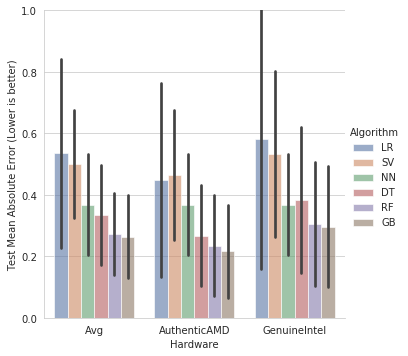

In [76]:
sns.set_style("whitegrid")
g = sns.catplot(
    data = df, 
    kind = "bar",
    x = "Hardware", 
    y = "Test Mean Absolute Error (Lower is better)", 
    hue = "Algorithm",
    ci="sd", 
    palette="deep", 
    alpha=.6, 
    height=5
)
plt.ylim((0,1))
plt.savefig("./results/RQ1.png")
plt.show()


In [77]:
nn_avg

[0.07372317596709853,
 0.4106159387037356,
 0.10795315112201435,
 0.3753641792535123,
 0.23181546110273774,
 0.5208609858124459,
 0.4866132076822256,
 0.6008663873029173,
 0.5486566978011869,
 0.9244946254099294,
 0.38958078859990697,
 0.12569497846293018,
 0.2837609150165464,
 0.18586801045145415,
 0.361378997687579,
 0.4807282282371597,
 0.5497095507249139,
 0.26177270482622006,
 0.5618102613998099,
 0.2180481405106521,
 0.5927257492292105,
 0.4179613400463795,
 0.22155119514598973,
 0.5185868911633469,
 0.21076797312450415,
 0.388295476778804,
 0.5621615239608014,
 0.5063617126057389,
 0.13627943135206472,
 0.5469616916856592,
 0.36975947136542475,
 0.3078667601903961,
 0.33681293048603306,
 0.2900068287271453,
 0.23850464631860616,
 0.21506069896463736,
 0.28691509249126634,
 0.3853262414956428,
 0.13984714210493304,
 0.6140362484611392,
 0.23298802400481572,
 0.4452602834899416,
 0.0357896122098812,
 0.18509757400981353,
 0.1784068270088069,
 0.3723924672744356,
 0.433754247124764